# Heart Failure Prediction

## Documentation
Read the documentation on https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5 <br>
Feature Set - https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5/tables/1

***

## Feature Set
1) creatinine_phosphokinase - Higher value means higher probability of Heart injury or failure. <br>
2) ejection fraction - States the percentage of how much blood the left ventricle pumps out with each contraction. <br>
3) serum_creatinine - High levels of serum creatinine, it may indicate renal dysfunction (Kidney Failure) <br>
4) serum_sodium - An abnormally low level of sodium in the blood might be caused by heart failure <br>
5) DEATH_EVENT - before the end of the follow-up period, that was 130 days on average <br>
6) age - Age of the subject <br>
7) anaemia - Has anaemia or not <br>
8) diabetes - Has diabetes or not <br>
9) high_blood_pressure - Has high blood pressure or not <br>
10) time - Follow up period in days <br>
11) smoking - Subject smokes or not

***

## Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import plotly.offline
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, cohen_kappa_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import xgboost
from catboost import CatBoostClassifier
import lightgbm
from sklearn.ensemble import RandomForestClassifier

import optuna
from optuna.samplers import TPESampler

sns.set(rc={'figure.figsize':(10,8)})

In [2]:
def percentage_cal(num, deno):
    return str(round((num/deno)*100,2))+"%"

def calc_metrics(truth, preds):
    conf = confusion_matrix(truth, preds)
    print("Confusion Matrix:",conf)
    
    print("Accuracy:",accuracy_score(truth, preds))
    print("Kappa Score:",cohen_kappa_score(truth, preds))
    
    no_of_classes = len(y_test.unique())
    if no_of_classes == 2:
        # Binary Classification metrics
        print("Recall of each class:",recall_score(truth, preds, average=None))
        print("Precision of each class:",precision_score(truth, preds, average=None))
        print("F1-Score of each class:",f1_score(truth, preds, average=None))
        print("ROC AUC Score for each class:",roc_auc_score(truth, preds, average=None))
    elif no_of_classes > 2:
        print("Multilabel")
    else:
        print("Incorrect class specification")

In [3]:
def percentage_cal(num, deno):
    return str(round((num/deno)*100,2))+"%"

## Basic description

In [4]:
data = pd.read_csv(".\heart_failure_clinical_records_dataset.csv")
print("Data points:",data.shape[0])
print("Number of features:",data.shape[1])

Data points: 299
Number of features: 13


In [5]:
print("Data Types:")
print(data.dtypes)

Data Types:
age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object


Age can be considered as an int and need not be float. So, I will convert it into int

In [6]:
data['age'] = data['age'].astype('int64')

In [7]:
data.head()

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0   75        0                       582         0                 20   
1   55        0                      7861         0                 38   
2   65        0                       146         0                 20   
3   50        1                       111         0                 20   
4   65        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2        1     7            1  
3        0     7            1  
4        0     8            1

***

## EDA

In [8]:
# NaN present
print("Number of NaN data points:\n",data.isna().sum())

Number of NaN data points:
 age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


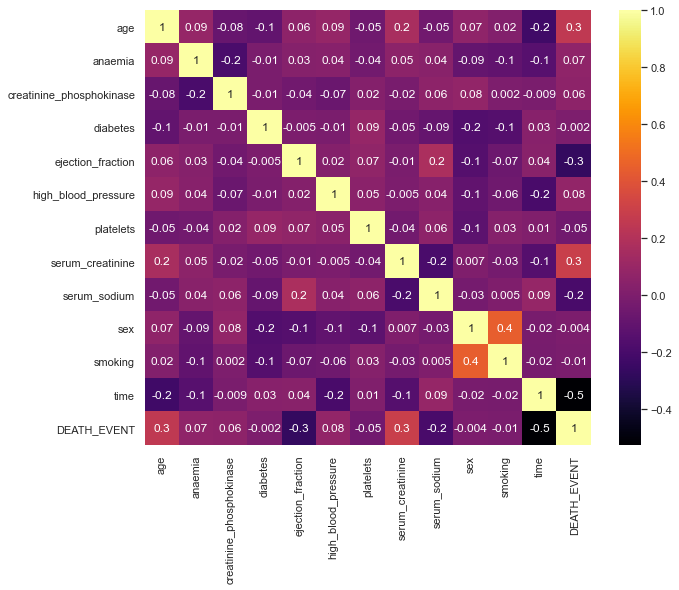

In [9]:
# Checking correlation between features
heatmap = sns.heatmap(data.corr(), annot = True, fmt='.1g', cmap= 'inferno')

From the Correlation Heatmap, I see - <br>
1) time <br>
2) age <br>
3) ejection_fraction <br>
4) serum_creatinine <br>
These are some features which have relatively high correlation with the feature DEATH_EVENT.

### Time

In [ ]:
# Visualizing relation between time and DEATH_EVENT
time_death = px.box(data, x='DEATH_EVENT', y='time', points="all", color_discrete_sequence=['blueviolet'])
time_death.show()

In [ ]:
print("Statistics of time feature with DEATH_EVENT 0:")
print(data[data['DEATH_EVENT'] == 0]['time'].describe())

In [ ]:
print("Statistics of time feature with DEATH_EVENT 1:")
print(data[data['DEATH_EVENT'] == 1]['time'].describe())

This shows that DEATH_EVENT are quite separated (CC boxes not overlaping) when compared w.r.t. the time. 

### Age

In [ ]:
# Age distribution
fig = ff.create_distplot([data['age'].values], ['age'], colors=['blueviolet'])
fig.show()

In [ ]:
# Age groups relation with DEATH_EVENT
bins = pd.cut(data['age'], [40, 50, 60, 70, 80, 90])
prob_of_death = data.groupby(bins)['DEATH_EVENT'].agg(['count', 'sum', 'mean'])
prob_of_death

After the age of 70, death rates are doubled.

### ejection_fraction

In [ ]:
data['ejection_fraction'].describe()

In [ ]:
# Relation of ejaction_fraction with DEATH_EVENT
ejection = px.histogram(data, x="ejection_fraction", color='DEATH_EVENT', marginal='box',
                       color_discrete_sequence=['aqua','blueviolet'])
ejection.show()

### serum_creatinine

In [ ]:
# Relation of ejaction_fraction with DEATH_EVENT
serum = px.histogram(data, x="serum_creatinine", color='DEATH_EVENT', marginal='box',
                       color_discrete_sequence=['aqua','blueviolet'])
serum.show()

### Diabetes

In [ ]:
# Distribution of Target Variable i.e. DEATH_EVENT with diabetes

print("Percentage of people who died:", percentage_cal(len(data[data['DEATH_EVENT']==1]),len(data)))
print("Percentage of people who didn't die:", percentage_cal(len(data[data['DEATH_EVENT']==0]),len(data)))
death_event = px.histogram(data, x='DEATH_EVENT',color='diabetes', marginal='violin',
                           color_discrete_sequence=['aqua','blueviolet'])
death_event.update_layout(bargap=0.2, xaxis = dict(
        tickmode = 'array',
        tickvals = [0,1],
        ticktext = ['Didnt die', 'Died']
    ))
death_event.show()

***

## Feature Engineering

Based on the boxplots of the feature 'time', we saw there is a difference in range of DEATH_EVENT being 0 and 1. We can levarage that and create a categorical feature that can state whether time is above or below a certain threshold. In our case, we can set a range of threshold and check which threshold works best 

In [19]:
temp_data_time = data[['time','DEATH_EVENT']]

In [20]:
range_thresh = np.arange(95,100,0.5)
for thresh in range_thresh:
    temp_data_time['pred'] = [0 if x > thresh else 1 for x in temp_data_time['time']]
    print("For threshold",thresh,", accuracy =",accuracy_score(temp_data_time['DEATH_EVENT'], temp_data_time['pred']))

For threshold 95.0 , accuracy = 0.7324414715719063
For threshold 95.5 , accuracy = 0.7324414715719063
For threshold 96.0 , accuracy = 0.7357859531772575
For threshold 96.5 , accuracy = 0.7357859531772575
For threshold 97.0 , accuracy = 0.7324414715719063
For threshold 97.5 , accuracy = 0.7324414715719063
For threshold 98.0 , accuracy = 0.7324414715719063
For threshold 98.5 , accuracy = 0.7324414715719063
For threshold 99.0 , accuracy = 0.7324414715719063
For threshold 99.5 , accuracy = 0.7324414715719063


It looks like a threshold of 96 or 96.5 gives the best results

In [21]:
thresh = 96
data['time_below_100'] = [0 if x > thresh else 1 for x in data['time']]

Just for surity, we will perform a chi-squared test for independence <br>
Null hypothesis - The two features are independent <br>
Alternate hypothesis - The features are dependent <br>
If p-value less than alpha, we reject the Null hypothesis, else we accept it. 

In [22]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(data['time_below_100'],data['DEATH_EVENT'])) 
print('P-value:',p)

P-value: 2.4256356157046746e-14


Considering an alpha of 0.05, this p-value proves that the features are dependent.

For the feature age, we saw that as age goes up, chances of dying increases. We can create a feature to capture that fact.

In [23]:
def check_age_range(age):
    if age > 0 and age <= 50:
        return prob_of_death.iloc[0]['mean']
    elif age > 50 and age <= 60:
        return prob_of_death.iloc[1]['mean']
    elif age > 60 and age <= 70:
        return prob_of_death.iloc[2]['mean']
    elif age > 70 and age <= 80:
        return prob_of_death.iloc[3]['mean']
    elif age > 80 and age <= 100:
        return prob_of_death.iloc[4]['mean']

data['prob_of_death'] = data['age'].apply(check_age_range)

In [24]:
data.head()

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0   75        0                       582         0                 20   
1   55        0                      7861         0                 38   
2   65        0                       146         0                 20   
3   50        1                       111         0                 20   
4   65        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  time_below_100  prob_of_death  
0        0     4            1               1       0.529412  
1        0     6            1               1       0.288889  
2        1     7            1               1       0.240964  
3        0     7            1               1       0.283582  
4        0     8            1               1       0.240964

## Modeling

### Data Preparation

In [25]:
X = data.drop(columns=['DEATH_EVENT'])
y = data['DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [26]:
print("Shape of train set:", len(X_train))
print("Shape of test set:", len(X_test))

Shape of train set: 209
Shape of test set: 90


For experimentation purposes, we will separate out the numerical features in the dataset and then ensemble it with the models trained on the entire data. I tried using only categorical features to build a model, But the model failed, even after exhaustive hyperparameter tuning. 

### Numerical Features

In [27]:
numerical_features = ['age','creatinine_phosphokinase','ejection_fraction','platelets',
                     'serum_creatinine','serum_sodium','time','prob_of_death']

In [28]:
X_train_num = X_train[numerical_features]
X_test_num = X_test[numerical_features]

In [29]:
# Scaling the features
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

For numerical features, I will implement two algorithms, viz. <br>
1) Logistic Regression <br>
2) SVM

In [30]:
# Logistic Regression 
log_reg = LogisticRegression()
log_reg.fit(X_train_num_scaled, y_train)
log_reg_pred = log_reg.predict(X_test_num_scaled)
calc_metrics(y_test,log_reg_pred)

Confusion Matrix: [[48  5]
 [15 22]]
Accuracy: 0.7777777777777778
Kappa Score: 0.5215311004784688
Recall of each class: [0.90566038 0.59459459]
Precision of each class: [0.76190476 0.81481481]
F1-Score of each class: [0.82758621 0.6875    ]
ROC AUC Score for each class: 0.7501274859765427


In [31]:
# SVM
svm = SVC()
svm.fit(X_train_num_scaled, y_train)
svm_pred = svm.predict(X_test_num_scaled)
calc_metrics(y_test, svm_pred)

Confusion Matrix: [[48  5]
 [16 21]]
Accuracy: 0.7666666666666667
Kappa Score: 0.4954618259476775
Recall of each class: [0.90566038 0.56756757]
Precision of each class: [0.75       0.80769231]
F1-Score of each class: [0.82051282 0.66666667]
ROC AUC Score for each class: 0.7366139724630291


### All Features

To process a mixed bag of features, the options are limited. I am going with: <br>
1) XGBoost <br>
2) CatBoost <br>
3) LightGBM <br>
4) Random Forest 

In [32]:
# Replacing the numerical features with their scaled values
# Train
X_train = X_train.drop(columns=numerical_features)
for ind, feature_name in enumerate(numerical_features):
    X_train[feature_name] = X_train_num_scaled.T[ind]

# Test
X_test = X_test.drop(columns=numerical_features)
for ind, feature_name in enumerate(numerical_features):
    X_test[feature_name] = X_test_num_scaled.T[ind]

In [33]:
# XGBoost
####################################
# Parameters to consider : 
# n_estimators
# max_depth
# learning_rate
####################################
xgb = xgboost.XGBClassifier(learning_rate=0.8, max_depth=10, n_estimators=100)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
calc_metrics(y_test, xgb_preds)

[00:21:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix: [[48  5]
 [13 24]]
Accuracy: 0.8
Kappa Score: 0.5730100158144439
Recall of each class: [0.90566038 0.64864865]
Precision of each class: [0.78688525 0.82758621]
F1-Score of each class: [0.84210526 0.72727273]
ROC AUC Score for each class: 0.7771545130035696


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



In [34]:
# Cat Boost
####################################
# Parameters to consider : 
# iterations
# depth
# learning_rate
####################################
cat = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.5)
cat.fit(X_train, y_train)
cat_preds = cat.predict(X_test)
calc_metrics(y_test, cat_preds)

0:	learn: 0.5165490	total: 55.1ms	remaining: 5.45s
1:	learn: 0.4423501	total: 56.5ms	remaining: 2.77s
2:	learn: 0.3695585	total: 57.8ms	remaining: 1.87s
3:	learn: 0.3295371	total: 59.2ms	remaining: 1.42s
4:	learn: 0.2996627	total: 60.5ms	remaining: 1.15s
5:	learn: 0.2818157	total: 62.2ms	remaining: 974ms
6:	learn: 0.2589435	total: 63.7ms	remaining: 846ms
7:	learn: 0.2426425	total: 65.4ms	remaining: 752ms
8:	learn: 0.2348306	total: 66.8ms	remaining: 675ms
9:	learn: 0.2257025	total: 68.1ms	remaining: 613ms
10:	learn: 0.2191894	total: 69.7ms	remaining: 564ms
11:	learn: 0.2067242	total: 71.1ms	remaining: 521ms
12:	learn: 0.1968210	total: 72.5ms	remaining: 485ms
13:	learn: 0.1878481	total: 74.1ms	remaining: 455ms
14:	learn: 0.1832957	total: 75.4ms	remaining: 427ms
15:	learn: 0.1807231	total: 77.1ms	remaining: 405ms
16:	learn: 0.1714768	total: 78.7ms	remaining: 384ms
17:	learn: 0.1645414	total: 80.3ms	remaining: 366ms
18:	learn: 0.1579882	total: 82.1ms	remaining: 350ms
19:	learn: 0.1535160	t

In [35]:
# Light GBM
lgbm = lightgbm.LGBMClassifier()
lgbm.fit(X_train, y_train)
lgbm_preds = lgbm.predict(X_test)
calc_metrics(y_test, lgbm_preds)

Confusion Matrix: [[46  7]
 [15 22]]
Accuracy: 0.7555555555555555
Kappa Score: 0.47812335266209804
Recall of each class: [0.86792453 0.59459459]
Precision of each class: [0.75409836 0.75862069]
F1-Score of each class: [0.80701754 0.66666667]
ROC AUC Score for each class: 0.7312595614482408


In [36]:
# Random Forest
rnd = RandomForestClassifier()
rnd.fit(X_train, y_train)
rnd_preds = rnd.predict(X_test)
calc_metrics(y_test, rnd_preds)

Confusion Matrix: [[50  3]
 [16 21]]
Accuracy: 0.7888888888888889
Kappa Score: 0.5395799676898223
Recall of each class: [0.94339623 0.56756757]
Precision of each class: [0.75757576 0.875     ]
F1-Score of each class: [0.84033613 0.68852459]
ROC AUC Score for each class: 0.755481896991331


As we can see, performance of all the models are within the same range. Before creating an ensemble, I believe the results can be enhanced with some hyperparameter tuning and feature pruning.

In [37]:
# Feature pruning with correlation less than 0.05
for feature in X_train.columns:
    if abs(X_train[feature].corr(y_train)) < 0.05:
        X_train.drop(columns=[feature],inplace=True)
        X_test.drop(columns=[feature],inplace=True)
#X_train.head()
X_test = X_test[X_train.columns.values]

sex  time_below_100       age  ejection_fraction  serum_creatinine  \
224    1               0 -0.236875          -1.161762         -0.373951   
68     0               1  0.792732          -1.161762         -0.173475   
222    1               0 -1.609684          -0.295518         -0.273713   
37     0               1  1.822338           1.003848         -0.373951   
16     1               1  2.251341          -0.035644         -0.474190   

     serum_sodium      time  prob_of_death  
224      0.297672  0.917167      -0.273247  
68       1.226232 -0.866991      -0.674170  
222      0.529812  0.865825      -0.317641  
37       1.922652 -1.329076       2.887107  
16       0.761952 -1.534447       2.887107

In [38]:
%%time
# Hyper Parameter Tuning
# Optimizing XGBoost
# Derived from https://www.kaggle.com/isaienkov/data-visualization-modeling-82-acc-75-f1

def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", low=1, high=100, step=1)
    max_depth = trial.suggest_int("max_depth", low=2, high=10, step=1)
    learning_rate = trial.suggest_uniform("learning_rate", low=0.1, high=1)
    gamma = trial.suggest_float("gamma", low=0.0001, high=1, step=0.0001)
    model = xgboost.XGBClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth,
        gamma=gamma,
        random_state=42
    )
    return model

sampler = TPESampler(seed=42)

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return f1_score(y_test, preds)

study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=1000)

xgb_params = study.best_params
xgb_params['random_state'] = 42
xgb_tuned = xgboost.XGBClassifier(**xgb_params)
xgb_tuned.fit(X_train, y_train)
xgb_tuned_preds = xgb_tuned.predict(X_test)

calc_metrics(y_test, xgb_tuned_preds)

[I 2021-03-19 00:21:54,611] A new study created in memory with name: no-name-913f0cc8-90a0-4b6c-8edc-7f01f3ea6c3d
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:54,675] Trial 0 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 52, 'max_depth': 9, 'learning_rate': 0.6387926357773329, 'gamma': 0.1561}. Best is trial 0 with value: 0.6153846153846154.


[00:21:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:54,762] Trial 1 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 83, 'max_depth': 8, 'learning_rate': 0.15227525095137953, 'gamma': 0.8662000000000001}. Best is trial 1 with value: 0.6349206349206349.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0

[00:21:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:21:54,841] Trial 2 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.737265320016441, 'gamma': 0.0206}. Best is trial 2 with value: 0.6865671641791045.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:54,863] Trial 3 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 2, 'max_depth': 9, 'learning_rate': 0.8491983767203796, 'gamma': 0.2124}. Best is trial 2 with value: 0.6865671641791045.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will 

[00:21:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:21:55,007] Trial 5 finished with value: 0.6101694915254238 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.5722971942325502, 'gamma': 0.39990000000000003}. Best is trial 2 with value: 0.6865671641791045.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:21:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:21:55,102] Trial 6 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 92, 'max_depth': 4, 'learning_rate': 0.4442157921404465, 'gamma': 0.9833000000000001}. Best is trial 2 with value: 0.6865671641791045.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:55,126] Trial 7 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 3, 'max_depth': 6, 'learning_rate': 0.6467903667112945, 'gamma': 0.1706}. Best is trial 2 with value: 0.6865671641791045.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecat

[00:21:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:55,271] Trial 10 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 27, 'max_depth': 10, 'learning_rate': 0.8195636461828986, 'gamma': 0.01}. Best is trial 2 with value: 0.6865671641791045.


[00:21:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:55,341] Trial 11 finished with value: 0.746268656716418 and parameters: {'n_estimators': 20, 'max_depth': 8, 'learning_rate': 0.865720474043477, 'gamma': 0.0193}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [

[00:21:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:55,509] Trial 13 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 69, 'max_depth': 10, 'learning_rate': 0.9521686490108788, 'gamma': 0.4351}. Best is trial 11 with value: 0.746268656716418.


[00:21:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:55,584] Trial 14 finished with value: 0.696969696969697 and parameters: {'n_estimators': 31, 'max_depth': 8, 'learning_rate': 0.7844597192001418, 'gamma': 0.0074}. Best is trial 11 with value: 0.746268656716418.


[00:21:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:55,662] Trial 15 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 33, 'max_depth': 7, 'learning_rate': 0.9855386335944751, 'gamma': 0.6703}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:21:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:55,811] Trial 17 finished with value: 0.696969696969697 and parameters: {'n_estimators': 44, 'max_depth': 5, 'learning_rate': 0.8886027267727187, 'gamma': 0.0844}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:21:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:55,962] Trial 19 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 15, 'max_depth': 8, 'learning_rate': 0.7240238844439829, 'gamma': 0.3108}. Best is trial 11 with value: 0.746268656716418.


[00:21:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:56,045] Trial 20 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 31, 'max_depth': 7, 'learning_rate': 0.7354868398814691, 'gamma': 0.6309}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:56,199] Trial 22 finished with value: 0.6129032258064517 and parameters: {'n_estimators': 43, 'max_depth': 5, 'learning_rate': 0.8812136833904083, 'gamma': 0.11340000000000001}. Best is trial 11 with value: 0.746268656716418.


[00:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:56,277] Trial 23 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 59, 'max_depth': 5, 'learning_rate': 0.778566955238818, 'gamma': 0.006500000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:56,420] Trial 25 finished with value: 0.6470588235294118 and parameters: {'n_estimators': 21, 'max_depth': 8, 'learning_rate': 0.9837324560294277, 'gamma': 0.3033}. Best is trial 11 with value: 0.746268656716418.


[00:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:56,494] Trial 26 finished with value: 0.625 and parameters: {'n_estimators': 27, 'max_depth': 9, 'learning_rate': 0.5555958076071013, 'gamma': 0.10880000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:56,649] Trial 28 finished with value: 0.6060606060606061 and parameters: {'n_estimators': 57, 'max_depth': 10, 'learning_rate': 0.7002744891739784, 'gamma': 0.4981}. Best is trial 11 with value: 0.746268656716418.


[00:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:56,735] Trial 29 finished with value: 0.625 and parameters: {'n_estimators': 47, 'max_depth': 7, 'learning_rate': 0.5921949222599631, 'gamma': 0.12739999999999999}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:21:56,817] Trial 30 finished with value: 0.59375 and parameters: {'n_estimators': 41, 'max_depth': 8, 'learning_rate': 0.9995231160773719, 'gamma': 0.172}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:56,889] Trial 31 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 20, 'max_depth': 7, 'learning_rate': 0.44285214111969035, 'gamma': 0.3331}. Best is trial 11 with value: 0.746268656716418.


[00:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:56,952] Trial 32 finished with value: 0.65625 and parameters: {'n_estimators': 11, 'max_depth': 8, 'learning_rate': 0.4492438082960656, 'gamma': 0.055700000000000006}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, .

[00:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:57,105] Trial 34 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 24, 'max_depth': 6, 'learning_rate': 0.22478081778821135, 'gamma': 0.2692}. Best is trial 11 with value: 0.746268656716418.


[00:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:57,185] Trial 35 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 33, 'max_depth': 7, 'learning_rate': 0.5054130875917159, 'gamma': 0.3718}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:21:57,301] Trial 37 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 6, 'max_depth': 5, 'learning_rate': 0.6801572573434413, 'gamma': 0.1557}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:21:57,385] Trial 38 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 37, 'max_depth': 6, 'learning_rate': 0.37778043573115816, 'gamma': 0.04510000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:57,453] Trial 39 finished with value: 0.6470588235294118 and parameters: {'n_estimators': 14, 'max_depth': 8, 'learning_rate': 0.8375527104522799, 'gamma': 0.7313000000000001}. Best is trial 11 with value: 0.746268656716418.


[00:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:21:57,550] Trial 40 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 75, 'max_depth': 3, 'learning_rate': 0.594618360830991, 'gamma': 0.1583}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:57,658] Trial 41 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 84, 'max_depth': 9, 'learning_rate': 0.7436924040177287, 'gamma': 0.0013000000000000002}. Best is trial 11 with value: 0.746268656716418.


[00:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:57,735] Trial 42 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 30, 'max_depth': 9, 'learning_rate': 0.8965117463310683, 'gamma': 0.062400000000000004}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:21:57,864] Trial 43 finished with value: 0.7058823529411764 and parameters: {'n_estimators': 98, 'max_depth': 8, 'learning_rate': 0.6473563854730168, 'gamma': 0.4466}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:21:57,989] Trial 44 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 96, 'max_depth': 8, 'learning_rate': 0.7644844752132861, 'gamma': 0.4576}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:58,088] Trial 45 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 56, 'max_depth': 7, 'learning_rate': 0.6400880906379893, 'gamma': 0.5331}. Best is trial 11 with value: 0.746268656716418.


[00:21:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:58,162] Trial 46 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 22, 'max_depth': 6, 'learning_rate': 0.5093973000251328, 'gamma': 0.3845}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:21:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:21:58,249] Trial 47 finished with value: 0.6451612903225806 and parameters: {'n_estimators': 47, 'max_depth': 8, 'learning_rate': 0.816248883362859, 'gamma': 0.3629}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:58,322] Trial 48 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 18, 'max_depth': 7, 'learning_rate': 0.6167138316357692, 'gamma': 0.42760000000000004}. Best is trial 11 with value: 0.746268656716418.


[00:21:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:58,382] Trial 49 finished with value: 0.7076923076923075 and parameters: {'n_estimators': 8, 'max_depth': 10, 'learning_rate': 0.6655294886453182, 'gamma': 0.4713}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:21:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:21:58,500] Trial 51 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 7, 'max_depth': 9, 'learning_rate': 0.8547301005196861, 'gamma': 0.5666}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:58,564] Trial 52 finished with value: 0.6031746031746031 and parameters: {'n_estimators': 12, 'max_depth': 6, 'learning_rate': 0.6970153142301432, 'gamma': 0.4819}. Best is trial 11 with value: 0.746268656716418.


[00:21:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:58,642] Trial 53 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 26, 'max_depth': 8, 'learning_rate': 0.9277854610870234, 'gamma': 0.616}. Best is trial 11 with value: 0.746268656716418.


[00:21:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:58,709] Trial 54 finished with value: 0.625 and parameters: {'n_estimators': 17, 'max_depth': 5, 'learning_rate': 0.6484229223240766, 'gamma': 0.4022}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class -

[00:21:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:58,879] Trial 56 finished with value: 0.626865671641791 and parameters: {'n_estimators': 43, 'max_depth': 7, 'learning_rate': 0.7876644001726443, 'gamma': 0.29710000000000003}. Best is trial 11 with value: 0.746268656716418.


[00:21:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:58,957] Trial 57 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 29, 'max_depth': 10, 'learning_rate': 0.7228102450844451, 'gamma': 0.5745}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:21:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:21:59,143] Trial 59 finished with value: 0.625 and parameters: {'n_estimators': 62, 'max_depth': 9, 'learning_rate': 0.9579173118813507, 'gamma': 0.6584}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:59,245] Trial 60 finished with value: 0.6031746031746031 and parameters: {'n_estimators': 53, 'max_depth': 5, 'learning_rate': 0.4038695886346396, 'gamma': 0.5191}. Best is trial 11 with value: 0.746268656716418.


[00:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:59,319] Trial 61 finished with value: 0.6031746031746031 and parameters: {'n_estimators': 21, 'max_depth': 6, 'learning_rate': 0.5135071537891893, 'gamma': 0.3681}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:21:59,398] Trial 62 finished with value: 0.625 and parameters: {'n_estimators': 24, 'max_depth': 6, 'learning_rate': 0.48317080660346745, 'gamma': 0.4157}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:59,466] Trial 63 finished with value: 0.676923076923077 and parameters: {'n_estimators': 17, 'max_depth': 10, 'learning_rate': 0.819580074860988, 'gamma': 0.0884}. Best is trial 11 with value: 0.746268656716418.


[00:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:59,529] Trial 64 finished with value: 0.6129032258064517 and parameters: {'n_estimators': 11, 'max_depth': 10, 'learning_rate': 0.8586744998684692, 'gamma': 0.0096}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:21:59,644] Trial 65 finished with value: 0.625 and parameters: {'n_estimators': 97, 'max_depth': 8, 'learning_rate': 0.6659951743191462, 'gamma': 0.028}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:21:59,726] Trial 66 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 32, 'max_depth': 10, 'learning_rate': 0.753104177822804, 'gamma': 0.33340000000000003}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:59,798] Trial 67 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 23, 'max_depth': 7, 'learning_rate': 0.547594660235709, 'gamma': 0.45840000000000003}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassi

[00:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:21:59,935] Trial 69 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 3, 'max_depth': 7, 'learning_rate': 0.6096534005095209, 'gamma': 0.5039}. Best is trial 11 with value: 0.746268656716418.


[00:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:00,083] Trial 70 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 97, 'max_depth': 8, 'learning_rate': 0.7524163261956539, 'gamma': 0.5611}. Best is trial 11 with value: 0.746268656716418.


[00:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:00,206] Trial 71 finished with value: 0.676923076923077 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.7206958162601266, 'gamma': 0.12240000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:00,325] Trial 72 finished with value: 0.625 and parameters: {'n_estimators': 89, 'max_depth': 9, 'learning_rate': 0.782177534465246, 'gamma': 0.0762}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:00,443] Trial 73 finished with value: 0.5901639344262296 and parameters: {'n_estimators': 92, 'max_depth': 8, 'learning_rate': 0.8795482946573716, 'gamma': 0.1996}. Best is trial 11 with value: 0.746268656716418.


[00:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:00,524] Trial 74 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 27, 'max_depth': 8, 'learning_rate': 0.8365225723856526, 'gamma': 0.0242}. Best is trial 11 with value: 0.746268656716418.


[00:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:00,611] Trial 75 finished with value: 0.6031746031746031 and parameters: {'n_estimators': 26, 'max_depth': 8, 'learning_rate': 0.9158128094210595, 'gamma': 0.4378}. Best is trial 11 with value: 0.746268656716418.


[00:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:00,688] Trial 76 finished with value: 0.6333333333333333 and parameters: {'n_estimators': 36, 'max_depth': 3, 'learning_rate': 0.5660542829912, 'gamma': 0.48410000000000003}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 

[00:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:00,893] Trial 78 finished with value: 0.676923076923077 and parameters: {'n_estimators': 69, 'max_depth': 9, 'learning_rate': 0.8337845549144517, 'gamma': 0.0279}. Best is trial 11 with value: 0.746268656716418.


[00:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:00,967] Trial 79 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 19, 'max_depth': 8, 'learning_rate': 0.8866172746500355, 'gamma': 0.1328}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:01,044] Trial 80 finished with value: 0.5901639344262296 and parameters: {'n_estimators': 23, 'max_depth': 7, 'learning_rate': 0.4174554696950358, 'gamma': 0.3803}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:01,112] Trial 81 finished with value: 0.6984126984126985 and parameters: {'n_estimators': 29, 'max_depth': 3, 'learning_rate': 0.9390755103106443, 'gamma': 0.043500000000000004}. Best is trial 11 with value: 0.746268656716418.


[00:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:01,178] Trial 82 finished with value: 0.6031746031746031 and parameters: {'n_estimators': 43, 'max_depth': 2, 'learning_rate': 0.9494561943333378, 'gamma': 0.3472}. Best is trial 11 with value: 0.746268656716418.


[00:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:01,244] Trial 83 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 29, 'max_depth': 3, 'learning_rate': 0.5343367820174552, 'gamma': 0.2856}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:01,377] Trial 85 finished with value: 0.6875 and parameters: {'n_estimators': 14, 'max_depth': 5, 'learning_rate': 0.905075384305804, 'gamma': 0.09580000000000001}. Best is trial 11 with value: 0.746268656716418.


[00:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:01,444] Trial 86 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 14, 'max_depth': 5, 'learning_rate': 0.9048632617726204, 'gamma': 0.08710000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:01,579] Trial 88 finished with value: 0.6875 and parameters: {'n_estimators': 14, 'max_depth': 5, 'learning_rate': 0.909813185751097, 'gamma': 0.0932}. Best is trial 11 with value: 0.746268656716418.


[00:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:01,651] Trial 89 finished with value: 0.676470588235294 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.9217574379805128, 'gamma': 0.1472}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:01,786] Trial 91 finished with value: 0.696969696969697 and parameters: {'n_estimators': 12, 'max_depth': 5, 'learning_rate': 0.9040010872097457, 'gamma': 0.1097}. Best is trial 11 with value: 0.746268656716418.


[00:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:01,849] Trial 92 finished with value: 0.65625 and parameters: {'n_estimators': 5, 'max_depth': 6, 'learning_rate': 0.9446128316146251, 'gamma': 0.1731}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class 

[00:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:01,991] Trial 94 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 17, 'max_depth': 4, 'learning_rate': 0.8782031732865521, 'gamma': 0.0009000000000000001}. Best is trial 11 with value: 0.746268656716418.


[00:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:02,052] Trial 95 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.8514734433512511, 'gamma': 0.11870000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0

[00:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:02,178] Trial 97 finished with value: 0.6451612903225806 and parameters: {'n_estimators': 4, 'max_depth': 2, 'learning_rate': 0.9416774773889842, 'gamma': 0.0379}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:02,247] Trial 98 finished with value: 0.696969696969697 and parameters: {'n_estimators': 16, 'max_depth': 5, 'learning_rate': 0.863794619060575, 'gamma': 0.061200000000000004}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:02,309] Trial 99 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 12, 'max_depth': 4, 'learning_rate': 0.8899297870817825, 'gamma': 0.1402}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is depre

[00:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:02,379] Trial 100 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 16, 'max_depth': 5, 'learning_rate': 0.8650424433483446, 'gamma': 0.07550000000000001}. Best is trial 11 with value: 0.746268656716418.


[00:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:02,449] Trial 101 finished with value: 0.626865671641791 and parameters: {'n_estimators': 19, 'max_depth': 5, 'learning_rate': 0.9628513898817861, 'gamma': 0.061000000000000006}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:02,605] Trial 103 finished with value: 0.676923076923077 and parameters: {'n_estimators': 49, 'max_depth': 5, 'learning_rate': 0.8285629323662382, 'gamma': 0.10850000000000001}. Best is trial 11 with value: 0.746268656716418.


[00:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:02,680] Trial 104 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 21, 'max_depth': 5, 'learning_rate': 0.861676454937273, 'gamma': 0.009899999999999999}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:02,816] Trial 106 finished with value: 0.6060606060606061 and parameters: {'n_estimators': 12, 'max_depth': 6, 'learning_rate': 0.8131885613032233, 'gamma': 0.1783}. Best is trial 11 with value: 0.746268656716418.


[00:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:02,883] Trial 107 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 15, 'max_depth': 5, 'learning_rate': 0.8031568010113204, 'gamma': 0.0011}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:03,028] Trial 109 finished with value: 0.625 and parameters: {'n_estimators': 38, 'max_depth': 5, 'learning_rate': 0.9374420709964806, 'gamma': 0.7309}. Best is trial 11 with value: 0.746268656716418.


[00:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:03,091] Trial 110 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 10, 'max_depth': 6, 'learning_rate': 0.7699593702629706, 'gamma': 0.1063}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:03,232] Trial 112 finished with value: 0.59375 and parameters: {'n_estimators': 10, 'max_depth': 6, 'learning_rate': 0.7053232345351295, 'gamma': 0.1057}. Best is trial 11 with value: 0.746268656716418.


[00:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:03,297] Trial 113 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 7, 'max_depth': 6, 'learning_rate': 0.7750676893340156, 'gamma': 0.1544}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:03,421] Trial 115 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 5, 'max_depth': 4, 'learning_rate': 0.7658595092513046, 'gamma': 0.0282}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:03,491] Trial 116 finished with value: 0.625 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.8681590323117302, 'gamma': 0.07550000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:03,572] Trial 117 finished with value: 0.6229508196721311 and parameters: {'n_estimators': 25, 'max_depth': 6, 'learning_rate': 0.6237564099503937, 'gamma': 0.043000000000000003}. Best is trial 11 with value: 0.746268656716418.


[00:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:03,655] Trial 118 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 29, 'max_depth': 7, 'learning_rate': 0.668936061164603, 'gamma': 0.255}. Best is trial 11 with value: 0.746268656716418.


[00:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:03,733] Trial 119 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 21, 'max_depth': 6, 'learning_rate': 0.7991808518853296, 'gamma': 0.223}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:03,876] Trial 121 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 12, 'max_depth': 5, 'learning_rate': 0.7373040724380483, 'gamma': 0.0921}. Best is trial 11 with value: 0.746268656716418.


[00:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:03,945] Trial 122 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.9101408369421278, 'gamma': 0.1048}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:04,079] Trial 124 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.9057771473248459, 'gamma': 0.1345}. Best is trial 11 with value: 0.746268656716418.


[00:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:04,144] Trial 125 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.9232552633879048, 'gamma': 0.1382}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:04,279] Trial 127 finished with value: 0.626865671641791 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.960196608243838, 'gamma': 0.1096}. Best is trial 11 with value: 0.746268656716418.


[00:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:04,343] Trial 128 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 2, 'max_depth': 6, 'learning_rate': 0.9153751191828146, 'gamma': 0.1674}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:04,464] Trial 130 finished with value: 0.65625 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.5874210413651745, 'gamma': 0.1278}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:04,559] Trial 131 finished with value: 0.676470588235294 and parameters: {'n_estimators': 54, 'max_depth': 5, 'learning_rate': 0.9380235952540419, 'gamma': 0.08410000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:04,624] Trial 132 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 12, 'max_depth': 5, 'learning_rate': 0.8979792943185122, 'gamma': 0.15}. Best is trial 11 with value: 0.746268656716418.


[00:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:04,693] Trial 133 finished with value: 0.676470588235294 and parameters: {'n_estimators': 14, 'max_depth': 6, 'learning_rate': 0.9722733408217399, 'gamma': 0.09960000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:04,821] Trial 135 finished with value: 0.6451612903225806 and parameters: {'n_estimators': 7, 'max_depth': 3, 'learning_rate': 0.8996340516986133, 'gamma': 0.050800000000000005}. Best is trial 11 with value: 0.746268656716418.


[00:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:04,884] Trial 136 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 3, 'max_depth': 5, 'learning_rate': 0.8821171193088926, 'gamma': 0.133}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:05,049] Trial 138 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 31, 'max_depth': 7, 'learning_rate': 0.6902794852108254, 'gamma': 0.0288}. Best is trial 11 with value: 0.746268656716418.


[00:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:05,127] Trial 139 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 19, 'max_depth': 6, 'learning_rate': 0.7151398810011163, 'gamma': 0.07070000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:05,209] Trial 140 finished with value: 0.6774193548387097 and parameters: {'n_estimators': 41, 'max_depth': 2, 'learning_rate': 0.9288871988659213, 'gamma': 0.0025}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:05,280] Trial 141 finished with value: 0.6470588235294118 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.9554100504213168, 'gamma': 0.1092}. Best is trial 11 with value: 0.746268656716418.


[00:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:05,352] Trial 142 finished with value: 0.7076923076923075 and parameters: {'n_estimators': 13, 'max_depth': 5, 'learning_rate': 0.9102092871132348, 'gamma': 0.09630000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:05,515] Trial 144 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 13, 'max_depth': 5, 'learning_rate': 0.9208707959472111, 'gamma': 0.1616}. Best is trial 11 with value: 0.746268656716418.


[00:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:05,572] Trial 145 finished with value: 0.6956521739130435 and parameters: {'n_estimators': 5, 'max_depth': 5, 'learning_rate': 0.8836172624645059, 'gamma': 0.0454}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:05,721] Trial 147 finished with value: 0.6451612903225806 and parameters: {'n_estimators': 11, 'max_depth': 4, 'learning_rate': 0.8690297681732965, 'gamma': 0.10490000000000001}. Best is trial 11 with value: 0.746268656716418.


[00:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:05,798] Trial 148 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 18, 'max_depth': 5, 'learning_rate': 0.9435958253743753, 'gamma': 0.07150000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:05,936] Trial 150 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 15, 'max_depth': 6, 'learning_rate': 0.8487972537677034, 'gamma': 0.0216}. Best is trial 11 with value: 0.746268656716418.


[00:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:06,007] Trial 151 finished with value: 0.7058823529411764 and parameters: {'n_estimators': 13, 'max_depth': 5, 'learning_rate': 0.8937738773534625, 'gamma': 0.060000000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:06,134] Trial 153 finished with value: 0.626865671641791 and parameters: {'n_estimators': 14, 'max_depth': 5, 'learning_rate': 0.8680978665307719, 'gamma': 0.057100000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:06,197] Trial 154 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 6, 'max_depth': 5, 'learning_rate': 0.9123815020492223, 'gamma': 0.11420000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:06,294] Trial 155 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 79, 'max_depth': 5, 'learning_rate': 0.9270547854380199, 'gamma': 0.038900000000000004}. Best is trial 11 with value: 0.746268656716418.


[00:22:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:06,363] Trial 156 finished with value: 0.676923076923077 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.9244594370278764, 'gamma': 0.044300000000000006}. Best is trial 11 with value: 0.746268656716418.


[00:22:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:06,477] Trial 157 finished with value: 0.676923076923077 and parameters: {'n_estimators': 86, 'max_depth': 6, 'learning_rate': 0.9457941565477219, 'gamma': 0.0855}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:06,537] Trial 158 finished with value: 0.5666666666666667 and parameters: {'n_estimators': 1, 'max_depth': 8, 'learning_rate': 0.7524105179183551, 'gamma': 0.003}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:22:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:06,647] Trial 159 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 80, 'max_depth': 5, 'learning_rate': 0.9882296113308588, 'gamma': 0.06670000000000001}. Best is trial 11 with value: 0.746268656716418.


[00:22:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:06,753] Trial 160 finished with value: 0.5901639344262296 and parameters: {'n_estimators': 68, 'max_depth': 4, 'learning_rate': 0.7875906248644208, 'gamma': 0.5078}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:06,936] Trial 162 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 13, 'max_depth': 5, 'learning_rate': 0.8892043090164987, 'gamma': 0.1309}. Best is trial 11 with value: 0.746268656716418.


[00:22:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:07,005] Trial 163 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.9042345802309324, 'gamma': 0.09880000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:07,177] Trial 165 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.904964879884155, 'gamma': 0.1503}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:07,315] Trial 167 finished with value: 0.696969696969697 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.908169000368771, 'gamma': 0.1988}. Best is trial 11 with value: 0.746268656716418.


[00:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:07,381] Trial 168 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 3, 'max_depth': 5, 'learning_rate': 0.6372448930139522, 'gamma': 0.1568}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:07,523] Trial 170 finished with value: 0.696969696969697 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.9137660818353546, 'gamma': 0.1519}. Best is trial 11 with value: 0.746268656716418.


[00:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:07,593] Trial 171 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.9356489875133258, 'gamma': 0.117}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:07,733] Trial 173 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 12, 'max_depth': 6, 'learning_rate': 0.8987392211309323, 'gamma': 0.10120000000000001}. Best is trial 11 with value: 0.746268656716418.


[00:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:07,803] Trial 174 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 9, 'max_depth': 4, 'learning_rate': 0.8746669098976704, 'gamma': 0.07160000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:07,948] Trial 176 finished with value: 0.676923076923077 and parameters: {'n_estimators': 14, 'max_depth': 6, 'learning_rate': 0.9235277571344577, 'gamma': 0.1381}. Best is trial 11 with value: 0.746268656716418.


[00:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:08,014] Trial 177 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 5, 'max_depth': 5, 'learning_rate': 0.9386738231450388, 'gamma': 0.1671}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:08,202] Trial 179 finished with value: 0.676923076923077 and parameters: {'n_estimators': 72, 'max_depth': 10, 'learning_rate': 0.8791048106168535, 'gamma': 0.11340000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:08,277] Trial 180 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 17, 'max_depth': 4, 'learning_rate': 0.9190749870382245, 'gamma': 0.4434}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is de

[00:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:08,349] Trial 181 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.8998114615805096, 'gamma': 0.059500000000000004}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:08,418] Trial 182 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.9053456286171262, 'gamma': 0.05740000000000001}. Best is trial 11 with value: 0.746268656716418.


[00:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:08,489] Trial 183 finished with value: 0.676923076923077 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.8314898990278811, 'gamma': 0.060300000000000006}. Best is trial 11 with value: 0.746268656716418.


[00:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:08,557] Trial 184 finished with value: 0.676470588235294 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.8967852021987323, 'gamma': 0.48100000000000004}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0

[00:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:08,705] Trial 186 finished with value: 0.625 and parameters: {'n_estimators': 13, 'max_depth': 5, 'learning_rate': 0.8545202804546624, 'gamma': 0.0221}. Best is trial 11 with value: 0.746268656716418.


[00:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:08,772] Trial 187 finished with value: 0.6956521739130435 and parameters: {'n_estimators': 5, 'max_depth': 5, 'learning_rate': 0.9066282756664388, 'gamma': 0.07390000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:08,896] Trial 188 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.9172266657367137, 'gamma': 0.1038}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:08,967] Trial 189 finished with value: 0.696969696969697 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.8861905750783343, 'gamma': 0.12969999999999998}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is de

[00:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:09,190] Trial 192 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 13, 'max_depth': 5, 'learning_rate': 0.9018055155613153, 'gamma': 0.0275}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:09,405] Trial 195 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 6, 'max_depth': 5, 'learning_rate': 0.9052246404261459, 'gamma': 0.0854}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:09,615] Trial 198 finished with value: 0.5806451612903226 and parameters: {'n_estimators': 3, 'max_depth': 5, 'learning_rate': 0.21876634253908933, 'gamma': 0.1478}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:09,830] Trial 201 finished with value: 0.696969696969697 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.9083223629574432, 'gamma': 0.00030000000000000003}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:10,052] Trial 204 finished with value: 0.65625 and parameters: {'n_estimators': 11, 'max_depth': 5, 'learning_rate': 0.9535262887326721, 'gamma': 0.4032}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_clas

[00:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:10,272] Trial 207 finished with value: 0.6875 and parameters: {'n_estimators': 16, 'max_depth': 5, 'learning_rate': 0.9182516886627987, 'gamma': 0.0442}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class

[00:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:10,479] Trial 210 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.9717330597987878, 'gamma': 0.05280000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:10,746] Trial 213 finished with value: 0.676470588235294 and parameters: {'n_estimators': 94, 'max_depth': 5, 'learning_rate': 0.8956116505991922, 'gamma': 0.09960000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:10,891] Trial 215 finished with value: 0.65625 and parameters: {'n_estimators': 15, 'max_depth': 9, 'learning_rate': 0.9266989183259507, 'gamma': 0.11910000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:10,962] Trial 216 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.9069183586365258, 'gamma': 0.04050000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is d

[00:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:11,095] Trial 218 finished with value: 0.626865671641791 and parameters: {'n_estimators': 6, 'max_depth': 5, 'learning_rate': 0.9436281431370884, 'gamma': 0.1419}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[I 2021-03-19 00:22:11,284] Trial 221 finished with value: 0.696969696969697 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.9192246233241192, 'gamma': 0.0614}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:11,357] Trial 222 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 12, 'max_depth': 5, 'learning_rate': 0.8896795296947888, 'gamma': 0.012}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and wil

[00:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:11,572] Trial 225 finished with value: 0.6956521739130435 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.8924764382537105, 'gamma': 0.0313}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:11,791] Trial 228 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 17, 'max_depth': 5, 'learning_rate': 0.9266505168295047, 'gamma': 0.9409000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:12,012] Trial 231 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 20, 'max_depth': 4, 'learning_rate': 0.9390612903261174, 'gamma': 0.038900000000000004}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:12,218] Trial 234 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 12, 'max_depth': 5, 'learning_rate': 0.7339010425648308, 'gamma': 0.0966}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:12,434] Trial 237 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 6, 'max_depth': 4, 'learning_rate': 0.9203930026640743, 'gamma': 0.07300000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:12,635] Trial 239 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 89, 'max_depth': 5, 'learning_rate': 0.9047511545925593, 'gamma': 0.5244}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:12,710] Trial 240 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.9417945426792836, 'gamma': 0.1601}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and w

[00:22:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:12,927] Trial 243 finished with value: 0.696969696969697 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.9024756281056062, 'gamma': 0.1475}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:13,157] Trial 246 finished with value: 0.7058823529411764 and parameters: {'n_estimators': 16, 'max_depth': 5, 'learning_rate': 0.8939480066987345, 'gamma': 0.08470000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:13,385] Trial 249 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 14, 'max_depth': 5, 'learning_rate': 0.8891867150537507, 'gamma': 0.1207}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:13,615] Trial 252 finished with value: 0.6129032258064517 and parameters: {'n_estimators': 18, 'max_depth': 5, 'learning_rate': 0.8536552601725795, 'gamma': 0.1275}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:13,838] Trial 255 finished with value: 0.6984126984126985 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.7032968100497318, 'gamma': 0.14479999999999998}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:14,056] Trial 258 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.9280006149407857, 'gamma': 0.0976}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:14,280] Trial 261 finished with value: 0.65625 and parameters: {'n_estimators': 10, 'max_depth': 6, 'learning_rate': 0.8727356685876817, 'gamma': 0.135}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class

[00:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:14,493] Trial 264 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.9274323441914447, 'gamma': 0.1144}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:14,728] Trial 267 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 22, 'max_depth': 6, 'learning_rate': 0.9051027150775305, 'gamma': 0.0708}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:14,940] Trial 270 finished with value: 0.696969696969697 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.9217890647586789, 'gamma': 0.060000000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:15,166] Trial 273 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 15, 'max_depth': 5, 'learning_rate': 0.9443524115714255, 'gamma': 0.161}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:15,391] Trial 276 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 10, 'max_depth': 6, 'learning_rate': 0.8404068533615584, 'gamma': 0.022}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:15,623] Trial 278 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 85, 'max_depth': 6, 'learning_rate': 0.8610137963751632, 'gamma': 0.0178}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:15,747] Trial 279 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 98, 'max_depth': 6, 'learning_rate': 0.8169433719138812, 'gamma': 0.0002}. Best is trial 11 with value: 0.746268656716418.


[00:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:15,867] Trial 280 finished with value: 0.6875 and parameters: {'n_estimators': 91, 'max_depth': 6, 'learning_rate': 0.8765165861669089, 'gamma': 0.0113}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class

[00:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:16,047] Trial 282 finished with value: 0.626865671641791 and parameters: {'n_estimators': 4, 'max_depth': 6, 'learning_rate': 0.8451193980215038, 'gamma': 0.0008}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:16,267] Trial 284 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 67, 'max_depth': 6, 'learning_rate': 0.799438865280846, 'gamma': 0.1404}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:16,555] Trial 288 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 12, 'max_depth': 4, 'learning_rate': 0.9087129808793513, 'gamma': 0.6822}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:16,815] Trial 291 finished with value: 0.6031746031746031 and parameters: {'n_estimators': 72, 'max_depth': 10, 'learning_rate': 0.658146613479644, 'gamma': 0.08710000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:16,962] Trial 293 finished with value: 0.676470588235294 and parameters: {'n_estimators': 3, 'max_depth': 6, 'learning_rate': 0.9152457633497864, 'gamma': 0.0724}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:17,085] Trial 294 finished with value: 0.6060606060606061 and parameters: {'n_estimators': 82, 'max_depth': 5, 'learning_rate': 0.8615045634541483, 'gamma': 0.4436}. Best is trial 11 with value: 0.746268656716418.


[00:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:17,162] Trial 295 finished with value: 0.7076923076923075 and parameters: {'n_estimators': 11, 'max_depth': 5, 'learning_rate': 0.717017099352012, 'gamma': 0.1333}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:17,387] Trial 298 finished with value: 0.7076923076923075 and parameters: {'n_estimators': 12, 'max_depth': 5, 'learning_rate': 0.7174267017807007, 'gamma': 0.00030000000000000003}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i

[00:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:17,605] Trial 301 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 6, 'max_depth': 4, 'learning_rate': 0.7380033738021731, 'gamma': 0.2124}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:17,828] Trial 304 finished with value: 0.696969696969697 and parameters: {'n_estimators': 4, 'max_depth': 5, 'learning_rate': 0.7242147935684233, 'gamma': 0.15259999999999999}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0

[00:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:18,044] Trial 307 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 6, 'max_depth': 5, 'learning_rate': 0.9827463968549315, 'gamma': 0.0251}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:18,225] Trial 309 finished with value: 0.6984126984126985 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.707112043184307, 'gamma': 0.14279999999999998}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:18,289] Trial 310 finished with value: 0.676923076923077 and parameters: {'n_estimators': 12, 'max_depth': 5, 'learning_rate': 0.8231641826552365, 'gamma': 0.1121}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is depr

[00:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:18,423] Trial 312 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 13, 'max_depth': 5, 'learning_rate': 0.8941116698406738, 'gamma': 0.2793}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:18,524] Trial 313 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 83, 'max_depth': 5, 'learning_rate': 0.8420174508988278, 'gamma': 0.050800000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is d

[00:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:18,669] Trial 315 finished with value: 0.696969696969697 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.9182835127891942, 'gamma': 0.0771}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:18,892] Trial 318 finished with value: 0.6956521739130435 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.8578558831632417, 'gamma': 0.0276}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:19,071] Trial 321 finished with value: 0.7058823529411764 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.9015527860028864, 'gamma': 0.1891}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:19,139] Trial 322 finished with value: 0.626865671641791 and parameters: {'n_estimators': 13, 'max_depth': 4, 'learning_rate': 0.9293467033851261, 'gamma': 0.037700000000000004}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is dep

[00:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:19,269] Trial 324 finished with value: 0.6031746031746031 and parameters: {'n_estimators': 11, 'max_depth': 6, 'learning_rate': 0.8675998227279269, 'gamma': 0.05380000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:19,522] Trial 327 finished with value: 0.696969696969697 and parameters: {'n_estimators': 4, 'max_depth': 5, 'learning_rate': 0.6993114027504626, 'gamma': 0.11460000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0

[00:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:19,753] Trial 330 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.9152155357250433, 'gamma': 0.0309}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:19,975] Trial 333 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.9090702445334319, 'gamma': 0.043000000000000003}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:20,204] Trial 336 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.910073215331866, 'gamma': 0.032900000000000006}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:20,431] Trial 339 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.9041343249559477, 'gamma': 0.0225}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:20,678] Trial 342 finished with value: 0.5666666666666667 and parameters: {'n_estimators': 1, 'max_depth': 5, 'learning_rate': 0.9379325013741596, 'gamma': 0.04820000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:20,930] Trial 345 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 6, 'max_depth': 5, 'learning_rate': 0.9054053870482788, 'gamma': 0.018}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:21,171] Trial 348 finished with value: 0.625 and parameters: {'n_estimators': 40, 'max_depth': 5, 'learning_rate': 0.8820813489093614, 'gamma': 0.040100000000000004}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..

[00:22:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:21,405] Trial 351 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.9024737969236981, 'gamma': 0.044500000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:22:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:21,630] Trial 354 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.9408723933428726, 'gamma': 0.0274}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:21,856] Trial 357 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.9222705715877104, 'gamma': 0.0717}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:22,034] Trial 359 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 6, 'max_depth': 5, 'learning_rate': 0.9409465700757497, 'gamma': 0.032200000000000006}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:22,146] Trial 360 finished with value: 0.7076923076923075 and parameters: {'n_estimators': 65, 'max_depth': 5, 'learning_rate': 0.9090602723992787, 'gamma': 0.0208}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is de

[00:22:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:22,305] Trial 362 finished with value: 0.7058823529411764 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.8953810056529322, 'gamma': 0.049}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:22,382] Trial 363 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.3406032266586256, 'gamma': 0.0649}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and wil

[00:22:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:22,539] Trial 365 finished with value: 0.6376811594202898 and parameters: {'n_estimators': 11, 'max_depth': 5, 'learning_rate': 0.9548600152121756, 'gamma': 0.08720000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:22,771] Trial 368 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 6, 'max_depth': 5, 'learning_rate': 0.9277235746401947, 'gamma': 0.020300000000000002}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:23,033] Trial 371 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 46, 'max_depth': 5, 'learning_rate': 0.9986005046088223, 'gamma': 0.05650000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:23,263] Trial 374 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 8, 'max_depth': 4, 'learning_rate': 0.913289046263807, 'gamma': 0.0325}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:22:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:23,494] Trial 377 finished with value: 0.676923076923077 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.8791564829558178, 'gamma': 0.0626}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:22:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:23,735] Trial 380 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 12, 'max_depth': 5, 'learning_rate': 0.9206630973111156, 'gamma': 0.009899999999999999}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:22:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:23,971] Trial 383 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 4, 'max_depth': 5, 'learning_rate': 0.8893803273052535, 'gamma': 0.0913}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:24,209] Trial 386 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.9322255676311346, 'gamma': 0.042100000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:24,450] Trial 389 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.914301276571541, 'gamma': 0.0009000000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:24,681] Trial 392 finished with value: 0.7058823529411764 and parameters: {'n_estimators': 14, 'max_depth': 5, 'learning_rate': 0.9384701408091196, 'gamma': 0.06520000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:24,915] Trial 395 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 12, 'max_depth': 4, 'learning_rate': 0.8886350275984894, 'gamma': 0.0563}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:25,152] Trial 398 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.914402437548078, 'gamma': 0.0674}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:22:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:25,336] Trial 400 finished with value: 0.626865671641791 and parameters: {'n_estimators': 13, 'max_depth': 5, 'learning_rate': 0.9618098451036833, 'gamma': 0.0347}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:25,412] Trial 401 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 3, 'max_depth': 5, 'learning_rate': 0.9325701881811038, 'gamma': 0.0786}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and wi

[00:22:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:25,673] Trial 404 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.8449312030516404, 'gamma': 0.0033}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:25,873] Trial 406 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 73, 'max_depth': 5, 'learning_rate': 0.8872162354843489, 'gamma': 0.0859}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:25,954] Trial 407 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.9163908121662387, 'gamma': 0.0268}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and 

[00:22:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:26,128] Trial 409 finished with value: 0.65625 and parameters: {'n_estimators': 62, 'max_depth': 4, 'learning_rate': 0.9680518940141591, 'gamma': 0.07250000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, .

[00:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:26,425] Trial 413 finished with value: 0.696969696969697 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.9079378773851843, 'gamma': 0.0539}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:26,604] Trial 415 finished with value: 0.625 and parameters: {'n_estimators': 37, 'max_depth': 5, 'learning_rate': 0.9203844876745515, 'gamma': 0.004300000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:26,686] Trial 416 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.9009930889669957, 'gamma': 0.028300000000000002}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is 

[00:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:26,927] Trial 419 finished with value: 0.676923076923077 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.9224690290027616, 'gamma': 0.0267}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:27,184] Trial 422 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 33, 'max_depth': 5, 'learning_rate': 0.877034215137279, 'gamma': 0.041100000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:27,351] Trial 424 finished with value: 0.626865671641791 and parameters: {'n_estimators': 6, 'max_depth': 5, 'learning_rate': 0.9471951692852177, 'gamma': 0.0664}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:27,435] Trial 425 finished with value: 0.676923076923077 and parameters: {'n_estimators': 7, 'max_depth': 6, 'learning_rate': 0.2460912005778088, 'gamma': 0.12400000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprec

[00:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:27,591] Trial 427 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 4, 'max_depth': 5, 'learning_rate': 0.9220706702846948, 'gamma': 0.1028}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:27,846] Trial 430 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 2, 'max_depth': 5, 'learning_rate': 0.8806799002638314, 'gamma': 0.1413}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:28,099] Trial 433 finished with value: 0.7058823529411764 and parameters: {'n_estimators': 12, 'max_depth': 5, 'learning_rate': 0.8987821185343049, 'gamma': 0.0396}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:28,355] Trial 436 finished with value: 0.696969696969697 and parameters: {'n_estimators': 14, 'max_depth': 5, 'learning_rate': 0.9330738627818542, 'gamma': 0.05480000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:28,599] Trial 439 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 4, 'max_depth': 5, 'learning_rate': 0.884866236713481, 'gamma': 0.001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [

[00:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:28,848] Trial 442 finished with value: 0.6774193548387097 and parameters: {'n_estimators': 16, 'max_depth': 6, 'learning_rate': 0.8698324258259111, 'gamma': 0.0342}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:29,095] Trial 445 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.93112040711973, 'gamma': 0.1817}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [

[00:22:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:29,355] Trial 448 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.90760062540438, 'gamma': 0.061900000000000004}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0

[00:22:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:29,552] Trial 450 finished with value: 0.65625 and parameters: {'n_estimators': 58, 'max_depth': 5, 'learning_rate': 0.850329470383892, 'gamma': 0.1102}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class

[00:22:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:29,889] Trial 454 finished with value: 0.676923076923077 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.8823120123471928, 'gamma': 0.046200000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:30,147] Trial 457 finished with value: 0.626865671641791 and parameters: {'n_estimators': 9, 'max_depth': 4, 'learning_rate': 0.9000566589568206, 'gamma': 0.034100000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:30,387] Trial 460 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 5, 'max_depth': 5, 'learning_rate': 0.9537186861539154, 'gamma': 0.1082}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:30,628] Trial 463 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 6, 'max_depth': 6, 'learning_rate': 0.9290019243966009, 'gamma': 0.0947}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:30,886] Trial 466 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 15, 'max_depth': 5, 'learning_rate': 0.880746248709436, 'gamma': 0.2504}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:31,125] Trial 469 finished with value: 0.696969696969697 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.9112458622137017, 'gamma': 0.2029}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:31,347] Trial 472 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 4, 'max_depth': 4, 'learning_rate': 0.9495806975811113, 'gamma': 0.125}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:31,590] Trial 475 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 5, 'max_depth': 6, 'learning_rate': 0.8646383537585416, 'gamma': 0.1706}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:31,843] Trial 478 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 11, 'max_depth': 5, 'learning_rate': 0.8794468495698086, 'gamma': 0.041800000000000004}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:32,139] Trial 481 finished with value: 0.6875 and parameters: {'n_estimators': 70, 'max_depth': 5, 'learning_rate': 0.9266604843049349, 'gamma': 0.1937}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class

[00:22:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:32,311] Trial 483 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.9767002940029398, 'gamma': 0.0763}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:32,505] Trial 485 finished with value: 0.6875 and parameters: {'n_estimators': 54, 'max_depth': 5, 'learning_rate': 0.9163408671371179, 'gamma': 0.0159}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:32,584] Trial 486 finished with value: 0.676470588235294 and parameters: {'n_estimators': 3, 'max_depth': 9, 'learning_rate': 0.9376998170912414, 'gamma': 0.12380000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and w

[00:22:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:32,848] Trial 489 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 11, 'max_depth': 6, 'learning_rate': 0.8467776863442111, 'gamma': 0.1398}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:33,104] Trial 492 finished with value: 0.5846153846153848 and parameters: {'n_estimators': 14, 'max_depth': 5, 'learning_rate': 0.862450841682433, 'gamma': 0.0442}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:33,344] Trial 495 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.9608838890893328, 'gamma': 0.06910000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:33,645] Trial 498 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 76, 'max_depth': 5, 'learning_rate': 0.41371216922789444, 'gamma': 0.0466}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..

[00:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:33,812] Trial 500 finished with value: 0.626865671641791 and parameters: {'n_estimators': 6, 'max_depth': 5, 'learning_rate': 0.945262340314024, 'gamma': 0.07540000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0,

[00:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:34,079] Trial 503 finished with value: 0.59375 and parameters: {'n_estimators': 15, 'max_depth': 7, 'learning_rate': 0.8728273366476454, 'gamma': 0.0316}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_clas

[00:22:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:34,264] Trial 505 finished with value: 0.625 and parameters: {'n_estimators': 13, 'max_depth': 5, 'learning_rate': 0.8536052663020129, 'gamma': 0.0316}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class 

[00:22:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:34,442] Trial 507 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.9087597645136128, 'gamma': 0.0262}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:34,534] Trial 508 finished with value: 0.6984126984126985 and parameters: {'n_estimators': 21, 'max_depth': 3, 'learning_rate': 0.8860137810763861, 'gamma': 0.101}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and w

[00:22:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:34,709] Trial 510 finished with value: 0.696969696969697 and parameters: {'n_estimators': 13, 'max_depth': 5, 'learning_rate': 0.881144499633629, 'gamma': 0.0459}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:34,843] Trial 511 finished with value: 0.625 and parameters: {'n_estimators': 95, 'max_depth': 5, 'learning_rate': 0.8622373765834993, 'gamma': 0.0241}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed

[00:22:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:35,015] Trial 513 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.9053713598065762, 'gamma': 0.178}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:22:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:35,269] Trial 516 finished with value: 0.626865671641791 and parameters: {'n_estimators': 9, 'max_depth': 6, 'learning_rate': 0.9627525296256385, 'gamma': 0.0597}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:22:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:35,483] Trial 518 finished with value: 0.6875 and parameters: {'n_estimators': 15, 'max_depth': 5, 'learning_rate': 0.9140696505283886, 'gamma': 0.1679}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class

[00:22:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:35,671] Trial 520 finished with value: 0.696969696969697 and parameters: {'n_estimators': 13, 'max_depth': 5, 'learning_rate': 0.9145447715906354, 'gamma': 0.0183}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:35,765] Trial 521 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 11, 'max_depth': 5, 'learning_rate': 0.9027609815223411, 'gamma': 0.0212}. Best is trial 11 with value: 0.746268656716418.


[00:22:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:35,858] Trial 522 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 15, 'max_depth': 5, 'learning_rate': 0.9051688986049564, 'gamma': 0.021500000000000002}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:22:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:36,071] Trial 524 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 62, 'max_depth': 5, 'learning_rate': 0.9574095912643443, 'gamma': 0.0015}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:36,151] Trial 525 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 12, 'max_depth': 5, 'learning_rate': 0.8919090124258144, 'gamma': 0.0001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and 

[00:22:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:36,236] Trial 526 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 7, 'max_depth': 6, 'learning_rate': 0.8503182777374227, 'gamma': 0.1955}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:36,305] Trial 527 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 4, 'max_depth': 5, 'learning_rate': 0.8725784092019732, 'gamma': 0.059800000000000006}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is dep

[00:22:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:36,496] Trial 529 finished with value: 0.676923076923077 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.8233028148495998, 'gamma': 0.0723}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:36,754] Trial 532 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.8810115824662539, 'gamma': 0.0162}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:37,019] Trial 535 finished with value: 0.6470588235294118 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.945098025692351, 'gamma': 0.0646}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:37,285] Trial 538 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.887199766222446, 'gamma': 0.041800000000000004}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:37,492] Trial 540 finished with value: 0.6129032258064517 and parameters: {'n_estimators': 14, 'max_depth': 4, 'learning_rate': 0.8719528508836535, 'gamma': 0.0379}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:37,689] Trial 542 finished with value: 0.5806451612903226 and parameters: {'n_estimators': 20, 'max_depth': 5, 'learning_rate': 0.8623999804177614, 'gamma': 0.0235}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:37,869] Trial 544 finished with value: 0.6956521739130435 and parameters: {'n_estimators': 5, 'max_depth': 5, 'learning_rate': 0.9067023407329518, 'gamma': 0.0214}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:37,962] Trial 545 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.9495365599248318, 'gamma': 0.034300000000000004}. Best is trial 11 with value: 0.746268656716418.


[00:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:38,054] Trial 546 finished with value: 0.676923076923077 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.9287271017486941, 'gamma': 0.0007000000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:38,423] Trial 550 finished with value: 0.6031746031746031 and parameters: {'n_estimators': 11, 'max_depth': 7, 'learning_rate': 0.9170099456519119, 'gamma': 0.07260000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:38,604] Trial 552 finished with value: 0.7058823529411764 and parameters: {'n_estimators': 11, 'max_depth': 5, 'learning_rate': 0.8934154175519043, 'gamma': 0.0478}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:38,687] Trial 553 finished with value: 0.65625 and parameters: {'n_estimators': 6, 'max_depth': 6, 'learning_rate': 0.786008575445085, 'gamma': 0.156}. Best is trial 11 with value: 0.746268656716418.


[00:22:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:38,777] Trial 554 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 6, 'max_depth': 4, 'learning_rate': 0.8077334050829291, 'gamma': 0.1425}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:39,129] Trial 558 finished with value: 0.7058823529411764 and parameters: {'n_estimators': 11, 'max_depth': 5, 'learning_rate': 0.8948516610274265, 'gamma': 0.1253}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:39,392] Trial 561 finished with value: 0.625 and parameters: {'n_estimators': 6, 'max_depth': 5, 'learning_rate': 0.9332501215773993, 'gamma': 0.05960000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:39,673] Trial 564 finished with value: 0.7076923076923075 and parameters: {'n_estimators': 12, 'max_depth': 5, 'learning_rate': 0.875468888343263, 'gamma': 0.0158}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:39,865] Trial 566 finished with value: 0.676470588235294 and parameters: {'n_estimators': 16, 'max_depth': 5, 'learning_rate': 0.8746250167685382, 'gamma': 0.047200000000000006}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:39,969] Trial 567 finished with value: 0.676923076923077 and parameters: {'n_estimators': 43, 'max_depth': 6, 'learning_rate': 0.9255204096329187, 'gamma': 0.08230000000000001}. Best is trial 11 with value: 0.746268656716418.


[00:22:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:40,097] Trial 568 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 56, 'max_depth': 5, 'learning_rate': 0.9126961616561818, 'gamma': 0.9815}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:40,276] Trial 570 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 13, 'max_depth': 5, 'learning_rate': 0.9395422994637053, 'gamma': 0.08520000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:40,542] Trial 573 finished with value: 0.7058823529411764 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.8987695491103507, 'gamma': 0.26890000000000003}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:40,717] Trial 575 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 3, 'max_depth': 5, 'learning_rate': 0.8739771674887458, 'gamma': 0.0028}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:40,800] Trial 576 finished with value: 0.5666666666666667 and parameters: {'n_estimators': 1, 'max_depth': 5, 'learning_rate': 0.9652592252868257, 'gamma': 0.060300000000000006}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is dep

[00:22:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:41,058] Trial 579 finished with value: 0.6984126984126985 and parameters: {'n_estimators': 8, 'max_depth': 6, 'learning_rate': 0.9275895699104529, 'gamma': 0.1005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:41,333] Trial 582 finished with value: 0.676923076923077 and parameters: {'n_estimators': 41, 'max_depth': 5, 'learning_rate': 0.8842757879939734, 'gamma': 0.14959999999999998}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:41,560] Trial 584 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 34, 'max_depth': 5, 'learning_rate': 0.9097100938898054, 'gamma': 0.0012000000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.

[00:22:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:41,771] Trial 586 finished with value: 0.676923076923077 and parameters: {'n_estimators': 29, 'max_depth': 5, 'learning_rate': 0.8323038867734146, 'gamma': 0.0671}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:41,995] Trial 588 finished with value: 0.696969696969697 and parameters: {'n_estimators': 26, 'max_depth': 5, 'learning_rate': 0.9205468808771063, 'gamma': 0.03730000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:42,243] Trial 590 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 49, 'max_depth': 10, 'learning_rate': 0.536607791840975, 'gamma': 0.1218}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:42,455] Trial 592 finished with value: 0.6875 and parameters: {'n_estimators': 37, 'max_depth': 5, 'learning_rate': 0.8981802993241345, 'gamma': 0.7060000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:42,671] Trial 594 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 36, 'max_depth': 4, 'learning_rate': 0.8990691284921073, 'gamma': 0.0558}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:42,878] Trial 596 finished with value: 0.696969696969697 and parameters: {'n_estimators': 38, 'max_depth': 5, 'learning_rate': 0.9327016280901789, 'gamma': 0.038400000000000004}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:43,104] Trial 598 finished with value: 0.6451612903225806 and parameters: {'n_estimators': 21, 'max_depth': 6, 'learning_rate': 0.8824143125436609, 'gamma': 0.1734}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:43,315] Trial 600 finished with value: 0.7076923076923075 and parameters: {'n_estimators': 31, 'max_depth': 5, 'learning_rate': 0.9028758602477751, 'gamma': 0.051300000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:22:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:43,507] Trial 602 finished with value: 0.6956521739130435 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.9274257659683902, 'gamma': 0.0015}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:43,713] Trial 604 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 18, 'max_depth': 4, 'learning_rate': 0.889335213125049, 'gamma': 0.0024}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:43,909] Trial 606 finished with value: 0.65625 and parameters: {'n_estimators': 11, 'max_depth': 4, 'learning_rate': 0.8586835777806877, 'gamma': 0.0001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:43,998] Trial 607 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 4, 'max_depth': 5, 'learning_rate': 0.9283666542007671, 'gamma': 0.1502}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be remo

[00:22:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:44,094] Trial 608 finished with value: 0.6774193548387097 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.9084532854587632, 'gamma': 0.8218}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:44,232] Trial 609 finished with value: 0.65625 and parameters: {'n_estimators': 64, 'max_depth': 5, 'learning_rate': 0.38641158235732875, 'gamma': 0.1777}. Best is trial 11 with value: 0.746268656716418.


[00:22:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:44,334] Trial 610 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 14, 'max_depth': 5, 'learning_rate': 0.8919890594250652, 'gamma': 0.07310000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:44,543] Trial 612 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 20, 'max_depth': 5, 'learning_rate': 0.9461619369275104, 'gamma': 0.04700000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:44,767] Trial 614 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 18, 'max_depth': 5, 'learning_rate': 0.8910877316345763, 'gamma': 0.08090000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:44,961] Trial 616 finished with value: 0.676923076923077 and parameters: {'n_estimators': 14, 'max_depth': 5, 'learning_rate': 0.8569841088160867, 'gamma': 0.1309}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:45,055] Trial 617 finished with value: 0.625 and parameters: {'n_estimators': 7, 'max_depth': 8, 'learning_rate': 0.8736843925224012, 'gamma': 0.10160000000000001}. Best is trial 11 with value: 0.746268656716418.


[00:22:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:45,154] Trial 618 finished with value: 0.65625 and parameters: {'n_estimators': 15, 'max_depth': 5, 'learning_rate': 0.8369669825513875, 'gamma': 0.04530000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, .

[00:22:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:45,352] Trial 620 finished with value: 0.65625 and parameters: {'n_estimators': 20, 'max_depth': 4, 'learning_rate': 0.5152038505461918, 'gamma': 0.0874}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:45,451] Trial 621 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 16, 'max_depth': 5, 'learning_rate': 0.9394528112323943, 'gamma': 0.0015}. Best is trial 11 with value: 0.746268656716418.


[00:22:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:45,547] Trial 622 finished with value: 0.7058823529411764 and parameters: {'n_estimators': 12, 'max_depth': 5, 'learning_rate': 0.8970286038161924, 'gamma': 0.0305}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:45,760] Trial 624 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 24, 'max_depth': 5, 'learning_rate': 0.8724360377755882, 'gamma': 0.2124}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:45,955] Trial 626 finished with value: 0.696969696969697 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.9027083582359086, 'gamma': 0.05620000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:46,056] Trial 627 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 17, 'max_depth': 5, 'learning_rate': 0.8835040148386819, 'gamma': 0.0225}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is depr

[00:22:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:46,155] Trial 628 finished with value: 0.676470588235294 and parameters: {'n_estimators': 27, 'max_depth': 5, 'learning_rate': 0.8752654748487604, 'gamma': 0.0185}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:46,252] Trial 629 finished with value: 0.676923076923077 and parameters: {'n_estimators': 12, 'max_depth': 5, 'learning_rate': 0.8548871722299247, 'gamma': 0.0019000000000000002}. Best is trial 11 with value: 0.746268656716418.


[00:22:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:46,349] Trial 630 finished with value: 0.7058823529411764 and parameters: {'n_estimators': 14, 'max_depth': 5, 'learning_rate': 0.9081079791110187, 'gamma': 0.0176}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:46,526] Trial 632 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 4, 'max_depth': 5, 'learning_rate': 0.9383563131155812, 'gamma': 0.1733}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:46,656] Trial 633 finished with value: 0.6229508196721311 and parameters: {'n_estimators': 60, 'max_depth': 3, 'learning_rate': 0.9260537921862225, 'gamma': 0.1937}. Best is trial 11 with value: 0.746268656716418.


[00:22:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:46,751] Trial 634 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 13, 'max_depth': 5, 'learning_rate': 0.889852492584459, 'gamma': 0.0198}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:46,950] Trial 636 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 14, 'max_depth': 5, 'learning_rate': 0.8871669504723241, 'gamma': 0.3894}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:47,051] Trial 637 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 10, 'max_depth': 6, 'learning_rate': 0.9020004085816914, 'gamma': 0.0471}. Best is trial 11 with value: 0.746268656716418.


[00:22:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:47,151] Trial 638 finished with value: 0.65625 and parameters: {'n_estimators': 17, 'max_depth': 5, 'learning_rate': 0.9202342962851277, 'gamma': 0.0018000000000000002}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2,

[00:22:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:47,353] Trial 640 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.9018913211258228, 'gamma': 0.0177}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:47,555] Trial 642 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 6, 'max_depth': 7, 'learning_rate': 0.9452124776357467, 'gamma': 0.0714}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:47,742] Trial 644 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 3, 'max_depth': 5, 'learning_rate': 0.9863519908600881, 'gamma': 0.2708}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:47,840] Trial 645 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 11, 'max_depth': 5, 'learning_rate': 0.8836916374457794, 'gamma': 0.0437}. Best is trial 11 with value: 0.746268656716418.


[00:22:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:47,937] Trial 646 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.9596797680780583, 'gamma': 0.0364}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:48,132] Trial 648 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 13, 'max_depth': 5, 'learning_rate': 0.9267912927351857, 'gamma': 0.07990000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:48,249] Trial 649 finished with value: 0.7187499999999999 and parameters: {'n_estimators': 39, 'max_depth': 5, 'learning_rate': 0.9016994037509829, 'gamma': 0.0128}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is de

[00:22:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:48,489] Trial 651 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.9530109119140152, 'gamma': 0.0299}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:48,730] Trial 653 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 52, 'max_depth': 6, 'learning_rate': 0.6420982071734751, 'gamma': 0.1169}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:48,967] Trial 655 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 39, 'max_depth': 9, 'learning_rate': 0.8931999468408425, 'gamma': 0.0025}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:49,205] Trial 657 finished with value: 0.6875 and parameters: {'n_estimators': 55, 'max_depth': 5, 'learning_rate': 0.9100680234255568, 'gamma': 0.057600000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, .

[00:22:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:49,430] Trial 659 finished with value: 0.65625 and parameters: {'n_estimators': 37, 'max_depth': 5, 'learning_rate': 0.8727217964773945, 'gamma': 0.11420000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, .

[00:22:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:49,668] Trial 661 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 41, 'max_depth': 5, 'learning_rate': 0.9184484355982665, 'gamma': 0.0028}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:49,910] Trial 663 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 39, 'max_depth': 5, 'learning_rate': 0.9037875981444056, 'gamma': 0.09430000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:50,148] Trial 665 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 39, 'max_depth': 5, 'learning_rate': 0.8676750973440454, 'gamma': 0.04850000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:50,398] Trial 667 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 40, 'max_depth': 6, 'learning_rate': 0.8989734024167536, 'gamma': 0.131}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:50,636] Trial 669 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 35, 'max_depth': 4, 'learning_rate': 0.44451553113826114, 'gamma': 0.007000000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.

[00:22:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:50,866] Trial 671 finished with value: 0.696969696969697 and parameters: {'n_estimators': 32, 'max_depth': 5, 'learning_rate': 0.9216678081603673, 'gamma': 0.0585}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:51,110] Trial 673 finished with value: 0.625 and parameters: {'n_estimators': 42, 'max_depth': 6, 'learning_rate': 0.6861316444458878, 'gamma': 0.09620000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:51,315] Trial 675 finished with value: 0.6875 and parameters: {'n_estimators': 39, 'max_depth': 5, 'learning_rate': 0.9147264020105379, 'gamma': 0.1251}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class

[00:22:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:51,550] Trial 677 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 44, 'max_depth': 5, 'learning_rate': 0.9569148749945089, 'gamma': 0.0665}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:51,790] Trial 679 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 38, 'max_depth': 5, 'learning_rate': 0.8996195461849791, 'gamma': 0.0858}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:52,039] Trial 681 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 41, 'max_depth': 5, 'learning_rate': 0.8676669293973783, 'gamma': 0.0267}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:52,269] Trial 683 finished with value: 0.696969696969697 and parameters: {'n_estimators': 37, 'max_depth': 5, 'learning_rate': 0.9061045863465103, 'gamma': 0.2134}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:52,513] Trial 685 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 40, 'max_depth': 4, 'learning_rate': 0.9294117483271073, 'gamma': 0.1009}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:52,764] Trial 687 finished with value: 0.676923076923077 and parameters: {'n_estimators': 41, 'max_depth': 6, 'learning_rate': 0.9133948543961502, 'gamma': 0.1383}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:53,008] Trial 689 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 48, 'max_depth': 6, 'learning_rate': 0.9679626639345321, 'gamma': 0.10560000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:53,259] Trial 691 finished with value: 0.6229508196721311 and parameters: {'n_estimators': 43, 'max_depth': 6, 'learning_rate': 0.8646377078110933, 'gamma': 0.0932}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:53,477] Trial 693 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 30, 'max_depth': 6, 'learning_rate': 0.784037119795081, 'gamma': 0.08070000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:53,704] Trial 695 finished with value: 0.7076923076923075 and parameters: {'n_estimators': 42, 'max_depth': 5, 'learning_rate': 0.921212492587475, 'gamma': 0.054000000000000006}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:53,943] Trial 697 finished with value: 0.6984126984126985 and parameters: {'n_estimators': 39, 'max_depth': 6, 'learning_rate': 0.9432554267373411, 'gamma': 0.0427}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:54,156] Trial 699 finished with value: 0.696969696969697 and parameters: {'n_estimators': 24, 'max_depth': 5, 'learning_rate': 0.9124819171065011, 'gamma': 0.0233}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:54,360] Trial 701 finished with value: 0.6000000000000001 and parameters: {'n_estimators': 15, 'max_depth': 8, 'learning_rate': 0.8925763328101793, 'gamma': 0.0178}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:54,590] Trial 703 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 12, 'max_depth': 10, 'learning_rate': 0.846707786837109, 'gamma': 0.1444}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:54,819] Trial 705 finished with value: 0.696969696969697 and parameters: {'n_estimators': 32, 'max_depth': 5, 'learning_rate': 0.9082950476433618, 'gamma': 0.06440000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:55,064] Trial 707 finished with value: 0.6129032258064517 and parameters: {'n_estimators': 10, 'max_depth': 6, 'learning_rate': 0.7491622982121958, 'gamma': 0.11800000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:55,320] Trial 709 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 36, 'max_depth': 4, 'learning_rate': 0.9079550895740083, 'gamma': 0.0756}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:55,554] Trial 711 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 19, 'max_depth': 5, 'learning_rate': 0.9431449081046189, 'gamma': 0.0017000000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.

[00:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:55,779] Trial 713 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.9160101774005349, 'gamma': 0.0786}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:55,995] Trial 715 finished with value: 0.676470588235294 and parameters: {'n_estimators': 36, 'max_depth': 5, 'learning_rate': 0.9382946526439092, 'gamma': 0.11480000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:56,094] Trial 716 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.9248513200869594, 'gamma': 0.0005}. Best is trial 11 with value: 0.746268656716418.


[00:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:56,214] Trial 717 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 27, 'max_depth': 6, 'learning_rate': 0.8598460370519037, 'gamma': 0.9242}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:56,462] Trial 719 finished with value: 0.676923076923077 and parameters: {'n_estimators': 41, 'max_depth': 6, 'learning_rate': 0.8068531252080421, 'gamma': 0.0009000000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:22:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:56,686] Trial 721 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 6, 'max_depth': 5, 'learning_rate': 0.9569762199585216, 'gamma': 0.0016}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:56,923] Trial 723 finished with value: 0.676470588235294 and parameters: {'n_estimators': 49, 'max_depth': 5, 'learning_rate': 0.893614620297075, 'gamma': 0.032200000000000006}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:57,145] Trial 725 finished with value: 0.65625 and parameters: {'n_estimators': 35, 'max_depth': 5, 'learning_rate': 0.8776621104119736, 'gamma': 0.03900000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, .

[00:22:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:57,369] Trial 727 finished with value: 0.696969696969697 and parameters: {'n_estimators': 21, 'max_depth': 5, 'learning_rate': 0.9139777239111616, 'gamma': 0.0039}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:57,649] Trial 729 finished with value: 0.6956521739130435 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.8955550192644451, 'gamma': 0.1298}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..

[00:22:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:57,801] Trial 730 finished with value: 0.7076923076923075 and parameters: {'n_estimators': 92, 'max_depth': 6, 'learning_rate': 0.9959883146562054, 'gamma': 0.0138}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:57,921] Trial 731 finished with value: 0.5714285714285714 and parameters: {'n_estimators': 39, 'max_depth': 5, 'learning_rate': 0.9335488795928012, 'gamma': 0.2058}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and 

[00:22:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:58,149] Trial 733 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 30, 'max_depth': 6, 'learning_rate': 0.9542516866758065, 'gamma': 0.10450000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:22:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:58,366] Trial 735 finished with value: 0.5666666666666667 and parameters: {'n_estimators': 1, 'max_depth': 5, 'learning_rate': 0.9699709618785244, 'gamma': 0.1906}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:58,616] Trial 737 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 16, 'max_depth': 5, 'learning_rate': 0.8721957692504098, 'gamma': 0.058300000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:22:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:58,849] Trial 739 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 11, 'max_depth': 5, 'learning_rate': 0.8895721663547064, 'gamma': 0.0251}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:22:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:59,080] Trial 741 finished with value: 0.65625 and parameters: {'n_estimators': 14, 'max_depth': 4, 'learning_rate': 0.9008972807506945, 'gamma': 0.07600000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, .

[00:22:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:59,310] Trial 743 finished with value: 0.696969696969697 and parameters: {'n_estimators': 36, 'max_depth': 5, 'learning_rate': 0.8602587142182988, 'gamma': 0.1262}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:22:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:59,516] Trial 745 finished with value: 0.696969696969697 and parameters: {'n_estimators': 12, 'max_depth': 5, 'learning_rate': 0.9116740283805648, 'gamma': 0.05890000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:22:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:22:59,737] Trial 747 finished with value: 0.6060606060606061 and parameters: {'n_estimators': 38, 'max_depth': 5, 'learning_rate': 0.8837795082224551, 'gamma': 0.2245}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:59,844] Trial 748 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.9379155593163563, 'gamma': 0.04000000000000001}. Best is trial 11 with value: 0.746268656716418.


[00:22:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:22:59,968] Trial 749 finished with value: 0.65625 and parameters: {'n_estimators': 37, 'max_depth': 5, 'learning_rate': 0.9291682103766427, 'gamma': 0.10600000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, .

[00:22:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:00,178] Trial 751 finished with value: 0.696969696969697 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.9199970117974446, 'gamma': 0.04580000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0

[00:23:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:00,395] Trial 753 finished with value: 0.6229508196721311 and parameters: {'n_estimators': 25, 'max_depth': 4, 'learning_rate': 0.8658716035635563, 'gamma': 0.1449}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:00,597] Trial 755 finished with value: 0.696969696969697 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.8831903031987776, 'gamma': 0.0979}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:00,804] Trial 757 finished with value: 0.676923076923077 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.8787160655470833, 'gamma': 0.0459}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:23:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:01,027] Trial 759 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 40, 'max_depth': 6, 'learning_rate': 0.9821965435606006, 'gamma': 0.12210000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:23:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:01,242] Trial 761 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 42, 'max_depth': 5, 'learning_rate': 0.8729370511889781, 'gamma': 0.1827}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:01,456] Trial 763 finished with value: 0.696969696969697 and parameters: {'n_estimators': 10, 'max_depth': 6, 'learning_rate': 0.9343807080877327, 'gamma': 0.0001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:01,670] Trial 765 finished with value: 0.676923076923077 and parameters: {'n_estimators': 20, 'max_depth': 5, 'learning_rate': 0.9247533829419252, 'gamma': 0.1985}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:01,888] Trial 767 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 16, 'max_depth': 5, 'learning_rate': 0.8852241947173438, 'gamma': 0.041100000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:23:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:02,092] Trial 769 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 8, 'max_depth': 4, 'learning_rate': 0.8419902640745776, 'gamma': 0.0771}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:02,295] Trial 771 finished with value: 0.7076923076923075 and parameters: {'n_estimators': 12, 'max_depth': 5, 'learning_rate': 0.8201236955647839, 'gamma': 0.05960000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:23:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:02,528] Trial 773 finished with value: 0.6774193548387097 and parameters: {'n_estimators': 39, 'max_depth': 5, 'learning_rate': 0.887712544116888, 'gamma': 0.038900000000000004}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:23:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:02,771] Trial 775 finished with value: 0.65625 and parameters: {'n_estimators': 70, 'max_depth': 7, 'learning_rate': 0.9570386037164591, 'gamma': 0.0874}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_clas

[00:23:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:02,980] Trial 777 finished with value: 0.625 and parameters: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.8654190341683652, 'gamma': 0.11760000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:03,191] Trial 779 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 12, 'max_depth': 5, 'learning_rate': 0.8885292079914767, 'gamma': 0.044000000000000004}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:23:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:03,420] Trial 781 finished with value: 0.7076923076923075 and parameters: {'n_estimators': 39, 'max_depth': 5, 'learning_rate': 0.9021155332249606, 'gamma': 0.1822}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:03,691] Trial 783 finished with value: 0.65625 and parameters: {'n_estimators': 89, 'max_depth': 4, 'learning_rate': 0.8912122627166126, 'gamma': 0.0237}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_clas

[00:23:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:23:03,830] Trial 784 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 48, 'max_depth': 5, 'learning_rate': 0.9344981580133032, 'gamma': 0.0178}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:03,936] Trial 785 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.9177164151522765, 'gamma': 0.0204}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and w

[00:23:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:04,146] Trial 787 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.9229689953834699, 'gamma': 0.0223}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:04,367] Trial 789 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 15, 'max_depth': 5, 'learning_rate': 0.928201497478149, 'gamma': 0.0189}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:04,588] Trial 791 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 8, 'max_depth': 5, 'learning_rate': 0.878693701820054, 'gamma': 0.0792}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:23:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:04,803] Trial 793 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 14, 'max_depth': 4, 'learning_rate': 0.8463029959002742, 'gamma': 0.0845}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:05,004] Trial 795 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.9038722591053383, 'gamma': 0.062200000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:23:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:05,249] Trial 797 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 46, 'max_depth': 6, 'learning_rate': 0.5597132411519065, 'gamma': 0.0719}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:05,461] Trial 799 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 4, 'max_depth': 6, 'learning_rate': 0.9887646617269104, 'gamma': 0.06470000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:23:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:05,681] Trial 801 finished with value: 0.6129032258064517 and parameters: {'n_estimators': 15, 'max_depth': 5, 'learning_rate': 0.8345835103343793, 'gamma': 0.039700000000000006}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:23:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:05,899] Trial 803 finished with value: 0.676923076923077 and parameters: {'n_estimators': 18, 'max_depth': 5, 'learning_rate': 0.8837070873860623, 'gamma': 0.032400000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:23:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:06,122] Trial 805 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 41, 'max_depth': 6, 'learning_rate': 0.9323882530325966, 'gamma': 0.3671}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:06,335] Trial 807 finished with value: 0.5666666666666667 and parameters: {'n_estimators': 1, 'max_depth': 10, 'learning_rate': 0.9504495732214768, 'gamma': 0.059300000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:23:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:23:06,547] Trial 809 finished with value: 0.676923076923077 and parameters: {'n_estimators': 13, 'max_depth': 4, 'learning_rate': 0.8563487005112389, 'gamma': 0.025500000000000002}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:06,677] Trial 810 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 44, 'max_depth': 5, 'learning_rate': 0.929626131078208, 'gamma': 0.0449}. Best is trial 11 with value: 0.746268656716418.


[00:23:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:06,781] Trial 811 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 6, 'max_depth': 5, 'learning_rate': 0.9115191081804654, 'gamma': 0.09910000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:23:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:07,010] Trial 813 finished with value: 0.6875 and parameters: {'n_estimators': 34, 'max_depth': 5, 'learning_rate': 0.9116357479477485, 'gamma': 0.060200000000000004}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, .

[00:23:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:07,273] Trial 815 finished with value: 0.65625 and parameters: {'n_estimators': 82, 'max_depth': 9, 'learning_rate': 0.7800838951505082, 'gamma': 0.114}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class

[00:23:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:07,483] Trial 817 finished with value: 0.6956521739130435 and parameters: {'n_estimators': 5, 'max_depth': 5, 'learning_rate': 0.8940864873563674, 'gamma': 0.0037}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:07,722] Trial 819 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 42, 'max_depth': 5, 'learning_rate': 0.9391300403905347, 'gamma': 0.0151}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:07,972] Trial 821 finished with value: 0.676470588235294 and parameters: {'n_estimators': 37, 'max_depth': 5, 'learning_rate': 0.8930682360753328, 'gamma': 0.1533}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:08,190] Trial 823 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.9165577240642269, 'gamma': 0.06420000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:23:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:08,395] Trial 825 finished with value: 0.5666666666666667 and parameters: {'n_estimators': 1, 'max_depth': 5, 'learning_rate': 0.9537641495372828, 'gamma': 0.6615}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:08,629] Trial 827 finished with value: 0.676923076923077 and parameters: {'n_estimators': 22, 'max_depth': 5, 'learning_rate': 0.9241544172528388, 'gamma': 0.0032}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:08,884] Trial 829 finished with value: 0.676923076923077 and parameters: {'n_estimators': 53, 'max_depth': 5, 'learning_rate': 0.8759843142590443, 'gamma': 0.1417}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:09,122] Trial 831 finished with value: 0.6470588235294118 and parameters: {'n_estimators': 9, 'max_depth': 6, 'learning_rate': 0.8519702545919599, 'gamma': 0.0952}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:09,353] Trial 833 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.982880068297725, 'gamma': 0.0748}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:23:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:23:09,561] Trial 835 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 3, 'max_depth': 5, 'learning_rate': 0.92496109536031, 'gamma': 0.059500000000000004}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:09,664] Trial 836 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.859930965213124, 'gamma': 0.1393}. Best is trial 11 with value: 0.746268656716418.


[00:23:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:09,774] Trial 837 finished with value: 0.676923076923077 and parameters: {'n_estimators': 13, 'max_depth': 6, 'learning_rate': 0.6129267132699595, 'gamma': 0.11230000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:23:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:10,019] Trial 839 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 30, 'max_depth': 4, 'learning_rate': 0.8961439797023115, 'gamma': 0.2464}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:10,246] Trial 841 finished with value: 0.676923076923077 and parameters: {'n_estimators': 17, 'max_depth': 5, 'learning_rate': 0.8993675253763816, 'gamma': 0.057800000000000004}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:23:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:10,465] Trial 843 finished with value: 0.676923076923077 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.8815105124195728, 'gamma': 0.04800000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0

[00:23:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:10,681] Trial 845 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 6, 'max_depth': 5, 'learning_rate': 0.9137506549271335, 'gamma': 0.061200000000000004}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:23:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:23:10,899] Trial 847 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 13, 'max_depth': 5, 'learning_rate': 0.9030133377349907, 'gamma': 0.042100000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:11,004] Trial 848 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 5, 'max_depth': 5, 'learning_rate': 0.939515250315701, 'gamma': 0.068}. Best is trial 11 with value: 0.746268656716418.


[00:23:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:11,109] Trial 849 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.9161417063047276, 'gamma': 0.05430000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:23:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:11,319] Trial 851 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.9191432636313194, 'gamma': 0.0007000000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:23:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:11,580] Trial 853 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.9108576243649434, 'gamma': 0.037000000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:23:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:11,838] Trial 855 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 3, 'max_depth': 5, 'learning_rate': 0.930307397499393, 'gamma': 0.1676}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:23:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:12,080] Trial 857 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 5, 'max_depth': 5, 'learning_rate': 0.9621508403518804, 'gamma': 0.0007000000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:23:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:12,307] Trial 859 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 15, 'max_depth': 5, 'learning_rate': 0.9040856699203845, 'gamma': 0.0235}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:12,529] Trial 861 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 14, 'max_depth': 5, 'learning_rate': 0.8602021942095821, 'gamma': 0.0225}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:12,753] Trial 863 finished with value: 0.676470588235294 and parameters: {'n_estimators': 12, 'max_depth': 6, 'learning_rate': 0.8010081100483594, 'gamma': 0.0008}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:13,005] Trial 865 finished with value: 0.65625 and parameters: {'n_estimators': 46, 'max_depth': 6, 'learning_rate': 0.8203742773761189, 'gamma': 0.1044}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_clas

[00:23:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:13,258] Trial 867 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 74, 'max_depth': 6, 'learning_rate': 0.9746198597970599, 'gamma': 0.0966}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:13,515] Trial 869 finished with value: 0.65625 and parameters: {'n_estimators': 34, 'max_depth': 5, 'learning_rate': 0.885456600469906, 'gamma': 0.17629999999999998}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..

[00:23:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:13,730] Trial 871 finished with value: 0.5901639344262296 and parameters: {'n_estimators': 6, 'max_depth': 2, 'learning_rate': 0.953153244408774, 'gamma': 0.12340000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0

[00:23:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:13,984] Trial 873 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 63, 'max_depth': 5, 'learning_rate': 0.8590862450699616, 'gamma': 0.0367}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:14,245] Trial 875 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 3, 'max_depth': 5, 'learning_rate': 0.9219709556218361, 'gamma': 0.07400000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:23:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:14,554] Trial 877 finished with value: 0.65625 and parameters: {'n_estimators': 84, 'max_depth': 5, 'learning_rate': 0.9215531215033164, 'gamma': 0.0027}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_clas

[00:23:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:14,802] Trial 879 finished with value: 0.6060606060606061 and parameters: {'n_estimators': 19, 'max_depth': 5, 'learning_rate': 0.8733561440571074, 'gamma': 0.0002}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:15,034] Trial 881 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 19, 'max_depth': 5, 'learning_rate': 0.910420926162345, 'gamma': 0.02}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [

[00:23:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:15,284] Trial 883 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 44, 'max_depth': 5, 'learning_rate': 0.9225391770591085, 'gamma': 0.0483}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:15,549] Trial 885 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 43, 'max_depth': 6, 'learning_rate': 0.7030315457050957, 'gamma': 0.1603}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:15,825] Trial 887 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 83, 'max_depth': 5, 'learning_rate': 0.9572853021100396, 'gamma': 0.0032}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:23:15,963] Trial 888 finished with value: 0.65625 and parameters: {'n_estimators': 59, 'max_depth': 5, 'learning_rate': 0.9375716992004441, 'gamma': 0.023}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:16,102] Trial 889 finished with value: 0.65625 and parameters: {'n_estimators': 57, 'max_depth': 5, 'learning_rate': 0.9670778506704883, 'gamma': 0.001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a fut

[00:23:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:16,319] Trial 891 finished with value: 0.6000000000000001 and parameters: {'n_estimators': 13, 'max_depth': 7, 'learning_rate': 0.8835925695949051, 'gamma': 0.05840000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:23:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:16,602] Trial 893 finished with value: 0.6129032258064517 and parameters: {'n_estimators': 74, 'max_depth': 5, 'learning_rate': 0.8779001091084314, 'gamma': 0.11380000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:23:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:16,856] Trial 895 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 38, 'max_depth': 3, 'learning_rate': 0.8864026701784329, 'gamma': 0.1422}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:17,080] Trial 897 finished with value: 0.6875 and parameters: {'n_estimators': 11, 'max_depth': 6, 'learning_rate': 0.8918480538146989, 'gamma': 0.3055}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class

[00:23:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:17,342] Trial 899 finished with value: 0.676923076923077 and parameters: {'n_estimators': 41, 'max_depth': 4, 'learning_rate': 0.9078024050082253, 'gamma': 0.0269}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:17,608] Trial 901 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 72, 'max_depth': 5, 'learning_rate': 0.9190075348153877, 'gamma': 0.15839999999999999}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:23:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:17,831] Trial 903 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.9494970786402378, 'gamma': 0.08170000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

[00:23:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:18,061] Trial 905 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 17, 'max_depth': 5, 'learning_rate': 0.8662530687781229, 'gamma': 0.1673}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:18,282] Trial 907 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 9, 'max_depth': 5, 'learning_rate': 0.9015562861430415, 'gamma': 0.0853}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:18,569] Trial 909 finished with value: 0.65625 and parameters: {'n_estimators': 47, 'max_depth': 6, 'learning_rate': 0.962120852914839, 'gamma': 0.1126}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class

[00:23:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:18,818] Trial 911 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 2, 'max_depth': 5, 'learning_rate': 0.9301055476118864, 'gamma': 0.0026}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:19,086] Trial 913 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 37, 'max_depth': 5, 'learning_rate': 0.9163074738640674, 'gamma': 0.03780000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:23:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:19,345] Trial 915 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 37, 'max_depth': 5, 'learning_rate': 0.9252510350232873, 'gamma': 0.5113}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:19,608] Trial 917 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 36, 'max_depth': 5, 'learning_rate': 0.9392710581728455, 'gamma': 0.1779}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:19,832] Trial 919 finished with value: 0.676470588235294 and parameters: {'n_estimators': 6, 'max_depth': 5, 'learning_rate': 0.29911564829936155, 'gamma': 0.0165}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:20,089] Trial 921 finished with value: 0.6376811594202898 and parameters: {'n_estimators': 34, 'max_depth': 5, 'learning_rate': 0.9546530831389657, 'gamma': 0.0844}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:20,371] Trial 923 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 98, 'max_depth': 5, 'learning_rate': 0.869403022505397, 'gamma': 0.042100000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:23:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:23:20,524] Trial 924 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 78, 'max_depth': 5, 'learning_rate': 0.9282198348574844, 'gamma': 0.0675}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:20,635] Trial 925 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 7, 'max_depth': 5, 'learning_rate': 0.8572307523993136, 'gamma': 0.0714}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and w

[00:23:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:20,905] Trial 927 finished with value: 0.696969696969697 and parameters: {'n_estimators': 25, 'max_depth': 5, 'learning_rate': 0.8987559204151672, 'gamma': 0.423}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., 

[00:23:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:21,163] Trial 929 finished with value: 0.7187499999999999 and parameters: {'n_estimators': 29, 'max_depth': 5, 'learning_rate': 0.9090971625441525, 'gamma': 0.0142}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:21,420] Trial 931 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 36, 'max_depth': 5, 'learning_rate': 0.4664879408822952, 'gamma': 0.026000000000000002}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:23:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:23:21,578] Trial 932 finished with value: 0.7187499999999999 and parameters: {'n_estimators': 78, 'max_depth': 5, 'learning_rate': 0.9149374394347597, 'gamma': 0.04530000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:21,741] Trial 933 finished with value: 0.6129032258064517 and parameters: {'n_estimators': 81, 'max_depth': 7, 'learning_rate': 0.9737534125089689, 'gamma': 0.05040000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBCla

[00:23:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:21,998] Trial 935 finished with value: 0.696969696969697 and parameters: {'n_estimators': 31, 'max_depth': 5, 'learning_rate': 0.8750238141142084, 'gamma': 0.1766}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:22,290] Trial 937 finished with value: 0.7076923076923075 and parameters: {'n_estimators': 38, 'max_depth': 5, 'learning_rate': 0.9062090405937941, 'gamma': 0.050800000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:22,575] Trial 939 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 77, 'max_depth': 4, 'learning_rate': 0.9404593704703155, 'gamma': 0.0154}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:23:22,729] Trial 940 finished with value: 0.6129032258064517 and parameters: {'n_estimators': 81, 'max_depth': 5, 'learning_rate': 0.9729046656381831, 'gamma': 0.0002}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:22,890] Trial 941 finished with value: 0.696969696969697 and parameters: {'n_estimators': 80, 'max_depth': 5, 'learning_rate': 0.9000582981238238, 'gamma': 0.0476}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and w

[00:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:23:23,022] Trial 942 finished with value: 0.7246376811594203 and parameters: {'n_estimators': 29, 'max_depth': 5, 'learning_rate': 0.8879348715110923, 'gamma': 0.032100000000000004}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:23,147] Trial 943 finished with value: 0.676470588235294 and parameters: {'n_estimators': 27, 'max_depth': 5, 'learning_rate': 0.9472191001947402, 'gamma': 0.03540000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBCla

[00:23:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:23,410] Trial 945 finished with value: 0.6129032258064517 and parameters: {'n_estimators': 33, 'max_depth': 5, 'learning_rate': 0.8855738943621432, 'gamma': 0.0195}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:23,703] Trial 947 finished with value: 0.6461538461538462 and parameters: {'n_estimators': 87, 'max_depth': 5, 'learning_rate': 0.8572525144636175, 'gamma': 0.044300000000000006}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e

[00:23:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:23:23,860] Trial 948 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 78, 'max_depth': 5, 'learning_rate': 0.8697275837924209, 'gamma': 0.040900000000000006}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:24,013] Trial 949 finished with value: 0.6129032258064517 and parameters: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.88607753716594, 'gamma': 0.038700000000000005}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBCla

[00:23:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:24,273] Trial 951 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 29, 'max_depth': 4, 'learning_rate': 0.9179296646801746, 'gamma': 0.4087}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:24,565] Trial 953 finished with value: 0.676470588235294 and parameters: {'n_estimators': 32, 'max_depth': 4, 'learning_rate': 0.9217669729274738, 'gamma': 0.0151}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:24,815] Trial 955 finished with value: 0.6774193548387097 and parameters: {'n_estimators': 28, 'max_depth': 3, 'learning_rate': 0.8938753695947633, 'gamma': 0.1675}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:25,083] Trial 957 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 32, 'max_depth': 4, 'learning_rate': 0.9298333073760965, 'gamma': 0.36310000000000003}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:23:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:25,327] Trial 959 finished with value: 0.6349206349206349 and parameters: {'n_estimators': 29, 'max_depth': 3, 'learning_rate': 0.8716975002323494, 'gamma': 0.4612}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:25,613] Trial 961 finished with value: 0.65625 and parameters: {'n_estimators': 29, 'max_depth': 3, 'learning_rate': 0.8597655358961818, 'gamma': 0.0179}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_clas

[00:23:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:25,865] Trial 963 finished with value: 0.59375 and parameters: {'n_estimators': 27, 'max_depth': 7, 'learning_rate': 0.6436198900383159, 'gamma': 0.3807}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_clas

[00:23:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:26,128] Trial 965 finished with value: 0.6984126984126985 and parameters: {'n_estimators': 35, 'max_depth': 3, 'learning_rate': 0.8955794826322191, 'gamma': 0.081}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:26,359] Trial 967 finished with value: 0.6567164179104478 and parameters: {'n_estimators': 30, 'max_depth': 4, 'learning_rate': 0.9378854085551598, 'gamma': 0.06060000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:26,622] Trial 969 finished with value: 0.696969696969697 and parameters: {'n_estimators': 37, 'max_depth': 4, 'learning_rate': 0.90311527276588, 'gamma': 0.019200000000000002}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0

[00:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:26,881] Trial 971 finished with value: 0.6229508196721311 and parameters: {'n_estimators': 31, 'max_depth': 5, 'learning_rate': 0.8883442607666334, 'gamma': 0.04650000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:27,146] Trial 973 finished with value: 0.676470588235294 and parameters: {'n_estimators': 26, 'max_depth': 5, 'learning_rate': 0.8602644072794616, 'gamma': 0.5564}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:27,412] Trial 975 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 33, 'max_depth': 6, 'learning_rate': 0.8290728839934622, 'gamma': 0.2305}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:27,666] Trial 977 finished with value: 0.6363636363636365 and parameters: {'n_estimators': 27, 'max_depth': 5, 'learning_rate': 0.870804502245637, 'gamma': 0.041400000000000006}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e.

[00:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:27,954] Trial 979 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 34, 'max_depth': 5, 'learning_rate': 0.8255683769047192, 'gamma': 0.287}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...,

[00:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:28,218] Trial 981 finished with value: 0.5970149253731343 and parameters: {'n_estimators': 25, 'max_depth': 5, 'learning_rate': 0.8480463978442015, 'gamma': 0.4845}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:28,521] Trial 983 finished with value: 0.6865671641791045 and parameters: {'n_estimators': 77, 'max_depth': 5, 'learning_rate': 0.8971250921079, 'gamma': 0.06290000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0,

[00:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:28,784] Trial 985 finished with value: 0.65625 and parameters: {'n_estimators': 22, 'max_depth': 5, 'learning_rate': 0.8781221535273851, 'gamma': 0.0214}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_clas

[00:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:29,076] Trial 987 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 37, 'max_depth': 5, 'learning_rate': 0.8842682478681363, 'gamma': 0.3299}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:23:29,214] Trial 988 finished with value: 0.626865671641791 and parameters: {'n_estimators': 34, 'max_depth': 10, 'learning_rate': 0.9004808564629869, 'gamma': 0.1933}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:29,349] Trial 989 finished with value: 0.65625 and parameters: {'n_estimators': 39, 'max_depth': 5, 'learning_rate': 0.9198105907051193, 'gamma': 0.0031}. Best is trial 11 with value: 0.746268656716418.


[00:23:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:29,514] Trial 990 finished with value: 0.6875 and parameters: {'n_estimators': 82, 'max_depth': 5, 'learning_rate': 0.9293736031943316, 'gamma': 0.0022}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class

[00:23:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:29,921] Trial 993 finished with value: 0.7076923076923075 and parameters: {'n_estimators': 18, 'max_depth': 4, 'learning_rate': 0.8553347550442263, 'gamma': 0.0308}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:30,178] Trial 995 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 30, 'max_depth': 5, 'learning_rate': 0.9731109505398462, 'gamma': 0.1028}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-03-19 00:23:30,351] Trial 996 finished with value: 0.6666666666666667 and parameters: {'n_estimators': 83, 'max_depth': 5, 'learning_rate': 0.8728875623094953, 'gamma': 0.2104}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:30,487] Trial 997 finished with value: 0.6875 and parameters: {'n_estimators': 35, 'max_depth': 7, 'learning_rate': 0.8383476599574589, 'gamma': 0.07930000000000001}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and

[00:23:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2021-03-19 00:23:30,765] Trial 999 finished with value: 0.7187499999999999 and parameters: {'n_estimators': 73, 'max_depth': 5, 'learning_rate': 0.9090310665623751, 'gamma': 0.0367}. Best is trial 11 with value: 0.746268656716418.
d:\data_science\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ...

[00:23:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix: [[48  5]
 [12 25]]
Accuracy: 0.8111111111111111
Kappa Score: 0.5984251968503937
Recall of each class: [0.90566038 0.67567568]
Precision of each class: [0.8        0.83333333]
F1-Score of each class: [0.84955752 0.74626866]
ROC AUC Score for each class: 0.7906680265170831
Wall time: 1min 36s


In [39]:
print(xgb_params)

{'n_estimators': 20, 'max_depth': 8, 'learning_rate': 0.865720474043477, 'gamma': 0.0193, 'random_state': 42}


In [40]:
%%time
# Optimizing CatBoost

def create_model(trial):
    iterations = trial.suggest_int("iterations", low=1, high=1000, step=1)
    max_depth = trial.suggest_int("max_depth", low=6, high=10, step=1)
    learning_rate = trial.suggest_uniform("learning_rate", low=0.1, high=1)
    model = CatBoostClassifier(
        learning_rate=learning_rate, 
        iterations=iterations, 
        max_depth=max_depth,
        random_state=42
    )
    return model

sampler = TPESampler(seed=42)

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return f1_score(y_test, preds)

study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

cat_params = study.best_params
cat_params['random_state'] = 42
cat_tuned = CatBoostClassifier(**cat_params)
cat_tuned.fit(X_train, y_train)
cat_tuned_preds = cat_tuned.predict(X_test)

calc_metrics(y_test, cat_tuned_preds)

[I 2021-03-19 00:27:05,526] A new study created in memory with name: no-name-35290723-82bb-4611-9c3c-059066dbd4c5


0:	learn: 0.5526160	total: 3.99ms	remaining: 407ms
1:	learn: 0.3784413	total: 7.36ms	remaining: 372ms
2:	learn: 0.3113896	total: 10.7ms	remaining: 356ms
3:	learn: 0.2747828	total: 14.1ms	remaining: 348ms
4:	learn: 0.2478027	total: 17.5ms	remaining: 342ms
5:	learn: 0.2167677	total: 20.5ms	remaining: 331ms
6:	learn: 0.1943025	total: 23.7ms	remaining: 325ms
7:	learn: 0.1770992	total: 26.8ms	remaining: 319ms
8:	learn: 0.1600666	total: 30ms	remaining: 314ms
9:	learn: 0.1477295	total: 33.2ms	remaining: 309ms
10:	learn: 0.1340551	total: 36.4ms	remaining: 305ms
11:	learn: 0.1265673	total: 39.8ms	remaining: 302ms
12:	learn: 0.1188281	total: 43.1ms	remaining: 298ms
13:	learn: 0.1116566	total: 46.3ms	remaining: 294ms
14:	learn: 0.1051005	total: 49.6ms	remaining: 291ms
15:	learn: 0.1004524	total: 53.5ms	remaining: 291ms
16:	learn: 0.0945441	total: 57.2ms	remaining: 289ms
17:	learn: 0.0895404	total: 60.6ms	remaining: 286ms
18:	learn: 0.0848492	total: 64ms	remaining: 283ms
19:	learn: 0.0805842	total

[I 2021-03-19 00:27:06,042] Trial 0 finished with value: 0.6349206349206349 and parameters: {'iterations': 103, 'max_depth': 9, 'learning_rate': 0.9556428757689246}. Best is trial 0 with value: 0.6349206349206349.


0:	learn: 0.5943122	total: 23.1ms	remaining: 2.45s
1:	learn: 0.4480796	total: 44.7ms	remaining: 2.35s
2:	learn: 0.4036826	total: 65.6ms	remaining: 2.27s
3:	learn: 0.3518808	total: 73.4ms	remaining: 1.89s
4:	learn: 0.3152248	total: 84.4ms	remaining: 1.72s
5:	learn: 0.2720897	total: 87ms	remaining: 1.46s
6:	learn: 0.2540557	total: 95.1ms	remaining: 1.36s
7:	learn: 0.2400412	total: 101ms	remaining: 1.25s
8:	learn: 0.2260838	total: 108ms	remaining: 1.17s
9:	learn: 0.2141842	total: 114ms	remaining: 1.1s
10:	learn: 0.2029163	total: 121ms	remaining: 1.05s
11:	learn: 0.1918473	total: 128ms	remaining: 1.01s
12:	learn: 0.1813154	total: 135ms	remaining: 974ms
13:	learn: 0.1718626	total: 141ms	remaining: 939ms
14:	learn: 0.1630740	total: 148ms	remaining: 908ms
15:	learn: 0.1527256	total: 155ms	remaining: 879ms
16:	learn: 0.1455127	total: 161ms	remaining: 851ms
17:	learn: 0.1382577	total: 167ms	remaining: 827ms
18:	learn: 0.1320906	total: 174ms	remaining: 804ms
19:	learn: 0.1252483	total: 180ms	rem

[I 2021-03-19 00:27:06,974] Trial 1 finished with value: 0.6229508196721311 and parameters: {'iterations': 107, 'max_depth': 10, 'learning_rate': 0.6371651421518383}. Best is trial 0 with value: 0.6349206349206349.


0:	learn: 0.6583692	total: 6.33ms	remaining: 765ms
1:	learn: 0.5967410	total: 11.8ms	remaining: 710ms
2:	learn: 0.5484038	total: 17ms	remaining: 675ms
3:	learn: 0.5150010	total: 22.4ms	remaining: 662ms
4:	learn: 0.4804200	total: 27.8ms	remaining: 651ms
5:	learn: 0.4541245	total: 33ms	remaining: 637ms
6:	learn: 0.4225492	total: 34.9ms	remaining: 573ms
7:	learn: 0.4034185	total: 40.5ms	remaining: 577ms
8:	learn: 0.3834550	total: 42.6ms	remaining: 535ms
9:	learn: 0.3736712	total: 48.1ms	remaining: 539ms
10:	learn: 0.3558337	total: 53.3ms	remaining: 538ms
11:	learn: 0.3434001	total: 58.4ms	remaining: 535ms
12:	learn: 0.3298022	total: 63.9ms	remaining: 536ms
13:	learn: 0.3153054	total: 69.2ms	remaining: 533ms
14:	learn: 0.3047276	total: 74.6ms	remaining: 532ms
15:	learn: 0.2945166	total: 79.8ms	remaining: 529ms
16:	learn: 0.2877100	total: 85.4ms	remaining: 528ms
17:	learn: 0.2802738	total: 91.8ms	remaining: 530ms
18:	learn: 0.2714912	total: 97.3ms	remaining: 528ms
19:	learn: 0.2660952	total

[I 2021-03-19 00:27:07,484] Trial 2 finished with value: 0.6349206349206349 and parameters: {'iterations': 122, 'max_depth': 8, 'learning_rate': 0.18997742423620262}. Best is trial 0 with value: 0.6349206349206349.


100:	learn: 0.0808140	total: 353ms	remaining: 73.4ms
101:	learn: 0.0799360	total: 356ms	remaining: 69.8ms
102:	learn: 0.0790718	total: 359ms	remaining: 66.2ms
103:	learn: 0.0781608	total: 362ms	remaining: 62.6ms
104:	learn: 0.0772735	total: 365ms	remaining: 59ms
105:	learn: 0.0765886	total: 367ms	remaining: 55.5ms
106:	learn: 0.0759755	total: 370ms	remaining: 51.9ms
107:	learn: 0.0751338	total: 373ms	remaining: 48.3ms
108:	learn: 0.0746097	total: 376ms	remaining: 44.8ms
109:	learn: 0.0733977	total: 378ms	remaining: 41.3ms
110:	learn: 0.0726107	total: 381ms	remaining: 37.8ms
111:	learn: 0.0718941	total: 384ms	remaining: 34.3ms
112:	learn: 0.0713376	total: 386ms	remaining: 30.8ms
113:	learn: 0.0706604	total: 389ms	remaining: 27.3ms
114:	learn: 0.0701327	total: 392ms	remaining: 23.8ms
115:	learn: 0.0692123	total: 394ms	remaining: 20.4ms
116:	learn: 0.0685150	total: 397ms	remaining: 17ms
117:	learn: 0.0678476	total: 399ms	remaining: 13.5ms
118:	learn: 0.0672321	total: 402ms	remaining: 10.1

160:	learn: 0.0012018	total: 1.16s	remaining: 2.16s
161:	learn: 0.0011875	total: 1.17s	remaining: 2.15s
162:	learn: 0.0011788	total: 1.18s	remaining: 2.14s
163:	learn: 0.0011716	total: 1.19s	remaining: 2.13s
164:	learn: 0.0011617	total: 1.19s	remaining: 2.13s
165:	learn: 0.0011546	total: 1.2s	remaining: 2.12s
166:	learn: 0.0011481	total: 1.21s	remaining: 2.11s
167:	learn: 0.0011423	total: 1.22s	remaining: 2.11s
168:	learn: 0.0011362	total: 1.22s	remaining: 2.1s
169:	learn: 0.0011301	total: 1.23s	remaining: 2.09s
170:	learn: 0.0011238	total: 1.24s	remaining: 2.08s
171:	learn: 0.0011158	total: 1.24s	remaining: 2.08s
172:	learn: 0.0011097	total: 1.25s	remaining: 2.07s
173:	learn: 0.0010979	total: 1.26s	remaining: 2.06s
174:	learn: 0.0010918	total: 1.27s	remaining: 2.06s
175:	learn: 0.0010858	total: 1.27s	remaining: 2.05s
176:	learn: 0.0010804	total: 1.28s	remaining: 2.04s
177:	learn: 0.0010734	total: 1.29s	remaining: 2.03s
178:	learn: 0.0010681	total: 1.29s	remaining: 2.02s
179:	learn: 0.

333:	learn: 0.0007727	total: 2.25s	remaining: 842ms
334:	learn: 0.0007680	total: 2.26s	remaining: 835ms
335:	learn: 0.0007655	total: 2.26s	remaining: 829ms
336:	learn: 0.0007655	total: 2.27s	remaining: 822ms
337:	learn: 0.0007629	total: 2.27s	remaining: 814ms
338:	learn: 0.0007629	total: 2.28s	remaining: 807ms
339:	learn: 0.0007628	total: 2.29s	remaining: 800ms
340:	learn: 0.0007628	total: 2.29s	remaining: 794ms
341:	learn: 0.0007606	total: 2.3s	remaining: 787ms
342:	learn: 0.0007585	total: 2.31s	remaining: 780ms
343:	learn: 0.0007584	total: 2.31s	remaining: 774ms
344:	learn: 0.0007584	total: 2.32s	remaining: 767ms
345:	learn: 0.0007552	total: 2.33s	remaining: 760ms
346:	learn: 0.0007551	total: 2.33s	remaining: 754ms
347:	learn: 0.0007517	total: 2.34s	remaining: 747ms
348:	learn: 0.0007516	total: 2.35s	remaining: 740ms
349:	learn: 0.0007515	total: 2.35s	remaining: 733ms
350:	learn: 0.0007505	total: 2.36s	remaining: 726ms
351:	learn: 0.0007505	total: 2.37s	remaining: 719ms
352:	learn: 0

[I 2021-03-19 00:27:10,844] Trial 3 finished with value: 0.6461538461538462 and parameters: {'iterations': 459, 'max_depth': 10, 'learning_rate': 0.6410035105688879}. Best is trial 3 with value: 0.6461538461538462.


0:	learn: 0.6089475	total: 5.92ms	remaining: 3.93s
1:	learn: 0.5126217	total: 12.3ms	remaining: 4.09s
2:	learn: 0.4441973	total: 18.8ms	remaining: 4.15s
3:	learn: 0.3847970	total: 24.8ms	remaining: 4.09s
4:	learn: 0.3362268	total: 30.9ms	remaining: 4.07s
5:	learn: 0.3164946	total: 33.4ms	remaining: 3.66s
6:	learn: 0.2854931	total: 39.4ms	remaining: 3.69s
7:	learn: 0.2652073	total: 44.8ms	remaining: 3.67s
8:	learn: 0.2464591	total: 50.5ms	remaining: 3.67s
9:	learn: 0.2280805	total: 56.4ms	remaining: 3.69s
10:	learn: 0.2124167	total: 62.3ms	remaining: 3.7s
11:	learn: 0.2003946	total: 68.2ms	remaining: 3.7s
12:	learn: 0.1889151	total: 73.6ms	remaining: 3.69s
13:	learn: 0.1794272	total: 79.1ms	remaining: 3.67s
14:	learn: 0.1719543	total: 84.5ms	remaining: 3.65s
15:	learn: 0.1620645	total: 89.9ms	remaining: 3.64s
16:	learn: 0.1518250	total: 95.2ms	remaining: 3.62s
17:	learn: 0.1442352	total: 102ms	remaining: 3.67s
18:	learn: 0.1379523	total: 108ms	remaining: 3.66s
19:	learn: 0.1305767	total

191:	learn: 0.0072854	total: 702ms	remaining: 1.73s
192:	learn: 0.0072427	total: 705ms	remaining: 1.72s
193:	learn: 0.0071857	total: 707ms	remaining: 1.71s
194:	learn: 0.0071273	total: 710ms	remaining: 1.71s
195:	learn: 0.0070791	total: 713ms	remaining: 1.7s
196:	learn: 0.0070399	total: 715ms	remaining: 1.7s
197:	learn: 0.0070096	total: 718ms	remaining: 1.69s
198:	learn: 0.0069569	total: 720ms	remaining: 1.68s
199:	learn: 0.0069241	total: 723ms	remaining: 1.68s
200:	learn: 0.0068681	total: 726ms	remaining: 1.67s
201:	learn: 0.0068262	total: 728ms	remaining: 1.67s
202:	learn: 0.0067870	total: 731ms	remaining: 1.66s
203:	learn: 0.0067492	total: 733ms	remaining: 1.65s
204:	learn: 0.0067174	total: 736ms	remaining: 1.65s
205:	learn: 0.0066799	total: 738ms	remaining: 1.64s
206:	learn: 0.0066456	total: 741ms	remaining: 1.63s
207:	learn: 0.0066123	total: 743ms	remaining: 1.63s
208:	learn: 0.0065693	total: 746ms	remaining: 1.62s
209:	learn: 0.0065330	total: 749ms	remaining: 1.62s
210:	learn: 0.

393:	learn: 0.0032790	total: 1.23s	remaining: 842ms
394:	learn: 0.0032706	total: 1.23s	remaining: 839ms
395:	learn: 0.0032604	total: 1.23s	remaining: 835ms
396:	learn: 0.0032529	total: 1.24s	remaining: 831ms
397:	learn: 0.0032463	total: 1.24s	remaining: 828ms
398:	learn: 0.0032370	total: 1.24s	remaining: 825ms
399:	learn: 0.0032288	total: 1.24s	remaining: 821ms
400:	learn: 0.0032205	total: 1.25s	remaining: 818ms
401:	learn: 0.0032023	total: 1.25s	remaining: 815ms
402:	learn: 0.0031967	total: 1.25s	remaining: 811ms
403:	learn: 0.0031858	total: 1.25s	remaining: 808ms
404:	learn: 0.0031769	total: 1.26s	remaining: 804ms
405:	learn: 0.0031700	total: 1.26s	remaining: 801ms
406:	learn: 0.0031608	total: 1.26s	remaining: 797ms
407:	learn: 0.0031503	total: 1.26s	remaining: 794ms
408:	learn: 0.0031401	total: 1.27s	remaining: 790ms
409:	learn: 0.0031316	total: 1.27s	remaining: 787ms
410:	learn: 0.0031237	total: 1.27s	remaining: 783ms
411:	learn: 0.0031154	total: 1.27s	remaining: 780ms
412:	learn: 

600:	learn: 0.0020474	total: 1.75s	remaining: 184ms
601:	learn: 0.0020429	total: 1.76s	remaining: 181ms
602:	learn: 0.0020428	total: 1.76s	remaining: 178ms
603:	learn: 0.0020383	total: 1.76s	remaining: 175ms
604:	learn: 0.0020344	total: 1.76s	remaining: 172ms
605:	learn: 0.0020282	total: 1.76s	remaining: 169ms
606:	learn: 0.0020231	total: 1.77s	remaining: 166ms
607:	learn: 0.0020153	total: 1.77s	remaining: 163ms
608:	learn: 0.0020120	total: 1.77s	remaining: 160ms
609:	learn: 0.0020080	total: 1.78s	remaining: 157ms
610:	learn: 0.0020080	total: 1.78s	remaining: 154ms
611:	learn: 0.0020039	total: 1.78s	remaining: 151ms
612:	learn: 0.0020021	total: 1.78s	remaining: 148ms
613:	learn: 0.0019987	total: 1.79s	remaining: 146ms
614:	learn: 0.0019965	total: 1.79s	remaining: 143ms
615:	learn: 0.0019915	total: 1.79s	remaining: 140ms
616:	learn: 0.0019858	total: 1.79s	remaining: 137ms
617:	learn: 0.0019815	total: 1.8s	remaining: 134ms
618:	learn: 0.0019776	total: 1.8s	remaining: 131ms
619:	learn: 0.

[I 2021-03-19 00:27:13,138] Trial 4 finished with value: 0.6666666666666667 and parameters: {'iterations': 664, 'max_depth': 8, 'learning_rate': 0.1185260448662222}. Best is trial 4 with value: 0.6666666666666667.


0:	learn: 0.3013916	total: 5.73ms	remaining: 4.4s
1:	learn: 0.1791545	total: 11.3ms	remaining: 4.34s
2:	learn: 0.1219291	total: 15ms	remaining: 3.84s
3:	learn: 0.0936391	total: 17.2ms	remaining: 3.3s
4:	learn: 0.0677372	total: 22.5ms	remaining: 3.44s
5:	learn: 0.0497616	total: 27.7ms	remaining: 3.53s
6:	learn: 0.0483643	total: 29.2ms	remaining: 3.18s
7:	learn: 0.0335092	total: 34.8ms	remaining: 3.31s
8:	learn: 0.0271951	total: 40.4ms	remaining: 3.42s
9:	learn: 0.0235090	total: 45.7ms	remaining: 3.47s
10:	learn: 0.0212708	total: 51.5ms	remaining: 3.55s
11:	learn: 0.0186442	total: 56.6ms	remaining: 3.57s
12:	learn: 0.0165932	total: 62.1ms	remaining: 3.62s
13:	learn: 0.0147393	total: 67.8ms	remaining: 3.66s
14:	learn: 0.0129321	total: 73.2ms	remaining: 3.69s
15:	learn: 0.0117392	total: 78.6ms	remaining: 3.7s
16:	learn: 0.0109129	total: 83.8ms	remaining: 3.71s
17:	learn: 0.0100759	total: 89.1ms	remaining: 3.72s
18:	learn: 0.0093966	total: 94.7ms	remaining: 3.74s
19:	learn: 0.0087864	total:

194:	learn: 0.0008451	total: 1.02s	remaining: 3.02s
195:	learn: 0.0008451	total: 1.03s	remaining: 3.01s
196:	learn: 0.0008451	total: 1.03s	remaining: 3s
197:	learn: 0.0008451	total: 1.04s	remaining: 2.99s
198:	learn: 0.0008451	total: 1.04s	remaining: 2.98s
199:	learn: 0.0008451	total: 1.04s	remaining: 2.97s
200:	learn: 0.0008451	total: 1.05s	remaining: 2.96s
201:	learn: 0.0008451	total: 1.05s	remaining: 2.96s
202:	learn: 0.0008451	total: 1.05s	remaining: 2.94s
203:	learn: 0.0008451	total: 1.06s	remaining: 2.94s
204:	learn: 0.0008451	total: 1.06s	remaining: 2.93s
205:	learn: 0.0008451	total: 1.07s	remaining: 2.92s
206:	learn: 0.0008451	total: 1.07s	remaining: 2.91s
207:	learn: 0.0008451	total: 1.07s	remaining: 2.9s
208:	learn: 0.0008451	total: 1.08s	remaining: 2.89s
209:	learn: 0.0008451	total: 1.08s	remaining: 2.88s
210:	learn: 0.0008451	total: 1.08s	remaining: 2.87s
211:	learn: 0.0008451	total: 1.09s	remaining: 2.86s
212:	learn: 0.0008451	total: 1.09s	remaining: 2.85s
213:	learn: 0.00

378:	learn: 0.0007263	total: 2.09s	remaining: 2.16s
379:	learn: 0.0007263	total: 2.1s	remaining: 2.15s
380:	learn: 0.0007263	total: 2.1s	remaining: 2.15s
381:	learn: 0.0007263	total: 2.11s	remaining: 2.14s
382:	learn: 0.0007263	total: 2.11s	remaining: 2.13s
383:	learn: 0.0007263	total: 2.11s	remaining: 2.12s
384:	learn: 0.0007263	total: 2.12s	remaining: 2.12s
385:	learn: 0.0007263	total: 2.12s	remaining: 2.11s
386:	learn: 0.0007263	total: 2.13s	remaining: 2.1s
387:	learn: 0.0007263	total: 2.13s	remaining: 2.1s
388:	learn: 0.0007263	total: 2.13s	remaining: 2.09s
389:	learn: 0.0007263	total: 2.14s	remaining: 2.08s
390:	learn: 0.0007263	total: 2.14s	remaining: 2.08s
391:	learn: 0.0007263	total: 2.15s	remaining: 2.07s
392:	learn: 0.0007263	total: 2.15s	remaining: 2.06s
393:	learn: 0.0007263	total: 2.15s	remaining: 2.06s
394:	learn: 0.0007263	total: 2.16s	remaining: 2.05s
395:	learn: 0.0007263	total: 2.16s	remaining: 2.04s
396:	learn: 0.0007263	total: 2.17s	remaining: 2.04s
397:	learn: 0.00

550:	learn: 0.0007263	total: 2.76s	remaining: 1.1s
551:	learn: 0.0007263	total: 2.76s	remaining: 1.09s
552:	learn: 0.0007263	total: 2.77s	remaining: 1.08s
553:	learn: 0.0007263	total: 2.77s	remaining: 1.08s
554:	learn: 0.0007263	total: 2.77s	remaining: 1.07s
555:	learn: 0.0007263	total: 2.78s	remaining: 1.07s
556:	learn: 0.0007263	total: 2.78s	remaining: 1.06s
557:	learn: 0.0007263	total: 2.78s	remaining: 1.06s
558:	learn: 0.0007263	total: 2.79s	remaining: 1.05s
559:	learn: 0.0007263	total: 2.79s	remaining: 1.05s
560:	learn: 0.0007263	total: 2.79s	remaining: 1.04s
561:	learn: 0.0007263	total: 2.8s	remaining: 1.03s
562:	learn: 0.0007263	total: 2.8s	remaining: 1.03s
563:	learn: 0.0007263	total: 2.8s	remaining: 1.02s
564:	learn: 0.0007263	total: 2.81s	remaining: 1.02s
565:	learn: 0.0007263	total: 2.81s	remaining: 1.01s
566:	learn: 0.0007263	total: 2.81s	remaining: 1.01s
567:	learn: 0.0007263	total: 2.82s	remaining: 1s
568:	learn: 0.0007263	total: 2.82s	remaining: 997ms
569:	learn: 0.00072

746:	learn: 0.0007263	total: 3.46s	remaining: 107ms
747:	learn: 0.0007263	total: 3.47s	remaining: 102ms
748:	learn: 0.0007263	total: 3.47s	remaining: 97.3ms
749:	learn: 0.0007263	total: 3.48s	remaining: 92.7ms
750:	learn: 0.0007263	total: 3.48s	remaining: 88ms
751:	learn: 0.0007263	total: 3.48s	remaining: 83.4ms
752:	learn: 0.0007263	total: 3.49s	remaining: 78.7ms
753:	learn: 0.0007263	total: 3.49s	remaining: 74ms
754:	learn: 0.0007263	total: 3.49s	remaining: 69.4ms
755:	learn: 0.0007263	total: 3.5s	remaining: 64.7ms
756:	learn: 0.0007263	total: 3.5s	remaining: 60.1ms
757:	learn: 0.0007263	total: 3.5s	remaining: 55.5ms
758:	learn: 0.0007263	total: 3.51s	remaining: 50.8ms
759:	learn: 0.0007263	total: 3.51s	remaining: 46.2ms
760:	learn: 0.0007263	total: 3.51s	remaining: 41.6ms
761:	learn: 0.0007263	total: 3.52s	remaining: 36.9ms
762:	learn: 0.0007263	total: 3.52s	remaining: 32.3ms
763:	learn: 0.0007263	total: 3.52s	remaining: 27.7ms
764:	learn: 0.0007263	total: 3.53s	remaining: 23.1ms
76

[I 2021-03-19 00:27:17,359] Trial 5 finished with value: 0.6349206349206349 and parameters: {'iterations': 770, 'max_depth': 9, 'learning_rate': 0.9446974381141752}. Best is trial 4 with value: 0.6666666666666667.


0:	learn: 0.5220053	total: 5.32ms	remaining: 2.05s
1:	learn: 0.3912155	total: 7.64ms	remaining: 1.47s
2:	learn: 0.3104608	total: 12.2ms	remaining: 1.56s
3:	learn: 0.2664051	total: 17ms	remaining: 1.62s
4:	learn: 0.2268907	total: 21.6ms	remaining: 1.65s
5:	learn: 0.1969189	total: 23.6ms	remaining: 1.49s
6:	learn: 0.1704892	total: 28.5ms	remaining: 1.54s
7:	learn: 0.1456783	total: 33.2ms	remaining: 1.57s
8:	learn: 0.1299064	total: 37.9ms	remaining: 1.59s
9:	learn: 0.1156585	total: 43ms	remaining: 1.62s
10:	learn: 0.1035520	total: 47.5ms	remaining: 1.62s
11:	learn: 0.0955832	total: 51.9ms	remaining: 1.62s
12:	learn: 0.0859404	total: 56.6ms	remaining: 1.62s
13:	learn: 0.0805524	total: 58.8ms	remaining: 1.56s
14:	learn: 0.0744354	total: 63.4ms	remaining: 1.57s
15:	learn: 0.0682151	total: 68.1ms	remaining: 1.57s
16:	learn: 0.0637677	total: 73ms	remaining: 1.58s
17:	learn: 0.0613619	total: 77.4ms	remaining: 1.58s
18:	learn: 0.0563799	total: 81.8ms	remaining: 1.58s
19:	learn: 0.0513548	total: 

192:	learn: 0.0025125	total: 894ms	remaining: 894ms
193:	learn: 0.0024987	total: 899ms	remaining: 890ms
194:	learn: 0.0024854	total: 904ms	remaining: 886ms
195:	learn: 0.0024708	total: 909ms	remaining: 882ms
196:	learn: 0.0024576	total: 914ms	remaining: 877ms
197:	learn: 0.0024472	total: 919ms	remaining: 872ms
198:	learn: 0.0024352	total: 923ms	remaining: 868ms
199:	learn: 0.0024215	total: 928ms	remaining: 863ms
200:	learn: 0.0024113	total: 932ms	remaining: 858ms
201:	learn: 0.0024003	total: 936ms	remaining: 853ms
202:	learn: 0.0023820	total: 941ms	remaining: 848ms
203:	learn: 0.0023697	total: 945ms	remaining: 843ms
204:	learn: 0.0023509	total: 950ms	remaining: 839ms
205:	learn: 0.0023409	total: 954ms	remaining: 834ms
206:	learn: 0.0023272	total: 959ms	remaining: 829ms
207:	learn: 0.0023042	total: 963ms	remaining: 824ms
208:	learn: 0.0022949	total: 967ms	remaining: 819ms
209:	learn: 0.0022796	total: 972ms	remaining: 814ms
210:	learn: 0.0022664	total: 976ms	remaining: 810ms
211:	learn: 

368:	learn: 0.0012752	total: 1.95s	remaining: 89.7ms
369:	learn: 0.0012708	total: 1.96s	remaining: 84.6ms
370:	learn: 0.0012676	total: 1.96s	remaining: 79.3ms
371:	learn: 0.0012644	total: 1.97s	remaining: 74.1ms
372:	learn: 0.0012611	total: 1.97s	remaining: 68.8ms
373:	learn: 0.0012573	total: 1.98s	remaining: 63.6ms
374:	learn: 0.0012544	total: 1.99s	remaining: 58.3ms
375:	learn: 0.0012512	total: 1.99s	remaining: 53ms
376:	learn: 0.0012483	total: 2s	remaining: 47.7ms
377:	learn: 0.0012483	total: 2s	remaining: 42.5ms
378:	learn: 0.0012442	total: 2.01s	remaining: 37.2ms
379:	learn: 0.0012409	total: 2.02s	remaining: 31.9ms
380:	learn: 0.0012376	total: 2.02s	remaining: 26.6ms
381:	learn: 0.0012331	total: 2.03s	remaining: 21.3ms
382:	learn: 0.0012304	total: 2.04s	remaining: 16ms
383:	learn: 0.0012272	total: 2.04s	remaining: 10.7ms
384:	learn: 0.0012232	total: 2.05s	remaining: 5.33ms
385:	learn: 0.0012200	total: 2.06s	remaining: 0us


[I 2021-03-19 00:27:19,850] Trial 6 finished with value: 0.626865671641791 and parameters: {'iterations': 386, 'max_depth': 9, 'learning_rate': 0.2650640588680905}. Best is trial 4 with value: 0.6666666666666667.


0:	learn: 0.4064503	total: 6.09ms	remaining: 2.8s
1:	learn: 0.3023670	total: 9.36ms	remaining: 2.14s
2:	learn: 0.2613895	total: 12.5ms	remaining: 1.9s
3:	learn: 0.2131355	total: 16.1ms	remaining: 1.84s
4:	learn: 0.1596575	total: 19.8ms	remaining: 1.8s
5:	learn: 0.1352128	total: 23.6ms	remaining: 1.79s
6:	learn: 0.1189052	total: 27.4ms	remaining: 1.77s
7:	learn: 0.0982069	total: 31.3ms	remaining: 1.76s
8:	learn: 0.0934367	total: 35.1ms	remaining: 1.76s
9:	learn: 0.0805925	total: 38.8ms	remaining: 1.75s
10:	learn: 0.0671631	total: 43.7ms	remaining: 1.78s
11:	learn: 0.0618716	total: 47.9ms	remaining: 1.79s
12:	learn: 0.0499457	total: 51.7ms	remaining: 1.78s
13:	learn: 0.0423258	total: 55.4ms	remaining: 1.76s
14:	learn: 0.0368884	total: 59.2ms	remaining: 1.76s
15:	learn: 0.0331207	total: 63.3ms	remaining: 1.76s
16:	learn: 0.0314449	total: 67.9ms	remaining: 1.77s
17:	learn: 0.0296800	total: 71.7ms	remaining: 1.76s
18:	learn: 0.0265778	total: 75.6ms	remaining: 1.75s
19:	learn: 0.0244529	tota

162:	learn: 0.0015432	total: 653ms	remaining: 1.19s
163:	learn: 0.0015352	total: 657ms	remaining: 1.19s
164:	learn: 0.0015271	total: 662ms	remaining: 1.18s
165:	learn: 0.0015178	total: 665ms	remaining: 1.18s
166:	learn: 0.0015106	total: 669ms	remaining: 1.17s
167:	learn: 0.0015001	total: 673ms	remaining: 1.17s
168:	learn: 0.0014882	total: 677ms	remaining: 1.17s
169:	learn: 0.0014788	total: 681ms	remaining: 1.16s
170:	learn: 0.0014679	total: 686ms	remaining: 1.16s
171:	learn: 0.0014593	total: 690ms	remaining: 1.16s
172:	learn: 0.0014523	total: 694ms	remaining: 1.15s
173:	learn: 0.0014489	total: 697ms	remaining: 1.15s
174:	learn: 0.0014414	total: 701ms	remaining: 1.14s
175:	learn: 0.0014271	total: 705ms	remaining: 1.14s
176:	learn: 0.0014136	total: 709ms	remaining: 1.13s
177:	learn: 0.0014018	total: 713ms	remaining: 1.13s
178:	learn: 0.0013999	total: 716ms	remaining: 1.12s
179:	learn: 0.0013926	total: 721ms	remaining: 1.12s
180:	learn: 0.0013869	total: 725ms	remaining: 1.12s
181:	learn: 

379:	learn: 0.0008813	total: 1.16s	remaining: 244ms
380:	learn: 0.0008787	total: 1.16s	remaining: 240ms
381:	learn: 0.0008786	total: 1.16s	remaining: 237ms
382:	learn: 0.0008786	total: 1.16s	remaining: 234ms
383:	learn: 0.0008786	total: 1.16s	remaining: 230ms
384:	learn: 0.0008786	total: 1.17s	remaining: 227ms
385:	learn: 0.0008786	total: 1.17s	remaining: 224ms
386:	learn: 0.0008785	total: 1.17s	remaining: 221ms
387:	learn: 0.0008777	total: 1.17s	remaining: 217ms
388:	learn: 0.0008761	total: 1.17s	remaining: 214ms
389:	learn: 0.0008761	total: 1.18s	remaining: 211ms
390:	learn: 0.0008759	total: 1.18s	remaining: 208ms
391:	learn: 0.0008733	total: 1.18s	remaining: 205ms
392:	learn: 0.0008731	total: 1.18s	remaining: 201ms
393:	learn: 0.0008730	total: 1.18s	remaining: 198ms
394:	learn: 0.0008730	total: 1.18s	remaining: 195ms
395:	learn: 0.0008727	total: 1.19s	remaining: 192ms
396:	learn: 0.0008726	total: 1.19s	remaining: 189ms
397:	learn: 0.0008726	total: 1.19s	remaining: 185ms
398:	learn: 

[I 2021-03-19 00:27:21,465] Trial 7 finished with value: 0.6451612903225806 and parameters: {'iterations': 460, 'max_depth': 7, 'learning_rate': 0.5722807884690141}. Best is trial 4 with value: 0.6666666666666667.


0:	learn: 0.4722464	total: 1.31ms	remaining: 982ms
1:	learn: 0.3500521	total: 2.51ms	remaining: 935ms
2:	learn: 0.2885327	total: 3.63ms	remaining: 903ms
3:	learn: 0.2242874	total: 4.68ms	remaining: 871ms
4:	learn: 0.2048858	total: 5.87ms	remaining: 873ms
5:	learn: 0.1846215	total: 7.09ms	remaining: 877ms
6:	learn: 0.1663178	total: 8.32ms	remaining: 881ms
7:	learn: 0.1623562	total: 9.26ms	remaining: 856ms
8:	learn: 0.1504719	total: 10.5ms	remaining: 863ms
9:	learn: 0.1281704	total: 11.7ms	remaining: 867ms
10:	learn: 0.1163882	total: 12.8ms	remaining: 861ms
11:	learn: 0.1067810	total: 14.1ms	remaining: 863ms
12:	learn: 0.1044951	total: 15.2ms	remaining: 859ms
13:	learn: 0.0965866	total: 16.4ms	remaining: 861ms
14:	learn: 0.0901343	total: 17.7ms	remaining: 864ms
15:	learn: 0.0833609	total: 18.8ms	remaining: 859ms
16:	learn: 0.0746668	total: 19.9ms	remaining: 855ms
17:	learn: 0.0742285	total: 21.1ms	remaining: 857ms
18:	learn: 0.0719320	total: 22.4ms	remaining: 859ms
19:	learn: 0.0691515	t

249:	learn: 0.0026061	total: 334ms	remaining: 665ms
250:	learn: 0.0026061	total: 335ms	remaining: 664ms
251:	learn: 0.0025871	total: 337ms	remaining: 662ms
252:	learn: 0.0025709	total: 338ms	remaining: 661ms
253:	learn: 0.0025709	total: 339ms	remaining: 660ms
254:	learn: 0.0025675	total: 341ms	remaining: 659ms
255:	learn: 0.0025443	total: 343ms	remaining: 658ms
256:	learn: 0.0025360	total: 344ms	remaining: 657ms
257:	learn: 0.0025218	total: 346ms	remaining: 657ms
258:	learn: 0.0025216	total: 348ms	remaining: 656ms
259:	learn: 0.0025148	total: 349ms	remaining: 655ms
260:	learn: 0.0025142	total: 351ms	remaining: 654ms
261:	learn: 0.0025005	total: 352ms	remaining: 654ms
262:	learn: 0.0025004	total: 354ms	remaining: 652ms
263:	learn: 0.0024734	total: 355ms	remaining: 652ms
264:	learn: 0.0024734	total: 357ms	remaining: 650ms
265:	learn: 0.0024734	total: 358ms	remaining: 649ms
266:	learn: 0.0024629	total: 360ms	remaining: 648ms
267:	learn: 0.0024628	total: 361ms	remaining: 647ms
268:	learn: 

478:	learn: 0.0014891	total: 676ms	remaining: 380ms
479:	learn: 0.0014891	total: 677ms	remaining: 378ms
480:	learn: 0.0014890	total: 679ms	remaining: 377ms
481:	learn: 0.0014890	total: 680ms	remaining: 375ms
482:	learn: 0.0014890	total: 682ms	remaining: 374ms
483:	learn: 0.0014890	total: 683ms	remaining: 373ms
484:	learn: 0.0014888	total: 685ms	remaining: 371ms
485:	learn: 0.0014887	total: 686ms	remaining: 370ms
486:	learn: 0.0014885	total: 688ms	remaining: 369ms
487:	learn: 0.0014884	total: 689ms	remaining: 367ms
488:	learn: 0.0014883	total: 691ms	remaining: 366ms
489:	learn: 0.0014883	total: 693ms	remaining: 365ms
490:	learn: 0.0014882	total: 694ms	remaining: 363ms
491:	learn: 0.0014870	total: 696ms	remaining: 362ms
492:	learn: 0.0014868	total: 697ms	remaining: 361ms
493:	learn: 0.0014867	total: 699ms	remaining: 359ms
494:	learn: 0.0014865	total: 700ms	remaining: 358ms
495:	learn: 0.0014865	total: 702ms	remaining: 357ms
496:	learn: 0.0014861	total: 703ms	remaining: 355ms
497:	learn: 

[I 2021-03-19 00:27:22,696] Trial 8 finished with value: 0.6875 and parameters: {'iterations': 748, 'max_depth': 6, 'learning_rate': 0.36210622617823773}. Best is trial 8 with value: 0.6875.


706:	learn: 0.0012855	total: 1.01s	remaining: 58.8ms
707:	learn: 0.0012830	total: 1.02s	remaining: 57.4ms
708:	learn: 0.0012830	total: 1.02s	remaining: 56ms
709:	learn: 0.0012827	total: 1.02s	remaining: 54.6ms
710:	learn: 0.0012827	total: 1.02s	remaining: 53.1ms
711:	learn: 0.0012803	total: 1.02s	remaining: 51.7ms
712:	learn: 0.0012781	total: 1.02s	remaining: 50.2ms
713:	learn: 0.0012780	total: 1.02s	remaining: 48.8ms
714:	learn: 0.0012780	total: 1.03s	remaining: 47.4ms
715:	learn: 0.0012765	total: 1.03s	remaining: 45.9ms
716:	learn: 0.0012764	total: 1.03s	remaining: 44.5ms
717:	learn: 0.0012764	total: 1.03s	remaining: 43.1ms
718:	learn: 0.0012750	total: 1.03s	remaining: 41.7ms
719:	learn: 0.0012750	total: 1.03s	remaining: 40.2ms
720:	learn: 0.0012749	total: 1.04s	remaining: 38.8ms
721:	learn: 0.0012733	total: 1.04s	remaining: 37.4ms
722:	learn: 0.0012733	total: 1.04s	remaining: 35.9ms
723:	learn: 0.0012732	total: 1.04s	remaining: 34.5ms
724:	learn: 0.0012691	total: 1.04s	remaining: 33

[I 2021-03-19 00:27:22,837] Trial 9 finished with value: 0.6666666666666666 and parameters: {'iterations': 59, 'max_depth': 7, 'learning_rate': 0.1419990968922539}. Best is trial 8 with value: 0.6875.


41:	learn: 0.2069726	total: 64.1ms	remaining: 25.9ms
42:	learn: 0.2046982	total: 65.8ms	remaining: 24.5ms
43:	learn: 0.2025602	total: 67.2ms	remaining: 22.9ms
44:	learn: 0.1996210	total: 68.7ms	remaining: 21.4ms
45:	learn: 0.1967975	total: 70.2ms	remaining: 19.9ms
46:	learn: 0.1935840	total: 71.7ms	remaining: 18.3ms
47:	learn: 0.1915816	total: 73.3ms	remaining: 16.8ms
48:	learn: 0.1885165	total: 74.7ms	remaining: 15.2ms
49:	learn: 0.1861142	total: 76.3ms	remaining: 13.7ms
50:	learn: 0.1839845	total: 77.8ms	remaining: 12.2ms
51:	learn: 0.1815743	total: 79.3ms	remaining: 10.7ms
52:	learn: 0.1786749	total: 80.9ms	remaining: 9.15ms
53:	learn: 0.1762819	total: 82.3ms	remaining: 7.62ms
54:	learn: 0.1727854	total: 83.9ms	remaining: 6.1ms
55:	learn: 0.1709320	total: 85.5ms	remaining: 4.58ms
56:	learn: 0.1686003	total: 87.2ms	remaining: 3.06ms
57:	learn: 0.1661476	total: 88.8ms	remaining: 1.53ms
58:	learn: 0.1645323	total: 90.2ms	remaining: 0us
0:	learn: 0.4625633	total: 1.73ms	remaining: 1.68s

160:	learn: 0.0036959	total: 265ms	remaining: 1.33s
161:	learn: 0.0036958	total: 266ms	remaining: 1.33s
162:	learn: 0.0036958	total: 268ms	remaining: 1.33s
163:	learn: 0.0036958	total: 269ms	remaining: 1.32s
164:	learn: 0.0036958	total: 270ms	remaining: 1.32s
165:	learn: 0.0036957	total: 271ms	remaining: 1.32s
166:	learn: 0.0036957	total: 273ms	remaining: 1.31s
167:	learn: 0.0036957	total: 274ms	remaining: 1.31s
168:	learn: 0.0036956	total: 275ms	remaining: 1.3s
169:	learn: 0.0036956	total: 276ms	remaining: 1.3s
170:	learn: 0.0036956	total: 277ms	remaining: 1.3s
171:	learn: 0.0036954	total: 278ms	remaining: 1.29s
172:	learn: 0.0036954	total: 279ms	remaining: 1.29s
173:	learn: 0.0036954	total: 280ms	remaining: 1.28s
174:	learn: 0.0036954	total: 281ms	remaining: 1.28s
175:	learn: 0.0036953	total: 282ms	remaining: 1.28s
176:	learn: 0.0036953	total: 284ms	remaining: 1.27s
177:	learn: 0.0036953	total: 285ms	remaining: 1.27s
178:	learn: 0.0036953	total: 286ms	remaining: 1.26s
179:	learn: 0.0

427:	learn: 0.0035936	total: 576ms	remaining: 732ms
428:	learn: 0.0035936	total: 578ms	remaining: 731ms
429:	learn: 0.0035936	total: 579ms	remaining: 729ms
430:	learn: 0.0035936	total: 580ms	remaining: 728ms
431:	learn: 0.0035935	total: 581ms	remaining: 726ms
432:	learn: 0.0035934	total: 582ms	remaining: 725ms
433:	learn: 0.0035934	total: 583ms	remaining: 723ms
434:	learn: 0.0035929	total: 584ms	remaining: 722ms
435:	learn: 0.0035927	total: 586ms	remaining: 720ms
436:	learn: 0.0035926	total: 587ms	remaining: 719ms
437:	learn: 0.0035925	total: 588ms	remaining: 717ms
438:	learn: 0.0035925	total: 589ms	remaining: 716ms
439:	learn: 0.0035925	total: 590ms	remaining: 714ms
440:	learn: 0.0035925	total: 592ms	remaining: 712ms
441:	learn: 0.0035924	total: 593ms	remaining: 711ms
442:	learn: 0.0035923	total: 594ms	remaining: 709ms
443:	learn: 0.0035923	total: 595ms	remaining: 708ms
444:	learn: 0.0035923	total: 596ms	remaining: 706ms
445:	learn: 0.0035923	total: 597ms	remaining: 704ms
446:	learn: 

702:	learn: 0.0033633	total: 906ms	remaining: 347ms
703:	learn: 0.0033633	total: 907ms	remaining: 345ms
704:	learn: 0.0033632	total: 909ms	remaining: 344ms
705:	learn: 0.0033632	total: 910ms	remaining: 343ms
706:	learn: 0.0033632	total: 911ms	remaining: 341ms
707:	learn: 0.0033632	total: 912ms	remaining: 340ms
708:	learn: 0.0033632	total: 913ms	remaining: 339ms
709:	learn: 0.0033631	total: 914ms	remaining: 337ms
710:	learn: 0.0033179	total: 916ms	remaining: 336ms
711:	learn: 0.0033087	total: 917ms	remaining: 335ms
712:	learn: 0.0032799	total: 919ms	remaining: 334ms
713:	learn: 0.0032794	total: 920ms	remaining: 333ms
714:	learn: 0.0032602	total: 922ms	remaining: 331ms
715:	learn: 0.0032364	total: 924ms	remaining: 330ms
716:	learn: 0.0032035	total: 925ms	remaining: 329ms
717:	learn: 0.0031683	total: 927ms	remaining: 328ms
718:	learn: 0.0031619	total: 928ms	remaining: 327ms
719:	learn: 0.0031426	total: 930ms	remaining: 325ms
720:	learn: 0.0031090	total: 931ms	remaining: 324ms
721:	learn: 

[I 2021-03-19 00:27:24,397] Trial 10 finished with value: 0.6567164179104478 and parameters: {'iterations': 972, 'max_depth': 6, 'learning_rate': 0.3842827293156625}. Best is trial 8 with value: 0.6875.


945:	learn: 0.0024357	total: 1.24s	remaining: 34.1ms
946:	learn: 0.0024357	total: 1.24s	remaining: 32.8ms
947:	learn: 0.0024357	total: 1.24s	remaining: 31.5ms
948:	learn: 0.0024357	total: 1.25s	remaining: 30.2ms
949:	learn: 0.0024357	total: 1.25s	remaining: 28.9ms
950:	learn: 0.0024357	total: 1.25s	remaining: 27.5ms
951:	learn: 0.0024357	total: 1.25s	remaining: 26.2ms
952:	learn: 0.0024356	total: 1.25s	remaining: 24.9ms
953:	learn: 0.0024356	total: 1.25s	remaining: 23.6ms
954:	learn: 0.0024356	total: 1.25s	remaining: 22.3ms
955:	learn: 0.0024356	total: 1.25s	remaining: 21ms
956:	learn: 0.0024356	total: 1.25s	remaining: 19.7ms
957:	learn: 0.0024356	total: 1.25s	remaining: 18.3ms
958:	learn: 0.0024355	total: 1.26s	remaining: 17ms
959:	learn: 0.0024355	total: 1.26s	remaining: 15.7ms
960:	learn: 0.0024354	total: 1.26s	remaining: 14.4ms
961:	learn: 0.0024354	total: 1.26s	remaining: 13.1ms
962:	learn: 0.0024354	total: 1.26s	remaining: 11.8ms
963:	learn: 0.0024353	total: 1.26s	remaining: 10.5

188:	learn: 0.0038013	total: 382ms	remaining: 1.09s
189:	learn: 0.0037548	total: 385ms	remaining: 1.09s
190:	learn: 0.0037548	total: 386ms	remaining: 1.09s
191:	learn: 0.0037542	total: 388ms	remaining: 1.08s
192:	learn: 0.0037536	total: 390ms	remaining: 1.08s
193:	learn: 0.0037535	total: 392ms	remaining: 1.08s
194:	learn: 0.0037534	total: 393ms	remaining: 1.08s
195:	learn: 0.0037372	total: 395ms	remaining: 1.07s
196:	learn: 0.0037348	total: 397ms	remaining: 1.07s
197:	learn: 0.0037322	total: 400ms	remaining: 1.07s
198:	learn: 0.0037138	total: 402ms	remaining: 1.07s
199:	learn: 0.0036843	total: 404ms	remaining: 1.07s
200:	learn: 0.0036843	total: 406ms	remaining: 1.07s
201:	learn: 0.0036843	total: 408ms	remaining: 1.06s
202:	learn: 0.0036137	total: 410ms	remaining: 1.06s
203:	learn: 0.0035794	total: 411ms	remaining: 1.06s
204:	learn: 0.0035794	total: 413ms	remaining: 1.06s
205:	learn: 0.0035793	total: 415ms	remaining: 1.05s
206:	learn: 0.0035561	total: 417ms	remaining: 1.05s
207:	learn: 

351:	learn: 0.0025514	total: 699ms	remaining: 748ms
352:	learn: 0.0025514	total: 701ms	remaining: 747ms
353:	learn: 0.0025514	total: 703ms	remaining: 744ms
354:	learn: 0.0025513	total: 705ms	remaining: 743ms
355:	learn: 0.0025512	total: 707ms	remaining: 741ms
356:	learn: 0.0025511	total: 709ms	remaining: 738ms
357:	learn: 0.0025511	total: 711ms	remaining: 736ms
358:	learn: 0.0025510	total: 712ms	remaining: 734ms
359:	learn: 0.0025507	total: 715ms	remaining: 733ms
360:	learn: 0.0025507	total: 717ms	remaining: 731ms
361:	learn: 0.0025506	total: 719ms	remaining: 729ms
362:	learn: 0.0025506	total: 721ms	remaining: 727ms
363:	learn: 0.0025504	total: 723ms	remaining: 725ms
364:	learn: 0.0025504	total: 725ms	remaining: 723ms
365:	learn: 0.0025503	total: 726ms	remaining: 720ms
366:	learn: 0.0025503	total: 729ms	remaining: 719ms
367:	learn: 0.0025503	total: 731ms	remaining: 717ms
368:	learn: 0.0025503	total: 733ms	remaining: 715ms
369:	learn: 0.0025502	total: 734ms	remaining: 712ms
370:	learn: 

550:	learn: 0.0023948	total: 1.03s	remaining: 333ms
551:	learn: 0.0023948	total: 1.03s	remaining: 331ms
552:	learn: 0.0023948	total: 1.03s	remaining: 329ms
553:	learn: 0.0023948	total: 1.04s	remaining: 327ms
554:	learn: 0.0023948	total: 1.04s	remaining: 325ms
555:	learn: 0.0023948	total: 1.04s	remaining: 323ms
556:	learn: 0.0023948	total: 1.04s	remaining: 321ms
557:	learn: 0.0023948	total: 1.04s	remaining: 319ms
558:	learn: 0.0023948	total: 1.04s	remaining: 317ms
559:	learn: 0.0023948	total: 1.04s	remaining: 315ms
560:	learn: 0.0023948	total: 1.05s	remaining: 313ms
561:	learn: 0.0023948	total: 1.05s	remaining: 311ms
562:	learn: 0.0023948	total: 1.05s	remaining: 309ms
563:	learn: 0.0023948	total: 1.05s	remaining: 308ms
564:	learn: 0.0023948	total: 1.05s	remaining: 306ms
565:	learn: 0.0023948	total: 1.05s	remaining: 304ms
566:	learn: 0.0023948	total: 1.06s	remaining: 302ms
567:	learn: 0.0023948	total: 1.06s	remaining: 300ms
568:	learn: 0.0023948	total: 1.06s	remaining: 298ms
569:	learn: 

[I 2021-03-19 00:27:26,014] Trial 11 finished with value: 0.7058823529411764 and parameters: {'iterations': 729, 'max_depth': 6, 'learning_rate': 0.3635165742085188}. Best is trial 11 with value: 0.7058823529411764.


0:	learn: 0.4642169	total: 3.54ms	remaining: 3.21s
1:	learn: 0.3429623	total: 6.57ms	remaining: 2.98s
2:	learn: 0.2822534	total: 9.94ms	remaining: 3s
3:	learn: 0.2183146	total: 13.3ms	remaining: 3s
4:	learn: 0.1991466	total: 16.7ms	remaining: 3.01s
5:	learn: 0.1794644	total: 19.8ms	remaining: 2.98s
6:	learn: 0.1608874	total: 23.5ms	remaining: 3.03s
7:	learn: 0.1569391	total: 26.4ms	remaining: 2.98s
8:	learn: 0.1451795	total: 29.9ms	remaining: 2.99s
9:	learn: 0.1233052	total: 33.3ms	remaining: 2.99s
10:	learn: 0.1151147	total: 36.2ms	remaining: 2.96s
11:	learn: 0.1082199	total: 39.5ms	remaining: 2.95s
12:	learn: 0.0997961	total: 42.9ms	remaining: 2.96s
13:	learn: 0.0911244	total: 46.1ms	remaining: 2.94s
14:	learn: 0.0819385	total: 49.2ms	remaining: 2.93s
15:	learn: 0.0738798	total: 52.7ms	remaining: 2.94s
16:	learn: 0.0686035	total: 55.8ms	remaining: 2.93s
17:	learn: 0.0651703	total: 58.6ms	remaining: 2.9s
18:	learn: 0.0635668	total: 62.2ms	remaining: 2.91s
19:	learn: 0.0566346	total: 6

161:	learn: 0.0039799	total: 341ms	remaining: 1.57s
162:	learn: 0.0039797	total: 342ms	remaining: 1.57s
163:	learn: 0.0039795	total: 344ms	remaining: 1.56s
164:	learn: 0.0039591	total: 346ms	remaining: 1.56s
165:	learn: 0.0039440	total: 347ms	remaining: 1.55s
166:	learn: 0.0039387	total: 349ms	remaining: 1.55s
167:	learn: 0.0039207	total: 351ms	remaining: 1.55s
168:	learn: 0.0039194	total: 352ms	remaining: 1.54s
169:	learn: 0.0039100	total: 354ms	remaining: 1.54s
170:	learn: 0.0038729	total: 356ms	remaining: 1.53s
171:	learn: 0.0038711	total: 358ms	remaining: 1.53s
172:	learn: 0.0038711	total: 359ms	remaining: 1.53s
173:	learn: 0.0038506	total: 361ms	remaining: 1.52s
174:	learn: 0.0038200	total: 363ms	remaining: 1.52s
175:	learn: 0.0038078	total: 365ms	remaining: 1.52s
176:	learn: 0.0038075	total: 366ms	remaining: 1.51s
177:	learn: 0.0038039	total: 368ms	remaining: 1.51s
178:	learn: 0.0038037	total: 370ms	remaining: 1.51s
179:	learn: 0.0038036	total: 371ms	remaining: 1.5s
180:	learn: 0

361:	learn: 0.0020474	total: 671ms	remaining: 1.01s
362:	learn: 0.0020350	total: 672ms	remaining: 1.01s
363:	learn: 0.0020262	total: 674ms	remaining: 1.01s
364:	learn: 0.0020261	total: 676ms	remaining: 1.01s
365:	learn: 0.0020112	total: 677ms	remaining: 1s
366:	learn: 0.0019969	total: 679ms	remaining: 1s
367:	learn: 0.0019827	total: 680ms	remaining: 1s
368:	learn: 0.0019510	total: 682ms	remaining: 998ms
369:	learn: 0.0019434	total: 684ms	remaining: 996ms
370:	learn: 0.0019434	total: 685ms	remaining: 993ms
371:	learn: 0.0019333	total: 687ms	remaining: 991ms
372:	learn: 0.0019223	total: 688ms	remaining: 989ms
373:	learn: 0.0019128	total: 690ms	remaining: 987ms
374:	learn: 0.0019024	total: 692ms	remaining: 985ms
375:	learn: 0.0019024	total: 693ms	remaining: 982ms
376:	learn: 0.0018961	total: 694ms	remaining: 980ms
377:	learn: 0.0018830	total: 696ms	remaining: 978ms
378:	learn: 0.0018796	total: 698ms	remaining: 976ms
379:	learn: 0.0018688	total: 699ms	remaining: 973ms
380:	learn: 0.0018688

555:	learn: 0.0012943	total: 1.14s	remaining: 722ms
556:	learn: 0.0012943	total: 1.14s	remaining: 721ms
557:	learn: 0.0012891	total: 1.14s	remaining: 720ms
558:	learn: 0.0012855	total: 1.15s	remaining: 718ms
559:	learn: 0.0012825	total: 1.15s	remaining: 717ms
560:	learn: 0.0012779	total: 1.15s	remaining: 716ms
561:	learn: 0.0012745	total: 1.16s	remaining: 714ms
562:	learn: 0.0012703	total: 1.16s	remaining: 713ms
563:	learn: 0.0012703	total: 1.16s	remaining: 711ms
564:	learn: 0.0012661	total: 1.17s	remaining: 710ms
565:	learn: 0.0012661	total: 1.17s	remaining: 708ms
566:	learn: 0.0012611	total: 1.17s	remaining: 706ms
567:	learn: 0.0012609	total: 1.17s	remaining: 705ms
568:	learn: 0.0012608	total: 1.18s	remaining: 703ms
569:	learn: 0.0012560	total: 1.18s	remaining: 702ms
570:	learn: 0.0012560	total: 1.18s	remaining: 700ms
571:	learn: 0.0012560	total: 1.19s	remaining: 698ms
572:	learn: 0.0012517	total: 1.19s	remaining: 697ms
573:	learn: 0.0012517	total: 1.19s	remaining: 696ms
574:	learn: 

817:	learn: 0.0010141	total: 1.64s	remaining: 182ms
818:	learn: 0.0010141	total: 1.64s	remaining: 180ms
819:	learn: 0.0010141	total: 1.64s	remaining: 178ms
820:	learn: 0.0010115	total: 1.64s	remaining: 176ms
821:	learn: 0.0010115	total: 1.64s	remaining: 174ms
822:	learn: 0.0010087	total: 1.64s	remaining: 172ms
823:	learn: 0.0010085	total: 1.65s	remaining: 170ms
824:	learn: 0.0010082	total: 1.65s	remaining: 168ms
825:	learn: 0.0010082	total: 1.65s	remaining: 166ms
826:	learn: 0.0010082	total: 1.65s	remaining: 164ms
827:	learn: 0.0010082	total: 1.65s	remaining: 162ms
828:	learn: 0.0010070	total: 1.65s	remaining: 159ms
829:	learn: 0.0010040	total: 1.65s	remaining: 157ms
830:	learn: 0.0010040	total: 1.66s	remaining: 155ms
831:	learn: 0.0010009	total: 1.66s	remaining: 153ms
832:	learn: 0.0010004	total: 1.66s	remaining: 151ms
833:	learn: 0.0009969	total: 1.66s	remaining: 149ms
834:	learn: 0.0009936	total: 1.66s	remaining: 147ms
835:	learn: 0.0009935	total: 1.66s	remaining: 145ms
836:	learn: 

[I 2021-03-19 00:27:28,217] Trial 12 finished with value: 0.676923076923077 and parameters: {'iterations': 909, 'max_depth': 6, 'learning_rate': 0.38042966228589964}. Best is trial 11 with value: 0.7058823529411764.


0:	learn: 0.4576980	total: 2.68ms	remaining: 1.82s
1:	learn: 0.3374314	total: 5.56ms	remaining: 1.89s
2:	learn: 0.2773766	total: 8.65ms	remaining: 1.96s
3:	learn: 0.2136389	total: 12.1ms	remaining: 2.05s
4:	learn: 0.1946335	total: 15.3ms	remaining: 2.07s
5:	learn: 0.1754075	total: 19.1ms	remaining: 2.15s
6:	learn: 0.1566003	total: 23.3ms	remaining: 2.25s
7:	learn: 0.1526642	total: 27.1ms	remaining: 2.28s
8:	learn: 0.1410037	total: 32.1ms	remaining: 2.4s
9:	learn: 0.1194700	total: 36.5ms	remaining: 2.45s
10:	learn: 0.1114275	total: 41.1ms	remaining: 2.51s
11:	learn: 0.1046850	total: 46.1ms	remaining: 2.57s
12:	learn: 0.0961802	total: 50.4ms	remaining: 2.59s
13:	learn: 0.0877649	total: 55ms	remaining: 2.63s
14:	learn: 0.0792318	total: 59.3ms	remaining: 2.64s
15:	learn: 0.0711052	total: 64.9ms	remaining: 2.7s
16:	learn: 0.0621245	total: 69.4ms	remaining: 2.71s
17:	learn: 0.0614378	total: 74ms	remaining: 2.73s
18:	learn: 0.0567198	total: 78.4ms	remaining: 2.73s
19:	learn: 0.0531343	total: 

202:	learn: 0.0031129	total: 852ms	remaining: 2.01s
203:	learn: 0.0030855	total: 857ms	remaining: 2.01s
204:	learn: 0.0030655	total: 860ms	remaining: 2s
205:	learn: 0.0030478	total: 865ms	remaining: 2s
206:	learn: 0.0030364	total: 869ms	remaining: 1.99s
207:	learn: 0.0030056	total: 873ms	remaining: 1.99s
208:	learn: 0.0029920	total: 877ms	remaining: 1.98s
209:	learn: 0.0029600	total: 881ms	remaining: 1.98s
210:	learn: 0.0029311	total: 885ms	remaining: 1.98s
211:	learn: 0.0029310	total: 889ms	remaining: 1.97s
212:	learn: 0.0028899	total: 893ms	remaining: 1.97s
213:	learn: 0.0028627	total: 897ms	remaining: 1.96s
214:	learn: 0.0028305	total: 901ms	remaining: 1.96s
215:	learn: 0.0028051	total: 905ms	remaining: 1.95s
216:	learn: 0.0027872	total: 909ms	remaining: 1.95s
217:	learn: 0.0027746	total: 915ms	remaining: 1.95s
218:	learn: 0.0027553	total: 919ms	remaining: 1.94s
219:	learn: 0.0027429	total: 923ms	remaining: 1.94s
220:	learn: 0.0027227	total: 927ms	remaining: 1.93s
221:	learn: 0.0027

371:	learn: 0.0017846	total: 1.53s	remaining: 1.28s
372:	learn: 0.0017845	total: 1.54s	remaining: 1.27s
373:	learn: 0.0017845	total: 1.54s	remaining: 1.27s
374:	learn: 0.0017845	total: 1.54s	remaining: 1.26s
375:	learn: 0.0017844	total: 1.55s	remaining: 1.26s
376:	learn: 0.0017844	total: 1.55s	remaining: 1.26s
377:	learn: 0.0017844	total: 1.56s	remaining: 1.25s
378:	learn: 0.0017844	total: 1.56s	remaining: 1.25s
379:	learn: 0.0017843	total: 1.56s	remaining: 1.24s
380:	learn: 0.0017843	total: 1.57s	remaining: 1.24s
381:	learn: 0.0017842	total: 1.57s	remaining: 1.24s
382:	learn: 0.0017842	total: 1.58s	remaining: 1.23s
383:	learn: 0.0017842	total: 1.58s	remaining: 1.23s
384:	learn: 0.0017842	total: 1.59s	remaining: 1.22s
385:	learn: 0.0017841	total: 1.59s	remaining: 1.22s
386:	learn: 0.0017841	total: 1.59s	remaining: 1.22s
387:	learn: 0.0017841	total: 1.6s	remaining: 1.21s
388:	learn: 0.0017841	total: 1.6s	remaining: 1.21s
389:	learn: 0.0017732	total: 1.61s	remaining: 1.2s
390:	learn: 0.0

532:	learn: 0.0015365	total: 2.04s	remaining: 569ms
533:	learn: 0.0015364	total: 2.04s	remaining: 565ms
534:	learn: 0.0015364	total: 2.04s	remaining: 561ms
535:	learn: 0.0015364	total: 2.04s	remaining: 557ms
536:	learn: 0.0015364	total: 2.05s	remaining: 553ms
537:	learn: 0.0015363	total: 2.05s	remaining: 549ms
538:	learn: 0.0015363	total: 2.05s	remaining: 545ms
539:	learn: 0.0015363	total: 2.06s	remaining: 541ms
540:	learn: 0.0015363	total: 2.06s	remaining: 537ms
541:	learn: 0.0015363	total: 2.06s	remaining: 533ms
542:	learn: 0.0015363	total: 2.06s	remaining: 529ms
543:	learn: 0.0015363	total: 2.07s	remaining: 525ms
544:	learn: 0.0015347	total: 2.07s	remaining: 521ms
545:	learn: 0.0015347	total: 2.07s	remaining: 517ms
546:	learn: 0.0015347	total: 2.08s	remaining: 513ms
547:	learn: 0.0015346	total: 2.08s	remaining: 509ms
548:	learn: 0.0015344	total: 2.08s	remaining: 505ms
549:	learn: 0.0015344	total: 2.08s	remaining: 500ms
550:	learn: 0.0015344	total: 2.09s	remaining: 496ms
551:	learn: 

[I 2021-03-19 00:27:31,112] Trial 13 finished with value: 0.676923076923077 and parameters: {'iterations': 682, 'max_depth': 6, 'learning_rate': 0.3957863189268938}. Best is trial 11 with value: 0.7058823529411764.


659:	learn: 0.0015108	total: 2.37s	remaining: 79.1ms
660:	learn: 0.0015108	total: 2.38s	remaining: 75.5ms
661:	learn: 0.0015108	total: 2.38s	remaining: 71.9ms
662:	learn: 0.0015107	total: 2.38s	remaining: 68.3ms
663:	learn: 0.0015107	total: 2.38s	remaining: 64.6ms
664:	learn: 0.0015107	total: 2.39s	remaining: 61ms
665:	learn: 0.0015107	total: 2.39s	remaining: 57.4ms
666:	learn: 0.0015106	total: 2.39s	remaining: 53.8ms
667:	learn: 0.0015105	total: 2.39s	remaining: 50.2ms
668:	learn: 0.0015105	total: 2.4s	remaining: 46.6ms
669:	learn: 0.0015105	total: 2.4s	remaining: 43ms
670:	learn: 0.0015105	total: 2.4s	remaining: 39.4ms
671:	learn: 0.0015104	total: 2.41s	remaining: 35.8ms
672:	learn: 0.0015104	total: 2.41s	remaining: 32.2ms
673:	learn: 0.0015103	total: 2.41s	remaining: 28.6ms
674:	learn: 0.0015103	total: 2.42s	remaining: 25ms
675:	learn: 0.0015103	total: 2.42s	remaining: 21.5ms
676:	learn: 0.0015103	total: 2.42s	remaining: 17.9ms
677:	learn: 0.0015102	total: 2.42s	remaining: 14.3ms
67

186:	learn: 0.0016450	total: 343ms	remaining: 1.14s
187:	learn: 0.0016450	total: 345ms	remaining: 1.13s
188:	learn: 0.0016318	total: 347ms	remaining: 1.13s
189:	learn: 0.0016181	total: 349ms	remaining: 1.13s
190:	learn: 0.0016181	total: 350ms	remaining: 1.13s
191:	learn: 0.0016095	total: 353ms	remaining: 1.13s
192:	learn: 0.0016029	total: 354ms	remaining: 1.13s
193:	learn: 0.0015922	total: 356ms	remaining: 1.12s
194:	learn: 0.0015844	total: 358ms	remaining: 1.12s
195:	learn: 0.0015755	total: 360ms	remaining: 1.12s
196:	learn: 0.0015752	total: 361ms	remaining: 1.12s
197:	learn: 0.0015639	total: 364ms	remaining: 1.12s
198:	learn: 0.0015565	total: 365ms	remaining: 1.11s
199:	learn: 0.0015471	total: 367ms	remaining: 1.11s
200:	learn: 0.0015365	total: 369ms	remaining: 1.11s
201:	learn: 0.0015319	total: 371ms	remaining: 1.11s
202:	learn: 0.0015297	total: 373ms	remaining: 1.11s
203:	learn: 0.0015297	total: 375ms	remaining: 1.11s
204:	learn: 0.0015204	total: 377ms	remaining: 1.1s
205:	learn: 0

380:	learn: 0.0010348	total: 687ms	remaining: 767ms
381:	learn: 0.0010348	total: 689ms	remaining: 765ms
382:	learn: 0.0010348	total: 691ms	remaining: 763ms
383:	learn: 0.0010302	total: 693ms	remaining: 761ms
384:	learn: 0.0010247	total: 694ms	remaining: 759ms
385:	learn: 0.0010206	total: 696ms	remaining: 757ms
386:	learn: 0.0010205	total: 698ms	remaining: 756ms
387:	learn: 0.0010165	total: 700ms	remaining: 754ms
388:	learn: 0.0010165	total: 701ms	remaining: 752ms
389:	learn: 0.0010164	total: 703ms	remaining: 750ms
390:	learn: 0.0010122	total: 705ms	remaining: 748ms
391:	learn: 0.0010084	total: 707ms	remaining: 746ms
392:	learn: 0.0010063	total: 708ms	remaining: 744ms
393:	learn: 0.0010063	total: 710ms	remaining: 742ms
394:	learn: 0.0010063	total: 712ms	remaining: 741ms
395:	learn: 0.0010062	total: 714ms	remaining: 739ms
396:	learn: 0.0010039	total: 715ms	remaining: 737ms
397:	learn: 0.0010001	total: 717ms	remaining: 735ms
398:	learn: 0.0009999	total: 719ms	remaining: 733ms
399:	learn: 

575:	learn: 0.0009092	total: 1.03s	remaining: 411ms
576:	learn: 0.0009092	total: 1.03s	remaining: 409ms
577:	learn: 0.0009092	total: 1.03s	remaining: 407ms
578:	learn: 0.0009092	total: 1.03s	remaining: 405ms
579:	learn: 0.0009092	total: 1.03s	remaining: 404ms
580:	learn: 0.0009092	total: 1.04s	remaining: 402ms
581:	learn: 0.0009092	total: 1.04s	remaining: 400ms
582:	learn: 0.0009092	total: 1.04s	remaining: 398ms
583:	learn: 0.0009092	total: 1.04s	remaining: 396ms
584:	learn: 0.0009092	total: 1.04s	remaining: 395ms
585:	learn: 0.0009092	total: 1.05s	remaining: 393ms
586:	learn: 0.0009092	total: 1.05s	remaining: 391ms
587:	learn: 0.0009092	total: 1.05s	remaining: 389ms
588:	learn: 0.0009092	total: 1.05s	remaining: 387ms
589:	learn: 0.0009092	total: 1.05s	remaining: 386ms
590:	learn: 0.0009092	total: 1.05s	remaining: 384ms
591:	learn: 0.0009092	total: 1.06s	remaining: 382ms
592:	learn: 0.0009092	total: 1.06s	remaining: 380ms
593:	learn: 0.0009092	total: 1.06s	remaining: 378ms
594:	learn: 

747:	learn: 0.0008282	total: 1.5s	remaining: 117ms
748:	learn: 0.0008279	total: 1.51s	remaining: 115ms
749:	learn: 0.0008252	total: 1.51s	remaining: 113ms
750:	learn: 0.0008252	total: 1.52s	remaining: 111ms
751:	learn: 0.0008251	total: 1.53s	remaining: 110ms
752:	learn: 0.0008251	total: 1.53s	remaining: 108ms
753:	learn: 0.0008249	total: 1.54s	remaining: 106ms
754:	learn: 0.0008249	total: 1.54s	remaining: 104ms
755:	learn: 0.0008249	total: 1.55s	remaining: 102ms
756:	learn: 0.0008249	total: 1.55s	remaining: 101ms
757:	learn: 0.0008249	total: 1.56s	remaining: 98.7ms
758:	learn: 0.0008249	total: 1.56s	remaining: 96.9ms
759:	learn: 0.0008249	total: 1.57s	remaining: 94.9ms
760:	learn: 0.0008249	total: 1.57s	remaining: 92.8ms
761:	learn: 0.0008249	total: 1.57s	remaining: 90.8ms
762:	learn: 0.0008222	total: 1.57s	remaining: 88.8ms
763:	learn: 0.0008222	total: 1.58s	remaining: 86.7ms
764:	learn: 0.0008222	total: 1.58s	remaining: 84.7ms
765:	learn: 0.0008222	total: 1.58s	remaining: 82.7ms
766:

[I 2021-03-19 00:27:33,186] Trial 14 finished with value: 0.7187499999999999 and parameters: {'iterations': 806, 'max_depth': 7, 'learning_rate': 0.4716449898724031}. Best is trial 14 with value: 0.7187499999999999.


801:	learn: 0.0008215	total: 1.67s	remaining: 8.33ms
802:	learn: 0.0008215	total: 1.67s	remaining: 6.25ms
803:	learn: 0.0008215	total: 1.68s	remaining: 4.17ms
804:	learn: 0.0008215	total: 1.68s	remaining: 2.08ms
805:	learn: 0.0008215	total: 1.68s	remaining: 0us
0:	learn: 0.3548879	total: 2.6ms	remaining: 2.26s
1:	learn: 0.2265418	total: 5.09ms	remaining: 2.21s
2:	learn: 0.1566769	total: 7.3ms	remaining: 2.11s
3:	learn: 0.1198998	total: 9.56ms	remaining: 2.07s
4:	learn: 0.1080870	total: 11.8ms	remaining: 2.04s
5:	learn: 0.0837506	total: 14.1ms	remaining: 2.04s
6:	learn: 0.0662502	total: 16.4ms	remaining: 2.02s
7:	learn: 0.0598796	total: 18.6ms	remaining: 2s
8:	learn: 0.0466483	total: 21ms	remaining: 2.01s
9:	learn: 0.0412722	total: 23.4ms	remaining: 2.01s
10:	learn: 0.0347555	total: 25.6ms	remaining: 2s
11:	learn: 0.0282997	total: 27.9ms	remaining: 1.99s
12:	learn: 0.0248911	total: 30.4ms	remaining: 2s
13:	learn: 0.0221877	total: 33ms	remaining: 2.02s
14:	learn: 0.0202527	total: 35.2ms	

217:	learn: 0.0009199	total: 523ms	remaining: 1.56s
218:	learn: 0.0009198	total: 525ms	remaining: 1.56s
219:	learn: 0.0009158	total: 528ms	remaining: 1.56s
220:	learn: 0.0009156	total: 530ms	remaining: 1.56s
221:	learn: 0.0009156	total: 533ms	remaining: 1.56s
222:	learn: 0.0009155	total: 535ms	remaining: 1.55s
223:	learn: 0.0009122	total: 538ms	remaining: 1.55s
224:	learn: 0.0009120	total: 541ms	remaining: 1.55s
225:	learn: 0.0009108	total: 543ms	remaining: 1.55s
226:	learn: 0.0009056	total: 547ms	remaining: 1.55s
227:	learn: 0.0009054	total: 550ms	remaining: 1.55s
228:	learn: 0.0009046	total: 553ms	remaining: 1.55s
229:	learn: 0.0008954	total: 556ms	remaining: 1.55s
230:	learn: 0.0008913	total: 560ms	remaining: 1.55s
231:	learn: 0.0008913	total: 563ms	remaining: 1.55s
232:	learn: 0.0008913	total: 566ms	remaining: 1.55s
233:	learn: 0.0008913	total: 569ms	remaining: 1.55s
234:	learn: 0.0008912	total: 572ms	remaining: 1.55s
235:	learn: 0.0008867	total: 576ms	remaining: 1.55s
236:	learn: 

405:	learn: 0.0007486	total: 1s	remaining: 1.15s
406:	learn: 0.0007484	total: 1s	remaining: 1.15s
407:	learn: 0.0007484	total: 1.01s	remaining: 1.14s
408:	learn: 0.0007452	total: 1.01s	remaining: 1.14s
409:	learn: 0.0007452	total: 1.01s	remaining: 1.14s
410:	learn: 0.0007436	total: 1.01s	remaining: 1.13s
411:	learn: 0.0007422	total: 1.01s	remaining: 1.13s
412:	learn: 0.0007422	total: 1.02s	remaining: 1.13s
413:	learn: 0.0007404	total: 1.02s	remaining: 1.12s
414:	learn: 0.0007401	total: 1.02s	remaining: 1.12s
415:	learn: 0.0007400	total: 1.02s	remaining: 1.12s
416:	learn: 0.0007397	total: 1.02s	remaining: 1.11s
417:	learn: 0.0007397	total: 1.02s	remaining: 1.11s
418:	learn: 0.0007397	total: 1.03s	remaining: 1.11s
419:	learn: 0.0007397	total: 1.03s	remaining: 1.1s
420:	learn: 0.0007396	total: 1.03s	remaining: 1.1s
421:	learn: 0.0007396	total: 1.03s	remaining: 1.1s
422:	learn: 0.0007391	total: 1.03s	remaining: 1.09s
423:	learn: 0.0007390	total: 1.04s	remaining: 1.09s
424:	learn: 0.0007390

594:	learn: 0.0006967	total: 1.35s	remaining: 625ms
595:	learn: 0.0006965	total: 1.35s	remaining: 623ms
596:	learn: 0.0006965	total: 1.35s	remaining: 620ms
597:	learn: 0.0006965	total: 1.35s	remaining: 618ms
598:	learn: 0.0006963	total: 1.35s	remaining: 615ms
599:	learn: 0.0006961	total: 1.36s	remaining: 613ms
600:	learn: 0.0006912	total: 1.36s	remaining: 611ms
601:	learn: 0.0006912	total: 1.36s	remaining: 608ms
602:	learn: 0.0006912	total: 1.36s	remaining: 606ms
603:	learn: 0.0006911	total: 1.36s	remaining: 603ms
604:	learn: 0.0006910	total: 1.37s	remaining: 601ms
605:	learn: 0.0006889	total: 1.37s	remaining: 598ms
606:	learn: 0.0006887	total: 1.37s	remaining: 596ms
607:	learn: 0.0006886	total: 1.37s	remaining: 594ms
608:	learn: 0.0006884	total: 1.37s	remaining: 591ms
609:	learn: 0.0006884	total: 1.38s	remaining: 589ms
610:	learn: 0.0006884	total: 1.38s	remaining: 587ms
611:	learn: 0.0006883	total: 1.38s	remaining: 584ms
612:	learn: 0.0006883	total: 1.38s	remaining: 582ms
613:	learn: 

783:	learn: 0.0006362	total: 1.69s	remaining: 188ms
784:	learn: 0.0006361	total: 1.69s	remaining: 186ms
785:	learn: 0.0006359	total: 1.7s	remaining: 183ms
786:	learn: 0.0006357	total: 1.7s	remaining: 181ms
787:	learn: 0.0006352	total: 1.7s	remaining: 179ms
788:	learn: 0.0006351	total: 1.7s	remaining: 177ms
789:	learn: 0.0006350	total: 1.7s	remaining: 175ms
790:	learn: 0.0006350	total: 1.7s	remaining: 172ms
791:	learn: 0.0006348	total: 1.71s	remaining: 170ms
792:	learn: 0.0006348	total: 1.71s	remaining: 168ms
793:	learn: 0.0006348	total: 1.71s	remaining: 166ms
794:	learn: 0.0006348	total: 1.71s	remaining: 164ms
795:	learn: 0.0006348	total: 1.71s	remaining: 161ms
796:	learn: 0.0006348	total: 1.72s	remaining: 159ms
797:	learn: 0.0006347	total: 1.72s	remaining: 157ms
798:	learn: 0.0006347	total: 1.72s	remaining: 155ms
799:	learn: 0.0006344	total: 1.72s	remaining: 153ms
800:	learn: 0.0006327	total: 1.72s	remaining: 151ms
801:	learn: 0.0006327	total: 1.72s	remaining: 148ms
802:	learn: 0.0006

[I 2021-03-19 00:27:35,359] Trial 15 finished with value: 0.7272727272727273 and parameters: {'iterations': 871, 'max_depth': 7, 'learning_rate': 0.7885950664941216}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3484790	total: 2.04ms	remaining: 1.78s
1:	learn: 0.2217036	total: 3.99ms	remaining: 1.74s
2:	learn: 0.1511750	total: 5.87ms	remaining: 1.71s
3:	learn: 0.1130712	total: 8.47ms	remaining: 1.84s
4:	learn: 0.0984123	total: 10.2ms	remaining: 1.77s
5:	learn: 0.0712002	total: 12ms	remaining: 1.73s
6:	learn: 0.0563885	total: 13.8ms	remaining: 1.71s
7:	learn: 0.0487943	total: 15.5ms	remaining: 1.68s
8:	learn: 0.0387243	total: 17.3ms	remaining: 1.67s
9:	learn: 0.0321410	total: 19.2ms	remaining: 1.66s
10:	learn: 0.0281361	total: 20.9ms	remaining: 1.64s
11:	learn: 0.0230170	total: 22.7ms	remaining: 1.64s
12:	learn: 0.0201223	total: 24.7ms	remaining: 1.64s
13:	learn: 0.0186395	total: 26.5ms	remaining: 1.63s
14:	learn: 0.0182243	total: 28.3ms	remaining: 1.62s
15:	learn: 0.0175783	total: 30.3ms	remaining: 1.63s
16:	learn: 0.0162406	total: 32.6ms	remaining: 1.64s
17:	learn: 0.0153871	total: 34.3ms	remaining: 1.63s
18:	learn: 0.0151248	total: 36.2ms	remaining: 1.63s
19:	learn: 0.0143327	tot

182:	learn: 0.0011685	total: 337ms	remaining: 1.27s
183:	learn: 0.0011593	total: 339ms	remaining: 1.27s
184:	learn: 0.0011524	total: 341ms	remaining: 1.27s
185:	learn: 0.0011414	total: 343ms	remaining: 1.27s
186:	learn: 0.0011326	total: 345ms	remaining: 1.27s
187:	learn: 0.0011326	total: 347ms	remaining: 1.27s
188:	learn: 0.0011326	total: 349ms	remaining: 1.27s
189:	learn: 0.0011326	total: 351ms	remaining: 1.26s
190:	learn: 0.0011222	total: 353ms	remaining: 1.26s
191:	learn: 0.0011214	total: 355ms	remaining: 1.26s
192:	learn: 0.0011159	total: 357ms	remaining: 1.26s
193:	learn: 0.0011088	total: 359ms	remaining: 1.26s
194:	learn: 0.0011088	total: 360ms	remaining: 1.26s
195:	learn: 0.0011087	total: 362ms	remaining: 1.25s
196:	learn: 0.0011008	total: 364ms	remaining: 1.25s
197:	learn: 0.0011002	total: 365ms	remaining: 1.25s
198:	learn: 0.0010927	total: 367ms	remaining: 1.25s
199:	learn: 0.0010927	total: 369ms	remaining: 1.24s
200:	learn: 0.0010793	total: 371ms	remaining: 1.24s
201:	learn: 

370:	learn: 0.0007754	total: 682ms	remaining: 926ms
371:	learn: 0.0007754	total: 684ms	remaining: 924ms
372:	learn: 0.0007753	total: 685ms	remaining: 922ms
373:	learn: 0.0007702	total: 687ms	remaining: 920ms
374:	learn: 0.0007702	total: 689ms	remaining: 918ms
375:	learn: 0.0007700	total: 690ms	remaining: 916ms
376:	learn: 0.0007687	total: 692ms	remaining: 914ms
377:	learn: 0.0007670	total: 694ms	remaining: 913ms
378:	learn: 0.0007669	total: 696ms	remaining: 911ms
379:	learn: 0.0007668	total: 698ms	remaining: 909ms
380:	learn: 0.0007668	total: 700ms	remaining: 907ms
381:	learn: 0.0007666	total: 702ms	remaining: 905ms
382:	learn: 0.0007665	total: 703ms	remaining: 903ms
383:	learn: 0.0007665	total: 705ms	remaining: 901ms
384:	learn: 0.0007637	total: 707ms	remaining: 899ms
385:	learn: 0.0007632	total: 708ms	remaining: 897ms
386:	learn: 0.0007632	total: 710ms	remaining: 895ms
387:	learn: 0.0007632	total: 712ms	remaining: 893ms
388:	learn: 0.0007626	total: 714ms	remaining: 892ms
389:	learn: 

566:	learn: 0.0007008	total: 1.02s	remaining: 557ms
567:	learn: 0.0007008	total: 1.03s	remaining: 555ms
568:	learn: 0.0007007	total: 1.03s	remaining: 554ms
569:	learn: 0.0007006	total: 1.03s	remaining: 552ms
570:	learn: 0.0007004	total: 1.03s	remaining: 550ms
571:	learn: 0.0007004	total: 1.03s	remaining: 548ms
572:	learn: 0.0007003	total: 1.04s	remaining: 546ms
573:	learn: 0.0007003	total: 1.04s	remaining: 545ms
574:	learn: 0.0007003	total: 1.04s	remaining: 543ms
575:	learn: 0.0007003	total: 1.04s	remaining: 541ms
576:	learn: 0.0007002	total: 1.04s	remaining: 539ms
577:	learn: 0.0007002	total: 1.04s	remaining: 537ms
578:	learn: 0.0006988	total: 1.05s	remaining: 536ms
579:	learn: 0.0006987	total: 1.05s	remaining: 534ms
580:	learn: 0.0006986	total: 1.05s	remaining: 532ms
581:	learn: 0.0006986	total: 1.05s	remaining: 530ms
582:	learn: 0.0006954	total: 1.05s	remaining: 528ms
583:	learn: 0.0006953	total: 1.06s	remaining: 526ms
584:	learn: 0.0006944	total: 1.06s	remaining: 525ms
585:	learn: 

753:	learn: 0.0006636	total: 1.67s	remaining: 269ms
754:	learn: 0.0006635	total: 1.68s	remaining: 267ms
755:	learn: 0.0006635	total: 1.68s	remaining: 265ms
756:	learn: 0.0006634	total: 1.68s	remaining: 263ms
757:	learn: 0.0006633	total: 1.69s	remaining: 260ms
758:	learn: 0.0006633	total: 1.69s	remaining: 258ms
759:	learn: 0.0006631	total: 1.69s	remaining: 256ms
760:	learn: 0.0006631	total: 1.7s	remaining: 254ms
761:	learn: 0.0006614	total: 1.7s	remaining: 252ms
762:	learn: 0.0006614	total: 1.7s	remaining: 250ms
763:	learn: 0.0006592	total: 1.71s	remaining: 248ms
764:	learn: 0.0006592	total: 1.71s	remaining: 246ms
765:	learn: 0.0006587	total: 1.71s	remaining: 244ms
766:	learn: 0.0006585	total: 1.72s	remaining: 242ms
767:	learn: 0.0006585	total: 1.72s	remaining: 240ms
768:	learn: 0.0006584	total: 1.72s	remaining: 237ms
769:	learn: 0.0006582	total: 1.73s	remaining: 235ms
770:	learn: 0.0006582	total: 1.73s	remaining: 233ms
771:	learn: 0.0006581	total: 1.73s	remaining: 231ms
772:	learn: 0.0

[I 2021-03-19 00:27:37,835] Trial 16 finished with value: 0.676923076923077 and parameters: {'iterations': 875, 'max_depth': 7, 'learning_rate': 0.824972941609952}. Best is trial 15 with value: 0.7272727272727273.


865:	learn: 0.0006335	total: 2.02s	remaining: 21ms
866:	learn: 0.0006335	total: 2.02s	remaining: 18.7ms
867:	learn: 0.0006333	total: 2.02s	remaining: 16.3ms
868:	learn: 0.0006332	total: 2.03s	remaining: 14ms
869:	learn: 0.0006331	total: 2.03s	remaining: 11.7ms
870:	learn: 0.0006331	total: 2.03s	remaining: 9.34ms
871:	learn: 0.0006330	total: 2.04s	remaining: 7.01ms
872:	learn: 0.0006329	total: 2.04s	remaining: 4.67ms
873:	learn: 0.0006329	total: 2.04s	remaining: 2.34ms
874:	learn: 0.0006329	total: 2.05s	remaining: 0us
0:	learn: 0.3592747	total: 2.83ms	remaining: 1.66s
1:	learn: 0.2298393	total: 4.84ms	remaining: 1.42s
2:	learn: 0.1603551	total: 6.75ms	remaining: 1.32s
3:	learn: 0.1233971	total: 8.62ms	remaining: 1.26s
4:	learn: 0.1113506	total: 10.8ms	remaining: 1.26s
5:	learn: 0.0867051	total: 12.7ms	remaining: 1.23s
6:	learn: 0.0676576	total: 14.4ms	remaining: 1.2s
7:	learn: 0.0550734	total: 16.1ms	remaining: 1.17s
8:	learn: 0.0464872	total: 18ms	remaining: 1.16s
9:	learn: 0.0379827	t

179:	learn: 0.0011853	total: 339ms	remaining: 770ms
180:	learn: 0.0011852	total: 341ms	remaining: 769ms
181:	learn: 0.0011852	total: 343ms	remaining: 766ms
182:	learn: 0.0011852	total: 345ms	remaining: 765ms
183:	learn: 0.0011852	total: 347ms	remaining: 763ms
184:	learn: 0.0011852	total: 349ms	remaining: 761ms
185:	learn: 0.0011851	total: 351ms	remaining: 759ms
186:	learn: 0.0011850	total: 352ms	remaining: 757ms
187:	learn: 0.0011846	total: 354ms	remaining: 755ms
188:	learn: 0.0011805	total: 356ms	remaining: 753ms
189:	learn: 0.0011804	total: 358ms	remaining: 752ms
190:	learn: 0.0011803	total: 360ms	remaining: 750ms
191:	learn: 0.0011744	total: 362ms	remaining: 749ms
192:	learn: 0.0011703	total: 364ms	remaining: 747ms
193:	learn: 0.0011702	total: 366ms	remaining: 745ms
194:	learn: 0.0011693	total: 367ms	remaining: 742ms
195:	learn: 0.0011690	total: 369ms	remaining: 741ms
196:	learn: 0.0011688	total: 371ms	remaining: 739ms
197:	learn: 0.0011688	total: 373ms	remaining: 737ms
198:	learn: 

366:	learn: 0.0009603	total: 685ms	remaining: 414ms
367:	learn: 0.0009603	total: 687ms	remaining: 412ms
368:	learn: 0.0009603	total: 688ms	remaining: 410ms
369:	learn: 0.0009603	total: 690ms	remaining: 408ms
370:	learn: 0.0009603	total: 692ms	remaining: 407ms
371:	learn: 0.0009600	total: 694ms	remaining: 405ms
372:	learn: 0.0009599	total: 695ms	remaining: 403ms
373:	learn: 0.0009598	total: 697ms	remaining: 401ms
374:	learn: 0.0009598	total: 699ms	remaining: 399ms
375:	learn: 0.0009597	total: 701ms	remaining: 397ms
376:	learn: 0.0009597	total: 702ms	remaining: 395ms
377:	learn: 0.0009596	total: 704ms	remaining: 393ms
378:	learn: 0.0009596	total: 706ms	remaining: 391ms
379:	learn: 0.0009593	total: 708ms	remaining: 389ms
380:	learn: 0.0009585	total: 710ms	remaining: 388ms
381:	learn: 0.0009552	total: 712ms	remaining: 386ms
382:	learn: 0.0009551	total: 714ms	remaining: 384ms
383:	learn: 0.0009548	total: 716ms	remaining: 382ms
384:	learn: 0.0009547	total: 718ms	remaining: 380ms
385:	learn: 

[I 2021-03-19 00:27:39,165] Trial 17 finished with value: 0.6031746031746031 and parameters: {'iterations': 589, 'max_depth': 7, 'learning_rate': 0.7654592986642388}. Best is trial 15 with value: 0.7272727272727273.


556:	learn: 0.0008636	total: 1.02s	remaining: 58.9ms
557:	learn: 0.0008636	total: 1.03s	remaining: 57ms
558:	learn: 0.0008636	total: 1.03s	remaining: 55.2ms
559:	learn: 0.0008634	total: 1.03s	remaining: 53.4ms
560:	learn: 0.0008632	total: 1.03s	remaining: 51.5ms
561:	learn: 0.0008632	total: 1.03s	remaining: 49.7ms
562:	learn: 0.0008632	total: 1.03s	remaining: 47.8ms
563:	learn: 0.0008611	total: 1.04s	remaining: 46ms
564:	learn: 0.0008611	total: 1.04s	remaining: 44.2ms
565:	learn: 0.0008611	total: 1.04s	remaining: 42.3ms
566:	learn: 0.0008609	total: 1.04s	remaining: 40.5ms
567:	learn: 0.0008594	total: 1.04s	remaining: 38.6ms
568:	learn: 0.0008593	total: 1.05s	remaining: 36.8ms
569:	learn: 0.0008592	total: 1.05s	remaining: 35ms
570:	learn: 0.0008592	total: 1.05s	remaining: 33.1ms
571:	learn: 0.0008552	total: 1.05s	remaining: 31.3ms
572:	learn: 0.0008551	total: 1.05s	remaining: 29.4ms
573:	learn: 0.0008551	total: 1.05s	remaining: 27.6ms
574:	learn: 0.0008550	total: 1.06s	remaining: 25.7ms

166:	learn: 0.0010888	total: 910ms	remaining: 3.82s
167:	learn: 0.0010888	total: 914ms	remaining: 3.81s
168:	learn: 0.0010815	total: 918ms	remaining: 3.8s
169:	learn: 0.0010731	total: 923ms	remaining: 3.79s
170:	learn: 0.0010605	total: 927ms	remaining: 3.78s
171:	learn: 0.0010605	total: 931ms	remaining: 3.77s
172:	learn: 0.0010543	total: 935ms	remaining: 3.75s
173:	learn: 0.0010458	total: 939ms	remaining: 3.75s
174:	learn: 0.0010408	total: 943ms	remaining: 3.73s
175:	learn: 0.0010335	total: 948ms	remaining: 3.73s
176:	learn: 0.0010305	total: 952ms	remaining: 3.72s
177:	learn: 0.0010303	total: 956ms	remaining: 3.71s
178:	learn: 0.0010254	total: 961ms	remaining: 3.7s
179:	learn: 0.0010197	total: 965ms	remaining: 3.69s
180:	learn: 0.0010197	total: 969ms	remaining: 3.68s
181:	learn: 0.0010131	total: 974ms	remaining: 3.67s
182:	learn: 0.0010071	total: 979ms	remaining: 3.66s
183:	learn: 0.0009995	total: 983ms	remaining: 3.65s
184:	learn: 0.0009995	total: 987ms	remaining: 3.64s
185:	learn: 0.

332:	learn: 0.0007538	total: 1.61s	remaining: 2.58s
333:	learn: 0.0007538	total: 1.61s	remaining: 2.58s
334:	learn: 0.0007538	total: 1.62s	remaining: 2.57s
335:	learn: 0.0007538	total: 1.62s	remaining: 2.57s
336:	learn: 0.0007538	total: 1.62s	remaining: 2.56s
337:	learn: 0.0007537	total: 1.63s	remaining: 2.55s
338:	learn: 0.0007536	total: 1.63s	remaining: 2.55s
339:	learn: 0.0007535	total: 1.64s	remaining: 2.54s
340:	learn: 0.0007533	total: 1.64s	remaining: 2.54s
341:	learn: 0.0007511	total: 1.64s	remaining: 2.53s
342:	learn: 0.0007479	total: 1.65s	remaining: 2.52s
343:	learn: 0.0007469	total: 1.65s	remaining: 2.51s
344:	learn: 0.0007424	total: 1.65s	remaining: 2.5s
345:	learn: 0.0007395	total: 1.66s	remaining: 2.5s
346:	learn: 0.0007394	total: 1.66s	remaining: 2.49s
347:	learn: 0.0007388	total: 1.66s	remaining: 2.48s
348:	learn: 0.0007388	total: 1.66s	remaining: 2.47s
349:	learn: 0.0007387	total: 1.67s	remaining: 2.46s
350:	learn: 0.0007340	total: 1.67s	remaining: 2.46s
351:	learn: 0.

540:	learn: 0.0006735	total: 2.13s	remaining: 1.29s
541:	learn: 0.0006735	total: 2.13s	remaining: 1.28s
542:	learn: 0.0006735	total: 2.14s	remaining: 1.28s
543:	learn: 0.0006735	total: 2.14s	remaining: 1.27s
544:	learn: 0.0006735	total: 2.14s	remaining: 1.27s
545:	learn: 0.0006735	total: 2.15s	remaining: 1.26s
546:	learn: 0.0006735	total: 2.15s	remaining: 1.26s
547:	learn: 0.0006735	total: 2.15s	remaining: 1.25s
548:	learn: 0.0006735	total: 2.15s	remaining: 1.25s
549:	learn: 0.0006735	total: 2.15s	remaining: 1.25s
550:	learn: 0.0006735	total: 2.16s	remaining: 1.24s
551:	learn: 0.0006735	total: 2.16s	remaining: 1.24s
552:	learn: 0.0006735	total: 2.16s	remaining: 1.23s
553:	learn: 0.0006735	total: 2.17s	remaining: 1.23s
554:	learn: 0.0006735	total: 2.17s	remaining: 1.22s
555:	learn: 0.0006735	total: 2.17s	remaining: 1.22s
556:	learn: 0.0006735	total: 2.17s	remaining: 1.21s
557:	learn: 0.0006735	total: 2.17s	remaining: 1.21s
558:	learn: 0.0006735	total: 2.18s	remaining: 1.2s
559:	learn: 0

759:	learn: 0.0006282	total: 2.66s	remaining: 377ms
760:	learn: 0.0006282	total: 2.66s	remaining: 374ms
761:	learn: 0.0006282	total: 2.66s	remaining: 370ms
762:	learn: 0.0006282	total: 2.66s	remaining: 366ms
763:	learn: 0.0006282	total: 2.66s	remaining: 363ms
764:	learn: 0.0006282	total: 2.67s	remaining: 359ms
765:	learn: 0.0006282	total: 2.67s	remaining: 355ms
766:	learn: 0.0006282	total: 2.67s	remaining: 352ms
767:	learn: 0.0006282	total: 2.67s	remaining: 348ms
768:	learn: 0.0006282	total: 2.68s	remaining: 345ms
769:	learn: 0.0006282	total: 2.68s	remaining: 341ms
770:	learn: 0.0006282	total: 2.68s	remaining: 337ms
771:	learn: 0.0006282	total: 2.68s	remaining: 334ms
772:	learn: 0.0006282	total: 2.69s	remaining: 330ms
773:	learn: 0.0006282	total: 2.69s	remaining: 326ms
774:	learn: 0.0006282	total: 2.69s	remaining: 323ms
775:	learn: 0.0006282	total: 2.69s	remaining: 319ms
776:	learn: 0.0006282	total: 2.69s	remaining: 316ms
777:	learn: 0.0006282	total: 2.7s	remaining: 312ms
778:	learn: 0

[I 2021-03-19 00:27:42,634] Trial 18 finished with value: 0.5901639344262296 and parameters: {'iterations': 868, 'max_depth': 8, 'learning_rate': 0.7959212307980528}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.4276998	total: 8.89ms	remaining: 2.77s
1:	learn: 0.3039977	total: 13.8ms	remaining: 2.14s
2:	learn: 0.2412574	total: 19.3ms	remaining: 2s
3:	learn: 0.2039344	total: 25.9ms	remaining: 2s
4:	learn: 0.1619920	total: 32ms	remaining: 1.97s
5:	learn: 0.1366130	total: 37.3ms	remaining: 1.91s
6:	learn: 0.1292250	total: 41ms	remaining: 1.79s
7:	learn: 0.1116897	total: 46.5ms	remaining: 1.77s
8:	learn: 0.0966419	total: 52.7ms	remaining: 1.78s
9:	learn: 0.0808971	total: 59.3ms	remaining: 1.8s
10:	learn: 0.0689502	total: 65.2ms	remaining: 1.79s
11:	learn: 0.0581027	total: 70.5ms	remaining: 1.77s
12:	learn: 0.0520564	total: 76ms	remaining: 1.75s
13:	learn: 0.0466683	total: 82.1ms	remaining: 1.75s
14:	learn: 0.0442093	total: 85.9ms	remaining: 1.71s
15:	learn: 0.0355234	total: 91.6ms	remaining: 1.7s
16:	learn: 0.0325142	total: 97ms	remaining: 1.69s
17:	learn: 0.0304553	total: 103ms	remaining: 1.7s
18:	learn: 0.0269681	total: 109ms	remaining: 1.69s
19:	learn: 0.0250265	total: 115ms	remaini

187:	learn: 0.0016373	total: 999ms	remaining: 664ms
188:	learn: 0.0016306	total: 1s	remaining: 658ms
189:	learn: 0.0016218	total: 1.01s	remaining: 652ms
190:	learn: 0.0016092	total: 1.01s	remaining: 646ms
191:	learn: 0.0015843	total: 1.01s	remaining: 639ms
192:	learn: 0.0015783	total: 1.02s	remaining: 633ms
193:	learn: 0.0015748	total: 1.02s	remaining: 627ms
194:	learn: 0.0015624	total: 1.03s	remaining: 621ms
195:	learn: 0.0015522	total: 1.03s	remaining: 616ms
196:	learn: 0.0015413	total: 1.03s	remaining: 610ms
197:	learn: 0.0015330	total: 1.04s	remaining: 604ms
198:	learn: 0.0015227	total: 1.04s	remaining: 598ms
199:	learn: 0.0015108	total: 1.05s	remaining: 592ms
200:	learn: 0.0014997	total: 1.05s	remaining: 586ms
201:	learn: 0.0014909	total: 1.05s	remaining: 580ms
202:	learn: 0.0014849	total: 1.06s	remaining: 574ms
203:	learn: 0.0014768	total: 1.06s	remaining: 568ms
204:	learn: 0.0014692	total: 1.07s	remaining: 562ms
205:	learn: 0.0014606	total: 1.07s	remaining: 556ms
206:	learn: 0.0

[I 2021-03-19 00:27:44,525] Trial 19 finished with value: 0.6956521739130435 and parameters: {'iterations': 313, 'max_depth': 7, 'learning_rate': 0.5054347868710986}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3703898	total: 4.1ms	remaining: 2.29s
1:	learn: 0.2982477	total: 5.54ms	remaining: 1.54s
2:	learn: 0.2406142	total: 6.96ms	remaining: 1.29s
3:	learn: 0.2095074	total: 8.72ms	remaining: 1.21s
4:	learn: 0.1699052	total: 10.5ms	remaining: 1.17s
5:	learn: 0.1185382	total: 12.5ms	remaining: 1.15s
6:	learn: 0.1102964	total: 14.3ms	remaining: 1.13s
7:	learn: 0.0935720	total: 16.3ms	remaining: 1.12s
8:	learn: 0.0757227	total: 18ms	remaining: 1.1s
9:	learn: 0.0595160	total: 19.9ms	remaining: 1.09s
10:	learn: 0.0465280	total: 21.7ms	remaining: 1.08s
11:	learn: 0.0392020	total: 23.6ms	remaining: 1.07s
12:	learn: 0.0346396	total: 25.3ms	remaining: 1.06s
13:	learn: 0.0319094	total: 27.1ms	remaining: 1.06s
14:	learn: 0.0286958	total: 28.9ms	remaining: 1.05s
15:	learn: 0.0248516	total: 30.7ms	remaining: 1.04s
16:	learn: 0.0218100	total: 32.4ms	remaining: 1.03s
17:	learn: 0.0193450	total: 34.3ms	remaining: 1.03s
18:	learn: 0.0176523	total: 36.2ms	remaining: 1.03s
19:	learn: 0.0162609	total

187:	learn: 0.0011805	total: 336ms	remaining: 665ms
188:	learn: 0.0011758	total: 339ms	remaining: 664ms
189:	learn: 0.0011758	total: 340ms	remaining: 663ms
190:	learn: 0.0011615	total: 342ms	remaining: 661ms
191:	learn: 0.0011535	total: 344ms	remaining: 660ms
192:	learn: 0.0011440	total: 347ms	remaining: 659ms
193:	learn: 0.0011440	total: 348ms	remaining: 657ms
194:	learn: 0.0011352	total: 350ms	remaining: 655ms
195:	learn: 0.0011352	total: 352ms	remaining: 653ms
196:	learn: 0.0011313	total: 354ms	remaining: 652ms
197:	learn: 0.0011242	total: 355ms	remaining: 650ms
198:	learn: 0.0011241	total: 357ms	remaining: 648ms
199:	learn: 0.0011236	total: 359ms	remaining: 646ms
200:	learn: 0.0011187	total: 361ms	remaining: 645ms
201:	learn: 0.0011187	total: 363ms	remaining: 643ms
202:	learn: 0.0011140	total: 364ms	remaining: 641ms
203:	learn: 0.0011139	total: 366ms	remaining: 639ms
204:	learn: 0.0011036	total: 368ms	remaining: 637ms
205:	learn: 0.0011003	total: 370ms	remaining: 635ms
206:	learn: 

381:	learn: 0.0009714	total: 683ms	remaining: 318ms
382:	learn: 0.0009714	total: 684ms	remaining: 316ms
383:	learn: 0.0009713	total: 686ms	remaining: 314ms
384:	learn: 0.0009661	total: 688ms	remaining: 313ms
385:	learn: 0.0009661	total: 690ms	remaining: 311ms
386:	learn: 0.0009660	total: 691ms	remaining: 309ms
387:	learn: 0.0009660	total: 693ms	remaining: 307ms
388:	learn: 0.0009659	total: 695ms	remaining: 305ms
389:	learn: 0.0009659	total: 696ms	remaining: 304ms
390:	learn: 0.0009657	total: 698ms	remaining: 302ms
391:	learn: 0.0009592	total: 700ms	remaining: 300ms
392:	learn: 0.0009591	total: 702ms	remaining: 298ms
393:	learn: 0.0009591	total: 704ms	remaining: 297ms
394:	learn: 0.0009591	total: 706ms	remaining: 295ms
395:	learn: 0.0009591	total: 708ms	remaining: 293ms
396:	learn: 0.0009590	total: 710ms	remaining: 291ms
397:	learn: 0.0009589	total: 711ms	remaining: 290ms
398:	learn: 0.0009589	total: 713ms	remaining: 288ms
399:	learn: 0.0009587	total: 715ms	remaining: 286ms
400:	learn: 

[I 2021-03-19 00:27:45,768] Trial 20 finished with value: 0.7246376811594203 and parameters: {'iterations': 560, 'max_depth': 7, 'learning_rate': 0.7119715754795746}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3754075	total: 1.96ms	remaining: 1.15s
1:	learn: 0.3013167	total: 3.37ms	remaining: 987ms
2:	learn: 0.2427978	total: 4.81ms	remaining: 936ms
3:	learn: 0.2084838	total: 6.59ms	remaining: 960ms
4:	learn: 0.1616033	total: 8.53ms	remaining: 993ms
5:	learn: 0.1352472	total: 10.3ms	remaining: 993ms
6:	learn: 0.1019193	total: 11.9ms	remaining: 988ms
7:	learn: 0.0889645	total: 13.8ms	remaining: 1s
8:	learn: 0.0779188	total: 15.6ms	remaining: 1s
9:	learn: 0.0621145	total: 17.3ms	remaining: 1000ms
10:	learn: 0.0510810	total: 19.3ms	remaining: 1.01s
11:	learn: 0.0349930	total: 21.3ms	remaining: 1.02s
12:	learn: 0.0309352	total: 23ms	remaining: 1.01s
13:	learn: 0.0305726	total: 24.3ms	remaining: 996ms
14:	learn: 0.0261963	total: 26.4ms	remaining: 1.01s
15:	learn: 0.0243695	total: 28.4ms	remaining: 1.01s
16:	learn: 0.0214455	total: 30.3ms	remaining: 1.02s
17:	learn: 0.0194242	total: 32.2ms	remaining: 1.02s
18:	learn: 0.0190979	total: 34ms	remaining: 1.02s
19:	learn: 0.0173605	total: 35.

189:	learn: 0.0012826	total: 344ms	remaining: 720ms
190:	learn: 0.0012826	total: 346ms	remaining: 718ms
191:	learn: 0.0012678	total: 348ms	remaining: 717ms
192:	learn: 0.0012576	total: 350ms	remaining: 715ms
193:	learn: 0.0012418	total: 352ms	remaining: 713ms
194:	learn: 0.0012349	total: 354ms	remaining: 712ms
195:	learn: 0.0012256	total: 356ms	remaining: 711ms
196:	learn: 0.0012136	total: 358ms	remaining: 710ms
197:	learn: 0.0012135	total: 360ms	remaining: 708ms
198:	learn: 0.0012135	total: 362ms	remaining: 707ms
199:	learn: 0.0012135	total: 364ms	remaining: 705ms
200:	learn: 0.0012130	total: 366ms	remaining: 703ms
201:	learn: 0.0012129	total: 368ms	remaining: 702ms
202:	learn: 0.0012128	total: 370ms	remaining: 700ms
203:	learn: 0.0012053	total: 373ms	remaining: 700ms
204:	learn: 0.0011966	total: 375ms	remaining: 698ms
205:	learn: 0.0011909	total: 377ms	remaining: 697ms
206:	learn: 0.0011909	total: 378ms	remaining: 695ms
207:	learn: 0.0011818	total: 380ms	remaining: 693ms
208:	learn: 

381:	learn: 0.0009737	total: 688ms	remaining: 369ms
382:	learn: 0.0009737	total: 690ms	remaining: 368ms
383:	learn: 0.0009737	total: 692ms	remaining: 366ms
384:	learn: 0.0009736	total: 693ms	remaining: 364ms
385:	learn: 0.0009736	total: 696ms	remaining: 362ms
386:	learn: 0.0009736	total: 697ms	remaining: 360ms
387:	learn: 0.0009736	total: 699ms	remaining: 359ms
388:	learn: 0.0009736	total: 701ms	remaining: 357ms
389:	learn: 0.0009736	total: 703ms	remaining: 355ms
390:	learn: 0.0009736	total: 705ms	remaining: 353ms
391:	learn: 0.0009736	total: 707ms	remaining: 351ms
392:	learn: 0.0009736	total: 709ms	remaining: 350ms
393:	learn: 0.0009736	total: 711ms	remaining: 348ms
394:	learn: 0.0009736	total: 712ms	remaining: 346ms
395:	learn: 0.0009736	total: 714ms	remaining: 344ms
396:	learn: 0.0009671	total: 717ms	remaining: 343ms
397:	learn: 0.0009671	total: 719ms	remaining: 341ms
398:	learn: 0.0009670	total: 720ms	remaining: 339ms
399:	learn: 0.0009669	total: 722ms	remaining: 338ms
400:	learn: 

[I 2021-03-19 00:27:47,037] Trial 21 finished with value: 0.7076923076923075 and parameters: {'iterations': 587, 'max_depth': 7, 'learning_rate': 0.689823390463309}. Best is trial 15 with value: 0.7272727272727273.


574:	learn: 0.0008641	total: 1.03s	remaining: 21.5ms
575:	learn: 0.0008641	total: 1.03s	remaining: 19.7ms
576:	learn: 0.0008637	total: 1.03s	remaining: 17.9ms
577:	learn: 0.0008637	total: 1.03s	remaining: 16.1ms
578:	learn: 0.0008636	total: 1.04s	remaining: 14.3ms
579:	learn: 0.0008635	total: 1.04s	remaining: 12.5ms
580:	learn: 0.0008633	total: 1.04s	remaining: 10.7ms
581:	learn: 0.0008632	total: 1.04s	remaining: 8.95ms
582:	learn: 0.0008630	total: 1.04s	remaining: 7.16ms
583:	learn: 0.0008630	total: 1.04s	remaining: 5.37ms
584:	learn: 0.0008627	total: 1.05s	remaining: 3.58ms
585:	learn: 0.0008624	total: 1.05s	remaining: 1.79ms
586:	learn: 0.0008613	total: 1.05s	remaining: 0us
0:	learn: 0.3388467	total: 7.88ms	remaining: 7.46s
1:	learn: 0.2143128	total: 14.9ms	remaining: 7.06s
2:	learn: 0.1671104	total: 22.1ms	remaining: 6.96s
3:	learn: 0.1322125	total: 28.4ms	remaining: 6.7s
4:	learn: 0.1096025	total: 35ms	remaining: 6.6s
5:	learn: 0.0747557	total: 41ms	remaining: 6.42s
6:	learn: 0.06

185:	learn: 0.0010173	total: 684ms	remaining: 2.8s
186:	learn: 0.0010163	total: 687ms	remaining: 2.79s
187:	learn: 0.0010163	total: 691ms	remaining: 2.79s
188:	learn: 0.0010163	total: 694ms	remaining: 2.78s
189:	learn: 0.0010114	total: 697ms	remaining: 2.78s
190:	learn: 0.0010114	total: 700ms	remaining: 2.77s
191:	learn: 0.0010113	total: 703ms	remaining: 2.77s
192:	learn: 0.0010113	total: 706ms	remaining: 2.76s
193:	learn: 0.0010113	total: 710ms	remaining: 2.76s
194:	learn: 0.0010113	total: 714ms	remaining: 2.75s
195:	learn: 0.0010113	total: 718ms	remaining: 2.75s
196:	learn: 0.0010063	total: 721ms	remaining: 2.74s
197:	learn: 0.0010061	total: 724ms	remaining: 2.74s
198:	learn: 0.0010061	total: 727ms	remaining: 2.73s
199:	learn: 0.0010061	total: 731ms	remaining: 2.73s
200:	learn: 0.0010061	total: 734ms	remaining: 2.72s
201:	learn: 0.0010061	total: 737ms	remaining: 2.72s
202:	learn: 0.0010061	total: 740ms	remaining: 2.71s
203:	learn: 0.0010026	total: 743ms	remaining: 2.7s
204:	learn: 0.

353:	learn: 0.0007852	total: 1.2s	remaining: 2s
354:	learn: 0.0007851	total: 1.2s	remaining: 2s
355:	learn: 0.0007850	total: 1.2s	remaining: 2s
356:	learn: 0.0007848	total: 1.21s	remaining: 1.99s
357:	learn: 0.0007803	total: 1.21s	remaining: 1.99s
358:	learn: 0.0007770	total: 1.21s	remaining: 1.98s
359:	learn: 0.0007770	total: 1.21s	remaining: 1.98s
360:	learn: 0.0007769	total: 1.22s	remaining: 1.97s
361:	learn: 0.0007769	total: 1.22s	remaining: 1.97s
362:	learn: 0.0007769	total: 1.22s	remaining: 1.97s
363:	learn: 0.0007768	total: 1.22s	remaining: 1.96s
364:	learn: 0.0007740	total: 1.23s	remaining: 1.96s
365:	learn: 0.0007740	total: 1.23s	remaining: 1.95s
366:	learn: 0.0007739	total: 1.23s	remaining: 1.95s
367:	learn: 0.0007738	total: 1.24s	remaining: 1.95s
368:	learn: 0.0007702	total: 1.24s	remaining: 1.94s
369:	learn: 0.0007702	total: 1.24s	remaining: 1.94s
370:	learn: 0.0007661	total: 1.25s	remaining: 1.93s
371:	learn: 0.0007661	total: 1.25s	remaining: 1.93s
372:	learn: 0.0007661	to

527:	learn: 0.0007141	total: 1.71s	remaining: 1.35s
528:	learn: 0.0007140	total: 1.71s	remaining: 1.35s
529:	learn: 0.0007140	total: 1.71s	remaining: 1.35s
530:	learn: 0.0007139	total: 1.72s	remaining: 1.34s
531:	learn: 0.0007139	total: 1.72s	remaining: 1.34s
532:	learn: 0.0007138	total: 1.72s	remaining: 1.34s
533:	learn: 0.0007130	total: 1.72s	remaining: 1.33s
534:	learn: 0.0007130	total: 1.73s	remaining: 1.33s
535:	learn: 0.0007129	total: 1.73s	remaining: 1.33s
536:	learn: 0.0007129	total: 1.73s	remaining: 1.32s
537:	learn: 0.0007105	total: 1.74s	remaining: 1.32s
538:	learn: 0.0007105	total: 1.74s	remaining: 1.31s
539:	learn: 0.0007102	total: 1.74s	remaining: 1.31s
540:	learn: 0.0007057	total: 1.74s	remaining: 1.31s
541:	learn: 0.0007052	total: 1.74s	remaining: 1.3s
542:	learn: 0.0007051	total: 1.75s	remaining: 1.3s
543:	learn: 0.0007050	total: 1.75s	remaining: 1.29s
544:	learn: 0.0007039	total: 1.75s	remaining: 1.29s
545:	learn: 0.0007038	total: 1.75s	remaining: 1.29s
546:	learn: 0.

729:	learn: 0.0006517	total: 2.05s	remaining: 609ms
730:	learn: 0.0006517	total: 2.05s	remaining: 606ms
731:	learn: 0.0006517	total: 2.05s	remaining: 603ms
732:	learn: 0.0006517	total: 2.05s	remaining: 600ms
733:	learn: 0.0006516	total: 2.06s	remaining: 596ms
734:	learn: 0.0006514	total: 2.06s	remaining: 593ms
735:	learn: 0.0006512	total: 2.06s	remaining: 590ms
736:	learn: 0.0006512	total: 2.06s	remaining: 587ms
737:	learn: 0.0006511	total: 2.06s	remaining: 584ms
738:	learn: 0.0006510	total: 2.06s	remaining: 581ms
739:	learn: 0.0006510	total: 2.06s	remaining: 578ms
740:	learn: 0.0006509	total: 2.07s	remaining: 575ms
741:	learn: 0.0006509	total: 2.07s	remaining: 572ms
742:	learn: 0.0006501	total: 2.07s	remaining: 569ms
743:	learn: 0.0006501	total: 2.07s	remaining: 566ms
744:	learn: 0.0006501	total: 2.07s	remaining: 563ms
745:	learn: 0.0006500	total: 2.08s	remaining: 559ms
746:	learn: 0.0006500	total: 2.08s	remaining: 556ms
747:	learn: 0.0006500	total: 2.08s	remaining: 553ms
748:	learn: 

[I 2021-03-19 00:27:49,839] Trial 22 finished with value: 0.7076923076923075 and parameters: {'iterations': 947, 'max_depth': 7, 'learning_rate': 0.8870676320492342}. Best is trial 15 with value: 0.7272727272727273.


935:	learn: 0.0006117	total: 2.39s	remaining: 28.1ms
936:	learn: 0.0006117	total: 2.39s	remaining: 25.5ms
937:	learn: 0.0006117	total: 2.39s	remaining: 23ms
938:	learn: 0.0006117	total: 2.4s	remaining: 20.4ms
939:	learn: 0.0006117	total: 2.4s	remaining: 17.9ms
940:	learn: 0.0006117	total: 2.4s	remaining: 15.3ms
941:	learn: 0.0006117	total: 2.4s	remaining: 12.7ms
942:	learn: 0.0006116	total: 2.4s	remaining: 10.2ms
943:	learn: 0.0006115	total: 2.4s	remaining: 7.64ms
944:	learn: 0.0006108	total: 2.41s	remaining: 5.09ms
945:	learn: 0.0006108	total: 2.41s	remaining: 2.54ms
946:	learn: 0.0006108	total: 2.41s	remaining: 0us
0:	learn: 0.4135057	total: 3.7ms	remaining: 2.97s
1:	learn: 0.2491779	total: 7.18ms	remaining: 2.88s
2:	learn: 0.1953769	total: 10.6ms	remaining: 2.83s
3:	learn: 0.1671663	total: 14.2ms	remaining: 2.83s
4:	learn: 0.1355745	total: 17.6ms	remaining: 2.82s
5:	learn: 0.1186086	total: 21.1ms	remaining: 2.81s
6:	learn: 0.0984782	total: 24.6ms	remaining: 2.8s
7:	learn: 0.0919269	

168:	learn: 0.0015095	total: 599ms	remaining: 2.25s
169:	learn: 0.0015019	total: 602ms	remaining: 2.25s
170:	learn: 0.0014937	total: 606ms	remaining: 2.24s
171:	learn: 0.0014866	total: 610ms	remaining: 2.24s
172:	learn: 0.0014764	total: 613ms	remaining: 2.24s
173:	learn: 0.0014679	total: 617ms	remaining: 2.23s
174:	learn: 0.0014581	total: 621ms	remaining: 2.23s
175:	learn: 0.0014503	total: 625ms	remaining: 2.23s
176:	learn: 0.0014432	total: 628ms	remaining: 2.23s
177:	learn: 0.0014360	total: 632ms	remaining: 2.22s
178:	learn: 0.0014256	total: 636ms	remaining: 2.22s
179:	learn: 0.0014149	total: 639ms	remaining: 2.21s
180:	learn: 0.0014047	total: 643ms	remaining: 2.21s
181:	learn: 0.0013933	total: 646ms	remaining: 2.21s
182:	learn: 0.0013861	total: 649ms	remaining: 2.2s
183:	learn: 0.0013783	total: 653ms	remaining: 2.2s
184:	learn: 0.0013684	total: 656ms	remaining: 2.2s
185:	learn: 0.0013617	total: 660ms	remaining: 2.19s
186:	learn: 0.0013528	total: 663ms	remaining: 2.19s
187:	learn: 0.0

373:	learn: 0.0008910	total: 1.3s	remaining: 1.49s
374:	learn: 0.0008899	total: 1.3s	remaining: 1.49s
375:	learn: 0.0008898	total: 1.3s	remaining: 1.49s
376:	learn: 0.0008875	total: 1.31s	remaining: 1.48s
377:	learn: 0.0008874	total: 1.31s	remaining: 1.48s
378:	learn: 0.0008873	total: 1.31s	remaining: 1.47s
379:	learn: 0.0008873	total: 1.32s	remaining: 1.47s
380:	learn: 0.0008873	total: 1.32s	remaining: 1.46s
381:	learn: 0.0008873	total: 1.32s	remaining: 1.46s
382:	learn: 0.0008873	total: 1.32s	remaining: 1.46s
383:	learn: 0.0008873	total: 1.33s	remaining: 1.45s
384:	learn: 0.0008871	total: 1.33s	remaining: 1.45s
385:	learn: 0.0008871	total: 1.33s	remaining: 1.44s
386:	learn: 0.0008848	total: 1.34s	remaining: 1.44s
387:	learn: 0.0008848	total: 1.34s	remaining: 1.44s
388:	learn: 0.0008848	total: 1.34s	remaining: 1.43s
389:	learn: 0.0008848	total: 1.34s	remaining: 1.43s
390:	learn: 0.0008846	total: 1.35s	remaining: 1.42s
391:	learn: 0.0008839	total: 1.35s	remaining: 1.42s
392:	learn: 0.0

556:	learn: 0.0008220	total: 1.82s	remaining: 807ms
557:	learn: 0.0008220	total: 1.82s	remaining: 804ms
558:	learn: 0.0008220	total: 1.83s	remaining: 800ms
559:	learn: 0.0008220	total: 1.83s	remaining: 797ms
560:	learn: 0.0008220	total: 1.83s	remaining: 793ms
561:	learn: 0.0008220	total: 1.83s	remaining: 790ms
562:	learn: 0.0008220	total: 1.84s	remaining: 787ms
563:	learn: 0.0008220	total: 1.84s	remaining: 783ms
564:	learn: 0.0008220	total: 1.84s	remaining: 780ms
565:	learn: 0.0008220	total: 1.84s	remaining: 776ms
566:	learn: 0.0008220	total: 1.85s	remaining: 773ms
567:	learn: 0.0008220	total: 1.85s	remaining: 769ms
568:	learn: 0.0008220	total: 1.85s	remaining: 766ms
569:	learn: 0.0008220	total: 1.86s	remaining: 763ms
570:	learn: 0.0008220	total: 1.86s	remaining: 759ms
571:	learn: 0.0008220	total: 1.86s	remaining: 756ms
572:	learn: 0.0008220	total: 1.86s	remaining: 752ms
573:	learn: 0.0008220	total: 1.87s	remaining: 749ms
574:	learn: 0.0008220	total: 1.87s	remaining: 745ms
575:	learn: 

782:	learn: 0.0008220	total: 2.34s	remaining: 62.8ms
783:	learn: 0.0008220	total: 2.34s	remaining: 59.8ms
784:	learn: 0.0008220	total: 2.35s	remaining: 56.8ms
785:	learn: 0.0008220	total: 2.35s	remaining: 53.8ms
786:	learn: 0.0008220	total: 2.35s	remaining: 50.8ms
787:	learn: 0.0008220	total: 2.35s	remaining: 47.8ms
788:	learn: 0.0008220	total: 2.35s	remaining: 44.8ms
789:	learn: 0.0008220	total: 2.36s	remaining: 41.8ms
790:	learn: 0.0008220	total: 2.36s	remaining: 38.8ms
791:	learn: 0.0008220	total: 2.36s	remaining: 35.8ms
792:	learn: 0.0008220	total: 2.37s	remaining: 32.8ms
793:	learn: 0.0008220	total: 2.37s	remaining: 29.8ms
794:	learn: 0.0008220	total: 2.37s	remaining: 26.8ms
795:	learn: 0.0008220	total: 2.37s	remaining: 23.8ms
796:	learn: 0.0008220	total: 2.37s	remaining: 20.9ms
797:	learn: 0.0008220	total: 2.38s	remaining: 17.9ms
798:	learn: 0.0008220	total: 2.38s	remaining: 14.9ms
799:	learn: 0.0008220	total: 2.38s	remaining: 11.9ms
800:	learn: 0.0008220	total: 2.38s	remaining: 

[I 2021-03-19 00:27:52,622] Trial 23 finished with value: 0.65625 and parameters: {'iterations': 804, 'max_depth': 8, 'learning_rate': 0.512071005116691}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3673039	total: 3.86ms	remaining: 2.22s
1:	learn: 0.2963851	total: 6.24ms	remaining: 1.79s
2:	learn: 0.2393020	total: 9.44ms	remaining: 1.8s
3:	learn: 0.1884619	total: 13.2ms	remaining: 1.89s
4:	learn: 0.1471009	total: 17.2ms	remaining: 1.96s
5:	learn: 0.1341508	total: 20.9ms	remaining: 1.98s
6:	learn: 0.1073160	total: 25.1ms	remaining: 2.04s
7:	learn: 0.0823640	total: 29ms	remaining: 2.06s
8:	learn: 0.0715415	total: 32.8ms	remaining: 2.06s
9:	learn: 0.0524264	total: 37.1ms	remaining: 2.1s
10:	learn: 0.0429433	total: 41ms	remaining: 2.1s
11:	learn: 0.0397595	total: 45ms	remaining: 2.12s
12:	learn: 0.0339159	total: 49ms	remaining: 2.12s
13:	learn: 0.0288019	total: 52.8ms	remaining: 2.12s
14:	learn: 0.0266185	total: 57.1ms	remaining: 2.14s
15:	learn: 0.0259101	total: 60.9ms	remaining: 2.13s
16:	learn: 0.0219712	total: 65.2ms	remaining: 2.14s
17:	learn: 0.0216531	total: 69.5ms	remaining: 2.15s
18:	learn: 0.0210870	total: 73.8ms	remaining: 2.16s
19:	learn: 0.0208917	total: 78ms	

175:	learn: 0.0024129	total: 650ms	remaining: 1.48s
176:	learn: 0.0024128	total: 653ms	remaining: 1.47s
177:	learn: 0.0024128	total: 656ms	remaining: 1.47s
178:	learn: 0.0024127	total: 659ms	remaining: 1.46s
179:	learn: 0.0024127	total: 662ms	remaining: 1.46s
180:	learn: 0.0024125	total: 665ms	remaining: 1.45s
181:	learn: 0.0024124	total: 668ms	remaining: 1.45s
182:	learn: 0.0024122	total: 670ms	remaining: 1.44s
183:	learn: 0.0024122	total: 674ms	remaining: 1.44s
184:	learn: 0.0024122	total: 677ms	remaining: 1.43s
185:	learn: 0.0024121	total: 679ms	remaining: 1.42s
186:	learn: 0.0024121	total: 682ms	remaining: 1.42s
187:	learn: 0.0024118	total: 685ms	remaining: 1.41s
188:	learn: 0.0024117	total: 688ms	remaining: 1.41s
189:	learn: 0.0024116	total: 691ms	remaining: 1.4s
190:	learn: 0.0024115	total: 694ms	remaining: 1.4s
191:	learn: 0.0024115	total: 696ms	remaining: 1.39s
192:	learn: 0.0024115	total: 699ms	remaining: 1.39s
193:	learn: 0.0024114	total: 702ms	remaining: 1.38s
194:	learn: 0.

337:	learn: 0.0021189	total: 1.16s	remaining: 814ms
338:	learn: 0.0021189	total: 1.16s	remaining: 810ms
339:	learn: 0.0021127	total: 1.16s	remaining: 807ms
340:	learn: 0.0021127	total: 1.17s	remaining: 803ms
341:	learn: 0.0021127	total: 1.17s	remaining: 800ms
342:	learn: 0.0021126	total: 1.17s	remaining: 796ms
343:	learn: 0.0021112	total: 1.18s	remaining: 793ms
344:	learn: 0.0021112	total: 1.18s	remaining: 790ms
345:	learn: 0.0021103	total: 1.18s	remaining: 787ms
346:	learn: 0.0021103	total: 1.19s	remaining: 783ms
347:	learn: 0.0021090	total: 1.19s	remaining: 780ms
348:	learn: 0.0021090	total: 1.19s	remaining: 776ms
349:	learn: 0.0021089	total: 1.2s	remaining: 773ms
350:	learn: 0.0021087	total: 1.2s	remaining: 769ms
351:	learn: 0.0021087	total: 1.2s	remaining: 765ms
352:	learn: 0.0021086	total: 1.2s	remaining: 761ms
353:	learn: 0.0021085	total: 1.21s	remaining: 758ms
354:	learn: 0.0021075	total: 1.21s	remaining: 755ms
355:	learn: 0.0021075	total: 1.22s	remaining: 751ms
356:	learn: 0.00

519:	learn: 0.0013703	total: 1.97s	remaining: 212ms
520:	learn: 0.0013701	total: 1.98s	remaining: 209ms
521:	learn: 0.0013699	total: 1.98s	remaining: 205ms
522:	learn: 0.0013698	total: 1.99s	remaining: 201ms
523:	learn: 0.0013697	total: 1.99s	remaining: 198ms
524:	learn: 0.0013696	total: 2s	remaining: 194ms
525:	learn: 0.0013696	total: 2s	remaining: 191ms
526:	learn: 0.0013696	total: 2.01s	remaining: 187ms
527:	learn: 0.0013695	total: 2.02s	remaining: 183ms
528:	learn: 0.0013695	total: 2.02s	remaining: 180ms
529:	learn: 0.0013694	total: 2.03s	remaining: 176ms
530:	learn: 0.0013689	total: 2.03s	remaining: 172ms
531:	learn: 0.0013689	total: 2.04s	remaining: 169ms
532:	learn: 0.0013688	total: 2.05s	remaining: 165ms
533:	learn: 0.0013684	total: 2.05s	remaining: 161ms
534:	learn: 0.0013684	total: 2.06s	remaining: 158ms
535:	learn: 0.0013684	total: 2.06s	remaining: 154ms
536:	learn: 0.0013683	total: 2.07s	remaining: 150ms
537:	learn: 0.0013682	total: 2.07s	remaining: 146ms
538:	learn: 0.0013

[I 2021-03-19 00:27:55,425] Trial 24 finished with value: 0.676923076923077 and parameters: {'iterations': 576, 'max_depth': 7, 'learning_rate': 0.7261668610525046}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3227417	total: 2.74ms	remaining: 780ms
1:	learn: 0.1699934	total: 5.3ms	remaining: 753ms
2:	learn: 0.1277501	total: 7.66ms	remaining: 723ms
3:	learn: 0.0890869	total: 10.1ms	remaining: 711ms
4:	learn: 0.0681443	total: 12.4ms	remaining: 699ms
5:	learn: 0.0532542	total: 15ms	remaining: 702ms
6:	learn: 0.0454060	total: 17.5ms	remaining: 697ms
7:	learn: 0.0377522	total: 19.9ms	remaining: 690ms
8:	learn: 0.0332173	total: 22.2ms	remaining: 683ms
9:	learn: 0.0287434	total: 24.7ms	remaining: 682ms
10:	learn: 0.0239956	total: 27.4ms	remaining: 686ms
11:	learn: 0.0198185	total: 29.8ms	remaining: 681ms
12:	learn: 0.0180689	total: 32.2ms	remaining: 677ms
13:	learn: 0.0158092	total: 34.9ms	remaining: 677ms
14:	learn: 0.0140966	total: 37.2ms	remaining: 672ms
15:	learn: 0.0129111	total: 39.5ms	remaining: 667ms
16:	learn: 0.0117533	total: 41.8ms	remaining: 661ms
17:	learn: 0.0106511	total: 44.1ms	remaining: 657ms
18:	learn: 0.0102759	total: 45.6ms	remaining: 640ms
19:	learn: 0.0096051	tota

213:	learn: 0.0008122	total: 528ms	remaining: 178ms
214:	learn: 0.0008085	total: 531ms	remaining: 175ms
215:	learn: 0.0008054	total: 534ms	remaining: 173ms
216:	learn: 0.0008034	total: 536ms	remaining: 170ms
217:	learn: 0.0008003	total: 538ms	remaining: 168ms
218:	learn: 0.0007974	total: 541ms	remaining: 165ms
219:	learn: 0.0007965	total: 543ms	remaining: 163ms
220:	learn: 0.0007965	total: 546ms	remaining: 160ms
221:	learn: 0.0007965	total: 548ms	remaining: 158ms
222:	learn: 0.0007959	total: 551ms	remaining: 156ms
223:	learn: 0.0007920	total: 553ms	remaining: 153ms
224:	learn: 0.0007883	total: 556ms	remaining: 151ms
225:	learn: 0.0007877	total: 559ms	remaining: 148ms
226:	learn: 0.0007875	total: 561ms	remaining: 146ms
227:	learn: 0.0007868	total: 563ms	remaining: 143ms
228:	learn: 0.0007838	total: 566ms	remaining: 141ms
229:	learn: 0.0007798	total: 568ms	remaining: 138ms
230:	learn: 0.0007780	total: 571ms	remaining: 136ms
231:	learn: 0.0007741	total: 573ms	remaining: 133ms
232:	learn: 

[I 2021-03-19 00:27:56,328] Trial 25 finished with value: 0.6875 and parameters: {'iterations': 286, 'max_depth': 8, 'learning_rate': 0.8663656475710513}. Best is trial 15 with value: 0.7272727272727273.


283:	learn: 0.0007104	total: 701ms	remaining: 4.94ms
284:	learn: 0.0007104	total: 704ms	remaining: 2.47ms
285:	learn: 0.0007104	total: 706ms	remaining: 0us
0:	learn: 0.4110100	total: 2.59ms	remaining: 2.12s
1:	learn: 0.3050848	total: 4.15ms	remaining: 1.7s
2:	learn: 0.2641181	total: 6.05ms	remaining: 1.65s
3:	learn: 0.2159343	total: 8.26ms	remaining: 1.69s
4:	learn: 0.1625099	total: 10.4ms	remaining: 1.69s
5:	learn: 0.1379580	total: 12.5ms	remaining: 1.69s
6:	learn: 0.1215051	total: 14.3ms	remaining: 1.67s
7:	learn: 0.1006823	total: 16.6ms	remaining: 1.69s
8:	learn: 0.0958305	total: 18.9ms	remaining: 1.7s
9:	learn: 0.0828657	total: 21ms	remaining: 1.7s
10:	learn: 0.0683066	total: 23.1ms	remaining: 1.7s
11:	learn: 0.0610130	total: 25.3ms	remaining: 1.7s
12:	learn: 0.0515504	total: 27.9ms	remaining: 1.73s
13:	learn: 0.0454632	total: 30.1ms	remaining: 1.73s
14:	learn: 0.0407312	total: 32.4ms	remaining: 1.74s
15:	learn: 0.0373721	total: 35.4ms	remaining: 1.78s
16:	learn: 0.0332248	total: 3

166:	learn: 0.0016399	total: 379ms	remaining: 1.48s
167:	learn: 0.0016309	total: 381ms	remaining: 1.48s
168:	learn: 0.0016201	total: 383ms	remaining: 1.48s
169:	learn: 0.0016102	total: 386ms	remaining: 1.48s
170:	learn: 0.0015962	total: 389ms	remaining: 1.48s
171:	learn: 0.0015856	total: 391ms	remaining: 1.48s
172:	learn: 0.0015713	total: 393ms	remaining: 1.47s
173:	learn: 0.0015605	total: 396ms	remaining: 1.47s
174:	learn: 0.0015514	total: 398ms	remaining: 1.47s
175:	learn: 0.0015399	total: 400ms	remaining: 1.47s
176:	learn: 0.0015307	total: 402ms	remaining: 1.46s
177:	learn: 0.0015182	total: 405ms	remaining: 1.46s
178:	learn: 0.0015078	total: 407ms	remaining: 1.46s
179:	learn: 0.0015078	total: 410ms	remaining: 1.46s
180:	learn: 0.0015078	total: 412ms	remaining: 1.46s
181:	learn: 0.0015078	total: 414ms	remaining: 1.45s
182:	learn: 0.0015078	total: 417ms	remaining: 1.45s
183:	learn: 0.0015077	total: 419ms	remaining: 1.45s
184:	learn: 0.0015077	total: 421ms	remaining: 1.45s
185:	learn: 

395:	learn: 0.0013006	total: 897ms	remaining: 962ms
396:	learn: 0.0013006	total: 900ms	remaining: 961ms
397:	learn: 0.0013005	total: 901ms	remaining: 958ms
398:	learn: 0.0013003	total: 904ms	remaining: 956ms
399:	learn: 0.0012989	total: 906ms	remaining: 953ms
400:	learn: 0.0012988	total: 908ms	remaining: 951ms
401:	learn: 0.0012988	total: 910ms	remaining: 948ms
402:	learn: 0.0012988	total: 912ms	remaining: 946ms
403:	learn: 0.0012988	total: 914ms	remaining: 944ms
404:	learn: 0.0012988	total: 916ms	remaining: 941ms
405:	learn: 0.0012926	total: 918ms	remaining: 939ms
406:	learn: 0.0012926	total: 921ms	remaining: 937ms
407:	learn: 0.0012924	total: 925ms	remaining: 936ms
408:	learn: 0.0012923	total: 927ms	remaining: 934ms
409:	learn: 0.0012923	total: 929ms	remaining: 931ms
410:	learn: 0.0012923	total: 932ms	remaining: 929ms
411:	learn: 0.0012923	total: 934ms	remaining: 927ms
412:	learn: 0.0012923	total: 936ms	remaining: 925ms
413:	learn: 0.0012923	total: 938ms	remaining: 922ms
414:	learn: 

628:	learn: 0.0010615	total: 1.41s	remaining: 430ms
629:	learn: 0.0010615	total: 1.41s	remaining: 428ms
630:	learn: 0.0010615	total: 1.41s	remaining: 425ms
631:	learn: 0.0010614	total: 1.41s	remaining: 423ms
632:	learn: 0.0010614	total: 1.42s	remaining: 421ms
633:	learn: 0.0010591	total: 1.42s	remaining: 418ms
634:	learn: 0.0010518	total: 1.42s	remaining: 416ms
635:	learn: 0.0010509	total: 1.42s	remaining: 414ms
636:	learn: 0.0010508	total: 1.43s	remaining: 412ms
637:	learn: 0.0010505	total: 1.43s	remaining: 409ms
638:	learn: 0.0010505	total: 1.43s	remaining: 407ms
639:	learn: 0.0010503	total: 1.43s	remaining: 405ms
640:	learn: 0.0010472	total: 1.43s	remaining: 403ms
641:	learn: 0.0010472	total: 1.44s	remaining: 400ms
642:	learn: 0.0010461	total: 1.44s	remaining: 398ms
643:	learn: 0.0010427	total: 1.44s	remaining: 396ms
644:	learn: 0.0010426	total: 1.44s	remaining: 394ms
645:	learn: 0.0010426	total: 1.44s	remaining: 391ms
646:	learn: 0.0010426	total: 1.45s	remaining: 389ms
647:	learn: 

[I 2021-03-19 00:27:58,527] Trial 26 finished with value: 0.7272727272727273 and parameters: {'iterations': 821, 'max_depth': 7, 'learning_rate': 0.5571837057580853}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3934339	total: 4.47ms	remaining: 4.4s
1:	learn: 0.2723445	total: 10.1ms	remaining: 4.97s
2:	learn: 0.2215660	total: 15.9ms	remaining: 5.2s
3:	learn: 0.1811512	total: 21.5ms	remaining: 5.26s
4:	learn: 0.1632053	total: 27.2ms	remaining: 5.33s
5:	learn: 0.1366269	total: 33.4ms	remaining: 5.44s
6:	learn: 0.1236716	total: 38.6ms	remaining: 5.39s
7:	learn: 0.1055864	total: 43.8ms	remaining: 5.34s
8:	learn: 0.1043299	total: 47.4ms	remaining: 5.13s
9:	learn: 0.0965119	total: 52.1ms	remaining: 5.07s
10:	learn: 0.0834231	total: 56.7ms	remaining: 5.01s
11:	learn: 0.0749979	total: 61.6ms	remaining: 4.99s
12:	learn: 0.0720104	total: 66.2ms	remaining: 4.95s
13:	learn: 0.0655284	total: 70.8ms	remaining: 4.9s
14:	learn: 0.0556861	total: 76ms	remaining: 4.91s
15:	learn: 0.0550703	total: 80.8ms	remaining: 4.89s
16:	learn: 0.0516699	total: 85.9ms	remaining: 4.89s
17:	learn: 0.0471232	total: 90.6ms	remaining: 4.86s
18:	learn: 0.0429604	total: 95.6ms	remaining: 4.86s
19:	learn: 0.0371200	total:

205:	learn: 0.0023190	total: 857ms	remaining: 3.23s
206:	learn: 0.0023184	total: 860ms	remaining: 3.23s
207:	learn: 0.0023165	total: 863ms	remaining: 3.22s
208:	learn: 0.0023164	total: 866ms	remaining: 3.21s
209:	learn: 0.0023164	total: 869ms	remaining: 3.2s
210:	learn: 0.0023152	total: 872ms	remaining: 3.19s
211:	learn: 0.0023152	total: 875ms	remaining: 3.18s
212:	learn: 0.0023126	total: 878ms	remaining: 3.18s
213:	learn: 0.0023125	total: 881ms	remaining: 3.17s
214:	learn: 0.0023125	total: 884ms	remaining: 3.16s
215:	learn: 0.0023123	total: 887ms	remaining: 3.15s
216:	learn: 0.0023104	total: 890ms	remaining: 3.15s
217:	learn: 0.0022921	total: 894ms	remaining: 3.14s
218:	learn: 0.0022718	total: 896ms	remaining: 3.13s
219:	learn: 0.0022448	total: 900ms	remaining: 3.13s
220:	learn: 0.0022206	total: 904ms	remaining: 3.12s
221:	learn: 0.0022195	total: 908ms	remaining: 3.12s
222:	learn: 0.0022194	total: 911ms	remaining: 3.11s
223:	learn: 0.0022184	total: 915ms	remaining: 3.1s
224:	learn: 0.

374:	learn: 0.0018469	total: 1.36s	remaining: 2.21s
375:	learn: 0.0018468	total: 1.36s	remaining: 2.21s
376:	learn: 0.0018468	total: 1.37s	remaining: 2.2s
377:	learn: 0.0018468	total: 1.37s	remaining: 2.2s
378:	learn: 0.0018468	total: 1.38s	remaining: 2.19s
379:	learn: 0.0018468	total: 1.38s	remaining: 2.19s
380:	learn: 0.0018296	total: 1.38s	remaining: 2.19s
381:	learn: 0.0018296	total: 1.38s	remaining: 2.18s
382:	learn: 0.0018117	total: 1.39s	remaining: 2.18s
383:	learn: 0.0017930	total: 1.39s	remaining: 2.17s
384:	learn: 0.0017749	total: 1.39s	remaining: 2.17s
385:	learn: 0.0017645	total: 1.4s	remaining: 2.16s
386:	learn: 0.0017636	total: 1.4s	remaining: 2.16s
387:	learn: 0.0017482	total: 1.4s	remaining: 2.15s
388:	learn: 0.0017254	total: 1.41s	remaining: 2.15s
389:	learn: 0.0017081	total: 1.41s	remaining: 2.15s
390:	learn: 0.0016971	total: 1.41s	remaining: 2.14s
391:	learn: 0.0016836	total: 1.42s	remaining: 2.14s
392:	learn: 0.0016692	total: 1.42s	remaining: 2.13s
393:	learn: 0.001

565:	learn: 0.0014462	total: 1.87s	remaining: 1.38s
566:	learn: 0.0014458	total: 1.87s	remaining: 1.38s
567:	learn: 0.0014457	total: 1.87s	remaining: 1.37s
568:	learn: 0.0014317	total: 1.88s	remaining: 1.37s
569:	learn: 0.0014317	total: 1.88s	remaining: 1.36s
570:	learn: 0.0014220	total: 1.88s	remaining: 1.36s
571:	learn: 0.0014154	total: 1.88s	remaining: 1.35s
572:	learn: 0.0014083	total: 1.88s	remaining: 1.35s
573:	learn: 0.0013967	total: 1.89s	remaining: 1.35s
574:	learn: 0.0013967	total: 1.89s	remaining: 1.34s
575:	learn: 0.0013966	total: 1.89s	remaining: 1.34s
576:	learn: 0.0013965	total: 1.89s	remaining: 1.33s
577:	learn: 0.0013965	total: 1.89s	remaining: 1.33s
578:	learn: 0.0013964	total: 1.9s	remaining: 1.32s
579:	learn: 0.0013963	total: 1.9s	remaining: 1.32s
580:	learn: 0.0013886	total: 1.9s	remaining: 1.32s
581:	learn: 0.0013886	total: 1.9s	remaining: 1.31s
582:	learn: 0.0013886	total: 1.9s	remaining: 1.31s
583:	learn: 0.0013885	total: 1.91s	remaining: 1.3s
584:	learn: 0.0013

741:	learn: 0.0011808	total: 2.21s	remaining: 720ms
742:	learn: 0.0011808	total: 2.21s	remaining: 716ms
743:	learn: 0.0011808	total: 2.21s	remaining: 713ms
744:	learn: 0.0011808	total: 2.21s	remaining: 710ms
745:	learn: 0.0011807	total: 2.21s	remaining: 706ms
746:	learn: 0.0011807	total: 2.22s	remaining: 703ms
747:	learn: 0.0011807	total: 2.22s	remaining: 700ms
748:	learn: 0.0011807	total: 2.22s	remaining: 696ms
749:	learn: 0.0011806	total: 2.22s	remaining: 693ms
750:	learn: 0.0011806	total: 2.22s	remaining: 690ms
751:	learn: 0.0011805	total: 2.23s	remaining: 687ms
752:	learn: 0.0011805	total: 2.23s	remaining: 683ms
753:	learn: 0.0011804	total: 2.23s	remaining: 680ms
754:	learn: 0.0011757	total: 2.23s	remaining: 677ms
755:	learn: 0.0011756	total: 2.23s	remaining: 673ms
756:	learn: 0.0011755	total: 2.23s	remaining: 670ms
757:	learn: 0.0011755	total: 2.24s	remaining: 667ms
758:	learn: 0.0011755	total: 2.24s	remaining: 663ms
759:	learn: 0.0011755	total: 2.24s	remaining: 660ms
760:	learn: 

916:	learn: 0.0011003	total: 2.5s	remaining: 183ms
917:	learn: 0.0011002	total: 2.5s	remaining: 180ms
918:	learn: 0.0011002	total: 2.5s	remaining: 177ms
919:	learn: 0.0011001	total: 2.51s	remaining: 174ms
920:	learn: 0.0011001	total: 2.51s	remaining: 172ms
921:	learn: 0.0011000	total: 2.51s	remaining: 169ms
922:	learn: 0.0011000	total: 2.51s	remaining: 166ms
923:	learn: 0.0010999	total: 2.51s	remaining: 163ms
924:	learn: 0.0010999	total: 2.51s	remaining: 160ms
925:	learn: 0.0010999	total: 2.52s	remaining: 158ms
926:	learn: 0.0010999	total: 2.52s	remaining: 155ms
927:	learn: 0.0010999	total: 2.52s	remaining: 152ms
928:	learn: 0.0010997	total: 2.52s	remaining: 149ms
929:	learn: 0.0010996	total: 2.52s	remaining: 147ms
930:	learn: 0.0010996	total: 2.52s	remaining: 144ms
931:	learn: 0.0010996	total: 2.53s	remaining: 141ms
932:	learn: 0.0010995	total: 2.53s	remaining: 138ms
933:	learn: 0.0010995	total: 2.53s	remaining: 135ms
934:	learn: 0.0010993	total: 2.53s	remaining: 133ms
935:	learn: 0.0

[I 2021-03-19 00:28:01,680] Trial 27 finished with value: 0.6865671641791045 and parameters: {'iterations': 984, 'max_depth': 6, 'learning_rate': 0.5797211179390017}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3819625	total: 7ms	remaining: 3.66s
1:	learn: 0.3054064	total: 13.8ms	remaining: 3.59s
2:	learn: 0.2457455	total: 18.6ms	remaining: 3.23s
3:	learn: 0.2116549	total: 25.6ms	remaining: 3.33s
4:	learn: 0.1651797	total: 31.6ms	remaining: 3.28s
5:	learn: 0.1387517	total: 37.9ms	remaining: 3.27s
6:	learn: 0.1187451	total: 44ms	remaining: 3.25s
7:	learn: 0.0952479	total: 50.8ms	remaining: 3.27s
8:	learn: 0.0806083	total: 56.9ms	remaining: 3.26s
9:	learn: 0.0683690	total: 63.6ms	remaining: 3.27s
10:	learn: 0.0560507	total: 71.2ms	remaining: 3.32s
11:	learn: 0.0469992	total: 78.3ms	remaining: 3.34s
12:	learn: 0.0464986	total: 83.2ms	remaining: 3.27s
13:	learn: 0.0407843	total: 89.7ms	remaining: 3.27s
14:	learn: 0.0357495	total: 97.2ms	remaining: 3.3s
15:	learn: 0.0298375	total: 104ms	remaining: 3.3s
16:	learn: 0.0265042	total: 110ms	remaining: 3.28s
17:	learn: 0.0238085	total: 117ms	remaining: 3.28s
18:	learn: 0.0214134	total: 123ms	remaining: 3.28s
19:	learn: 0.0187264	total: 130ms

160:	learn: 0.0016570	total: 1.01s	remaining: 2.28s
161:	learn: 0.0016570	total: 1.02s	remaining: 2.27s
162:	learn: 0.0016570	total: 1.02s	remaining: 2.27s
163:	learn: 0.0016570	total: 1.03s	remaining: 2.26s
164:	learn: 0.0016569	total: 1.03s	remaining: 2.25s
165:	learn: 0.0016554	total: 1.04s	remaining: 2.24s
166:	learn: 0.0016537	total: 1.04s	remaining: 2.23s
167:	learn: 0.0016470	total: 1.05s	remaining: 2.22s
168:	learn: 0.0016391	total: 1.05s	remaining: 2.21s
169:	learn: 0.0016304	total: 1.06s	remaining: 2.21s
170:	learn: 0.0016304	total: 1.06s	remaining: 2.2s
171:	learn: 0.0016303	total: 1.07s	remaining: 2.19s
172:	learn: 0.0016303	total: 1.07s	remaining: 2.18s
173:	learn: 0.0016300	total: 1.08s	remaining: 2.18s
174:	learn: 0.0016293	total: 1.09s	remaining: 2.17s
175:	learn: 0.0016179	total: 1.09s	remaining: 2.16s
176:	learn: 0.0016026	total: 1.1s	remaining: 2.15s
177:	learn: 0.0015929	total: 1.1s	remaining: 2.14s
178:	learn: 0.0015780	total: 1.1s	remaining: 2.13s
179:	learn: 0.00

400:	learn: 0.0012105	total: 1.69s	remaining: 518ms
401:	learn: 0.0012103	total: 1.69s	remaining: 513ms
402:	learn: 0.0012103	total: 1.69s	remaining: 508ms
403:	learn: 0.0012073	total: 1.69s	remaining: 503ms
404:	learn: 0.0011957	total: 1.7s	remaining: 498ms
405:	learn: 0.0011902	total: 1.7s	remaining: 493ms
406:	learn: 0.0011901	total: 1.7s	remaining: 489ms
407:	learn: 0.0011900	total: 1.7s	remaining: 484ms
408:	learn: 0.0011900	total: 1.7s	remaining: 479ms
409:	learn: 0.0011900	total: 1.7s	remaining: 474ms
410:	learn: 0.0011899	total: 1.71s	remaining: 469ms
411:	learn: 0.0011898	total: 1.71s	remaining: 464ms
412:	learn: 0.0011898	total: 1.71s	remaining: 459ms
413:	learn: 0.0011897	total: 1.71s	remaining: 455ms
414:	learn: 0.0011897	total: 1.71s	remaining: 450ms
415:	learn: 0.0011897	total: 1.72s	remaining: 445ms
416:	learn: 0.0011895	total: 1.72s	remaining: 441ms
417:	learn: 0.0011895	total: 1.72s	remaining: 436ms
418:	learn: 0.0011895	total: 1.72s	remaining: 431ms
419:	learn: 0.0011

[I 2021-03-19 00:28:04,226] Trial 28 finished with value: 0.6984126984126985 and parameters: {'iterations': 524, 'max_depth': 7, 'learning_rate': 0.6624393827146462}. Best is trial 15 with value: 0.7272727272727273.


519:	learn: 0.0011409	total: 2s	remaining: 15.4ms
520:	learn: 0.0011409	total: 2.01s	remaining: 11.6ms
521:	learn: 0.0011409	total: 2.01s	remaining: 7.71ms
522:	learn: 0.0011409	total: 2.02s	remaining: 3.86ms
523:	learn: 0.0011409	total: 2.02s	remaining: 0us
0:	learn: 0.3097670	total: 9.8ms	remaining: 6.64s
1:	learn: 0.1946471	total: 18.3ms	remaining: 6.19s
2:	learn: 0.1179309	total: 26.8ms	remaining: 6.03s
3:	learn: 0.1016657	total: 36.5ms	remaining: 6.15s
4:	learn: 0.0734433	total: 45.3ms	remaining: 6.1s
5:	learn: 0.0500139	total: 54.6ms	remaining: 6.11s
6:	learn: 0.0432056	total: 65.4ms	remaining: 6.27s
7:	learn: 0.0344297	total: 73.5ms	remaining: 6.16s
8:	learn: 0.0265231	total: 81.9ms	remaining: 6.09s
9:	learn: 0.0226084	total: 90.8ms	remaining: 6.07s
10:	learn: 0.0199698	total: 103ms	remaining: 6.22s
11:	learn: 0.0162881	total: 110ms	remaining: 6.13s
12:	learn: 0.0144731	total: 120ms	remaining: 6.14s
13:	learn: 0.0132611	total: 130ms	remaining: 6.16s
14:	learn: 0.0121831	total: 1

198:	learn: 0.0009466	total: 725ms	remaining: 1.75s
199:	learn: 0.0009466	total: 729ms	remaining: 1.74s
200:	learn: 0.0009466	total: 732ms	remaining: 1.74s
201:	learn: 0.0009374	total: 736ms	remaining: 1.73s
202:	learn: 0.0009374	total: 739ms	remaining: 1.73s
203:	learn: 0.0009373	total: 742ms	remaining: 1.72s
204:	learn: 0.0009372	total: 745ms	remaining: 1.72s
205:	learn: 0.0009372	total: 747ms	remaining: 1.71s
206:	learn: 0.0009371	total: 750ms	remaining: 1.71s
207:	learn: 0.0009368	total: 754ms	remaining: 1.7s
208:	learn: 0.0009367	total: 757ms	remaining: 1.7s
209:	learn: 0.0009365	total: 761ms	remaining: 1.7s
210:	learn: 0.0009363	total: 764ms	remaining: 1.69s
211:	learn: 0.0009363	total: 767ms	remaining: 1.68s
212:	learn: 0.0009363	total: 769ms	remaining: 1.68s
213:	learn: 0.0009362	total: 772ms	remaining: 1.67s
214:	learn: 0.0009360	total: 775ms	remaining: 1.67s
215:	learn: 0.0009360	total: 778ms	remaining: 1.66s
216:	learn: 0.0009359	total: 781ms	remaining: 1.66s
217:	learn: 0.0

381:	learn: 0.0008966	total: 1.25s	remaining: 970ms
382:	learn: 0.0008966	total: 1.25s	remaining: 967ms
383:	learn: 0.0008966	total: 1.26s	remaining: 963ms
384:	learn: 0.0008966	total: 1.26s	remaining: 959ms
385:	learn: 0.0008966	total: 1.26s	remaining: 956ms
386:	learn: 0.0008966	total: 1.27s	remaining: 952ms
387:	learn: 0.0008966	total: 1.27s	remaining: 948ms
388:	learn: 0.0008966	total: 1.27s	remaining: 945ms
389:	learn: 0.0008966	total: 1.27s	remaining: 942ms
390:	learn: 0.0008966	total: 1.28s	remaining: 938ms
391:	learn: 0.0008966	total: 1.28s	remaining: 935ms
392:	learn: 0.0008893	total: 1.28s	remaining: 931ms
393:	learn: 0.0008855	total: 1.29s	remaining: 928ms
394:	learn: 0.0008770	total: 1.29s	remaining: 924ms
395:	learn: 0.0008703	total: 1.29s	remaining: 921ms
396:	learn: 0.0008702	total: 1.29s	remaining: 917ms
397:	learn: 0.0008669	total: 1.3s	remaining: 914ms
398:	learn: 0.0008668	total: 1.3s	remaining: 910ms
399:	learn: 0.0008664	total: 1.3s	remaining: 907ms
400:	learn: 0.0

562:	learn: 0.0007081	total: 1.77s	remaining: 362ms
563:	learn: 0.0007080	total: 1.78s	remaining: 359ms
564:	learn: 0.0007079	total: 1.78s	remaining: 356ms
565:	learn: 0.0007041	total: 1.78s	remaining: 353ms
566:	learn: 0.0007038	total: 1.78s	remaining: 349ms
567:	learn: 0.0007035	total: 1.79s	remaining: 346ms
568:	learn: 0.0007035	total: 1.79s	remaining: 344ms
569:	learn: 0.0007030	total: 1.8s	remaining: 341ms
570:	learn: 0.0007030	total: 1.8s	remaining: 337ms
571:	learn: 0.0007030	total: 1.8s	remaining: 334ms
572:	learn: 0.0007030	total: 1.81s	remaining: 331ms
573:	learn: 0.0007030	total: 1.81s	remaining: 328ms
574:	learn: 0.0007029	total: 1.81s	remaining: 325ms
575:	learn: 0.0007029	total: 1.81s	remaining: 322ms
576:	learn: 0.0007029	total: 1.82s	remaining: 318ms
577:	learn: 0.0007028	total: 1.82s	remaining: 315ms
578:	learn: 0.0007028	total: 1.82s	remaining: 312ms
579:	learn: 0.0007028	total: 1.83s	remaining: 309ms
580:	learn: 0.0007022	total: 1.83s	remaining: 305ms
581:	learn: 0.0

[I 2021-03-19 00:28:06,776] Trial 29 finished with value: 0.6349206349206349 and parameters: {'iterations': 678, 'max_depth': 8, 'learning_rate': 0.9478006535583957}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3570039	total: 1.51ms	remaining: 1.27s
1:	learn: 0.2453024	total: 3.33ms	remaining: 1.4s
2:	learn: 0.1954554	total: 5.15ms	remaining: 1.44s
3:	learn: 0.1486279	total: 6.68ms	remaining: 1.4s
4:	learn: 0.1338239	total: 8.2ms	remaining: 1.38s
5:	learn: 0.1187287	total: 9.68ms	remaining: 1.35s
6:	learn: 0.1006908	total: 11.3ms	remaining: 1.34s
7:	learn: 0.0884349	total: 12.8ms	remaining: 1.34s
8:	learn: 0.0823794	total: 14.4ms	remaining: 1.33s
9:	learn: 0.0751061	total: 15.9ms	remaining: 1.33s
10:	learn: 0.0551342	total: 17.6ms	remaining: 1.33s
11:	learn: 0.0519269	total: 19.1ms	remaining: 1.32s
12:	learn: 0.0492854	total: 20.6ms	remaining: 1.32s
13:	learn: 0.0443484	total: 22.1ms	remaining: 1.31s
14:	learn: 0.0439558	total: 23.6ms	remaining: 1.3s
15:	learn: 0.0369024	total: 25.4ms	remaining: 1.31s
16:	learn: 0.0346531	total: 26.9ms	remaining: 1.31s
17:	learn: 0.0325148	total: 28.4ms	remaining: 1.3s
18:	learn: 0.0278387	total: 29.9ms	remaining: 1.3s
19:	learn: 0.0274278	total: 

235:	learn: 0.0027721	total: 340ms	remaining: 875ms
236:	learn: 0.0027721	total: 342ms	remaining: 875ms
237:	learn: 0.0027721	total: 343ms	remaining: 873ms
238:	learn: 0.0027721	total: 345ms	remaining: 872ms
239:	learn: 0.0027721	total: 346ms	remaining: 870ms
240:	learn: 0.0027721	total: 348ms	remaining: 868ms
241:	learn: 0.0027721	total: 349ms	remaining: 867ms
242:	learn: 0.0027721	total: 351ms	remaining: 866ms
243:	learn: 0.0027721	total: 352ms	remaining: 864ms
244:	learn: 0.0027721	total: 353ms	remaining: 862ms
245:	learn: 0.0027721	total: 355ms	remaining: 861ms
246:	learn: 0.0027721	total: 356ms	remaining: 859ms
247:	learn: 0.0027721	total: 358ms	remaining: 858ms
248:	learn: 0.0027721	total: 359ms	remaining: 857ms
249:	learn: 0.0027721	total: 361ms	remaining: 856ms
250:	learn: 0.0027721	total: 362ms	remaining: 854ms
251:	learn: 0.0027721	total: 364ms	remaining: 853ms
252:	learn: 0.0027721	total: 365ms	remaining: 851ms
253:	learn: 0.0027721	total: 366ms	remaining: 850ms
254:	learn: 

467:	learn: 0.0015019	total: 676ms	remaining: 542ms
468:	learn: 0.0015019	total: 678ms	remaining: 541ms
469:	learn: 0.0014965	total: 681ms	remaining: 540ms
470:	learn: 0.0014873	total: 682ms	remaining: 539ms
471:	learn: 0.0014872	total: 684ms	remaining: 538ms
472:	learn: 0.0014872	total: 686ms	remaining: 536ms
473:	learn: 0.0014872	total: 687ms	remaining: 535ms
474:	learn: 0.0014872	total: 689ms	remaining: 533ms
475:	learn: 0.0014872	total: 690ms	remaining: 532ms
476:	learn: 0.0014872	total: 692ms	remaining: 531ms
477:	learn: 0.0014848	total: 694ms	remaining: 530ms
478:	learn: 0.0014840	total: 695ms	remaining: 528ms
479:	learn: 0.0014840	total: 697ms	remaining: 527ms
480:	learn: 0.0014836	total: 698ms	remaining: 525ms
481:	learn: 0.0014835	total: 699ms	remaining: 524ms
482:	learn: 0.0014835	total: 701ms	remaining: 522ms
483:	learn: 0.0014835	total: 702ms	remaining: 521ms
484:	learn: 0.0014835	total: 703ms	remaining: 519ms
485:	learn: 0.0014766	total: 705ms	remaining: 518ms
486:	learn: 

676:	learn: 0.0014183	total: 980ms	remaining: 240ms
677:	learn: 0.0014182	total: 985ms	remaining: 240ms
678:	learn: 0.0014182	total: 991ms	remaining: 239ms
679:	learn: 0.0014181	total: 996ms	remaining: 239ms
680:	learn: 0.0014181	total: 1s	remaining: 238ms
681:	learn: 0.0014181	total: 1s	remaining: 237ms
682:	learn: 0.0014181	total: 1.01s	remaining: 237ms
683:	learn: 0.0014181	total: 1.01s	remaining: 236ms
684:	learn: 0.0014180	total: 1.02s	remaining: 235ms
685:	learn: 0.0014180	total: 1.02s	remaining: 234ms
686:	learn: 0.0014180	total: 1.03s	remaining: 233ms
687:	learn: 0.0014179	total: 1.03s	remaining: 232ms
688:	learn: 0.0014074	total: 1.04s	remaining: 232ms
689:	learn: 0.0014065	total: 1.04s	remaining: 231ms
690:	learn: 0.0014064	total: 1.04s	remaining: 230ms
691:	learn: 0.0014064	total: 1.05s	remaining: 229ms
692:	learn: 0.0014063	total: 1.05s	remaining: 228ms
693:	learn: 0.0014063	total: 1.06s	remaining: 228ms
694:	learn: 0.0014063	total: 1.06s	remaining: 227ms
695:	learn: 0.0014

[I 2021-03-19 00:28:08,808] Trial 30 finished with value: 0.696969696969697 and parameters: {'iterations': 843, 'max_depth': 6, 'learning_rate': 0.7319525525724161}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.4375940	total: 8.06ms	remaining: 6.45s
1:	learn: 0.3110710	total: 12.6ms	remaining: 5.04s
2:	learn: 0.2482321	total: 18.9ms	remaining: 5.03s
3:	learn: 0.2097333	total: 26.4ms	remaining: 5.26s
4:	learn: 0.1702595	total: 32.9ms	remaining: 5.24s
5:	learn: 0.1461651	total: 39.3ms	remaining: 5.21s
6:	learn: 0.1400925	total: 42.8ms	remaining: 4.85s
7:	learn: 0.1226815	total: 48.3ms	remaining: 4.79s
8:	learn: 0.1053254	total: 55.2ms	remaining: 4.85s
9:	learn: 0.0890687	total: 61.2ms	remaining: 4.84s
10:	learn: 0.0760383	total: 66.7ms	remaining: 4.79s
11:	learn: 0.0666443	total: 73.1ms	remaining: 4.8s
12:	learn: 0.0602294	total: 78.4ms	remaining: 4.75s
13:	learn: 0.0526641	total: 86.2ms	remaining: 4.85s
14:	learn: 0.0460028	total: 92ms	remaining: 4.82s
15:	learn: 0.0442906	total: 98.1ms	remaining: 4.81s
16:	learn: 0.0381413	total: 104ms	remaining: 4.78s
17:	learn: 0.0345674	total: 110ms	remaining: 4.81s
18:	learn: 0.0332738	total: 117ms	remaining: 4.81s
19:	learn: 0.0303982	total: 

181:	learn: 0.0019142	total: 1.04s	remaining: 3.55s
182:	learn: 0.0018963	total: 1.05s	remaining: 3.55s
183:	learn: 0.0018797	total: 1.06s	remaining: 3.54s
184:	learn: 0.0018652	total: 1.06s	remaining: 3.53s
185:	learn: 0.0018641	total: 1.07s	remaining: 3.52s
186:	learn: 0.0018556	total: 1.07s	remaining: 3.52s
187:	learn: 0.0018461	total: 1.08s	remaining: 3.51s
188:	learn: 0.0018338	total: 1.08s	remaining: 3.5s
189:	learn: 0.0018187	total: 1.09s	remaining: 3.5s
190:	learn: 0.0018096	total: 1.09s	remaining: 3.49s
191:	learn: 0.0017976	total: 1.1s	remaining: 3.48s
192:	learn: 0.0017859	total: 1.1s	remaining: 3.48s
193:	learn: 0.0017859	total: 1.11s	remaining: 3.47s
194:	learn: 0.0017722	total: 1.11s	remaining: 3.46s
195:	learn: 0.0017559	total: 1.12s	remaining: 3.46s
196:	learn: 0.0017454	total: 1.13s	remaining: 3.45s
197:	learn: 0.0017334	total: 1.13s	remaining: 3.44s
198:	learn: 0.0017222	total: 1.14s	remaining: 3.44s
199:	learn: 0.0017137	total: 1.14s	remaining: 3.43s
200:	learn: 0.00

415:	learn: 0.0011259	total: 1.73s	remaining: 1.6s
416:	learn: 0.0011256	total: 1.73s	remaining: 1.59s
417:	learn: 0.0011256	total: 1.73s	remaining: 1.58s
418:	learn: 0.0011235	total: 1.73s	remaining: 1.58s
419:	learn: 0.0011169	total: 1.74s	remaining: 1.57s
420:	learn: 0.0011168	total: 1.74s	remaining: 1.57s
421:	learn: 0.0011112	total: 1.74s	remaining: 1.56s
422:	learn: 0.0011112	total: 1.74s	remaining: 1.56s
423:	learn: 0.0011111	total: 1.75s	remaining: 1.55s
424:	learn: 0.0011111	total: 1.75s	remaining: 1.54s
425:	learn: 0.0011081	total: 1.75s	remaining: 1.54s
426:	learn: 0.0011080	total: 1.75s	remaining: 1.53s
427:	learn: 0.0011080	total: 1.75s	remaining: 1.53s
428:	learn: 0.0011052	total: 1.75s	remaining: 1.52s
429:	learn: 0.0011052	total: 1.76s	remaining: 1.52s
430:	learn: 0.0011052	total: 1.76s	remaining: 1.51s
431:	learn: 0.0011049	total: 1.76s	remaining: 1.5s
432:	learn: 0.0011048	total: 1.76s	remaining: 1.5s
433:	learn: 0.0011009	total: 1.76s	remaining: 1.49s
434:	learn: 0.0

587:	learn: 0.0009918	total: 2.07s	remaining: 749ms
588:	learn: 0.0009918	total: 2.07s	remaining: 745ms
589:	learn: 0.0009917	total: 2.07s	remaining: 741ms
590:	learn: 0.0009917	total: 2.07s	remaining: 737ms
591:	learn: 0.0009905	total: 2.08s	remaining: 733ms
592:	learn: 0.0009868	total: 2.08s	remaining: 729ms
593:	learn: 0.0009866	total: 2.08s	remaining: 725ms
594:	learn: 0.0009843	total: 2.08s	remaining: 720ms
595:	learn: 0.0009843	total: 2.08s	remaining: 716ms
596:	learn: 0.0009837	total: 2.08s	remaining: 712ms
597:	learn: 0.0009837	total: 2.09s	remaining: 708ms
598:	learn: 0.0009791	total: 2.09s	remaining: 704ms
599:	learn: 0.0009791	total: 2.09s	remaining: 700ms
600:	learn: 0.0009791	total: 2.09s	remaining: 696ms
601:	learn: 0.0009791	total: 2.09s	remaining: 692ms
602:	learn: 0.0009791	total: 2.1s	remaining: 688ms
603:	learn: 0.0009791	total: 2.1s	remaining: 684ms
604:	learn: 0.0009791	total: 2.1s	remaining: 680ms
605:	learn: 0.0009791	total: 2.1s	remaining: 676ms
606:	learn: 0.00

[I 2021-03-19 00:28:11,762] Trial 31 finished with value: 0.6774193548387097 and parameters: {'iterations': 801, 'max_depth': 7, 'learning_rate': 0.4769992567461708}. Best is trial 15 with value: 0.7272727272727273.


787:	learn: 0.0009193	total: 2.41s	remaining: 39.7ms
788:	learn: 0.0009192	total: 2.41s	remaining: 36.7ms
789:	learn: 0.0009192	total: 2.41s	remaining: 33.6ms
790:	learn: 0.0009192	total: 2.41s	remaining: 30.5ms
791:	learn: 0.0009192	total: 2.42s	remaining: 27.5ms
792:	learn: 0.0009192	total: 2.42s	remaining: 24.4ms
793:	learn: 0.0009192	total: 2.42s	remaining: 21.3ms
794:	learn: 0.0009191	total: 2.42s	remaining: 18.3ms
795:	learn: 0.0009191	total: 2.42s	remaining: 15.2ms
796:	learn: 0.0009183	total: 2.42s	remaining: 12.2ms
797:	learn: 0.0009181	total: 2.43s	remaining: 9.13ms
798:	learn: 0.0009181	total: 2.43s	remaining: 6.08ms
799:	learn: 0.0009180	total: 2.43s	remaining: 3.04ms
800:	learn: 0.0009180	total: 2.43s	remaining: 0us
0:	learn: 0.3998099	total: 11ms	remaining: 9.95s
1:	learn: 0.2985584	total: 16.1ms	remaining: 7.26s
2:	learn: 0.2575390	total: 22.3ms	remaining: 6.7s
3:	learn: 0.2091272	total: 30.8ms	remaining: 6.91s
4:	learn: 0.1555623	total: 37.8ms	remaining: 6.78s
5:	learn:

189:	learn: 0.0014418	total: 520ms	remaining: 1.95s
190:	learn: 0.0014418	total: 522ms	remaining: 1.95s
191:	learn: 0.0014329	total: 524ms	remaining: 1.94s
192:	learn: 0.0014325	total: 528ms	remaining: 1.94s
193:	learn: 0.0014204	total: 530ms	remaining: 1.94s
194:	learn: 0.0014127	total: 532ms	remaining: 1.93s
195:	learn: 0.0014011	total: 533ms	remaining: 1.92s
196:	learn: 0.0013866	total: 536ms	remaining: 1.92s
197:	learn: 0.0013794	total: 538ms	remaining: 1.92s
198:	learn: 0.0013695	total: 540ms	remaining: 1.91s
199:	learn: 0.0013625	total: 542ms	remaining: 1.91s
200:	learn: 0.0013535	total: 544ms	remaining: 1.9s
201:	learn: 0.0013404	total: 546ms	remaining: 1.9s
202:	learn: 0.0013309	total: 548ms	remaining: 1.89s
203:	learn: 0.0013235	total: 550ms	remaining: 1.89s
204:	learn: 0.0013234	total: 552ms	remaining: 1.88s
205:	learn: 0.0013232	total: 554ms	remaining: 1.87s
206:	learn: 0.0013120	total: 556ms	remaining: 1.87s
207:	learn: 0.0013102	total: 557ms	remaining: 1.86s
208:	learn: 0.

370:	learn: 0.0009499	total: 862ms	remaining: 1.24s
371:	learn: 0.0009499	total: 864ms	remaining: 1.23s
372:	learn: 0.0009499	total: 866ms	remaining: 1.23s
373:	learn: 0.0009499	total: 868ms	remaining: 1.23s
374:	learn: 0.0009499	total: 870ms	remaining: 1.22s
375:	learn: 0.0009499	total: 872ms	remaining: 1.22s
376:	learn: 0.0009499	total: 874ms	remaining: 1.22s
377:	learn: 0.0009499	total: 875ms	remaining: 1.22s
378:	learn: 0.0009499	total: 877ms	remaining: 1.21s
379:	learn: 0.0009499	total: 879ms	remaining: 1.21s
380:	learn: 0.0009499	total: 881ms	remaining: 1.21s
381:	learn: 0.0009499	total: 883ms	remaining: 1.2s
382:	learn: 0.0009499	total: 885ms	remaining: 1.2s
383:	learn: 0.0009499	total: 886ms	remaining: 1.2s
384:	learn: 0.0009499	total: 888ms	remaining: 1.2s
385:	learn: 0.0009499	total: 890ms	remaining: 1.19s
386:	learn: 0.0009499	total: 892ms	remaining: 1.19s
387:	learn: 0.0009499	total: 894ms	remaining: 1.19s
388:	learn: 0.0009499	total: 896ms	remaining: 1.18s
389:	learn: 0.00

557:	learn: 0.0008867	total: 1.21s	remaining: 747ms
558:	learn: 0.0008865	total: 1.21s	remaining: 744ms
559:	learn: 0.0008865	total: 1.21s	remaining: 742ms
560:	learn: 0.0008864	total: 1.21s	remaining: 740ms
561:	learn: 0.0008864	total: 1.22s	remaining: 737ms
562:	learn: 0.0008864	total: 1.22s	remaining: 735ms
563:	learn: 0.0008863	total: 1.22s	remaining: 733ms
564:	learn: 0.0008863	total: 1.22s	remaining: 730ms
565:	learn: 0.0008863	total: 1.22s	remaining: 728ms
566:	learn: 0.0008863	total: 1.22s	remaining: 726ms
567:	learn: 0.0008863	total: 1.23s	remaining: 724ms
568:	learn: 0.0008863	total: 1.23s	remaining: 722ms
569:	learn: 0.0008831	total: 1.23s	remaining: 719ms
570:	learn: 0.0008831	total: 1.23s	remaining: 717ms
571:	learn: 0.0008798	total: 1.24s	remaining: 715ms
572:	learn: 0.0008749	total: 1.24s	remaining: 713ms
573:	learn: 0.0008680	total: 1.24s	remaining: 710ms
574:	learn: 0.0008646	total: 1.24s	remaining: 708ms
575:	learn: 0.0008600	total: 1.24s	remaining: 706ms
576:	learn: 

743:	learn: 0.0007196	total: 1.55s	remaining: 332ms
744:	learn: 0.0007195	total: 1.55s	remaining: 330ms
745:	learn: 0.0007194	total: 1.56s	remaining: 328ms
746:	learn: 0.0007193	total: 1.56s	remaining: 326ms
747:	learn: 0.0007193	total: 1.56s	remaining: 323ms
748:	learn: 0.0007181	total: 1.56s	remaining: 321ms
749:	learn: 0.0007181	total: 1.56s	remaining: 319ms
750:	learn: 0.0007180	total: 1.57s	remaining: 317ms
751:	learn: 0.0007179	total: 1.57s	remaining: 315ms
752:	learn: 0.0007170	total: 1.57s	remaining: 313ms
753:	learn: 0.0007168	total: 1.57s	remaining: 311ms
754:	learn: 0.0007146	total: 1.57s	remaining: 308ms
755:	learn: 0.0007135	total: 1.57s	remaining: 306ms
756:	learn: 0.0007133	total: 1.58s	remaining: 304ms
757:	learn: 0.0007132	total: 1.58s	remaining: 302ms
758:	learn: 0.0007132	total: 1.58s	remaining: 300ms
759:	learn: 0.0007132	total: 1.58s	remaining: 298ms
760:	learn: 0.0007115	total: 1.58s	remaining: 296ms
761:	learn: 0.0007114	total: 1.59s	remaining: 294ms
762:	learn: 

[I 2021-03-19 00:28:14,062] Trial 32 finished with value: 0.65625 and parameters: {'iterations': 903, 'max_depth': 7, 'learning_rate': 0.5951176636092617}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.4498690	total: 4.77ms	remaining: 3.12s
1:	learn: 0.3204922	total: 8.15ms	remaining: 2.66s
2:	learn: 0.2573140	total: 14.4ms	remaining: 3.13s
3:	learn: 0.2111378	total: 20.2ms	remaining: 3.28s
4:	learn: 0.1707373	total: 26.3ms	remaining: 3.41s
5:	learn: 0.1511487	total: 32.2ms	remaining: 3.47s
6:	learn: 0.1336747	total: 38.1ms	remaining: 3.52s
7:	learn: 0.1173943	total: 43.5ms	remaining: 3.51s
8:	learn: 0.1073915	total: 49.1ms	remaining: 3.52s
9:	learn: 0.0928039	total: 55.1ms	remaining: 3.55s
10:	learn: 0.0849139	total: 59.9ms	remaining: 3.5s
11:	learn: 0.0733638	total: 65.7ms	remaining: 3.52s
12:	learn: 0.0691298	total: 71.2ms	remaining: 3.51s
13:	learn: 0.0642523	total: 76.3ms	remaining: 3.49s
14:	learn: 0.0580598	total: 81.7ms	remaining: 3.48s
15:	learn: 0.0519565	total: 86.6ms	remaining: 3.45s
16:	learn: 0.0464411	total: 92.2ms	remaining: 3.45s
17:	learn: 0.0428443	total: 97.7ms	remaining: 3.45s
18:	learn: 0.0394159	total: 103ms	remaining: 3.43s
19:	learn: 0.0371904	tot

180:	learn: 0.0018847	total: 869ms	remaining: 2.27s
181:	learn: 0.0018664	total: 872ms	remaining: 2.26s
182:	learn: 0.0018460	total: 875ms	remaining: 2.25s
183:	learn: 0.0018374	total: 878ms	remaining: 2.24s
184:	learn: 0.0018217	total: 881ms	remaining: 2.23s
185:	learn: 0.0018128	total: 884ms	remaining: 2.22s
186:	learn: 0.0018004	total: 887ms	remaining: 2.21s
187:	learn: 0.0017897	total: 890ms	remaining: 2.2s
188:	learn: 0.0017811	total: 892ms	remaining: 2.19s
189:	learn: 0.0017693	total: 896ms	remaining: 2.19s
190:	learn: 0.0017645	total: 898ms	remaining: 2.18s
191:	learn: 0.0017542	total: 901ms	remaining: 2.17s
192:	learn: 0.0017476	total: 904ms	remaining: 2.16s
193:	learn: 0.0017383	total: 907ms	remaining: 2.15s
194:	learn: 0.0017379	total: 910ms	remaining: 2.14s
195:	learn: 0.0017275	total: 913ms	remaining: 2.13s
196:	learn: 0.0017196	total: 916ms	remaining: 2.13s
197:	learn: 0.0017044	total: 919ms	remaining: 2.12s
198:	learn: 0.0016957	total: 922ms	remaining: 2.11s
199:	learn: 0

361:	learn: 0.0010416	total: 1.38s	remaining: 1.12s
362:	learn: 0.0010416	total: 1.39s	remaining: 1.11s
363:	learn: 0.0010375	total: 1.39s	remaining: 1.11s
364:	learn: 0.0010361	total: 1.39s	remaining: 1.1s
365:	learn: 0.0010332	total: 1.4s	remaining: 1.1s
366:	learn: 0.0010332	total: 1.4s	remaining: 1.09s
367:	learn: 0.0010332	total: 1.4s	remaining: 1.09s
368:	learn: 0.0010332	total: 1.4s	remaining: 1.08s
369:	learn: 0.0010332	total: 1.41s	remaining: 1.08s
370:	learn: 0.0010290	total: 1.41s	remaining: 1.08s
371:	learn: 0.0010290	total: 1.41s	remaining: 1.07s
372:	learn: 0.0010288	total: 1.42s	remaining: 1.07s
373:	learn: 0.0010287	total: 1.42s	remaining: 1.06s
374:	learn: 0.0010287	total: 1.42s	remaining: 1.06s
375:	learn: 0.0010263	total: 1.43s	remaining: 1.05s
376:	learn: 0.0010225	total: 1.43s	remaining: 1.05s
377:	learn: 0.0010131	total: 1.43s	remaining: 1.04s
378:	learn: 0.0010103	total: 1.44s	remaining: 1.04s
379:	learn: 0.0010103	total: 1.44s	remaining: 1.04s
380:	learn: 0.0010

529:	learn: 0.0008447	total: 1.86s	remaining: 435ms
530:	learn: 0.0008447	total: 1.86s	remaining: 431ms
531:	learn: 0.0008446	total: 1.86s	remaining: 427ms
532:	learn: 0.0008419	total: 1.86s	remaining: 423ms
533:	learn: 0.0008419	total: 1.86s	remaining: 419ms
534:	learn: 0.0008419	total: 1.87s	remaining: 415ms
535:	learn: 0.0008392	total: 1.87s	remaining: 411ms
536:	learn: 0.0008386	total: 1.87s	remaining: 407ms
537:	learn: 0.0008361	total: 1.87s	remaining: 404ms
538:	learn: 0.0008361	total: 1.87s	remaining: 400ms
539:	learn: 0.0008360	total: 1.87s	remaining: 396ms
540:	learn: 0.0008335	total: 1.88s	remaining: 392ms
541:	learn: 0.0008308	total: 1.88s	remaining: 388ms
542:	learn: 0.0008308	total: 1.88s	remaining: 384ms
543:	learn: 0.0008308	total: 1.88s	remaining: 381ms
544:	learn: 0.0008308	total: 1.88s	remaining: 377ms
545:	learn: 0.0008308	total: 1.89s	remaining: 373ms
546:	learn: 0.0008307	total: 1.89s	remaining: 369ms
547:	learn: 0.0008285	total: 1.89s	remaining: 365ms
548:	learn: 

[I 2021-03-19 00:28:16,572] Trial 33 finished with value: 0.6666666666666666 and parameters: {'iterations': 654, 'max_depth': 7, 'learning_rate': 0.4436720396656544}. Best is trial 15 with value: 0.7272727272727273.


627:	learn: 0.0007952	total: 2.03s	remaining: 84ms
628:	learn: 0.0007951	total: 2.03s	remaining: 80.7ms
629:	learn: 0.0007930	total: 2.03s	remaining: 77.4ms
630:	learn: 0.0007929	total: 2.03s	remaining: 74.2ms
631:	learn: 0.0007929	total: 2.04s	remaining: 70.9ms
632:	learn: 0.0007928	total: 2.04s	remaining: 67.6ms
633:	learn: 0.0007926	total: 2.04s	remaining: 64.3ms
634:	learn: 0.0007926	total: 2.04s	remaining: 61.1ms
635:	learn: 0.0007918	total: 2.04s	remaining: 57.8ms
636:	learn: 0.0007918	total: 2.04s	remaining: 54.6ms
637:	learn: 0.0007914	total: 2.05s	remaining: 51.3ms
638:	learn: 0.0007914	total: 2.05s	remaining: 48.1ms
639:	learn: 0.0007913	total: 2.05s	remaining: 44.9ms
640:	learn: 0.0007913	total: 2.05s	remaining: 41.6ms
641:	learn: 0.0007913	total: 2.05s	remaining: 38.4ms
642:	learn: 0.0007900	total: 2.06s	remaining: 35.2ms
643:	learn: 0.0007900	total: 2.06s	remaining: 32ms
644:	learn: 0.0007900	total: 2.06s	remaining: 28.7ms
645:	learn: 0.0007900	total: 2.06s	remaining: 25.5

[I 2021-03-19 00:28:17,050] Trial 34 finished with value: 0.676923076923077 and parameters: {'iterations': 193, 'max_depth': 8, 'learning_rate': 0.6283764335014355}. Best is trial 15 with value: 0.7272727272727273.


167:	learn: 0.0135797	total: 333ms	remaining: 49.6ms
168:	learn: 0.0135068	total: 335ms	remaining: 47.6ms
169:	learn: 0.0134306	total: 337ms	remaining: 45.6ms
170:	learn: 0.0133185	total: 339ms	remaining: 43.6ms
171:	learn: 0.0132455	total: 341ms	remaining: 41.6ms
172:	learn: 0.0131749	total: 343ms	remaining: 39.6ms
173:	learn: 0.0131389	total: 345ms	remaining: 37.7ms
174:	learn: 0.0130191	total: 347ms	remaining: 35.7ms
175:	learn: 0.0129511	total: 349ms	remaining: 33.7ms
176:	learn: 0.0128449	total: 351ms	remaining: 31.7ms
177:	learn: 0.0127354	total: 353ms	remaining: 29.7ms
178:	learn: 0.0126730	total: 355ms	remaining: 27.8ms
179:	learn: 0.0126101	total: 357ms	remaining: 25.8ms
180:	learn: 0.0125513	total: 359ms	remaining: 23.8ms
181:	learn: 0.0124915	total: 361ms	remaining: 21.8ms
182:	learn: 0.0124207	total: 363ms	remaining: 19.8ms
183:	learn: 0.0123590	total: 365ms	remaining: 17.8ms
184:	learn: 0.0123285	total: 367ms	remaining: 15.9ms
185:	learn: 0.0122207	total: 368ms	remaining: 

141:	learn: 0.0019473	total: 249ms	remaining: 1.5s
142:	learn: 0.0019473	total: 251ms	remaining: 1.5s
143:	learn: 0.0019256	total: 253ms	remaining: 1.49s
144:	learn: 0.0019112	total: 255ms	remaining: 1.49s
145:	learn: 0.0018913	total: 258ms	remaining: 1.5s
146:	learn: 0.0018913	total: 260ms	remaining: 1.5s
147:	learn: 0.0018682	total: 262ms	remaining: 1.5s
148:	learn: 0.0018463	total: 264ms	remaining: 1.5s
149:	learn: 0.0018462	total: 266ms	remaining: 1.5s
150:	learn: 0.0018278	total: 268ms	remaining: 1.5s
151:	learn: 0.0018061	total: 270ms	remaining: 1.5s
152:	learn: 0.0017930	total: 272ms	remaining: 1.5s
153:	learn: 0.0017930	total: 274ms	remaining: 1.49s
154:	learn: 0.0017709	total: 276ms	remaining: 1.49s
155:	learn: 0.0017426	total: 277ms	remaining: 1.49s
156:	learn: 0.0017246	total: 279ms	remaining: 1.49s
157:	learn: 0.0017087	total: 281ms	remaining: 1.49s
158:	learn: 0.0016896	total: 283ms	remaining: 1.49s
159:	learn: 0.0016712	total: 285ms	remaining: 1.49s
160:	learn: 0.0016608	

345:	learn: 0.0012385	total: 592ms	remaining: 1.11s
346:	learn: 0.0012334	total: 594ms	remaining: 1.11s
347:	learn: 0.0012267	total: 596ms	remaining: 1.11s
348:	learn: 0.0012241	total: 598ms	remaining: 1.1s
349:	learn: 0.0012129	total: 599ms	remaining: 1.1s
350:	learn: 0.0012129	total: 601ms	remaining: 1.1s
351:	learn: 0.0012128	total: 603ms	remaining: 1.1s
352:	learn: 0.0012128	total: 604ms	remaining: 1.1s
353:	learn: 0.0012127	total: 606ms	remaining: 1.09s
354:	learn: 0.0012127	total: 608ms	remaining: 1.09s
355:	learn: 0.0012126	total: 609ms	remaining: 1.09s
356:	learn: 0.0012126	total: 611ms	remaining: 1.09s
357:	learn: 0.0012125	total: 613ms	remaining: 1.09s
358:	learn: 0.0012125	total: 614ms	remaining: 1.09s
359:	learn: 0.0012125	total: 615ms	remaining: 1.08s
360:	learn: 0.0012105	total: 617ms	remaining: 1.08s
361:	learn: 0.0012105	total: 619ms	remaining: 1.08s
362:	learn: 0.0012105	total: 621ms	remaining: 1.08s
363:	learn: 0.0012105	total: 623ms	remaining: 1.08s
364:	learn: 0.001

530:	learn: 0.0010528	total: 926ms	remaining: 807ms
531:	learn: 0.0010482	total: 928ms	remaining: 806ms
532:	learn: 0.0010482	total: 929ms	remaining: 804ms
533:	learn: 0.0010482	total: 931ms	remaining: 802ms
534:	learn: 0.0010424	total: 933ms	remaining: 801ms
535:	learn: 0.0010424	total: 935ms	remaining: 799ms
536:	learn: 0.0010424	total: 936ms	remaining: 797ms
537:	learn: 0.0010424	total: 938ms	remaining: 795ms
538:	learn: 0.0010424	total: 940ms	remaining: 793ms
539:	learn: 0.0010424	total: 942ms	remaining: 792ms
540:	learn: 0.0010398	total: 944ms	remaining: 790ms
541:	learn: 0.0010398	total: 945ms	remaining: 788ms
542:	learn: 0.0010397	total: 947ms	remaining: 787ms
543:	learn: 0.0010334	total: 949ms	remaining: 785ms
544:	learn: 0.0010334	total: 951ms	remaining: 784ms
545:	learn: 0.0010334	total: 953ms	remaining: 782ms
546:	learn: 0.0010290	total: 954ms	remaining: 780ms
547:	learn: 0.0010261	total: 956ms	remaining: 778ms
548:	learn: 0.0010202	total: 958ms	remaining: 776ms
549:	learn: 

730:	learn: 0.0008397	total: 1.26s	remaining: 454ms
731:	learn: 0.0008395	total: 1.26s	remaining: 452ms
732:	learn: 0.0008395	total: 1.26s	remaining: 451ms
733:	learn: 0.0008395	total: 1.27s	remaining: 449ms
734:	learn: 0.0008357	total: 1.27s	remaining: 447ms
735:	learn: 0.0008356	total: 1.27s	remaining: 445ms
736:	learn: 0.0008355	total: 1.27s	remaining: 444ms
737:	learn: 0.0008315	total: 1.27s	remaining: 442ms
738:	learn: 0.0008272	total: 1.27s	remaining: 440ms
739:	learn: 0.0008237	total: 1.28s	remaining: 438ms
740:	learn: 0.0008237	total: 1.28s	remaining: 437ms
741:	learn: 0.0008237	total: 1.28s	remaining: 435ms
742:	learn: 0.0008236	total: 1.28s	remaining: 433ms
743:	learn: 0.0008222	total: 1.28s	remaining: 432ms
744:	learn: 0.0008222	total: 1.28s	remaining: 430ms
745:	learn: 0.0008179	total: 1.29s	remaining: 428ms
746:	learn: 0.0008179	total: 1.29s	remaining: 426ms
747:	learn: 0.0008175	total: 1.29s	remaining: 425ms
748:	learn: 0.0008174	total: 1.29s	remaining: 423ms
749:	learn: 

928:	learn: 0.0007257	total: 1.6s	remaining: 112ms
929:	learn: 0.0007256	total: 1.6s	remaining: 110ms
930:	learn: 0.0007236	total: 1.6s	remaining: 108ms
931:	learn: 0.0007231	total: 1.6s	remaining: 107ms
932:	learn: 0.0007219	total: 1.6s	remaining: 105ms
933:	learn: 0.0007218	total: 1.6s	remaining: 103ms
934:	learn: 0.0007217	total: 1.61s	remaining: 101ms
935:	learn: 0.0007217	total: 1.61s	remaining: 99.7ms
936:	learn: 0.0007217	total: 1.61s	remaining: 98ms
937:	learn: 0.0007216	total: 1.61s	remaining: 96.3ms
938:	learn: 0.0007216	total: 1.61s	remaining: 94.6ms
939:	learn: 0.0007200	total: 1.62s	remaining: 92.8ms
940:	learn: 0.0007200	total: 1.62s	remaining: 91.1ms
941:	learn: 0.0007200	total: 1.62s	remaining: 89.4ms
942:	learn: 0.0007200	total: 1.62s	remaining: 87.7ms
943:	learn: 0.0007200	total: 1.62s	remaining: 86ms
944:	learn: 0.0007200	total: 1.63s	remaining: 84.3ms
945:	learn: 0.0007200	total: 1.63s	remaining: 82.6ms
946:	learn: 0.0007200	total: 1.63s	remaining: 80.9ms
947:	learn

[I 2021-03-19 00:28:19,110] Trial 35 finished with value: 0.7164179104477612 and parameters: {'iterations': 994, 'max_depth': 7, 'learning_rate': 0.7004286262147477}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.4995973	total: 3.36ms	remaining: 2.74s
1:	learn: 0.3474423	total: 6.7ms	remaining: 2.73s
2:	learn: 0.2670402	total: 9.48ms	remaining: 2.57s
3:	learn: 0.2312311	total: 12.2ms	remaining: 2.47s
4:	learn: 0.1924733	total: 14.8ms	remaining: 2.41s
5:	learn: 0.1689293	total: 17.7ms	remaining: 2.39s
6:	learn: 0.1536557	total: 20.6ms	remaining: 2.38s
7:	learn: 0.1364024	total: 23.7ms	remaining: 2.39s
8:	learn: 0.1238715	total: 26.5ms	remaining: 2.37s
9:	learn: 0.1130773	total: 29.5ms	remaining: 2.38s
10:	learn: 0.0994533	total: 32.8ms	remaining: 2.4s
11:	learn: 0.0902606	total: 35.4ms	remaining: 2.37s
12:	learn: 0.0825876	total: 38.2ms	remaining: 2.36s
13:	learn: 0.0793697	total: 41.3ms	remaining: 2.36s
14:	learn: 0.0731754	total: 43.9ms	remaining: 2.34s
15:	learn: 0.0702866	total: 46.8ms	remaining: 2.34s
16:	learn: 0.0611938	total: 49.4ms	remaining: 2.32s
17:	learn: 0.0565058	total: 52.4ms	remaining: 2.32s
18:	learn: 0.0522487	total: 55.2ms	remaining: 2.32s
19:	learn: 0.0475246	tot

184:	learn: 0.0024615	total: 532ms	remaining: 1.81s
185:	learn: 0.0024444	total: 535ms	remaining: 1.81s
186:	learn: 0.0024273	total: 538ms	remaining: 1.81s
187:	learn: 0.0024118	total: 540ms	remaining: 1.8s
188:	learn: 0.0023918	total: 543ms	remaining: 1.8s
189:	learn: 0.0023761	total: 546ms	remaining: 1.8s
190:	learn: 0.0023673	total: 549ms	remaining: 1.8s
191:	learn: 0.0023528	total: 552ms	remaining: 1.79s
192:	learn: 0.0023458	total: 555ms	remaining: 1.79s
193:	learn: 0.0023314	total: 558ms	remaining: 1.79s
194:	learn: 0.0023165	total: 560ms	remaining: 1.78s
195:	learn: 0.0022981	total: 564ms	remaining: 1.78s
196:	learn: 0.0022771	total: 567ms	remaining: 1.78s
197:	learn: 0.0022637	total: 570ms	remaining: 1.78s
198:	learn: 0.0022478	total: 573ms	remaining: 1.77s
199:	learn: 0.0022359	total: 576ms	remaining: 1.77s
200:	learn: 0.0022279	total: 578ms	remaining: 1.77s
201:	learn: 0.0022279	total: 581ms	remaining: 1.77s
202:	learn: 0.0022199	total: 584ms	remaining: 1.76s
203:	learn: 0.00

372:	learn: 0.0014750	total: 1.05s	remaining: 1.25s
373:	learn: 0.0014689	total: 1.06s	remaining: 1.25s
374:	learn: 0.0014687	total: 1.06s	remaining: 1.25s
375:	learn: 0.0014631	total: 1.06s	remaining: 1.24s
376:	learn: 0.0014543	total: 1.06s	remaining: 1.24s
377:	learn: 0.0014520	total: 1.07s	remaining: 1.24s
378:	learn: 0.0014519	total: 1.07s	remaining: 1.24s
379:	learn: 0.0014519	total: 1.07s	remaining: 1.23s
380:	learn: 0.0014519	total: 1.08s	remaining: 1.23s
381:	learn: 0.0014519	total: 1.08s	remaining: 1.23s
382:	learn: 0.0014519	total: 1.08s	remaining: 1.22s
383:	learn: 0.0014518	total: 1.08s	remaining: 1.22s
384:	learn: 0.0014518	total: 1.09s	remaining: 1.22s
385:	learn: 0.0014517	total: 1.09s	remaining: 1.21s
386:	learn: 0.0014517	total: 1.09s	remaining: 1.21s
387:	learn: 0.0014516	total: 1.09s	remaining: 1.21s
388:	learn: 0.0014516	total: 1.1s	remaining: 1.21s
389:	learn: 0.0014516	total: 1.1s	remaining: 1.2s
390:	learn: 0.0014516	total: 1.1s	remaining: 1.2s
391:	learn: 0.001

570:	learn: 0.0011903	total: 1.58s	remaining: 678ms
571:	learn: 0.0011903	total: 1.58s	remaining: 675ms
572:	learn: 0.0011903	total: 1.59s	remaining: 673ms
573:	learn: 0.0011903	total: 1.59s	remaining: 670ms
574:	learn: 0.0011903	total: 1.59s	remaining: 667ms
575:	learn: 0.0011903	total: 1.59s	remaining: 664ms
576:	learn: 0.0011903	total: 1.6s	remaining: 661ms
577:	learn: 0.0011903	total: 1.6s	remaining: 658ms
578:	learn: 0.0011903	total: 1.6s	remaining: 656ms
579:	learn: 0.0011903	total: 1.6s	remaining: 653ms
580:	learn: 0.0011903	total: 1.61s	remaining: 650ms
581:	learn: 0.0011903	total: 1.61s	remaining: 647ms
582:	learn: 0.0011903	total: 1.61s	remaining: 644ms
583:	learn: 0.0011903	total: 1.61s	remaining: 641ms
584:	learn: 0.0011903	total: 1.62s	remaining: 639ms
585:	learn: 0.0011903	total: 1.62s	remaining: 636ms
586:	learn: 0.0011903	total: 1.62s	remaining: 633ms
587:	learn: 0.0011903	total: 1.62s	remaining: 630ms
588:	learn: 0.0011903	total: 1.63s	remaining: 627ms
589:	learn: 0.00

768:	learn: 0.0010607	total: 2.1s	remaining: 129ms
769:	learn: 0.0010573	total: 2.11s	remaining: 126ms
770:	learn: 0.0010567	total: 2.11s	remaining: 123ms
771:	learn: 0.0010565	total: 2.11s	remaining: 120ms
772:	learn: 0.0010529	total: 2.12s	remaining: 118ms
773:	learn: 0.0010529	total: 2.12s	remaining: 115ms
774:	learn: 0.0010502	total: 2.12s	remaining: 112ms
775:	learn: 0.0010501	total: 2.12s	remaining: 110ms
776:	learn: 0.0010501	total: 2.13s	remaining: 107ms
777:	learn: 0.0010472	total: 2.13s	remaining: 104ms
778:	learn: 0.0010440	total: 2.13s	remaining: 101ms
779:	learn: 0.0010440	total: 2.14s	remaining: 98.6ms
780:	learn: 0.0010440	total: 2.14s	remaining: 95.9ms
781:	learn: 0.0010440	total: 2.14s	remaining: 93.1ms
782:	learn: 0.0010440	total: 2.14s	remaining: 90.4ms
783:	learn: 0.0010439	total: 2.15s	remaining: 87.6ms
784:	learn: 0.0010439	total: 2.15s	remaining: 84.9ms
785:	learn: 0.0010439	total: 2.15s	remaining: 82.1ms
786:	learn: 0.0010439	total: 2.15s	remaining: 79.4ms
787:	

[I 2021-03-19 00:28:21,746] Trial 36 finished with value: 0.676923076923077 and parameters: {'iterations': 816, 'max_depth': 8, 'learning_rate': 0.3083645164391433}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.4018411	total: 17.4ms	remaining: 12.8s
1:	learn: 0.2458350	total: 28.1ms	remaining: 10.3s
2:	learn: 0.1824405	total: 37.4ms	remaining: 9.13s
3:	learn: 0.1529011	total: 41.7ms	remaining: 7.62s
4:	learn: 0.1227428	total: 51.4ms	remaining: 7.52s
5:	learn: 0.0976609	total: 62.5ms	remaining: 7.6s
6:	learn: 0.0804502	total: 74ms	remaining: 7.7s
7:	learn: 0.0676215	total: 83.8ms	remaining: 7.62s
8:	learn: 0.0549352	total: 95.1ms	remaining: 7.68s
9:	learn: 0.0524015	total: 99.4ms	remaining: 7.22s
10:	learn: 0.0460600	total: 109ms	remaining: 7.17s
11:	learn: 0.0392771	total: 119ms	remaining: 7.18s
12:	learn: 0.0339236	total: 129ms	remaining: 7.17s
13:	learn: 0.0293789	total: 139ms	remaining: 7.16s
14:	learn: 0.0264054	total: 149ms	remaining: 7.16s
15:	learn: 0.0238937	total: 159ms	remaining: 7.16s
16:	learn: 0.0219224	total: 170ms	remaining: 7.18s
17:	learn: 0.0204214	total: 180ms	remaining: 7.18s
18:	learn: 0.0188699	total: 190ms	remaining: 7.18s
19:	learn: 0.0175245	total: 202ms	r

182:	learn: 0.0012184	total: 1.5s	remaining: 4.53s
183:	learn: 0.0012086	total: 1.5s	remaining: 4.51s
184:	learn: 0.0012021	total: 1.51s	remaining: 4.5s
185:	learn: 0.0011962	total: 1.51s	remaining: 4.48s
186:	learn: 0.0011891	total: 1.52s	remaining: 4.47s
187:	learn: 0.0011830	total: 1.53s	remaining: 4.45s
188:	learn: 0.0011756	total: 1.53s	remaining: 4.44s
189:	learn: 0.0011666	total: 1.54s	remaining: 4.42s
190:	learn: 0.0011605	total: 1.54s	remaining: 4.41s
191:	learn: 0.0011545	total: 1.55s	remaining: 4.39s
192:	learn: 0.0011487	total: 1.55s	remaining: 4.38s
193:	learn: 0.0011425	total: 1.56s	remaining: 4.36s
194:	learn: 0.0011352	total: 1.57s	remaining: 4.35s
195:	learn: 0.0011296	total: 1.57s	remaining: 4.33s
196:	learn: 0.0011243	total: 1.58s	remaining: 4.32s
197:	learn: 0.0011115	total: 1.58s	remaining: 4.3s
198:	learn: 0.0011064	total: 1.59s	remaining: 4.29s
199:	learn: 0.0010994	total: 1.59s	remaining: 4.28s
200:	learn: 0.0010943	total: 1.6s	remaining: 4.26s
201:	learn: 0.001

371:	learn: 0.0007530	total: 2.56s	remaining: 2.51s
372:	learn: 0.0007513	total: 2.57s	remaining: 2.5s
373:	learn: 0.0007474	total: 2.58s	remaining: 2.49s
374:	learn: 0.0007461	total: 2.58s	remaining: 2.49s
375:	learn: 0.0007459	total: 2.59s	remaining: 2.48s
376:	learn: 0.0007435	total: 2.59s	remaining: 2.47s
377:	learn: 0.0007435	total: 2.6s	remaining: 2.46s
378:	learn: 0.0007427	total: 2.61s	remaining: 2.46s
379:	learn: 0.0007427	total: 2.61s	remaining: 2.45s
380:	learn: 0.0007425	total: 2.62s	remaining: 2.44s
381:	learn: 0.0007424	total: 2.62s	remaining: 2.43s
382:	learn: 0.0007402	total: 2.63s	remaining: 2.42s
383:	learn: 0.0007400	total: 2.63s	remaining: 2.41s
384:	learn: 0.0007374	total: 2.64s	remaining: 2.41s
385:	learn: 0.0007354	total: 2.65s	remaining: 2.4s
386:	learn: 0.0007328	total: 2.65s	remaining: 2.39s
387:	learn: 0.0007328	total: 2.66s	remaining: 2.38s
388:	learn: 0.0007327	total: 2.66s	remaining: 2.37s
389:	learn: 0.0007311	total: 2.67s	remaining: 2.37s
390:	learn: 0.0

530:	learn: 0.0006431	total: 3.46s	remaining: 1.33s
531:	learn: 0.0006431	total: 3.46s	remaining: 1.33s
532:	learn: 0.0006425	total: 3.47s	remaining: 1.32s
533:	learn: 0.0006424	total: 3.48s	remaining: 1.31s
534:	learn: 0.0006424	total: 3.48s	remaining: 1.31s
535:	learn: 0.0006423	total: 3.49s	remaining: 1.3s
536:	learn: 0.0006423	total: 3.49s	remaining: 1.29s
537:	learn: 0.0006406	total: 3.5s	remaining: 1.29s
538:	learn: 0.0006405	total: 3.5s	remaining: 1.28s
539:	learn: 0.0006405	total: 3.51s	remaining: 1.27s
540:	learn: 0.0006405	total: 3.51s	remaining: 1.27s
541:	learn: 0.0006403	total: 3.52s	remaining: 1.26s
542:	learn: 0.0006396	total: 3.52s	remaining: 1.25s
543:	learn: 0.0006395	total: 3.53s	remaining: 1.25s
544:	learn: 0.0006395	total: 3.54s	remaining: 1.24s
545:	learn: 0.0006395	total: 3.54s	remaining: 1.23s
546:	learn: 0.0006395	total: 3.55s	remaining: 1.23s
547:	learn: 0.0006395	total: 3.55s	remaining: 1.22s
548:	learn: 0.0006395	total: 3.56s	remaining: 1.21s
549:	learn: 0.0

714:	learn: 0.0006201	total: 4.16s	remaining: 122ms
715:	learn: 0.0006201	total: 4.17s	remaining: 116ms
716:	learn: 0.0006201	total: 4.17s	remaining: 111ms
717:	learn: 0.0006201	total: 4.17s	remaining: 105ms
718:	learn: 0.0006201	total: 4.18s	remaining: 98.8ms
719:	learn: 0.0006201	total: 4.18s	remaining: 93ms
720:	learn: 0.0006201	total: 4.19s	remaining: 87.1ms
721:	learn: 0.0006201	total: 4.19s	remaining: 81.3ms
722:	learn: 0.0006201	total: 4.19s	remaining: 75.4ms
723:	learn: 0.0006201	total: 4.2s	remaining: 69.6ms
724:	learn: 0.0006201	total: 4.2s	remaining: 63.7ms
725:	learn: 0.0006201	total: 4.2s	remaining: 57.9ms
726:	learn: 0.0006201	total: 4.21s	remaining: 52.1ms
727:	learn: 0.0006201	total: 4.21s	remaining: 46.3ms
728:	learn: 0.0006201	total: 4.21s	remaining: 40.5ms
729:	learn: 0.0006201	total: 4.22s	remaining: 34.7ms
730:	learn: 0.0006201	total: 4.22s	remaining: 28.9ms
731:	learn: 0.0006201	total: 4.22s	remaining: 23.1ms
732:	learn: 0.0006201	total: 4.23s	remaining: 17.3ms
73

[I 2021-03-19 00:28:26,555] Trial 37 finished with value: 0.6153846153846154 and parameters: {'iterations': 736, 'max_depth': 9, 'learning_rate': 0.5385615883222107}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.4468350	total: 6.6ms	remaining: 3.48s
1:	learn: 0.3180955	total: 10.4ms	remaining: 2.75s
2:	learn: 0.2550214	total: 17.4ms	remaining: 3.05s
3:	learn: 0.2091167	total: 24.2ms	remaining: 3.18s
4:	learn: 0.1687285	total: 30.4ms	remaining: 3.19s
5:	learn: 0.1492289	total: 37.1ms	remaining: 3.23s
6:	learn: 0.1317482	total: 44ms	remaining: 3.28s
7:	learn: 0.1155562	total: 50.3ms	remaining: 3.28s
8:	learn: 0.0982246	total: 56.1ms	remaining: 3.24s
9:	learn: 0.0864507	total: 62.2ms	remaining: 3.23s
10:	learn: 0.0748386	total: 68.4ms	remaining: 3.22s
11:	learn: 0.0681000	total: 73.8ms	remaining: 3.18s
12:	learn: 0.0611524	total: 80.1ms	remaining: 3.18s
13:	learn: 0.0544127	total: 85.8ms	remaining: 3.16s
14:	learn: 0.0497139	total: 91.7ms	remaining: 3.14s
15:	learn: 0.0468745	total: 98.2ms	remaining: 3.15s
16:	learn: 0.0466958	total: 101ms	remaining: 3.06s
17:	learn: 0.0438315	total: 107ms	remaining: 3.04s
18:	learn: 0.0416046	total: 113ms	remaining: 3.04s
19:	learn: 0.0381135	total: 

184:	learn: 0.0016825	total: 835ms	remaining: 1.55s
185:	learn: 0.0016715	total: 839ms	remaining: 1.55s
186:	learn: 0.0016694	total: 843ms	remaining: 1.54s
187:	learn: 0.0016567	total: 847ms	remaining: 1.54s
188:	learn: 0.0016456	total: 851ms	remaining: 1.53s
189:	learn: 0.0016456	total: 855ms	remaining: 1.53s
190:	learn: 0.0016356	total: 860ms	remaining: 1.52s
191:	learn: 0.0016283	total: 864ms	remaining: 1.52s
192:	learn: 0.0016158	total: 869ms	remaining: 1.51s
193:	learn: 0.0016094	total: 873ms	remaining: 1.51s
194:	learn: 0.0016094	total: 877ms	remaining: 1.5s
195:	learn: 0.0015989	total: 882ms	remaining: 1.5s
196:	learn: 0.0015849	total: 887ms	remaining: 1.49s
197:	learn: 0.0015751	total: 891ms	remaining: 1.49s
198:	learn: 0.0015662	total: 895ms	remaining: 1.48s
199:	learn: 0.0015606	total: 899ms	remaining: 1.48s
200:	learn: 0.0015509	total: 904ms	remaining: 1.47s
201:	learn: 0.0015492	total: 908ms	remaining: 1.47s
202:	learn: 0.0015416	total: 912ms	remaining: 1.46s
203:	learn: 0.

372:	learn: 0.0010186	total: 1.52s	remaining: 636ms
373:	learn: 0.0010171	total: 1.52s	remaining: 631ms
374:	learn: 0.0010168	total: 1.53s	remaining: 627ms
375:	learn: 0.0010157	total: 1.53s	remaining: 622ms
376:	learn: 0.0010156	total: 1.53s	remaining: 617ms
377:	learn: 0.0010154	total: 1.53s	remaining: 613ms
378:	learn: 0.0010116	total: 1.54s	remaining: 608ms
379:	learn: 0.0010063	total: 1.54s	remaining: 604ms
380:	learn: 0.0010039	total: 1.54s	remaining: 599ms
381:	learn: 0.0010038	total: 1.54s	remaining: 594ms
382:	learn: 0.0010038	total: 1.55s	remaining: 590ms
383:	learn: 0.0010035	total: 1.55s	remaining: 585ms
384:	learn: 0.0010033	total: 1.55s	remaining: 581ms
385:	learn: 0.0009985	total: 1.55s	remaining: 576ms
386:	learn: 0.0009941	total: 1.56s	remaining: 571ms
387:	learn: 0.0009929	total: 1.56s	remaining: 567ms
388:	learn: 0.0009928	total: 1.56s	remaining: 562ms
389:	learn: 0.0009926	total: 1.56s	remaining: 558ms
390:	learn: 0.0009920	total: 1.57s	remaining: 553ms
391:	learn: 

[I 2021-03-19 00:28:29,155] Trial 38 finished with value: 0.6461538461538462 and parameters: {'iterations': 529, 'max_depth': 7, 'learning_rate': 0.45172398535472}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3785052	total: 4.97ms	remaining: 3.15s
1:	learn: 0.2638225	total: 10.1ms	remaining: 3.18s
2:	learn: 0.2147345	total: 15ms	remaining: 3.15s
3:	learn: 0.1731300	total: 20ms	remaining: 3.15s
4:	learn: 0.1554476	total: 25.2ms	remaining: 3.17s
5:	learn: 0.1315651	total: 30.3ms	remaining: 3.17s
6:	learn: 0.1161281	total: 35ms	remaining: 3.13s
7:	learn: 0.1022272	total: 39.5ms	remaining: 3.09s
8:	learn: 0.0946714	total: 44.1ms	remaining: 3.06s
9:	learn: 0.0852159	total: 49.2ms	remaining: 3.07s
10:	learn: 0.0844283	total: 53ms	remaining: 3s
11:	learn: 0.0751586	total: 57.5ms	remaining: 2.98s
12:	learn: 0.0635803	total: 62ms	remaining: 2.96s
13:	learn: 0.0575415	total: 66.2ms	remaining: 2.93s
14:	learn: 0.0448789	total: 70.6ms	remaining: 2.91s
15:	learn: 0.0397330	total: 75ms	remaining: 2.9s
16:	learn: 0.0353929	total: 79.5ms	remaining: 2.88s
17:	learn: 0.0305435	total: 84.1ms	remaining: 2.88s
18:	learn: 0.0279785	total: 88.9ms	remaining: 2.88s
19:	learn: 0.0259161	total: 94.5ms	rem

174:	learn: 0.0019548	total: 855ms	remaining: 2.24s
175:	learn: 0.0019548	total: 861ms	remaining: 2.24s
176:	learn: 0.0019526	total: 869ms	remaining: 2.24s
177:	learn: 0.0019525	total: 874ms	remaining: 2.24s
178:	learn: 0.0019488	total: 879ms	remaining: 2.23s
179:	learn: 0.0019475	total: 883ms	remaining: 2.23s
180:	learn: 0.0019475	total: 887ms	remaining: 2.22s
181:	learn: 0.0019431	total: 892ms	remaining: 2.22s
182:	learn: 0.0019413	total: 897ms	remaining: 2.21s
183:	learn: 0.0019410	total: 902ms	remaining: 2.2s
184:	learn: 0.0019410	total: 906ms	remaining: 2.2s
185:	learn: 0.0019380	total: 909ms	remaining: 2.19s
186:	learn: 0.0019380	total: 912ms	remaining: 2.18s
187:	learn: 0.0019372	total: 916ms	remaining: 2.17s
188:	learn: 0.0019210	total: 919ms	remaining: 2.16s
189:	learn: 0.0019026	total: 923ms	remaining: 2.15s
190:	learn: 0.0019026	total: 925ms	remaining: 2.15s
191:	learn: 0.0019023	total: 929ms	remaining: 2.14s
192:	learn: 0.0019014	total: 932ms	remaining: 2.13s
193:	learn: 0.

375:	learn: 0.0014230	total: 1.53s	remaining: 1.05s
376:	learn: 0.0014230	total: 1.53s	remaining: 1.04s
377:	learn: 0.0014230	total: 1.54s	remaining: 1.04s
378:	learn: 0.0014230	total: 1.54s	remaining: 1.04s
379:	learn: 0.0014230	total: 1.54s	remaining: 1.03s
380:	learn: 0.0014230	total: 1.55s	remaining: 1.03s
381:	learn: 0.0014230	total: 1.55s	remaining: 1.02s
382:	learn: 0.0014197	total: 1.55s	remaining: 1.02s
383:	learn: 0.0014196	total: 1.56s	remaining: 1.01s
384:	learn: 0.0014196	total: 1.56s	remaining: 1.01s
385:	learn: 0.0014196	total: 1.56s	remaining: 1s
386:	learn: 0.0014179	total: 1.57s	remaining: 1s
387:	learn: 0.0014178	total: 1.57s	remaining: 997ms
388:	learn: 0.0014088	total: 1.57s	remaining: 992ms
389:	learn: 0.0014006	total: 1.58s	remaining: 988ms
390:	learn: 0.0014002	total: 1.58s	remaining: 984ms
391:	learn: 0.0014002	total: 1.59s	remaining: 979ms
392:	learn: 0.0014000	total: 1.59s	remaining: 975ms
393:	learn: 0.0013998	total: 1.59s	remaining: 971ms
394:	learn: 0.0013

[I 2021-03-19 00:28:31,732] Trial 39 finished with value: 0.65625 and parameters: {'iterations': 634, 'max_depth': 6, 'learning_rate': 0.6354925856657145}. Best is trial 15 with value: 0.7272727272727273.


584:	learn: 0.0013143	total: 1.99s	remaining: 167ms
585:	learn: 0.0013124	total: 1.99s	remaining: 163ms
586:	learn: 0.0013123	total: 1.99s	remaining: 160ms
587:	learn: 0.0013122	total: 2s	remaining: 156ms
588:	learn: 0.0013122	total: 2s	remaining: 153ms
589:	learn: 0.0013106	total: 2s	remaining: 149ms
590:	learn: 0.0012992	total: 2s	remaining: 146ms
591:	learn: 0.0012959	total: 2s	remaining: 142ms
592:	learn: 0.0012959	total: 2s	remaining: 139ms
593:	learn: 0.0012959	total: 2s	remaining: 135ms
594:	learn: 0.0012860	total: 2.01s	remaining: 132ms
595:	learn: 0.0012829	total: 2.01s	remaining: 128ms
596:	learn: 0.0012731	total: 2.01s	remaining: 125ms
597:	learn: 0.0012731	total: 2.01s	remaining: 121ms
598:	learn: 0.0012728	total: 2.01s	remaining: 118ms
599:	learn: 0.0012728	total: 2.01s	remaining: 114ms
600:	learn: 0.0012727	total: 2.01s	remaining: 111ms
601:	learn: 0.0012721	total: 2.02s	remaining: 107ms
602:	learn: 0.0012648	total: 2.02s	remaining: 104ms
603:	learn: 0.0012647	total: 2.02

132:	learn: 0.0010302	total: 358ms	remaining: 2.12s
133:	learn: 0.0010232	total: 360ms	remaining: 2.12s
134:	learn: 0.0010157	total: 363ms	remaining: 2.12s
135:	learn: 0.0010074	total: 365ms	remaining: 2.11s
136:	learn: 0.0010000	total: 368ms	remaining: 2.11s
137:	learn: 0.0009923	total: 372ms	remaining: 2.11s
138:	learn: 0.0009878	total: 375ms	remaining: 2.11s
139:	learn: 0.0009878	total: 378ms	remaining: 2.11s
140:	learn: 0.0009878	total: 380ms	remaining: 2.1s
141:	learn: 0.0009878	total: 383ms	remaining: 2.1s
142:	learn: 0.0009878	total: 385ms	remaining: 2.1s
143:	learn: 0.0009878	total: 387ms	remaining: 2.09s
144:	learn: 0.0009878	total: 390ms	remaining: 2.09s
145:	learn: 0.0009878	total: 392ms	remaining: 2.08s
146:	learn: 0.0009878	total: 394ms	remaining: 2.08s
147:	learn: 0.0009878	total: 397ms	remaining: 2.07s
148:	learn: 0.0009878	total: 399ms	remaining: 2.07s
149:	learn: 0.0009878	total: 401ms	remaining: 2.06s
150:	learn: 0.0009878	total: 404ms	remaining: 2.06s
151:	learn: 0.0

353:	learn: 0.0006914	total: 884ms	remaining: 1.42s
354:	learn: 0.0006914	total: 886ms	remaining: 1.42s
355:	learn: 0.0006914	total: 889ms	remaining: 1.41s
356:	learn: 0.0006914	total: 891ms	remaining: 1.41s
357:	learn: 0.0006914	total: 893ms	remaining: 1.41s
358:	learn: 0.0006914	total: 896ms	remaining: 1.4s
359:	learn: 0.0006914	total: 898ms	remaining: 1.4s
360:	learn: 0.0006914	total: 901ms	remaining: 1.4s
361:	learn: 0.0006914	total: 903ms	remaining: 1.4s
362:	learn: 0.0006914	total: 905ms	remaining: 1.39s
363:	learn: 0.0006914	total: 907ms	remaining: 1.39s
364:	learn: 0.0006914	total: 910ms	remaining: 1.39s
365:	learn: 0.0006914	total: 913ms	remaining: 1.39s
366:	learn: 0.0006914	total: 915ms	remaining: 1.38s
367:	learn: 0.0006914	total: 917ms	remaining: 1.38s
368:	learn: 0.0006914	total: 920ms	remaining: 1.38s
369:	learn: 0.0006914	total: 922ms	remaining: 1.38s
370:	learn: 0.0006914	total: 925ms	remaining: 1.37s
371:	learn: 0.0006914	total: 927ms	remaining: 1.37s
372:	learn: 0.00

574:	learn: 0.0006255	total: 1.41s	remaining: 849ms
575:	learn: 0.0006255	total: 1.41s	remaining: 846ms
576:	learn: 0.0006255	total: 1.41s	remaining: 844ms
577:	learn: 0.0006255	total: 1.41s	remaining: 841ms
578:	learn: 0.0006255	total: 1.42s	remaining: 839ms
579:	learn: 0.0006255	total: 1.42s	remaining: 837ms
580:	learn: 0.0006255	total: 1.42s	remaining: 834ms
581:	learn: 0.0006255	total: 1.42s	remaining: 832ms
582:	learn: 0.0006255	total: 1.43s	remaining: 829ms
583:	learn: 0.0006255	total: 1.43s	remaining: 827ms
584:	learn: 0.0006255	total: 1.43s	remaining: 824ms
585:	learn: 0.0006255	total: 1.43s	remaining: 822ms
586:	learn: 0.0006255	total: 1.44s	remaining: 819ms
587:	learn: 0.0006255	total: 1.44s	remaining: 817ms
588:	learn: 0.0006255	total: 1.44s	remaining: 814ms
589:	learn: 0.0006255	total: 1.44s	remaining: 812ms
590:	learn: 0.0006255	total: 1.45s	remaining: 811ms
591:	learn: 0.0006255	total: 1.45s	remaining: 808ms
592:	learn: 0.0006255	total: 1.45s	remaining: 806ms
593:	learn: 

794:	learn: 0.0005644	total: 1.93s	remaining: 308ms
795:	learn: 0.0005644	total: 1.93s	remaining: 306ms
796:	learn: 0.0005644	total: 1.93s	remaining: 303ms
797:	learn: 0.0005644	total: 1.94s	remaining: 301ms
798:	learn: 0.0005644	total: 1.94s	remaining: 298ms
799:	learn: 0.0005644	total: 1.94s	remaining: 296ms
800:	learn: 0.0005644	total: 1.94s	remaining: 293ms
801:	learn: 0.0005644	total: 1.94s	remaining: 291ms
802:	learn: 0.0005644	total: 1.95s	remaining: 289ms
803:	learn: 0.0005644	total: 1.95s	remaining: 286ms
804:	learn: 0.0005644	total: 1.95s	remaining: 284ms
805:	learn: 0.0005644	total: 1.95s	remaining: 281ms
806:	learn: 0.0005644	total: 1.96s	remaining: 279ms
807:	learn: 0.0005644	total: 1.96s	remaining: 277ms
808:	learn: 0.0005644	total: 1.96s	remaining: 274ms
809:	learn: 0.0005644	total: 1.96s	remaining: 272ms
810:	learn: 0.0005644	total: 1.97s	remaining: 269ms
811:	learn: 0.0005644	total: 1.97s	remaining: 267ms
812:	learn: 0.0005644	total: 1.97s	remaining: 264ms
813:	learn: 

[I 2021-03-19 00:28:34,421] Trial 40 finished with value: 0.625 and parameters: {'iterations': 922, 'max_depth': 8, 'learning_rate': 0.8854096646941528}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3252921	total: 2.64ms	remaining: 2.59s
1:	learn: 0.2033070	total: 5.21ms	remaining: 2.56s
2:	learn: 0.1599848	total: 7.91ms	remaining: 2.58s
3:	learn: 0.1319343	total: 10.5ms	remaining: 2.56s
4:	learn: 0.0938992	total: 13.1ms	remaining: 2.57s
5:	learn: 0.0711329	total: 15.8ms	remaining: 2.57s
6:	learn: 0.0583439	total: 18.8ms	remaining: 2.62s
7:	learn: 0.0524525	total: 21.9ms	remaining: 2.67s
8:	learn: 0.0395021	total: 24.6ms	remaining: 2.66s
9:	learn: 0.0342765	total: 27.3ms	remaining: 2.66s
10:	learn: 0.0293884	total: 30.3ms	remaining: 2.67s
11:	learn: 0.0252263	total: 33ms	remaining: 2.67s
12:	learn: 0.0216910	total: 35.7ms	remaining: 2.66s
13:	learn: 0.0213904	total: 38.6ms	remaining: 2.67s
14:	learn: 0.0195470	total: 41.5ms	remaining: 2.67s
15:	learn: 0.0174586	total: 44.5ms	remaining: 2.69s
16:	learn: 0.0158041	total: 47.3ms	remaining: 2.69s
17:	learn: 0.0137413	total: 49.9ms	remaining: 2.68s
18:	learn: 0.0133648	total: 52.8ms	remaining: 2.68s
19:	learn: 0.0122360	tot

203:	learn: 0.0012882	total: 519ms	remaining: 1.98s
204:	learn: 0.0012882	total: 521ms	remaining: 1.98s
205:	learn: 0.0012881	total: 523ms	remaining: 1.97s
206:	learn: 0.0012881	total: 525ms	remaining: 1.97s
207:	learn: 0.0012881	total: 526ms	remaining: 1.96s
208:	learn: 0.0012881	total: 528ms	remaining: 1.96s
209:	learn: 0.0012880	total: 530ms	remaining: 1.95s
210:	learn: 0.0012696	total: 533ms	remaining: 1.95s
211:	learn: 0.0012559	total: 535ms	remaining: 1.95s
212:	learn: 0.0012559	total: 538ms	remaining: 1.94s
213:	learn: 0.0012559	total: 539ms	remaining: 1.94s
214:	learn: 0.0012558	total: 541ms	remaining: 1.93s
215:	learn: 0.0012558	total: 543ms	remaining: 1.93s
216:	learn: 0.0012558	total: 545ms	remaining: 1.92s
217:	learn: 0.0012558	total: 546ms	remaining: 1.92s
218:	learn: 0.0012558	total: 548ms	remaining: 1.91s
219:	learn: 0.0012557	total: 550ms	remaining: 1.91s
220:	learn: 0.0012556	total: 551ms	remaining: 1.9s
221:	learn: 0.0012404	total: 554ms	remaining: 1.9s
222:	learn: 0.

365:	learn: 0.0010608	total: 856ms	remaining: 1.44s
366:	learn: 0.0010608	total: 858ms	remaining: 1.44s
367:	learn: 0.0010607	total: 861ms	remaining: 1.44s
368:	learn: 0.0010607	total: 864ms	remaining: 1.44s
369:	learn: 0.0010605	total: 867ms	remaining: 1.44s
370:	learn: 0.0010602	total: 870ms	remaining: 1.44s
371:	learn: 0.0010602	total: 873ms	remaining: 1.43s
372:	learn: 0.0010601	total: 876ms	remaining: 1.43s
373:	learn: 0.0010601	total: 877ms	remaining: 1.43s
374:	learn: 0.0010600	total: 880ms	remaining: 1.43s
375:	learn: 0.0010600	total: 882ms	remaining: 1.42s
376:	learn: 0.0010600	total: 885ms	remaining: 1.42s
377:	learn: 0.0010520	total: 888ms	remaining: 1.42s
378:	learn: 0.0010520	total: 890ms	remaining: 1.42s
379:	learn: 0.0010520	total: 893ms	remaining: 1.42s
380:	learn: 0.0010519	total: 896ms	remaining: 1.41s
381:	learn: 0.0010500	total: 898ms	remaining: 1.41s
382:	learn: 0.0010500	total: 901ms	remaining: 1.41s
383:	learn: 0.0010500	total: 904ms	remaining: 1.41s
384:	learn: 

615:	learn: 0.0009746	total: 1.36s	remaining: 809ms
616:	learn: 0.0009746	total: 1.36s	remaining: 806ms
617:	learn: 0.0009746	total: 1.36s	remaining: 804ms
618:	learn: 0.0009744	total: 1.37s	remaining: 804ms
619:	learn: 0.0009744	total: 1.37s	remaining: 802ms
620:	learn: 0.0009743	total: 1.37s	remaining: 800ms
621:	learn: 0.0009742	total: 1.38s	remaining: 798ms
622:	learn: 0.0009742	total: 1.38s	remaining: 797ms
623:	learn: 0.0009740	total: 1.38s	remaining: 795ms
624:	learn: 0.0009740	total: 1.38s	remaining: 793ms
625:	learn: 0.0009739	total: 1.39s	remaining: 791ms
626:	learn: 0.0009739	total: 1.39s	remaining: 789ms
627:	learn: 0.0009738	total: 1.39s	remaining: 787ms
628:	learn: 0.0009736	total: 1.39s	remaining: 785ms
629:	learn: 0.0009736	total: 1.4s	remaining: 783ms
630:	learn: 0.0009735	total: 1.4s	remaining: 781ms
631:	learn: 0.0009682	total: 1.4s	remaining: 779ms
632:	learn: 0.0009682	total: 1.41s	remaining: 777ms
633:	learn: 0.0009682	total: 1.41s	remaining: 775ms
634:	learn: 0.0

787:	learn: 0.0009112	total: 1.7s	remaining: 420ms
788:	learn: 0.0009112	total: 1.7s	remaining: 418ms
789:	learn: 0.0009110	total: 1.7s	remaining: 415ms
790:	learn: 0.0009109	total: 1.7s	remaining: 413ms
791:	learn: 0.0009107	total: 1.7s	remaining: 411ms
792:	learn: 0.0009107	total: 1.7s	remaining: 408ms
793:	learn: 0.0009107	total: 1.71s	remaining: 406ms
794:	learn: 0.0009107	total: 1.71s	remaining: 404ms
795:	learn: 0.0009104	total: 1.71s	remaining: 401ms
796:	learn: 0.0009103	total: 1.71s	remaining: 399ms
797:	learn: 0.0009102	total: 1.71s	remaining: 397ms
798:	learn: 0.0009100	total: 1.71s	remaining: 395ms
799:	learn: 0.0009098	total: 1.72s	remaining: 392ms
800:	learn: 0.0009097	total: 1.72s	remaining: 390ms
801:	learn: 0.0009096	total: 1.72s	remaining: 388ms
802:	learn: 0.0009096	total: 1.72s	remaining: 385ms
803:	learn: 0.0009094	total: 1.72s	remaining: 383ms
804:	learn: 0.0009094	total: 1.72s	remaining: 381ms
805:	learn: 0.0009047	total: 1.72s	remaining: 379ms
806:	learn: 0.0009

[I 2021-03-19 00:28:36,699] Trial 41 finished with value: 0.6461538461538462 and parameters: {'iterations': 983, 'max_depth': 7, 'learning_rate': 0.9987147895701471}. Best is trial 15 with value: 0.7272727272727273.


913:	learn: 0.0008737	total: 1.87s	remaining: 141ms
914:	learn: 0.0008724	total: 1.87s	remaining: 139ms
915:	learn: 0.0008724	total: 1.87s	remaining: 137ms
916:	learn: 0.0008724	total: 1.87s	remaining: 135ms
917:	learn: 0.0008724	total: 1.87s	remaining: 133ms
918:	learn: 0.0008723	total: 1.87s	remaining: 130ms
919:	learn: 0.0008723	total: 1.87s	remaining: 128ms
920:	learn: 0.0008723	total: 1.88s	remaining: 126ms
921:	learn: 0.0008723	total: 1.88s	remaining: 124ms
922:	learn: 0.0008723	total: 1.88s	remaining: 122ms
923:	learn: 0.0008723	total: 1.88s	remaining: 120ms
924:	learn: 0.0008723	total: 1.88s	remaining: 118ms
925:	learn: 0.0008723	total: 1.88s	remaining: 116ms
926:	learn: 0.0008722	total: 1.88s	remaining: 114ms
927:	learn: 0.0008722	total: 1.88s	remaining: 112ms
928:	learn: 0.0008722	total: 1.88s	remaining: 110ms
929:	learn: 0.0008722	total: 1.89s	remaining: 107ms
930:	learn: 0.0008721	total: 1.89s	remaining: 105ms
931:	learn: 0.0008721	total: 1.89s	remaining: 103ms
932:	learn: 

121:	learn: 0.0024106	total: 197ms	remaining: 1.05s
122:	learn: 0.0023722	total: 199ms	remaining: 1.05s
123:	learn: 0.0023535	total: 201ms	remaining: 1.05s
124:	learn: 0.0023227	total: 202ms	remaining: 1.05s
125:	learn: 0.0022959	total: 204ms	remaining: 1.05s
126:	learn: 0.0022525	total: 206ms	remaining: 1.05s
127:	learn: 0.0022202	total: 208ms	remaining: 1.05s
128:	learn: 0.0021950	total: 210ms	remaining: 1.05s
129:	learn: 0.0021719	total: 212ms	remaining: 1.05s
130:	learn: 0.0021512	total: 214ms	remaining: 1.05s
131:	learn: 0.0021264	total: 216ms	remaining: 1.05s
132:	learn: 0.0021004	total: 218ms	remaining: 1.05s
133:	learn: 0.0020580	total: 220ms	remaining: 1.05s
134:	learn: 0.0020237	total: 222ms	remaining: 1.05s
135:	learn: 0.0020080	total: 224ms	remaining: 1.05s
136:	learn: 0.0019897	total: 226ms	remaining: 1.05s
137:	learn: 0.0019630	total: 228ms	remaining: 1.05s
138:	learn: 0.0019358	total: 230ms	remaining: 1.04s
139:	learn: 0.0019135	total: 232ms	remaining: 1.04s
140:	learn: 

316:	learn: 0.0009373	total: 541ms	remaining: 777ms
317:	learn: 0.0009373	total: 543ms	remaining: 776ms
318:	learn: 0.0009372	total: 545ms	remaining: 774ms
319:	learn: 0.0009364	total: 547ms	remaining: 772ms
320:	learn: 0.0009326	total: 549ms	remaining: 771ms
321:	learn: 0.0009271	total: 551ms	remaining: 770ms
322:	learn: 0.0009225	total: 553ms	remaining: 768ms
323:	learn: 0.0009224	total: 554ms	remaining: 766ms
324:	learn: 0.0009224	total: 556ms	remaining: 765ms
325:	learn: 0.0009197	total: 558ms	remaining: 763ms
326:	learn: 0.0009197	total: 559ms	remaining: 761ms
327:	learn: 0.0009197	total: 561ms	remaining: 759ms
328:	learn: 0.0009196	total: 562ms	remaining: 757ms
329:	learn: 0.0009159	total: 564ms	remaining: 756ms
330:	learn: 0.0009111	total: 566ms	remaining: 755ms
331:	learn: 0.0009075	total: 568ms	remaining: 753ms
332:	learn: 0.0009055	total: 570ms	remaining: 751ms
333:	learn: 0.0009055	total: 572ms	remaining: 750ms
334:	learn: 0.0009055	total: 574ms	remaining: 748ms
335:	learn: 

515:	learn: 0.0008027	total: 885ms	remaining: 439ms
516:	learn: 0.0008027	total: 887ms	remaining: 438ms
517:	learn: 0.0008026	total: 889ms	remaining: 436ms
518:	learn: 0.0008025	total: 890ms	remaining: 434ms
519:	learn: 0.0007996	total: 892ms	remaining: 432ms
520:	learn: 0.0007996	total: 894ms	remaining: 431ms
521:	learn: 0.0007996	total: 896ms	remaining: 429ms
522:	learn: 0.0007995	total: 897ms	remaining: 427ms
523:	learn: 0.0007995	total: 899ms	remaining: 425ms
524:	learn: 0.0007981	total: 901ms	remaining: 424ms
525:	learn: 0.0007971	total: 902ms	remaining: 422ms
526:	learn: 0.0007958	total: 904ms	remaining: 420ms
527:	learn: 0.0007920	total: 906ms	remaining: 419ms
528:	learn: 0.0007918	total: 908ms	remaining: 417ms
529:	learn: 0.0007918	total: 909ms	remaining: 415ms
530:	learn: 0.0007897	total: 911ms	remaining: 414ms
531:	learn: 0.0007869	total: 913ms	remaining: 412ms
532:	learn: 0.0007868	total: 915ms	remaining: 410ms
533:	learn: 0.0007868	total: 916ms	remaining: 408ms
534:	learn: 

691:	learn: 0.0007413	total: 1.36s	remaining: 157ms
692:	learn: 0.0007413	total: 1.37s	remaining: 156ms
693:	learn: 0.0007413	total: 1.37s	remaining: 154ms
694:	learn: 0.0007413	total: 1.38s	remaining: 152ms
695:	learn: 0.0007412	total: 1.38s	remaining: 151ms
696:	learn: 0.0007412	total: 1.39s	remaining: 149ms
697:	learn: 0.0007412	total: 1.39s	remaining: 148ms
698:	learn: 0.0007412	total: 1.4s	remaining: 146ms
699:	learn: 0.0007412	total: 1.4s	remaining: 144ms
700:	learn: 0.0007411	total: 1.41s	remaining: 143ms
701:	learn: 0.0007411	total: 1.41s	remaining: 141ms
702:	learn: 0.0007410	total: 1.42s	remaining: 139ms
703:	learn: 0.0007410	total: 1.42s	remaining: 137ms
704:	learn: 0.0007409	total: 1.43s	remaining: 136ms
705:	learn: 0.0007409	total: 1.43s	remaining: 134ms
706:	learn: 0.0007378	total: 1.44s	remaining: 132ms
707:	learn: 0.0007378	total: 1.44s	remaining: 130ms
708:	learn: 0.0007378	total: 1.45s	remaining: 129ms
709:	learn: 0.0007377	total: 1.45s	remaining: 127ms
710:	learn: 0.

[I 2021-03-19 00:28:38,825] Trial 42 finished with value: 0.7187499999999999 and parameters: {'iterations': 772, 'max_depth': 7, 'learning_rate': 0.6963235239196857}. Best is trial 15 with value: 0.7272727272727273.


757:	learn: 0.0007045	total: 1.71s	remaining: 31.6ms
758:	learn: 0.0007044	total: 1.71s	remaining: 29.4ms
759:	learn: 0.0007044	total: 1.72s	remaining: 27.2ms
760:	learn: 0.0007044	total: 1.72s	remaining: 24.9ms
761:	learn: 0.0007043	total: 1.73s	remaining: 22.7ms
762:	learn: 0.0007019	total: 1.74s	remaining: 20.5ms
763:	learn: 0.0007019	total: 1.74s	remaining: 18.2ms
764:	learn: 0.0007019	total: 1.74s	remaining: 16ms
765:	learn: 0.0007019	total: 1.75s	remaining: 13.7ms
766:	learn: 0.0006994	total: 1.75s	remaining: 11.4ms
767:	learn: 0.0006992	total: 1.75s	remaining: 9.13ms
768:	learn: 0.0006992	total: 1.76s	remaining: 6.85ms
769:	learn: 0.0006991	total: 1.76s	remaining: 4.57ms
770:	learn: 0.0006991	total: 1.76s	remaining: 2.28ms
771:	learn: 0.0006988	total: 1.76s	remaining: 0us
0:	learn: 0.3516541	total: 2.66ms	remaining: 2.04s
1:	learn: 0.2241051	total: 4.48ms	remaining: 1.72s
2:	learn: 0.1539224	total: 6.35ms	remaining: 1.62s
3:	learn: 0.1172716	total: 7.87ms	remaining: 1.5s
4:	lear

192:	learn: 0.0010877	total: 350ms	remaining: 1.04s
193:	learn: 0.0010851	total: 352ms	remaining: 1.04s
194:	learn: 0.0010791	total: 354ms	remaining: 1.04s
195:	learn: 0.0010730	total: 356ms	remaining: 1.04s
196:	learn: 0.0010730	total: 357ms	remaining: 1.04s
197:	learn: 0.0010683	total: 359ms	remaining: 1.03s
198:	learn: 0.0010675	total: 361ms	remaining: 1.03s
199:	learn: 0.0010641	total: 363ms	remaining: 1.03s
200:	learn: 0.0010564	total: 364ms	remaining: 1.03s
201:	learn: 0.0010563	total: 366ms	remaining: 1.03s
202:	learn: 0.0010539	total: 368ms	remaining: 1.02s
203:	learn: 0.0010450	total: 370ms	remaining: 1.02s
204:	learn: 0.0010446	total: 371ms	remaining: 1.02s
205:	learn: 0.0010445	total: 373ms	remaining: 1.02s
206:	learn: 0.0010444	total: 375ms	remaining: 1.02s
207:	learn: 0.0010416	total: 376ms	remaining: 1.01s
208:	learn: 0.0010416	total: 378ms	remaining: 1.01s
209:	learn: 0.0010414	total: 380ms	remaining: 1.01s
210:	learn: 0.0010368	total: 381ms	remaining: 1.01s
211:	learn: 

388:	learn: 0.0008364	total: 692ms	remaining: 676ms
389:	learn: 0.0008364	total: 694ms	remaining: 675ms
390:	learn: 0.0008364	total: 696ms	remaining: 673ms
391:	learn: 0.0008335	total: 698ms	remaining: 671ms
392:	learn: 0.0008328	total: 700ms	remaining: 670ms
393:	learn: 0.0008301	total: 702ms	remaining: 668ms
394:	learn: 0.0008300	total: 704ms	remaining: 666ms
395:	learn: 0.0008299	total: 705ms	remaining: 665ms
396:	learn: 0.0008296	total: 707ms	remaining: 663ms
397:	learn: 0.0008296	total: 709ms	remaining: 661ms
398:	learn: 0.0008291	total: 711ms	remaining: 659ms
399:	learn: 0.0008291	total: 713ms	remaining: 657ms
400:	learn: 0.0008248	total: 715ms	remaining: 656ms
401:	learn: 0.0008210	total: 716ms	remaining: 654ms
402:	learn: 0.0008154	total: 718ms	remaining: 652ms
403:	learn: 0.0008152	total: 720ms	remaining: 651ms
404:	learn: 0.0008151	total: 722ms	remaining: 649ms
405:	learn: 0.0008151	total: 724ms	remaining: 647ms
406:	learn: 0.0008150	total: 726ms	remaining: 645ms
407:	learn: 

583:	learn: 0.0007463	total: 1.03s	remaining: 328ms
584:	learn: 0.0007463	total: 1.04s	remaining: 326ms
585:	learn: 0.0007463	total: 1.04s	remaining: 325ms
586:	learn: 0.0007463	total: 1.04s	remaining: 323ms
587:	learn: 0.0007463	total: 1.04s	remaining: 321ms
588:	learn: 0.0007463	total: 1.04s	remaining: 319ms
589:	learn: 0.0007463	total: 1.05s	remaining: 317ms
590:	learn: 0.0007463	total: 1.05s	remaining: 316ms
591:	learn: 0.0007463	total: 1.05s	remaining: 314ms
592:	learn: 0.0007463	total: 1.05s	remaining: 312ms
593:	learn: 0.0007463	total: 1.05s	remaining: 310ms
594:	learn: 0.0007463	total: 1.05s	remaining: 309ms
595:	learn: 0.0007441	total: 1.06s	remaining: 307ms
596:	learn: 0.0007436	total: 1.06s	remaining: 305ms
597:	learn: 0.0007433	total: 1.06s	remaining: 303ms
598:	learn: 0.0007433	total: 1.06s	remaining: 301ms
599:	learn: 0.0007400	total: 1.06s	remaining: 300ms
600:	learn: 0.0007400	total: 1.07s	remaining: 298ms
601:	learn: 0.0007380	total: 1.07s	remaining: 296ms
602:	learn: 

[I 2021-03-19 00:28:40,487] Trial 43 finished with value: 0.625 and parameters: {'iterations': 769, 'max_depth': 7, 'learning_rate': 0.8065342729139352}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3593409	total: 7.37ms	remaining: 5.41s
1:	learn: 0.2298890	total: 13.8ms	remaining: 5.04s
2:	learn: 0.1604101	total: 19.9ms	remaining: 4.87s
3:	learn: 0.1234493	total: 25.3ms	remaining: 4.63s
4:	learn: 0.1114010	total: 30.8ms	remaining: 4.5s
5:	learn: 0.0867483	total: 37.1ms	remaining: 4.5s
6:	learn: 0.0676937	total: 43.5ms	remaining: 4.52s
7:	learn: 0.0551070	total: 49.6ms	remaining: 4.51s
8:	learn: 0.0465168	total: 55.3ms	remaining: 4.46s
9:	learn: 0.0380077	total: 61.5ms	remaining: 4.46s
10:	learn: 0.0321660	total: 67.9ms	remaining: 4.47s
11:	learn: 0.0289303	total: 74.1ms	remaining: 4.46s
12:	learn: 0.0250275	total: 80.2ms	remaining: 4.46s
13:	learn: 0.0225719	total: 86.1ms	remaining: 4.43s
14:	learn: 0.0195970	total: 91.9ms	remaining: 4.41s
15:	learn: 0.0189458	total: 98.4ms	remaining: 4.42s
16:	learn: 0.0167418	total: 104ms	remaining: 4.41s
17:	learn: 0.0150422	total: 110ms	remaining: 4.38s
18:	learn: 0.0141213	total: 116ms	remaining: 4.38s
19:	learn: 0.0133397	total:

222:	learn: 0.0011583	total: 698ms	remaining: 1.6s
223:	learn: 0.0011503	total: 700ms	remaining: 1.6s
224:	learn: 0.0011454	total: 702ms	remaining: 1.59s
225:	learn: 0.0011370	total: 705ms	remaining: 1.59s
226:	learn: 0.0011311	total: 707ms	remaining: 1.58s
227:	learn: 0.0011244	total: 709ms	remaining: 1.58s
228:	learn: 0.0011148	total: 711ms	remaining: 1.57s
229:	learn: 0.0011148	total: 714ms	remaining: 1.57s
230:	learn: 0.0011091	total: 716ms	remaining: 1.56s
231:	learn: 0.0011090	total: 718ms	remaining: 1.56s
232:	learn: 0.0011090	total: 720ms	remaining: 1.55s
233:	learn: 0.0011002	total: 722ms	remaining: 1.55s
234:	learn: 0.0010960	total: 724ms	remaining: 1.54s
235:	learn: 0.0010960	total: 726ms	remaining: 1.53s
236:	learn: 0.0010911	total: 728ms	remaining: 1.53s
237:	learn: 0.0010774	total: 730ms	remaining: 1.52s
238:	learn: 0.0010774	total: 732ms	remaining: 1.52s
239:	learn: 0.0010753	total: 734ms	remaining: 1.51s
240:	learn: 0.0010752	total: 736ms	remaining: 1.51s
241:	learn: 0.

391:	learn: 0.0008550	total: 1.04s	remaining: 911ms
392:	learn: 0.0008547	total: 1.04s	remaining: 908ms
393:	learn: 0.0008547	total: 1.04s	remaining: 905ms
394:	learn: 0.0008546	total: 1.05s	remaining: 902ms
395:	learn: 0.0008541	total: 1.05s	remaining: 899ms
396:	learn: 0.0008541	total: 1.05s	remaining: 896ms
397:	learn: 0.0008541	total: 1.05s	remaining: 893ms
398:	learn: 0.0008541	total: 1.06s	remaining: 890ms
399:	learn: 0.0008540	total: 1.06s	remaining: 886ms
400:	learn: 0.0008537	total: 1.06s	remaining: 883ms
401:	learn: 0.0008537	total: 1.06s	remaining: 880ms
402:	learn: 0.0008533	total: 1.06s	remaining: 877ms
403:	learn: 0.0008499	total: 1.07s	remaining: 874ms
404:	learn: 0.0008498	total: 1.07s	remaining: 871ms
405:	learn: 0.0008498	total: 1.07s	remaining: 867ms
406:	learn: 0.0008498	total: 1.07s	remaining: 864ms
407:	learn: 0.0008498	total: 1.07s	remaining: 861ms
408:	learn: 0.0008497	total: 1.08s	remaining: 858ms
409:	learn: 0.0008496	total: 1.08s	remaining: 855ms
410:	learn: 

551:	learn: 0.0008019	total: 1.52s	remaining: 505ms
552:	learn: 0.0007984	total: 1.53s	remaining: 503ms
553:	learn: 0.0007984	total: 1.53s	remaining: 501ms
554:	learn: 0.0007963	total: 1.54s	remaining: 500ms
555:	learn: 0.0007963	total: 1.54s	remaining: 498ms
556:	learn: 0.0007963	total: 1.55s	remaining: 496ms
557:	learn: 0.0007960	total: 1.56s	remaining: 494ms
558:	learn: 0.0007928	total: 1.56s	remaining: 493ms
559:	learn: 0.0007905	total: 1.57s	remaining: 491ms
560:	learn: 0.0007905	total: 1.57s	remaining: 489ms
561:	learn: 0.0007904	total: 1.58s	remaining: 487ms
562:	learn: 0.0007904	total: 1.59s	remaining: 485ms
563:	learn: 0.0007904	total: 1.59s	remaining: 483ms
564:	learn: 0.0007903	total: 1.6s	remaining: 481ms
565:	learn: 0.0007903	total: 1.6s	remaining: 479ms
566:	learn: 0.0007903	total: 1.61s	remaining: 477ms
567:	learn: 0.0007902	total: 1.61s	remaining: 475ms
568:	learn: 0.0007902	total: 1.62s	remaining: 473ms
569:	learn: 0.0007901	total: 1.63s	remaining: 471ms
570:	learn: 0.

[I 2021-03-19 00:28:43,622] Trial 44 finished with value: 0.6031746031746031 and parameters: {'iterations': 735, 'max_depth': 7, 'learning_rate': 0.7651202319045564}. Best is trial 15 with value: 0.7272727272727273.


724:	learn: 0.0007588	total: 2.51s	remaining: 34.6ms
725:	learn: 0.0007588	total: 2.52s	remaining: 31.2ms
726:	learn: 0.0007588	total: 2.52s	remaining: 27.8ms
727:	learn: 0.0007588	total: 2.53s	remaining: 24.3ms
728:	learn: 0.0007587	total: 2.54s	remaining: 20.9ms
729:	learn: 0.0007586	total: 2.54s	remaining: 17.4ms
730:	learn: 0.0007586	total: 2.55s	remaining: 14ms
731:	learn: 0.0007586	total: 2.56s	remaining: 10.5ms
732:	learn: 0.0007585	total: 2.56s	remaining: 7ms
733:	learn: 0.0007552	total: 2.57s	remaining: 3.5ms
734:	learn: 0.0007541	total: 2.58s	remaining: 0us
0:	learn: 0.3844416	total: 5.17ms	remaining: 2.22s
1:	learn: 0.2607588	total: 10.6ms	remaining: 2.26s
2:	learn: 0.2075985	total: 16ms	remaining: 2.28s
3:	learn: 0.1614366	total: 20.7ms	remaining: 2.2s
4:	learn: 0.1447708	total: 27ms	remaining: 2.3s
5:	learn: 0.1260126	total: 33ms	remaining: 2.33s
6:	learn: 0.1069426	total: 37.9ms	remaining: 2.29s
7:	learn: 0.1052945	total: 42.1ms	remaining: 2.22s
8:	learn: 0.0968624	total:

170:	learn: 0.0022309	total: 861ms	remaining: 1.3s
171:	learn: 0.0022294	total: 866ms	remaining: 1.3s
172:	learn: 0.0022292	total: 871ms	remaining: 1.29s
173:	learn: 0.0022271	total: 876ms	remaining: 1.29s
174:	learn: 0.0022270	total: 881ms	remaining: 1.28s
175:	learn: 0.0022267	total: 885ms	remaining: 1.28s
176:	learn: 0.0022243	total: 889ms	remaining: 1.27s
177:	learn: 0.0022191	total: 894ms	remaining: 1.27s
178:	learn: 0.0022191	total: 900ms	remaining: 1.26s
179:	learn: 0.0022178	total: 904ms	remaining: 1.26s
180:	learn: 0.0022171	total: 909ms	remaining: 1.25s
181:	learn: 0.0022171	total: 912ms	remaining: 1.24s
182:	learn: 0.0022166	total: 916ms	remaining: 1.24s
183:	learn: 0.0022164	total: 919ms	remaining: 1.23s
184:	learn: 0.0022159	total: 922ms	remaining: 1.22s
185:	learn: 0.0022158	total: 925ms	remaining: 1.21s
186:	learn: 0.0022149	total: 929ms	remaining: 1.21s
187:	learn: 0.0022147	total: 932ms	remaining: 1.2s
188:	learn: 0.0022147	total: 935ms	remaining: 1.19s
189:	learn: 0.0

360:	learn: 0.0015233	total: 1.5s	remaining: 286ms
361:	learn: 0.0015233	total: 1.5s	remaining: 282ms
362:	learn: 0.0015233	total: 1.5s	remaining: 277ms
363:	learn: 0.0015232	total: 1.5s	remaining: 273ms
364:	learn: 0.0015230	total: 1.51s	remaining: 268ms
365:	learn: 0.0015229	total: 1.51s	remaining: 264ms
366:	learn: 0.0015228	total: 1.51s	remaining: 260ms
367:	learn: 0.0015228	total: 1.52s	remaining: 256ms
368:	learn: 0.0015227	total: 1.52s	remaining: 251ms
369:	learn: 0.0015226	total: 1.52s	remaining: 247ms
370:	learn: 0.0015223	total: 1.53s	remaining: 243ms
371:	learn: 0.0015223	total: 1.53s	remaining: 238ms
372:	learn: 0.0015222	total: 1.53s	remaining: 234ms
373:	learn: 0.0015222	total: 1.53s	remaining: 230ms
374:	learn: 0.0015221	total: 1.54s	remaining: 226ms
375:	learn: 0.0015221	total: 1.54s	remaining: 221ms
376:	learn: 0.0015220	total: 1.54s	remaining: 217ms
377:	learn: 0.0015220	total: 1.55s	remaining: 213ms
378:	learn: 0.0015220	total: 1.55s	remaining: 209ms
379:	learn: 0.00

[I 2021-03-19 00:28:45,792] Trial 45 finished with value: 0.696969696969697 and parameters: {'iterations': 430, 'max_depth': 6, 'learning_rate': 0.612440310461045}. Best is trial 15 with value: 0.7272727272727273.


415:	learn: 0.0015037	total: 1.67s	remaining: 56ms
416:	learn: 0.0014950	total: 1.67s	remaining: 52ms
417:	learn: 0.0014839	total: 1.67s	remaining: 48ms
418:	learn: 0.0014681	total: 1.68s	remaining: 44ms
419:	learn: 0.0014620	total: 1.68s	remaining: 40ms
420:	learn: 0.0014553	total: 1.68s	remaining: 36ms
421:	learn: 0.0014481	total: 1.69s	remaining: 32ms
422:	learn: 0.0014326	total: 1.69s	remaining: 28ms
423:	learn: 0.0014223	total: 1.69s	remaining: 24ms
424:	learn: 0.0014223	total: 1.7s	remaining: 20ms
425:	learn: 0.0014157	total: 1.7s	remaining: 16ms
426:	learn: 0.0014108	total: 1.7s	remaining: 12ms
427:	learn: 0.0014046	total: 1.71s	remaining: 7.98ms
428:	learn: 0.0013931	total: 1.71s	remaining: 3.99ms
429:	learn: 0.0013798	total: 1.72s	remaining: 0us
0:	learn: 0.3783301	total: 9.03ms	remaining: 6.29s
1:	learn: 0.3031285	total: 13.6ms	remaining: 4.73s
2:	learn: 0.2440986	total: 19.5ms	remaining: 4.52s
3:	learn: 0.2098924	total: 25.9ms	remaining: 4.49s
4:	learn: 0.1632003	total: 31.9

172:	learn: 0.0014573	total: 518ms	remaining: 1.57s
173:	learn: 0.0014573	total: 520ms	remaining: 1.56s
174:	learn: 0.0014570	total: 522ms	remaining: 1.55s
175:	learn: 0.0014512	total: 523ms	remaining: 1.55s
176:	learn: 0.0014452	total: 525ms	remaining: 1.54s
177:	learn: 0.0014448	total: 527ms	remaining: 1.54s
178:	learn: 0.0014446	total: 529ms	remaining: 1.53s
179:	learn: 0.0014445	total: 531ms	remaining: 1.52s
180:	learn: 0.0014382	total: 533ms	remaining: 1.52s
181:	learn: 0.0014380	total: 535ms	remaining: 1.51s
182:	learn: 0.0014312	total: 536ms	remaining: 1.51s
183:	learn: 0.0014150	total: 538ms	remaining: 1.5s
184:	learn: 0.0014149	total: 540ms	remaining: 1.49s
185:	learn: 0.0014149	total: 541ms	remaining: 1.49s
186:	learn: 0.0014010	total: 544ms	remaining: 1.48s
187:	learn: 0.0014010	total: 546ms	remaining: 1.48s
188:	learn: 0.0014009	total: 548ms	remaining: 1.47s
189:	learn: 0.0014006	total: 549ms	remaining: 1.47s
190:	learn: 0.0014004	total: 551ms	remaining: 1.46s
191:	learn: 0

365:	learn: 0.0010494	total: 857ms	remaining: 775ms
366:	learn: 0.0010493	total: 859ms	remaining: 773ms
367:	learn: 0.0010493	total: 861ms	remaining: 770ms
368:	learn: 0.0010493	total: 864ms	remaining: 768ms
369:	learn: 0.0010493	total: 866ms	remaining: 765ms
370:	learn: 0.0010493	total: 868ms	remaining: 762ms
371:	learn: 0.0010493	total: 869ms	remaining: 760ms
372:	learn: 0.0010493	total: 871ms	remaining: 757ms
373:	learn: 0.0010493	total: 873ms	remaining: 754ms
374:	learn: 0.0010493	total: 875ms	remaining: 751ms
375:	learn: 0.0010493	total: 876ms	remaining: 748ms
376:	learn: 0.0010443	total: 878ms	remaining: 745ms
377:	learn: 0.0010402	total: 880ms	remaining: 743ms
378:	learn: 0.0010399	total: 882ms	remaining: 740ms
379:	learn: 0.0010398	total: 883ms	remaining: 737ms
380:	learn: 0.0010335	total: 885ms	remaining: 734ms
381:	learn: 0.0010334	total: 886ms	remaining: 731ms
382:	learn: 0.0010325	total: 888ms	remaining: 728ms
383:	learn: 0.0010324	total: 890ms	remaining: 726ms
384:	learn: 

559:	learn: 0.0009214	total: 1.2s	remaining: 294ms
560:	learn: 0.0009214	total: 1.2s	remaining: 292ms
561:	learn: 0.0009213	total: 1.2s	remaining: 289ms
562:	learn: 0.0009211	total: 1.21s	remaining: 287ms
563:	learn: 0.0009149	total: 1.21s	remaining: 285ms
564:	learn: 0.0009148	total: 1.21s	remaining: 283ms
565:	learn: 0.0009148	total: 1.21s	remaining: 280ms
566:	learn: 0.0009148	total: 1.21s	remaining: 278ms
567:	learn: 0.0009147	total: 1.22s	remaining: 276ms
568:	learn: 0.0009147	total: 1.22s	remaining: 274ms
569:	learn: 0.0009147	total: 1.22s	remaining: 271ms
570:	learn: 0.0009147	total: 1.22s	remaining: 269ms
571:	learn: 0.0009147	total: 1.22s	remaining: 267ms
572:	learn: 0.0009146	total: 1.22s	remaining: 265ms
573:	learn: 0.0009146	total: 1.23s	remaining: 263ms
574:	learn: 0.0009146	total: 1.23s	remaining: 260ms
575:	learn: 0.0009145	total: 1.23s	remaining: 258ms
576:	learn: 0.0009145	total: 1.23s	remaining: 256ms
577:	learn: 0.0009145	total: 1.23s	remaining: 254ms
578:	learn: 0.0

[I 2021-03-19 00:28:47,706] Trial 46 finished with value: 0.7076923076923075 and parameters: {'iterations': 697, 'max_depth': 7, 'learning_rate': 0.6774102235763293}. Best is trial 15 with value: 0.7272727272727273.


696:	learn: 0.0008400	total: 1.5s	remaining: 0us
0:	learn: 0.4000045	total: 6.5ms	remaining: 5.36s
1:	learn: 0.2763430	total: 12.5ms	remaining: 5.13s
2:	learn: 0.2247119	total: 17.6ms	remaining: 4.83s
3:	learn: 0.1847589	total: 22.9ms	remaining: 4.7s
4:	learn: 0.1667246	total: 27.7ms	remaining: 4.54s
5:	learn: 0.1397306	total: 34ms	remaining: 4.64s
6:	learn: 0.1180676	total: 39.3ms	remaining: 4.59s
7:	learn: 0.1157677	total: 43.1ms	remaining: 4.4s
8:	learn: 0.1108632	total: 47.5ms	remaining: 4.3s
9:	learn: 0.1001188	total: 52ms	remaining: 4.23s
10:	learn: 0.0884694	total: 56.5ms	remaining: 4.18s
11:	learn: 0.0813100	total: 61.9ms	remaining: 4.19s
12:	learn: 0.0715374	total: 66.9ms	remaining: 4.18s
13:	learn: 0.0701692	total: 71.4ms	remaining: 4.13s
14:	learn: 0.0603284	total: 76.4ms	remaining: 4.13s
15:	learn: 0.0583296	total: 81.3ms	remaining: 4.11s
16:	learn: 0.0568131	total: 86.4ms	remaining: 4.11s
17:	learn: 0.0543465	total: 90.9ms	remaining: 4.08s
18:	learn: 0.0490791	total: 96.3m

190:	learn: 0.0021239	total: 857ms	remaining: 2.84s
191:	learn: 0.0021239	total: 860ms	remaining: 2.84s
192:	learn: 0.0021239	total: 863ms	remaining: 2.82s
193:	learn: 0.0021080	total: 866ms	remaining: 2.82s
194:	learn: 0.0021078	total: 869ms	remaining: 2.81s
195:	learn: 0.0020851	total: 871ms	remaining: 2.8s
196:	learn: 0.0020851	total: 873ms	remaining: 2.78s
197:	learn: 0.0020663	total: 876ms	remaining: 2.77s
198:	learn: 0.0020663	total: 878ms	remaining: 2.76s
199:	learn: 0.0020547	total: 881ms	remaining: 2.75s
200:	learn: 0.0020546	total: 883ms	remaining: 2.74s
201:	learn: 0.0020470	total: 885ms	remaining: 2.73s
202:	learn: 0.0020241	total: 888ms	remaining: 2.72s
203:	learn: 0.0020037	total: 890ms	remaining: 2.71s
204:	learn: 0.0020037	total: 892ms	remaining: 2.7s
205:	learn: 0.0020036	total: 895ms	remaining: 2.69s
206:	learn: 0.0020036	total: 897ms	remaining: 2.68s
207:	learn: 0.0020036	total: 899ms	remaining: 2.67s
208:	learn: 0.0020011	total: 902ms	remaining: 2.66s
209:	learn: 0.

399:	learn: 0.0017687	total: 1.36s	remaining: 1.45s
400:	learn: 0.0017687	total: 1.36s	remaining: 1.44s
401:	learn: 0.0017687	total: 1.37s	remaining: 1.44s
402:	learn: 0.0017565	total: 1.37s	remaining: 1.44s
403:	learn: 0.0017466	total: 1.37s	remaining: 1.43s
404:	learn: 0.0017352	total: 1.38s	remaining: 1.43s
405:	learn: 0.0017232	total: 1.38s	remaining: 1.42s
406:	learn: 0.0017229	total: 1.38s	remaining: 1.42s
407:	learn: 0.0017115	total: 1.38s	remaining: 1.41s
408:	learn: 0.0017114	total: 1.39s	remaining: 1.41s
409:	learn: 0.0017048	total: 1.39s	remaining: 1.4s
410:	learn: 0.0017048	total: 1.39s	remaining: 1.4s
411:	learn: 0.0017044	total: 1.39s	remaining: 1.4s
412:	learn: 0.0016961	total: 1.4s	remaining: 1.39s
413:	learn: 0.0016953	total: 1.4s	remaining: 1.39s
414:	learn: 0.0016953	total: 1.4s	remaining: 1.38s
415:	learn: 0.0016950	total: 1.4s	remaining: 1.38s
416:	learn: 0.0016849	total: 1.41s	remaining: 1.38s
417:	learn: 0.0016728	total: 1.41s	remaining: 1.37s
418:	learn: 0.00166

614:	learn: 0.0013477	total: 1.87s	remaining: 638ms
615:	learn: 0.0013477	total: 1.87s	remaining: 635ms
616:	learn: 0.0013477	total: 1.87s	remaining: 632ms
617:	learn: 0.0013477	total: 1.88s	remaining: 628ms
618:	learn: 0.0013477	total: 1.88s	remaining: 625ms
619:	learn: 0.0013477	total: 1.88s	remaining: 621ms
620:	learn: 0.0013477	total: 1.88s	remaining: 618ms
621:	learn: 0.0013477	total: 1.88s	remaining: 614ms
622:	learn: 0.0013477	total: 1.88s	remaining: 611ms
623:	learn: 0.0013477	total: 1.89s	remaining: 608ms
624:	learn: 0.0013477	total: 1.89s	remaining: 604ms
625:	learn: 0.0013477	total: 1.89s	remaining: 601ms
626:	learn: 0.0013477	total: 1.89s	remaining: 598ms
627:	learn: 0.0013477	total: 1.89s	remaining: 594ms
628:	learn: 0.0013379	total: 1.9s	remaining: 591ms
629:	learn: 0.0013309	total: 1.9s	remaining: 588ms
630:	learn: 0.0013309	total: 1.9s	remaining: 585ms
631:	learn: 0.0013309	total: 1.9s	remaining: 581ms
632:	learn: 0.0013309	total: 1.91s	remaining: 578ms
633:	learn: 0.00

798:	learn: 0.0012864	total: 2.33s	remaining: 75.8ms
799:	learn: 0.0012863	total: 2.33s	remaining: 73ms
800:	learn: 0.0012863	total: 2.34s	remaining: 70.1ms
801:	learn: 0.0012863	total: 2.34s	remaining: 67.2ms
802:	learn: 0.0012862	total: 2.35s	remaining: 64.3ms
803:	learn: 0.0012862	total: 2.35s	remaining: 61.4ms
804:	learn: 0.0012862	total: 2.35s	remaining: 58.5ms
805:	learn: 0.0012862	total: 2.36s	remaining: 55.6ms
806:	learn: 0.0012846	total: 2.36s	remaining: 52.7ms
807:	learn: 0.0012776	total: 2.37s	remaining: 49.8ms
808:	learn: 0.0012720	total: 2.37s	remaining: 46.9ms
809:	learn: 0.0012681	total: 2.38s	remaining: 44ms
810:	learn: 0.0012681	total: 2.38s	remaining: 41.1ms
811:	learn: 0.0012681	total: 2.39s	remaining: 38.2ms
812:	learn: 0.0012681	total: 2.39s	remaining: 35.3ms
813:	learn: 0.0012678	total: 2.4s	remaining: 32.4ms
814:	learn: 0.0012678	total: 2.4s	remaining: 29.4ms
815:	learn: 0.0012678	total: 2.4s	remaining: 26.5ms
816:	learn: 0.0012678	total: 2.41s	remaining: 23.6ms


[I 2021-03-19 00:28:50,712] Trial 47 finished with value: 0.6666666666666667 and parameters: {'iterations': 825, 'max_depth': 6, 'learning_rate': 0.5572617111181001}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3172724	total: 6.72ms	remaining: 5.88s
1:	learn: 0.1638092	total: 13.4ms	remaining: 5.84s
2:	learn: 0.1132796	total: 16.7ms	remaining: 4.86s
3:	learn: 0.0798454	total: 23.5ms	remaining: 5.12s
4:	learn: 0.0578934	total: 30.8ms	remaining: 5.36s
5:	learn: 0.0446886	total: 37.4ms	remaining: 5.42s
6:	learn: 0.0354814	total: 44.1ms	remaining: 5.46s
7:	learn: 0.0288938	total: 50.9ms	remaining: 5.52s
8:	learn: 0.0249574	total: 57.6ms	remaining: 5.54s
9:	learn: 0.0212915	total: 64.2ms	remaining: 5.55s
10:	learn: 0.0183062	total: 70.6ms	remaining: 5.55s
11:	learn: 0.0166716	total: 77.2ms	remaining: 5.55s
12:	learn: 0.0142400	total: 84ms	remaining: 5.57s
13:	learn: 0.0129866	total: 90.6ms	remaining: 5.57s
14:	learn: 0.0120146	total: 97.3ms	remaining: 5.58s
15:	learn: 0.0111723	total: 104ms	remaining: 5.59s
16:	learn: 0.0104216	total: 111ms	remaining: 5.6s
17:	learn: 0.0098713	total: 118ms	remaining: 5.6s
18:	learn: 0.0091950	total: 124ms	remaining: 5.59s
19:	learn: 0.0086755	total: 13

162:	learn: 0.0009155	total: 1.45s	remaining: 6.35s
163:	learn: 0.0009155	total: 1.47s	remaining: 6.36s
164:	learn: 0.0009101	total: 1.48s	remaining: 6.36s
165:	learn: 0.0009057	total: 1.49s	remaining: 6.37s
166:	learn: 0.0008994	total: 1.5s	remaining: 6.38s
167:	learn: 0.0008931	total: 1.52s	remaining: 6.38s
168:	learn: 0.0008931	total: 1.53s	remaining: 6.38s
169:	learn: 0.0008884	total: 1.54s	remaining: 6.39s
170:	learn: 0.0008847	total: 1.55s	remaining: 6.39s
171:	learn: 0.0008801	total: 1.56s	remaining: 6.39s
172:	learn: 0.0008801	total: 1.57s	remaining: 6.39s
173:	learn: 0.0008749	total: 1.58s	remaining: 6.39s
174:	learn: 0.0008693	total: 1.6s	remaining: 6.39s
175:	learn: 0.0008643	total: 1.61s	remaining: 6.39s
176:	learn: 0.0008598	total: 1.62s	remaining: 6.39s
177:	learn: 0.0008598	total: 1.63s	remaining: 6.39s
178:	learn: 0.0008551	total: 1.65s	remaining: 6.4s
179:	learn: 0.0008551	total: 1.66s	remaining: 6.4s
180:	learn: 0.0008551	total: 1.67s	remaining: 6.4s
181:	learn: 0.000

336:	learn: 0.0006926	total: 4.04s	remaining: 6.46s
337:	learn: 0.0006926	total: 4.05s	remaining: 6.44s
338:	learn: 0.0006926	total: 4.06s	remaining: 6.42s
339:	learn: 0.0006926	total: 4.07s	remaining: 6.4s
340:	learn: 0.0006926	total: 4.07s	remaining: 6.38s
341:	learn: 0.0006926	total: 4.08s	remaining: 6.36s
342:	learn: 0.0006926	total: 4.09s	remaining: 6.34s
343:	learn: 0.0006926	total: 4.1s	remaining: 6.32s
344:	learn: 0.0006926	total: 4.1s	remaining: 6.3s
345:	learn: 0.0006926	total: 4.11s	remaining: 6.29s
346:	learn: 0.0006926	total: 4.12s	remaining: 6.27s
347:	learn: 0.0006926	total: 4.13s	remaining: 6.25s
348:	learn: 0.0006926	total: 4.13s	remaining: 6.23s
349:	learn: 0.0006926	total: 4.14s	remaining: 6.21s
350:	learn: 0.0006926	total: 4.15s	remaining: 6.19s
351:	learn: 0.0006926	total: 4.16s	remaining: 6.17s
352:	learn: 0.0006926	total: 4.16s	remaining: 6.15s
353:	learn: 0.0006926	total: 4.17s	remaining: 6.14s
354:	learn: 0.0006926	total: 4.18s	remaining: 6.12s
355:	learn: 0.00

514:	learn: 0.0006512	total: 5.31s	remaining: 3.71s
515:	learn: 0.0006512	total: 5.31s	remaining: 3.7s
516:	learn: 0.0006512	total: 5.32s	remaining: 3.68s
517:	learn: 0.0006512	total: 5.33s	remaining: 3.67s
518:	learn: 0.0006512	total: 5.33s	remaining: 3.66s
519:	learn: 0.0006512	total: 5.34s	remaining: 3.65s
520:	learn: 0.0006512	total: 5.35s	remaining: 3.63s
521:	learn: 0.0006512	total: 5.35s	remaining: 3.62s
522:	learn: 0.0006512	total: 5.36s	remaining: 3.61s
523:	learn: 0.0006512	total: 5.37s	remaining: 3.59s
524:	learn: 0.0006512	total: 5.37s	remaining: 3.58s
525:	learn: 0.0006512	total: 5.38s	remaining: 3.57s
526:	learn: 0.0006512	total: 5.38s	remaining: 3.56s
527:	learn: 0.0006512	total: 5.39s	remaining: 3.54s
528:	learn: 0.0006512	total: 5.39s	remaining: 3.53s
529:	learn: 0.0006512	total: 5.4s	remaining: 3.52s
530:	learn: 0.0006512	total: 5.41s	remaining: 3.5s
531:	learn: 0.0006512	total: 5.41s	remaining: 3.49s
532:	learn: 0.0006512	total: 5.42s	remaining: 3.48s
533:	learn: 0.0

687:	learn: 0.0006512	total: 6.4s	remaining: 1.74s
688:	learn: 0.0006512	total: 6.41s	remaining: 1.73s
689:	learn: 0.0006512	total: 6.41s	remaining: 1.72s
690:	learn: 0.0006512	total: 6.42s	remaining: 1.71s
691:	learn: 0.0006512	total: 6.43s	remaining: 1.7s
692:	learn: 0.0006512	total: 6.43s	remaining: 1.69s
693:	learn: 0.0006512	total: 6.44s	remaining: 1.68s
694:	learn: 0.0006512	total: 6.45s	remaining: 1.67s
695:	learn: 0.0006512	total: 6.45s	remaining: 1.66s
696:	learn: 0.0006512	total: 6.46s	remaining: 1.65s
697:	learn: 0.0006512	total: 6.47s	remaining: 1.64s
698:	learn: 0.0006512	total: 6.47s	remaining: 1.63s
699:	learn: 0.0006512	total: 6.48s	remaining: 1.62s
700:	learn: 0.0006512	total: 6.49s	remaining: 1.61s
701:	learn: 0.0006512	total: 6.49s	remaining: 1.6s
702:	learn: 0.0006512	total: 6.5s	remaining: 1.59s
703:	learn: 0.0006512	total: 6.5s	remaining: 1.58s
704:	learn: 0.0006512	total: 6.51s	remaining: 1.57s
705:	learn: 0.0006512	total: 6.52s	remaining: 1.56s
706:	learn: 0.000

855:	learn: 0.0006512	total: 7.87s	remaining: 175ms
856:	learn: 0.0006512	total: 7.88s	remaining: 166ms
857:	learn: 0.0006512	total: 7.9s	remaining: 156ms
858:	learn: 0.0006512	total: 7.91s	remaining: 147ms
859:	learn: 0.0006512	total: 7.93s	remaining: 138ms
860:	learn: 0.0006512	total: 7.94s	remaining: 129ms
861:	learn: 0.0006512	total: 7.95s	remaining: 120ms
862:	learn: 0.0006512	total: 7.97s	remaining: 111ms
863:	learn: 0.0006512	total: 7.98s	remaining: 102ms
864:	learn: 0.0006512	total: 8s	remaining: 92.5ms
865:	learn: 0.0006512	total: 8.01s	remaining: 83.3ms
866:	learn: 0.0006512	total: 8.03s	remaining: 74.1ms
867:	learn: 0.0006512	total: 8.04s	remaining: 64.8ms
868:	learn: 0.0006512	total: 8.05s	remaining: 55.6ms
869:	learn: 0.0006512	total: 8.07s	remaining: 46.4ms
870:	learn: 0.0006512	total: 8.08s	remaining: 37.1ms
871:	learn: 0.0006512	total: 8.1s	remaining: 27.9ms
872:	learn: 0.0006512	total: 8.11s	remaining: 18.6ms
873:	learn: 0.0006512	total: 8.13s	remaining: 9.3ms
874:	lea

[I 2021-03-19 00:28:59,619] Trial 48 finished with value: 0.6349206349206349 and parameters: {'iterations': 875, 'max_depth': 10, 'learning_rate': 0.8556830450687838}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3431862	total: 3.69ms	remaining: 2.86s
1:	learn: 0.1935056	total: 7.82ms	remaining: 3.03s
2:	learn: 0.1597809	total: 11.7ms	remaining: 3.01s
3:	learn: 0.1247333	total: 15.7ms	remaining: 3.03s
4:	learn: 0.0865134	total: 19.4ms	remaining: 2.99s
5:	learn: 0.0820100	total: 21ms	remaining: 2.7s
6:	learn: 0.0623358	total: 24.6ms	remaining: 2.71s
7:	learn: 0.0495510	total: 28.3ms	remaining: 2.72s
8:	learn: 0.0427225	total: 32.1ms	remaining: 2.74s
9:	learn: 0.0367861	total: 35.9ms	remaining: 2.75s
10:	learn: 0.0302977	total: 39.7ms	remaining: 2.76s
11:	learn: 0.0256144	total: 43.6ms	remaining: 2.78s
12:	learn: 0.0232177	total: 47.3ms	remaining: 2.78s
13:	learn: 0.0215663	total: 50.9ms	remaining: 2.77s
14:	learn: 0.0190506	total: 54.8ms	remaining: 2.78s
15:	learn: 0.0172335	total: 58.3ms	remaining: 2.77s
16:	learn: 0.0155682	total: 62ms	remaining: 2.77s
17:	learn: 0.0144208	total: 65.8ms	remaining: 2.77s
18:	learn: 0.0130468	total: 69.6ms	remaining: 2.78s
19:	learn: 0.0121492	total:

203:	learn: 0.0011830	total: 524ms	remaining: 1.47s
204:	learn: 0.0011728	total: 527ms	remaining: 1.47s
205:	learn: 0.0011640	total: 530ms	remaining: 1.47s
206:	learn: 0.0011627	total: 532ms	remaining: 1.47s
207:	learn: 0.0011625	total: 534ms	remaining: 1.46s
208:	learn: 0.0011625	total: 537ms	remaining: 1.46s
209:	learn: 0.0011625	total: 539ms	remaining: 1.46s
210:	learn: 0.0011624	total: 542ms	remaining: 1.45s
211:	learn: 0.0011624	total: 544ms	remaining: 1.45s
212:	learn: 0.0011535	total: 547ms	remaining: 1.45s
213:	learn: 0.0011535	total: 549ms	remaining: 1.45s
214:	learn: 0.0011535	total: 552ms	remaining: 1.44s
215:	learn: 0.0011535	total: 554ms	remaining: 1.44s
216:	learn: 0.0011535	total: 556ms	remaining: 1.44s
217:	learn: 0.0011535	total: 559ms	remaining: 1.43s
218:	learn: 0.0011535	total: 561ms	remaining: 1.43s
219:	learn: 0.0011449	total: 563ms	remaining: 1.43s
220:	learn: 0.0011342	total: 566ms	remaining: 1.42s
221:	learn: 0.0011242	total: 568ms	remaining: 1.42s
222:	learn: 

426:	learn: 0.0008658	total: 1.05s	remaining: 861ms
427:	learn: 0.0008658	total: 1.05s	remaining: 858ms
428:	learn: 0.0008658	total: 1.05s	remaining: 856ms
429:	learn: 0.0008657	total: 1.06s	remaining: 853ms
430:	learn: 0.0008657	total: 1.06s	remaining: 851ms
431:	learn: 0.0008657	total: 1.06s	remaining: 848ms
432:	learn: 0.0008656	total: 1.06s	remaining: 846ms
433:	learn: 0.0008656	total: 1.07s	remaining: 844ms
434:	learn: 0.0008641	total: 1.07s	remaining: 841ms
435:	learn: 0.0008597	total: 1.07s	remaining: 838ms
436:	learn: 0.0008596	total: 1.07s	remaining: 836ms
437:	learn: 0.0008556	total: 1.08s	remaining: 833ms
438:	learn: 0.0008495	total: 1.08s	remaining: 831ms
439:	learn: 0.0008495	total: 1.08s	remaining: 828ms
440:	learn: 0.0008452	total: 1.08s	remaining: 826ms
441:	learn: 0.0008392	total: 1.09s	remaining: 823ms
442:	learn: 0.0008390	total: 1.09s	remaining: 821ms
443:	learn: 0.0008390	total: 1.09s	remaining: 819ms
444:	learn: 0.0008339	total: 1.09s	remaining: 816ms
445:	learn: 

625:	learn: 0.0007238	total: 1.53s	remaining: 369ms
626:	learn: 0.0007212	total: 1.53s	remaining: 367ms
627:	learn: 0.0007185	total: 1.53s	remaining: 364ms
628:	learn: 0.0007185	total: 1.54s	remaining: 362ms
629:	learn: 0.0007149	total: 1.54s	remaining: 359ms
630:	learn: 0.0007149	total: 1.54s	remaining: 357ms
631:	learn: 0.0007148	total: 1.54s	remaining: 355ms
632:	learn: 0.0007147	total: 1.55s	remaining: 352ms
633:	learn: 0.0007112	total: 1.55s	remaining: 350ms
634:	learn: 0.0007096	total: 1.55s	remaining: 347ms
635:	learn: 0.0007096	total: 1.55s	remaining: 345ms
636:	learn: 0.0007096	total: 1.56s	remaining: 342ms
637:	learn: 0.0007096	total: 1.56s	remaining: 340ms
638:	learn: 0.0007096	total: 1.56s	remaining: 337ms
639:	learn: 0.0007096	total: 1.56s	remaining: 335ms
640:	learn: 0.0007065	total: 1.57s	remaining: 333ms
641:	learn: 0.0007065	total: 1.57s	remaining: 330ms
642:	learn: 0.0007044	total: 1.57s	remaining: 328ms
643:	learn: 0.0007043	total: 1.57s	remaining: 325ms
644:	learn: 

[I 2021-03-19 00:29:01,830] Trial 49 finished with value: 0.6229508196721311 and parameters: {'iterations': 777, 'max_depth': 8, 'learning_rate': 0.7618528028066874}. Best is trial 15 with value: 0.7272727272727273.


770:	learn: 0.0006357	total: 1.88s	remaining: 14.6ms
771:	learn: 0.0006341	total: 1.88s	remaining: 12.2ms
772:	learn: 0.0006341	total: 1.88s	remaining: 9.75ms
773:	learn: 0.0006335	total: 1.89s	remaining: 7.32ms
774:	learn: 0.0006335	total: 1.89s	remaining: 4.88ms
775:	learn: 0.0006335	total: 1.89s	remaining: 2.44ms
776:	learn: 0.0006335	total: 1.89s	remaining: 0us
0:	learn: 0.5076916	total: 2.2ms	remaining: 1.56s
1:	learn: 0.3766003	total: 3.49ms	remaining: 1.24s
2:	learn: 0.2940090	total: 5.24ms	remaining: 1.24s
3:	learn: 0.2616324	total: 6.96ms	remaining: 1.23s
4:	learn: 0.2088682	total: 8.69ms	remaining: 1.23s
5:	learn: 0.1896934	total: 10.3ms	remaining: 1.22s
6:	learn: 0.1827526	total: 11.4ms	remaining: 1.15s
7:	learn: 0.1668472	total: 13.2ms	remaining: 1.17s
8:	learn: 0.1475789	total: 15.1ms	remaining: 1.18s
9:	learn: 0.1290598	total: 17.6ms	remaining: 1.24s
10:	learn: 0.1212150	total: 19.4ms	remaining: 1.23s
11:	learn: 0.1197829	total: 20.4ms	remaining: 1.19s
12:	learn: 0.107636

233:	learn: 0.0021641	total: 422ms	remaining: 863ms
234:	learn: 0.0021567	total: 424ms	remaining: 861ms
235:	learn: 0.0021480	total: 426ms	remaining: 859ms
236:	learn: 0.0021369	total: 428ms	remaining: 857ms
237:	learn: 0.0021214	total: 429ms	remaining: 855ms
238:	learn: 0.0021092	total: 431ms	remaining: 853ms
239:	learn: 0.0021026	total: 433ms	remaining: 851ms
240:	learn: 0.0020967	total: 434ms	remaining: 849ms
241:	learn: 0.0020885	total: 437ms	remaining: 848ms
242:	learn: 0.0020738	total: 438ms	remaining: 846ms
243:	learn: 0.0020658	total: 440ms	remaining: 845ms
244:	learn: 0.0020547	total: 442ms	remaining: 843ms
245:	learn: 0.0020481	total: 444ms	remaining: 841ms
246:	learn: 0.0020344	total: 446ms	remaining: 839ms
247:	learn: 0.0020269	total: 448ms	remaining: 838ms
248:	learn: 0.0020150	total: 449ms	remaining: 836ms
249:	learn: 0.0020019	total: 451ms	remaining: 834ms
250:	learn: 0.0019949	total: 453ms	remaining: 833ms
251:	learn: 0.0019822	total: 455ms	remaining: 831ms
252:	learn: 

428:	learn: 0.0012716	total: 765ms	remaining: 504ms
429:	learn: 0.0012716	total: 767ms	remaining: 503ms
430:	learn: 0.0012671	total: 769ms	remaining: 501ms
431:	learn: 0.0012634	total: 771ms	remaining: 500ms
432:	learn: 0.0012608	total: 773ms	remaining: 498ms
433:	learn: 0.0012608	total: 775ms	remaining: 496ms
434:	learn: 0.0012607	total: 776ms	remaining: 494ms
435:	learn: 0.0012606	total: 778ms	remaining: 493ms
436:	learn: 0.0012581	total: 780ms	remaining: 491ms
437:	learn: 0.0012581	total: 782ms	remaining: 489ms
438:	learn: 0.0012516	total: 784ms	remaining: 487ms
439:	learn: 0.0012515	total: 786ms	remaining: 486ms
440:	learn: 0.0012515	total: 787ms	remaining: 484ms
441:	learn: 0.0012515	total: 789ms	remaining: 482ms
442:	learn: 0.0012515	total: 791ms	remaining: 480ms
443:	learn: 0.0012515	total: 793ms	remaining: 479ms
444:	learn: 0.0012515	total: 794ms	remaining: 477ms
445:	learn: 0.0012515	total: 796ms	remaining: 475ms
446:	learn: 0.0012515	total: 798ms	remaining: 473ms
447:	learn: 

623:	learn: 0.0010465	total: 1.11s	remaining: 156ms
624:	learn: 0.0010465	total: 1.11s	remaining: 154ms
625:	learn: 0.0010465	total: 1.11s	remaining: 153ms
626:	learn: 0.0010465	total: 1.11s	remaining: 151ms
627:	learn: 0.0010465	total: 1.11s	remaining: 149ms
628:	learn: 0.0010465	total: 1.12s	remaining: 147ms
629:	learn: 0.0010459	total: 1.12s	remaining: 146ms
630:	learn: 0.0010459	total: 1.12s	remaining: 144ms
631:	learn: 0.0010457	total: 1.12s	remaining: 142ms
632:	learn: 0.0010457	total: 1.12s	remaining: 140ms
633:	learn: 0.0010457	total: 1.13s	remaining: 139ms
634:	learn: 0.0010456	total: 1.13s	remaining: 137ms
635:	learn: 0.0010456	total: 1.13s	remaining: 135ms
636:	learn: 0.0010456	total: 1.13s	remaining: 133ms
637:	learn: 0.0010456	total: 1.13s	remaining: 131ms
638:	learn: 0.0010414	total: 1.13s	remaining: 130ms
639:	learn: 0.0010414	total: 1.14s	remaining: 128ms
640:	learn: 0.0010414	total: 1.14s	remaining: 126ms
641:	learn: 0.0010414	total: 1.14s	remaining: 124ms
642:	learn: 

[I 2021-03-19 00:29:03,370] Trial 50 finished with value: 0.65625 and parameters: {'iterations': 712, 'max_depth': 7, 'learning_rate': 0.3083974698079008}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3719361	total: 8.13ms	remaining: 7.67s
1:	learn: 0.2991880	total: 12.7ms	remaining: 5.99s
2:	learn: 0.2412805	total: 17.5ms	remaining: 5.48s
3:	learn: 0.2068211	total: 23.7ms	remaining: 5.57s
4:	learn: 0.1596997	total: 30.1ms	remaining: 5.66s
5:	learn: 0.1333842	total: 36.9ms	remaining: 5.76s
6:	learn: 0.0997661	total: 42.9ms	remaining: 5.74s
7:	learn: 0.0868972	total: 48.4ms	remaining: 5.67s
8:	learn: 0.0759199	total: 54ms	remaining: 5.61s
9:	learn: 0.0603823	total: 59.5ms	remaining: 5.56s
10:	learn: 0.0476149	total: 65.5ms	remaining: 5.56s
11:	learn: 0.0402817	total: 71.3ms	remaining: 5.54s
12:	learn: 0.0340118	total: 76.8ms	remaining: 5.5s
13:	learn: 0.0335364	total: 83ms	remaining: 5.51s
14:	learn: 0.0288042	total: 88.9ms	remaining: 5.51s
15:	learn: 0.0244233	total: 94.4ms	remaining: 5.47s
16:	learn: 0.0208958	total: 100ms	remaining: 5.45s
17:	learn: 0.0191685	total: 106ms	remaining: 5.43s
18:	learn: 0.0175627	total: 112ms	remaining: 5.45s
19:	learn: 0.0161229	total: 11

191:	learn: 0.0011023	total: 1.04s	remaining: 4.09s
192:	learn: 0.0011023	total: 1.05s	remaining: 4.08s
193:	learn: 0.0010942	total: 1.05s	remaining: 4.07s
194:	learn: 0.0010877	total: 1.06s	remaining: 4.06s
195:	learn: 0.0010765	total: 1.06s	remaining: 4.05s
196:	learn: 0.0010711	total: 1.06s	remaining: 4.04s
197:	learn: 0.0010652	total: 1.07s	remaining: 4.03s
198:	learn: 0.0010650	total: 1.07s	remaining: 4.02s
199:	learn: 0.0010649	total: 1.08s	remaining: 4.01s
200:	learn: 0.0010594	total: 1.08s	remaining: 4s
201:	learn: 0.0010531	total: 1.08s	remaining: 3.99s
202:	learn: 0.0010488	total: 1.09s	remaining: 3.97s
203:	learn: 0.0010429	total: 1.09s	remaining: 3.96s
204:	learn: 0.0010427	total: 1.1s	remaining: 3.95s
205:	learn: 0.0010427	total: 1.1s	remaining: 3.94s
206:	learn: 0.0010390	total: 1.1s	remaining: 3.93s
207:	learn: 0.0010322	total: 1.11s	remaining: 3.92s
208:	learn: 0.0010288	total: 1.11s	remaining: 3.91s
209:	learn: 0.0010287	total: 1.12s	remaining: 3.9s
210:	learn: 0.00102

367:	learn: 0.0007552	total: 1.73s	remaining: 2.71s
368:	learn: 0.0007551	total: 1.73s	remaining: 2.7s
369:	learn: 0.0007541	total: 1.74s	remaining: 2.69s
370:	learn: 0.0007536	total: 1.74s	remaining: 2.69s
371:	learn: 0.0007533	total: 1.75s	remaining: 2.68s
372:	learn: 0.0007496	total: 1.75s	remaining: 2.68s
373:	learn: 0.0007470	total: 1.75s	remaining: 2.67s
374:	learn: 0.0007468	total: 1.75s	remaining: 2.66s
375:	learn: 0.0007467	total: 1.76s	remaining: 2.65s
376:	learn: 0.0007466	total: 1.76s	remaining: 2.65s
377:	learn: 0.0007461	total: 1.76s	remaining: 2.64s
378:	learn: 0.0007459	total: 1.76s	remaining: 2.63s
379:	learn: 0.0007459	total: 1.77s	remaining: 2.62s
380:	learn: 0.0007458	total: 1.77s	remaining: 2.61s
381:	learn: 0.0007454	total: 1.77s	remaining: 2.6s
382:	learn: 0.0007442	total: 1.77s	remaining: 2.6s
383:	learn: 0.0007441	total: 1.78s	remaining: 2.59s
384:	learn: 0.0007440	total: 1.78s	remaining: 2.58s
385:	learn: 0.0007440	total: 1.78s	remaining: 2.57s
386:	learn: 0.0

533:	learn: 0.0007180	total: 2.07s	remaining: 1.59s
534:	learn: 0.0007180	total: 2.07s	remaining: 1.58s
535:	learn: 0.0007180	total: 2.07s	remaining: 1.58s
536:	learn: 0.0007180	total: 2.07s	remaining: 1.57s
537:	learn: 0.0007180	total: 2.08s	remaining: 1.57s
538:	learn: 0.0007179	total: 2.08s	remaining: 1.56s
539:	learn: 0.0007178	total: 2.08s	remaining: 1.56s
540:	learn: 0.0007178	total: 2.08s	remaining: 1.55s
541:	learn: 0.0007178	total: 2.08s	remaining: 1.55s
542:	learn: 0.0007176	total: 2.09s	remaining: 1.54s
543:	learn: 0.0007176	total: 2.09s	remaining: 1.54s
544:	learn: 0.0007175	total: 2.09s	remaining: 1.53s
545:	learn: 0.0007166	total: 2.09s	remaining: 1.52s
546:	learn: 0.0007166	total: 2.09s	remaining: 1.52s
547:	learn: 0.0007164	total: 2.1s	remaining: 1.51s
548:	learn: 0.0007163	total: 2.1s	remaining: 1.51s
549:	learn: 0.0007158	total: 2.1s	remaining: 1.5s
550:	learn: 0.0007158	total: 2.1s	remaining: 1.5s
551:	learn: 0.0007158	total: 2.1s	remaining: 1.49s
552:	learn: 0.00071

706:	learn: 0.0006736	total: 2.41s	remaining: 807ms
707:	learn: 0.0006736	total: 2.41s	remaining: 803ms
708:	learn: 0.0006736	total: 2.41s	remaining: 799ms
709:	learn: 0.0006736	total: 2.41s	remaining: 795ms
710:	learn: 0.0006735	total: 2.41s	remaining: 791ms
711:	learn: 0.0006735	total: 2.42s	remaining: 787ms
712:	learn: 0.0006735	total: 2.42s	remaining: 783ms
713:	learn: 0.0006735	total: 2.42s	remaining: 779ms
714:	learn: 0.0006735	total: 2.42s	remaining: 775ms
715:	learn: 0.0006735	total: 2.42s	remaining: 771ms
716:	learn: 0.0006734	total: 2.42s	remaining: 767ms
717:	learn: 0.0006731	total: 2.42s	remaining: 764ms
718:	learn: 0.0006719	total: 2.43s	remaining: 760ms
719:	learn: 0.0006714	total: 2.43s	remaining: 756ms
720:	learn: 0.0006699	total: 2.43s	remaining: 752ms
721:	learn: 0.0006679	total: 2.43s	remaining: 748ms
722:	learn: 0.0006679	total: 2.43s	remaining: 744ms
723:	learn: 0.0006679	total: 2.44s	remaining: 740ms
724:	learn: 0.0006679	total: 2.44s	remaining: 737ms
725:	learn: 

910:	learn: 0.0006385	total: 2.75s	remaining: 99.5ms
911:	learn: 0.0006381	total: 2.75s	remaining: 96.4ms
912:	learn: 0.0006379	total: 2.75s	remaining: 93.4ms
913:	learn: 0.0006376	total: 2.75s	remaining: 90.3ms
914:	learn: 0.0006376	total: 2.75s	remaining: 87.3ms
915:	learn: 0.0006376	total: 2.75s	remaining: 84.2ms
916:	learn: 0.0006375	total: 2.76s	remaining: 81.3ms
917:	learn: 0.0006375	total: 2.77s	remaining: 78.4ms
918:	learn: 0.0006370	total: 2.77s	remaining: 75.4ms
919:	learn: 0.0006370	total: 2.78s	remaining: 72.4ms
920:	learn: 0.0006369	total: 2.78s	remaining: 69.5ms
921:	learn: 0.0006367	total: 2.79s	remaining: 66.5ms
922:	learn: 0.0006367	total: 2.79s	remaining: 63.5ms
923:	learn: 0.0006364	total: 2.8s	remaining: 60.5ms
924:	learn: 0.0006364	total: 2.8s	remaining: 57.5ms
925:	learn: 0.0006358	total: 2.81s	remaining: 54.6ms
926:	learn: 0.0006358	total: 2.81s	remaining: 51.6ms
927:	learn: 0.0006348	total: 2.82s	remaining: 48.6ms
928:	learn: 0.0006345	total: 2.82s	remaining: 45

[I 2021-03-19 00:29:06,930] Trial 51 finished with value: 0.696969696969697 and parameters: {'iterations': 944, 'max_depth': 7, 'learning_rate': 0.7050276499498946}. Best is trial 15 with value: 0.7272727272727273.


939:	learn: 0.0006323	total: 2.88s	remaining: 12.3ms
940:	learn: 0.0006323	total: 2.88s	remaining: 9.2ms
941:	learn: 0.0006323	total: 2.89s	remaining: 6.14ms
942:	learn: 0.0006323	total: 2.9s	remaining: 3.07ms
943:	learn: 0.0006322	total: 2.9s	remaining: 0us
0:	learn: 0.3820144	total: 3.2ms	remaining: 2.72s
1:	learn: 0.3054391	total: 5.15ms	remaining: 2.19s
2:	learn: 0.2457693	total: 7.32ms	remaining: 2.07s
3:	learn: 0.2116802	total: 10.3ms	remaining: 2.19s
4:	learn: 0.1652079	total: 13.4ms	remaining: 2.26s
5:	learn: 0.1387794	total: 16.7ms	remaining: 2.35s
6:	learn: 0.1187747	total: 21.2ms	remaining: 2.56s
7:	learn: 0.0952769	total: 25.5ms	remaining: 2.69s
8:	learn: 0.0806354	total: 29.3ms	remaining: 2.75s
9:	learn: 0.0683952	total: 33.2ms	remaining: 2.79s
10:	learn: 0.0560740	total: 37.2ms	remaining: 2.84s
11:	learn: 0.0470192	total: 40.9ms	remaining: 2.86s
12:	learn: 0.0465185	total: 44.1ms	remaining: 2.84s
13:	learn: 0.0408021	total: 48ms	remaining: 2.87s
14:	learn: 0.0357654	total

163:	learn: 0.0014468	total: 338ms	remaining: 1.42s
164:	learn: 0.0014337	total: 340ms	remaining: 1.41s
165:	learn: 0.0014257	total: 341ms	remaining: 1.41s
166:	learn: 0.0014142	total: 343ms	remaining: 1.4s
167:	learn: 0.0014057	total: 344ms	remaining: 1.4s
168:	learn: 0.0014052	total: 346ms	remaining: 1.39s
169:	learn: 0.0013948	total: 347ms	remaining: 1.39s
170:	learn: 0.0013814	total: 348ms	remaining: 1.39s
171:	learn: 0.0013728	total: 350ms	remaining: 1.38s
172:	learn: 0.0013624	total: 351ms	remaining: 1.38s
173:	learn: 0.0013624	total: 353ms	remaining: 1.37s
174:	learn: 0.0013527	total: 354ms	remaining: 1.37s
175:	learn: 0.0013527	total: 356ms	remaining: 1.36s
176:	learn: 0.0013527	total: 357ms	remaining: 1.36s
177:	learn: 0.0013436	total: 358ms	remaining: 1.35s
178:	learn: 0.0013430	total: 360ms	remaining: 1.35s
179:	learn: 0.0013429	total: 361ms	remaining: 1.35s
180:	learn: 0.0013429	total: 363ms	remaining: 1.34s
181:	learn: 0.0013429	total: 364ms	remaining: 1.34s
182:	learn: 0.

378:	learn: 0.0012647	total: 683ms	remaining: 851ms
379:	learn: 0.0012647	total: 685ms	remaining: 849ms
380:	learn: 0.0012646	total: 686ms	remaining: 847ms
381:	learn: 0.0012646	total: 688ms	remaining: 845ms
382:	learn: 0.0012646	total: 690ms	remaining: 843ms
383:	learn: 0.0012646	total: 692ms	remaining: 841ms
384:	learn: 0.0012645	total: 693ms	remaining: 839ms
385:	learn: 0.0012645	total: 695ms	remaining: 838ms
386:	learn: 0.0012645	total: 697ms	remaining: 836ms
387:	learn: 0.0012643	total: 699ms	remaining: 834ms
388:	learn: 0.0012643	total: 700ms	remaining: 832ms
389:	learn: 0.0012642	total: 702ms	remaining: 830ms
390:	learn: 0.0012642	total: 704ms	remaining: 828ms
391:	learn: 0.0012642	total: 705ms	remaining: 826ms
392:	learn: 0.0012642	total: 707ms	remaining: 824ms
393:	learn: 0.0012642	total: 709ms	remaining: 822ms
394:	learn: 0.0012642	total: 710ms	remaining: 820ms
395:	learn: 0.0012642	total: 711ms	remaining: 817ms
396:	learn: 0.0012641	total: 713ms	remaining: 816ms
397:	learn: 

560:	learn: 0.0011791	total: 1.36s	remaining: 703ms
561:	learn: 0.0011791	total: 1.36s	remaining: 702ms
562:	learn: 0.0011726	total: 1.37s	remaining: 701ms
563:	learn: 0.0011726	total: 1.37s	remaining: 700ms
564:	learn: 0.0011725	total: 1.38s	remaining: 700ms
565:	learn: 0.0011725	total: 1.39s	remaining: 699ms
566:	learn: 0.0011724	total: 1.39s	remaining: 698ms
567:	learn: 0.0011724	total: 1.4s	remaining: 697ms
568:	learn: 0.0011722	total: 1.4s	remaining: 696ms
569:	learn: 0.0011722	total: 1.41s	remaining: 695ms
570:	learn: 0.0011720	total: 1.42s	remaining: 695ms
571:	learn: 0.0011718	total: 1.42s	remaining: 694ms
572:	learn: 0.0011717	total: 1.43s	remaining: 693ms
573:	learn: 0.0011717	total: 1.43s	remaining: 692ms
574:	learn: 0.0011716	total: 1.44s	remaining: 691ms
575:	learn: 0.0011716	total: 1.44s	remaining: 690ms
576:	learn: 0.0011715	total: 1.45s	remaining: 689ms
577:	learn: 0.0011714	total: 1.46s	remaining: 688ms
578:	learn: 0.0011653	total: 1.46s	remaining: 686ms
579:	learn: 0.

741:	learn: 0.0011351	total: 2.04s	remaining: 300ms
742:	learn: 0.0011351	total: 2.04s	remaining: 297ms
743:	learn: 0.0011350	total: 2.05s	remaining: 294ms
744:	learn: 0.0011350	total: 2.05s	remaining: 292ms
745:	learn: 0.0011350	total: 2.05s	remaining: 289ms
746:	learn: 0.0011349	total: 2.05s	remaining: 286ms
747:	learn: 0.0011349	total: 2.06s	remaining: 283ms
748:	learn: 0.0011349	total: 2.06s	remaining: 280ms
749:	learn: 0.0011349	total: 2.06s	remaining: 278ms
750:	learn: 0.0011349	total: 2.06s	remaining: 275ms
751:	learn: 0.0011349	total: 2.07s	remaining: 272ms
752:	learn: 0.0011348	total: 2.07s	remaining: 269ms
753:	learn: 0.0011348	total: 2.07s	remaining: 266ms
754:	learn: 0.0011348	total: 2.07s	remaining: 264ms
755:	learn: 0.0011347	total: 2.08s	remaining: 261ms
756:	learn: 0.0011347	total: 2.08s	remaining: 258ms
757:	learn: 0.0011346	total: 2.08s	remaining: 255ms
758:	learn: 0.0011346	total: 2.08s	remaining: 253ms
759:	learn: 0.0011345	total: 2.08s	remaining: 250ms
760:	learn: 

[I 2021-03-19 00:29:09,674] Trial 52 finished with value: 0.6875 and parameters: {'iterations': 851, 'max_depth': 7, 'learning_rate': 0.6622289494177398}. Best is trial 15 with value: 0.7272727272727273.


815:	learn: 0.0010935	total: 2.21s	remaining: 94.9ms
816:	learn: 0.0010935	total: 2.21s	remaining: 92.1ms
817:	learn: 0.0010935	total: 2.22s	remaining: 89.4ms
818:	learn: 0.0010934	total: 2.22s	remaining: 86.7ms
819:	learn: 0.0010934	total: 2.22s	remaining: 84ms
820:	learn: 0.0010934	total: 2.22s	remaining: 81.3ms
821:	learn: 0.0010934	total: 2.23s	remaining: 78.5ms
822:	learn: 0.0010933	total: 2.23s	remaining: 75.8ms
823:	learn: 0.0010933	total: 2.23s	remaining: 73.1ms
824:	learn: 0.0010932	total: 2.23s	remaining: 70.4ms
825:	learn: 0.0010932	total: 2.23s	remaining: 67.7ms
826:	learn: 0.0010931	total: 2.24s	remaining: 64.9ms
827:	learn: 0.0010931	total: 2.24s	remaining: 62.2ms
828:	learn: 0.0010930	total: 2.24s	remaining: 59.5ms
829:	learn: 0.0010930	total: 2.24s	remaining: 56.8ms
830:	learn: 0.0010930	total: 2.25s	remaining: 54.1ms
831:	learn: 0.0010929	total: 2.25s	remaining: 51.4ms
832:	learn: 0.0010929	total: 2.25s	remaining: 48.7ms
833:	learn: 0.0010918	total: 2.25s	remaining: 45

145:	learn: 0.0022217	total: 525ms	remaining: 2.73s
146:	learn: 0.0022055	total: 529ms	remaining: 2.73s
147:	learn: 0.0021881	total: 532ms	remaining: 2.72s
148:	learn: 0.0021633	total: 537ms	remaining: 2.72s
149:	learn: 0.0021415	total: 541ms	remaining: 2.72s
150:	learn: 0.0021256	total: 544ms	remaining: 2.72s
151:	learn: 0.0021065	total: 548ms	remaining: 2.71s
152:	learn: 0.0020851	total: 551ms	remaining: 2.71s
153:	learn: 0.0020383	total: 555ms	remaining: 2.7s
154:	learn: 0.0020187	total: 558ms	remaining: 2.7s
155:	learn: 0.0020034	total: 562ms	remaining: 2.7s
156:	learn: 0.0019842	total: 565ms	remaining: 2.69s
157:	learn: 0.0019703	total: 569ms	remaining: 2.69s
158:	learn: 0.0019590	total: 573ms	remaining: 2.69s
159:	learn: 0.0019424	total: 576ms	remaining: 2.68s
160:	learn: 0.0019246	total: 581ms	remaining: 2.68s
161:	learn: 0.0019080	total: 585ms	remaining: 2.68s
162:	learn: 0.0018828	total: 588ms	remaining: 2.68s
163:	learn: 0.0018664	total: 592ms	remaining: 2.67s
164:	learn: 0.0

370:	learn: 0.0010019	total: 1.36s	remaining: 1.97s
371:	learn: 0.0010003	total: 1.37s	remaining: 1.96s
372:	learn: 0.0009989	total: 1.37s	remaining: 1.95s
373:	learn: 0.0009937	total: 1.37s	remaining: 1.95s
374:	learn: 0.0009902	total: 1.37s	remaining: 1.94s
375:	learn: 0.0009892	total: 1.37s	remaining: 1.93s
376:	learn: 0.0009881	total: 1.38s	remaining: 1.93s
377:	learn: 0.0009831	total: 1.38s	remaining: 1.92s
378:	learn: 0.0009782	total: 1.38s	remaining: 1.92s
379:	learn: 0.0009781	total: 1.38s	remaining: 1.91s
380:	learn: 0.0009779	total: 1.38s	remaining: 1.9s
381:	learn: 0.0009778	total: 1.39s	remaining: 1.9s
382:	learn: 0.0009776	total: 1.39s	remaining: 1.89s
383:	learn: 0.0009776	total: 1.39s	remaining: 1.88s
384:	learn: 0.0009775	total: 1.39s	remaining: 1.88s
385:	learn: 0.0009727	total: 1.39s	remaining: 1.87s
386:	learn: 0.0009727	total: 1.39s	remaining: 1.87s
387:	learn: 0.0009727	total: 1.4s	remaining: 1.86s
388:	learn: 0.0009727	total: 1.4s	remaining: 1.85s
389:	learn: 0.00

567:	learn: 0.0008720	total: 1.71s	remaining: 1.01s
568:	learn: 0.0008720	total: 1.71s	remaining: 1.01s
569:	learn: 0.0008720	total: 1.71s	remaining: 1s
570:	learn: 0.0008720	total: 1.71s	remaining: 1s
571:	learn: 0.0008720	total: 1.71s	remaining: 998ms
572:	learn: 0.0008720	total: 1.72s	remaining: 995ms
573:	learn: 0.0008720	total: 1.72s	remaining: 991ms
574:	learn: 0.0008720	total: 1.72s	remaining: 987ms
575:	learn: 0.0008718	total: 1.72s	remaining: 984ms
576:	learn: 0.0008686	total: 1.72s	remaining: 980ms
577:	learn: 0.0008646	total: 1.73s	remaining: 976ms
578:	learn: 0.0008639	total: 1.73s	remaining: 973ms
579:	learn: 0.0008607	total: 1.73s	remaining: 969ms
580:	learn: 0.0008607	total: 1.73s	remaining: 965ms
581:	learn: 0.0008607	total: 1.73s	remaining: 962ms
582:	learn: 0.0008607	total: 1.73s	remaining: 958ms
583:	learn: 0.0008607	total: 1.74s	remaining: 954ms
584:	learn: 0.0008607	total: 1.74s	remaining: 951ms
585:	learn: 0.0008605	total: 1.74s	remaining: 947ms
586:	learn: 0.0008

766:	learn: 0.0007673	total: 2.05s	remaining: 369ms
767:	learn: 0.0007673	total: 2.05s	remaining: 366ms
768:	learn: 0.0007661	total: 2.05s	remaining: 363ms
769:	learn: 0.0007661	total: 2.06s	remaining: 361ms
770:	learn: 0.0007661	total: 2.06s	remaining: 358ms
771:	learn: 0.0007661	total: 2.06s	remaining: 356ms
772:	learn: 0.0007660	total: 2.07s	remaining: 353ms
773:	learn: 0.0007659	total: 2.08s	remaining: 351ms
774:	learn: 0.0007651	total: 2.08s	remaining: 349ms
775:	learn: 0.0007651	total: 2.09s	remaining: 347ms
776:	learn: 0.0007651	total: 2.09s	remaining: 345ms
777:	learn: 0.0007651	total: 2.1s	remaining: 342ms
778:	learn: 0.0007651	total: 2.1s	remaining: 340ms
779:	learn: 0.0007651	total: 2.11s	remaining: 338ms
780:	learn: 0.0007651	total: 2.12s	remaining: 336ms
781:	learn: 0.0007651	total: 2.12s	remaining: 334ms
782:	learn: 0.0007651	total: 2.13s	remaining: 331ms
783:	learn: 0.0007651	total: 2.13s	remaining: 329ms
784:	learn: 0.0007650	total: 2.14s	remaining: 327ms
785:	learn: 0.

[I 2021-03-19 00:29:13,074] Trial 53 finished with value: 0.6349206349206349 and parameters: {'iterations': 905, 'max_depth': 7, 'learning_rate': 0.5339617890081872}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3657176	total: 7.51ms	remaining: 7.49s
1:	learn: 0.2954347	total: 12.2ms	remaining: 6.08s
2:	learn: 0.2386365	total: 17.4ms	remaining: 5.78s
3:	learn: 0.1876080	total: 23.5ms	remaining: 5.84s
4:	learn: 0.1461587	total: 30.5ms	remaining: 6.06s
5:	learn: 0.1332163	total: 37.1ms	remaining: 6.13s
6:	learn: 0.1063354	total: 43.1ms	remaining: 6.11s
7:	learn: 0.0814415	total: 49.5ms	remaining: 6.12s
8:	learn: 0.0707141	total: 55.7ms	remaining: 6.12s
9:	learn: 0.0517183	total: 62.7ms	remaining: 6.2s
10:	learn: 0.0424890	total: 69.3ms	remaining: 6.22s
11:	learn: 0.0393119	total: 75.2ms	remaining: 6.18s
12:	learn: 0.0335224	total: 80.9ms	remaining: 6.13s
13:	learn: 0.0284293	total: 86.9ms	remaining: 6.11s
14:	learn: 0.0262628	total: 93.9ms	remaining: 6.16s
15:	learn: 0.0255661	total: 99.6ms	remaining: 6.11s
16:	learn: 0.0216699	total: 106ms	remaining: 6.09s
17:	learn: 0.0213536	total: 111ms	remaining: 6.05s
18:	learn: 0.0207939	total: 117ms	remaining: 6.04s
19:	learn: 0.0204665	total

195:	learn: 0.0012458	total: 868ms	remaining: 3.55s
196:	learn: 0.0012458	total: 870ms	remaining: 3.54s
197:	learn: 0.0012418	total: 871ms	remaining: 3.52s
198:	learn: 0.0012418	total: 873ms	remaining: 3.51s
199:	learn: 0.0012380	total: 875ms	remaining: 3.49s
200:	learn: 0.0012380	total: 877ms	remaining: 3.48s
201:	learn: 0.0012380	total: 879ms	remaining: 3.46s
202:	learn: 0.0012339	total: 880ms	remaining: 3.45s
203:	learn: 0.0012339	total: 882ms	remaining: 3.43s
204:	learn: 0.0012339	total: 884ms	remaining: 3.42s
205:	learn: 0.0012339	total: 886ms	remaining: 3.4s
206:	learn: 0.0012339	total: 887ms	remaining: 3.39s
207:	learn: 0.0012339	total: 889ms	remaining: 3.38s
208:	learn: 0.0012328	total: 891ms	remaining: 3.36s
209:	learn: 0.0012275	total: 893ms	remaining: 3.35s
210:	learn: 0.0012274	total: 895ms	remaining: 3.34s
211:	learn: 0.0012116	total: 897ms	remaining: 3.32s
212:	learn: 0.0012116	total: 899ms	remaining: 3.31s
213:	learn: 0.0012040	total: 901ms	remaining: 3.3s
214:	learn: 0.

394:	learn: 0.0010008	total: 1.21s	remaining: 1.85s
395:	learn: 0.0010008	total: 1.21s	remaining: 1.84s
396:	learn: 0.0010006	total: 1.22s	remaining: 1.84s
397:	learn: 0.0010006	total: 1.22s	remaining: 1.83s
398:	learn: 0.0010006	total: 1.22s	remaining: 1.83s
399:	learn: 0.0009973	total: 1.22s	remaining: 1.82s
400:	learn: 0.0009973	total: 1.22s	remaining: 1.82s
401:	learn: 0.0009971	total: 1.22s	remaining: 1.81s
402:	learn: 0.0009971	total: 1.23s	remaining: 1.81s
403:	learn: 0.0009970	total: 1.23s	remaining: 1.8s
404:	learn: 0.0009943	total: 1.23s	remaining: 1.8s
405:	learn: 0.0009943	total: 1.23s	remaining: 1.79s
406:	learn: 0.0009942	total: 1.23s	remaining: 1.79s
407:	learn: 0.0009888	total: 1.23s	remaining: 1.78s
408:	learn: 0.0009888	total: 1.24s	remaining: 1.78s
409:	learn: 0.0009880	total: 1.24s	remaining: 1.77s
410:	learn: 0.0009880	total: 1.24s	remaining: 1.77s
411:	learn: 0.0009880	total: 1.24s	remaining: 1.77s
412:	learn: 0.0009815	total: 1.24s	remaining: 1.76s
413:	learn: 0.

574:	learn: 0.0009303	total: 1.55s	remaining: 1.14s
575:	learn: 0.0009303	total: 1.56s	remaining: 1.14s
576:	learn: 0.0009303	total: 1.56s	remaining: 1.14s
577:	learn: 0.0009278	total: 1.56s	remaining: 1.14s
578:	learn: 0.0009278	total: 1.57s	remaining: 1.13s
579:	learn: 0.0009273	total: 1.57s	remaining: 1.13s
580:	learn: 0.0009272	total: 1.57s	remaining: 1.13s
581:	learn: 0.0009265	total: 1.57s	remaining: 1.13s
582:	learn: 0.0009264	total: 1.58s	remaining: 1.12s
583:	learn: 0.0009259	total: 1.58s	remaining: 1.12s
584:	learn: 0.0009258	total: 1.58s	remaining: 1.12s
585:	learn: 0.0009242	total: 1.59s	remaining: 1.11s
586:	learn: 0.0009241	total: 1.59s	remaining: 1.11s
587:	learn: 0.0009222	total: 1.59s	remaining: 1.11s
588:	learn: 0.0009222	total: 1.59s	remaining: 1.11s
589:	learn: 0.0009205	total: 1.6s	remaining: 1.1s
590:	learn: 0.0009204	total: 1.6s	remaining: 1.1s
591:	learn: 0.0009203	total: 1.6s	remaining: 1.1s
592:	learn: 0.0009203	total: 1.6s	remaining: 1.09s
593:	learn: 0.00092

737:	learn: 0.0008886	total: 1.89s	remaining: 667ms
738:	learn: 0.0008886	total: 1.89s	remaining: 664ms
739:	learn: 0.0008884	total: 1.9s	remaining: 661ms
740:	learn: 0.0008884	total: 1.9s	remaining: 659ms
741:	learn: 0.0008884	total: 1.9s	remaining: 656ms
742:	learn: 0.0008883	total: 1.9s	remaining: 653ms
743:	learn: 0.0008883	total: 1.91s	remaining: 651ms
744:	learn: 0.0008882	total: 1.91s	remaining: 648ms
745:	learn: 0.0008882	total: 1.91s	remaining: 645ms
746:	learn: 0.0008882	total: 1.91s	remaining: 642ms
747:	learn: 0.0008882	total: 1.91s	remaining: 640ms
748:	learn: 0.0008881	total: 1.92s	remaining: 637ms
749:	learn: 0.0008881	total: 1.92s	remaining: 634ms
750:	learn: 0.0008881	total: 1.92s	remaining: 632ms
751:	learn: 0.0008880	total: 1.92s	remaining: 629ms
752:	learn: 0.0008880	total: 1.93s	remaining: 626ms
753:	learn: 0.0008880	total: 1.93s	remaining: 624ms
754:	learn: 0.0008879	total: 1.93s	remaining: 621ms
755:	learn: 0.0008879	total: 1.93s	remaining: 618ms
756:	learn: 0.00

906:	learn: 0.0008706	total: 2.23s	remaining: 224ms
907:	learn: 0.0008706	total: 2.23s	remaining: 222ms
908:	learn: 0.0008706	total: 2.24s	remaining: 219ms
909:	learn: 0.0008706	total: 2.24s	remaining: 217ms
910:	learn: 0.0008705	total: 2.24s	remaining: 214ms
911:	learn: 0.0008705	total: 2.24s	remaining: 212ms
912:	learn: 0.0008705	total: 2.25s	remaining: 209ms
913:	learn: 0.0008705	total: 2.25s	remaining: 207ms
914:	learn: 0.0008704	total: 2.25s	remaining: 204ms
915:	learn: 0.0008697	total: 2.25s	remaining: 202ms
916:	learn: 0.0008695	total: 2.25s	remaining: 199ms
917:	learn: 0.0008695	total: 2.25s	remaining: 197ms
918:	learn: 0.0008695	total: 2.26s	remaining: 194ms
919:	learn: 0.0008695	total: 2.26s	remaining: 192ms
920:	learn: 0.0008695	total: 2.26s	remaining: 189ms
921:	learn: 0.0008694	total: 2.26s	remaining: 187ms
922:	learn: 0.0008693	total: 2.27s	remaining: 184ms
923:	learn: 0.0008693	total: 2.27s	remaining: 182ms
924:	learn: 0.0008693	total: 2.27s	remaining: 179ms
925:	learn: 

[I 2021-03-19 00:29:16,106] Trial 54 finished with value: 0.7272727272727273 and parameters: {'iterations': 998, 'max_depth': 7, 'learning_rate': 0.7336481752359694}. Best is trial 15 with value: 0.7272727272727273.


986:	learn: 0.0008647	total: 2.4s	remaining: 26.8ms
987:	learn: 0.0008646	total: 2.4s	remaining: 24.3ms
988:	learn: 0.0008646	total: 2.41s	remaining: 21.9ms
989:	learn: 0.0008645	total: 2.41s	remaining: 19.5ms
990:	learn: 0.0008642	total: 2.41s	remaining: 17ms
991:	learn: 0.0008642	total: 2.41s	remaining: 14.6ms
992:	learn: 0.0008641	total: 2.42s	remaining: 12.2ms
993:	learn: 0.0008640	total: 2.42s	remaining: 9.73ms
994:	learn: 0.0008640	total: 2.42s	remaining: 7.3ms
995:	learn: 0.0008640	total: 2.42s	remaining: 4.86ms
996:	learn: 0.0008639	total: 2.42s	remaining: 2.43ms
997:	learn: 0.0008639	total: 2.43s	remaining: 0us
0:	learn: 0.3408636	total: 1.58ms	remaining: 1.23s
1:	learn: 0.2371942	total: 3.2ms	remaining: 1.25s
2:	learn: 0.1757330	total: 4.61ms	remaining: 1.2s
3:	learn: 0.1389964	total: 6.08ms	remaining: 1.18s
4:	learn: 0.1232198	total: 7.51ms	remaining: 1.17s
5:	learn: 0.1048771	total: 9.14ms	remaining: 1.18s
6:	learn: 0.1024690	total: 10.2ms	remaining: 1.13s
7:	learn: 0.09115

226:	learn: 0.0011580	total: 334ms	remaining: 817ms
227:	learn: 0.0011580	total: 335ms	remaining: 815ms
228:	learn: 0.0011546	total: 336ms	remaining: 814ms
229:	learn: 0.0011545	total: 338ms	remaining: 812ms
230:	learn: 0.0011545	total: 339ms	remaining: 810ms
231:	learn: 0.0011545	total: 340ms	remaining: 809ms
232:	learn: 0.0011541	total: 342ms	remaining: 807ms
233:	learn: 0.0011539	total: 343ms	remaining: 805ms
234:	learn: 0.0011538	total: 345ms	remaining: 804ms
235:	learn: 0.0011449	total: 346ms	remaining: 802ms
236:	learn: 0.0011446	total: 348ms	remaining: 801ms
237:	learn: 0.0011444	total: 349ms	remaining: 799ms
238:	learn: 0.0011439	total: 351ms	remaining: 798ms
239:	learn: 0.0011436	total: 352ms	remaining: 797ms
240:	learn: 0.0011435	total: 354ms	remaining: 795ms
241:	learn: 0.0011435	total: 355ms	remaining: 793ms
242:	learn: 0.0011435	total: 356ms	remaining: 791ms
243:	learn: 0.0011433	total: 358ms	remaining: 790ms
244:	learn: 0.0011431	total: 359ms	remaining: 788ms
245:	learn: 

467:	learn: 0.0010332	total: 673ms	remaining: 453ms
468:	learn: 0.0010330	total: 675ms	remaining: 452ms
469:	learn: 0.0010330	total: 677ms	remaining: 451ms
470:	learn: 0.0010329	total: 678ms	remaining: 449ms
471:	learn: 0.0010328	total: 680ms	remaining: 448ms
472:	learn: 0.0010328	total: 681ms	remaining: 446ms
473:	learn: 0.0010327	total: 683ms	remaining: 445ms
474:	learn: 0.0010325	total: 684ms	remaining: 444ms
475:	learn: 0.0010324	total: 686ms	remaining: 442ms
476:	learn: 0.0010324	total: 687ms	remaining: 441ms
477:	learn: 0.0010321	total: 688ms	remaining: 439ms
478:	learn: 0.0010320	total: 690ms	remaining: 438ms
479:	learn: 0.0010312	total: 691ms	remaining: 436ms
480:	learn: 0.0010311	total: 693ms	remaining: 435ms
481:	learn: 0.0010307	total: 694ms	remaining: 433ms
482:	learn: 0.0010306	total: 695ms	remaining: 432ms
483:	learn: 0.0010305	total: 697ms	remaining: 430ms
484:	learn: 0.0010303	total: 698ms	remaining: 429ms
485:	learn: 0.0010303	total: 700ms	remaining: 428ms
486:	learn: 

708:	learn: 0.0009899	total: 1.01s	remaining: 106ms
709:	learn: 0.0009899	total: 1.01s	remaining: 104ms
710:	learn: 0.0009898	total: 1.01s	remaining: 103ms
711:	learn: 0.0009898	total: 1.02s	remaining: 101ms
712:	learn: 0.0009897	total: 1.02s	remaining: 100ms
713:	learn: 0.0009897	total: 1.02s	remaining: 98.6ms
714:	learn: 0.0009896	total: 1.02s	remaining: 97.1ms
715:	learn: 0.0009896	total: 1.02s	remaining: 95.7ms
716:	learn: 0.0009895	total: 1.02s	remaining: 94.3ms
717:	learn: 0.0009888	total: 1.02s	remaining: 92.9ms
718:	learn: 0.0009887	total: 1.03s	remaining: 91.4ms
719:	learn: 0.0009887	total: 1.03s	remaining: 90ms
720:	learn: 0.0009887	total: 1.03s	remaining: 88.5ms
721:	learn: 0.0009887	total: 1.03s	remaining: 87.2ms
722:	learn: 0.0009886	total: 1.03s	remaining: 85.7ms
723:	learn: 0.0009885	total: 1.03s	remaining: 84.3ms
724:	learn: 0.0009885	total: 1.03s	remaining: 82.9ms
725:	learn: 0.0009884	total: 1.04s	remaining: 81.5ms
726:	learn: 0.0009884	total: 1.04s	remaining: 80ms
72

[I 2021-03-19 00:29:17,502] Trial 55 finished with value: 0.6666666666666667 and parameters: {'iterations': 783, 'max_depth': 6, 'learning_rate': 0.825133724380804}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3617573	total: 7.32ms	remaining: 6.96s
1:	learn: 0.2930818	total: 11.6ms	remaining: 5.49s
2:	learn: 0.2370017	total: 16.6ms	remaining: 5.25s
3:	learn: 0.1854738	total: 22.4ms	remaining: 5.3s
4:	learn: 0.1437876	total: 29ms	remaining: 5.48s
5:	learn: 0.1308620	total: 34.7ms	remaining: 5.47s
6:	learn: 0.1041572	total: 40.7ms	remaining: 5.49s
7:	learn: 0.0975601	total: 46.7ms	remaining: 5.5s
8:	learn: 0.0806375	total: 52.6ms	remaining: 5.51s
9:	learn: 0.0604076	total: 58.9ms	remaining: 5.54s
10:	learn: 0.0484852	total: 65.1ms	remaining: 5.56s
11:	learn: 0.0376107	total: 71.3ms	remaining: 5.58s
12:	learn: 0.0301706	total: 78.3ms	remaining: 5.65s
13:	learn: 0.0284821	total: 84.3ms	remaining: 5.64s
14:	learn: 0.0276036	total: 89.8ms	remaining: 5.61s
15:	learn: 0.0236415	total: 94.9ms	remaining: 5.54s
16:	learn: 0.0207301	total: 101ms	remaining: 5.52s
17:	learn: 0.0195216	total: 106ms	remaining: 5.49s
18:	learn: 0.0177128	total: 111ms	remaining: 5.46s
19:	learn: 0.0161689	total: 1

178:	learn: 0.0013536	total: 874ms	remaining: 3.77s
179:	learn: 0.0013473	total: 879ms	remaining: 3.76s
180:	learn: 0.0013371	total: 884ms	remaining: 3.76s
181:	learn: 0.0013274	total: 889ms	remaining: 3.75s
182:	learn: 0.0013154	total: 894ms	remaining: 3.75s
183:	learn: 0.0013023	total: 898ms	remaining: 3.74s
184:	learn: 0.0012901	total: 903ms	remaining: 3.74s
185:	learn: 0.0012816	total: 908ms	remaining: 3.74s
186:	learn: 0.0012706	total: 913ms	remaining: 3.73s
187:	learn: 0.0012610	total: 918ms	remaining: 3.73s
188:	learn: 0.0012522	total: 923ms	remaining: 3.72s
189:	learn: 0.0012465	total: 928ms	remaining: 3.71s
190:	learn: 0.0012459	total: 933ms	remaining: 3.71s
191:	learn: 0.0012365	total: 938ms	remaining: 3.71s
192:	learn: 0.0012303	total: 943ms	remaining: 3.7s
193:	learn: 0.0012219	total: 948ms	remaining: 3.7s
194:	learn: 0.0012140	total: 953ms	remaining: 3.69s
195:	learn: 0.0012140	total: 958ms	remaining: 3.69s
196:	learn: 0.0012068	total: 963ms	remaining: 3.68s
197:	learn: 0.

357:	learn: 0.0008996	total: 1.73s	remaining: 2.87s
358:	learn: 0.0008992	total: 1.74s	remaining: 2.87s
359:	learn: 0.0008991	total: 1.74s	remaining: 2.86s
360:	learn: 0.0008960	total: 1.75s	remaining: 2.86s
361:	learn: 0.0008929	total: 1.75s	remaining: 2.85s
362:	learn: 0.0008916	total: 1.76s	remaining: 2.85s
363:	learn: 0.0008915	total: 1.76s	remaining: 2.84s
364:	learn: 0.0008911	total: 1.77s	remaining: 2.84s
365:	learn: 0.0008911	total: 1.77s	remaining: 2.83s
366:	learn: 0.0008911	total: 1.78s	remaining: 2.83s
367:	learn: 0.0008911	total: 1.78s	remaining: 2.82s
368:	learn: 0.0008910	total: 1.79s	remaining: 2.82s
369:	learn: 0.0008909	total: 1.79s	remaining: 2.81s
370:	learn: 0.0008899	total: 1.8s	remaining: 2.81s
371:	learn: 0.0008899	total: 1.8s	remaining: 2.8s
372:	learn: 0.0008868	total: 1.81s	remaining: 2.8s
373:	learn: 0.0008868	total: 1.81s	remaining: 2.79s
374:	learn: 0.0008825	total: 1.81s	remaining: 2.79s
375:	learn: 0.0008786	total: 1.82s	remaining: 2.78s
376:	learn: 0.00

520:	learn: 0.0007661	total: 2.42s	remaining: 1.99s
521:	learn: 0.0007661	total: 2.42s	remaining: 1.99s
522:	learn: 0.0007645	total: 2.42s	remaining: 1.98s
523:	learn: 0.0007645	total: 2.42s	remaining: 1.98s
524:	learn: 0.0007645	total: 2.43s	remaining: 1.97s
525:	learn: 0.0007645	total: 2.43s	remaining: 1.96s
526:	learn: 0.0007645	total: 2.43s	remaining: 1.96s
527:	learn: 0.0007644	total: 2.43s	remaining: 1.95s
528:	learn: 0.0007641	total: 2.44s	remaining: 1.94s
529:	learn: 0.0007639	total: 2.44s	remaining: 1.94s
530:	learn: 0.0007638	total: 2.44s	remaining: 1.93s
531:	learn: 0.0007637	total: 2.44s	remaining: 1.93s
532:	learn: 0.0007637	total: 2.45s	remaining: 1.92s
533:	learn: 0.0007636	total: 2.45s	remaining: 1.91s
534:	learn: 0.0007596	total: 2.45s	remaining: 1.91s
535:	learn: 0.0007595	total: 2.46s	remaining: 1.9s
536:	learn: 0.0007595	total: 2.46s	remaining: 1.9s
537:	learn: 0.0007594	total: 2.46s	remaining: 1.89s
538:	learn: 0.0007594	total: 2.46s	remaining: 1.88s
539:	learn: 0.

720:	learn: 0.0006851	total: 2.93s	remaining: 936ms
721:	learn: 0.0006851	total: 2.94s	remaining: 931ms
722:	learn: 0.0006851	total: 2.94s	remaining: 927ms
723:	learn: 0.0006850	total: 2.94s	remaining: 922ms
724:	learn: 0.0006848	total: 2.94s	remaining: 918ms
725:	learn: 0.0006848	total: 2.95s	remaining: 913ms
726:	learn: 0.0006847	total: 2.95s	remaining: 909ms
727:	learn: 0.0006847	total: 2.95s	remaining: 904ms
728:	learn: 0.0006837	total: 2.95s	remaining: 900ms
729:	learn: 0.0006820	total: 2.96s	remaining: 895ms
730:	learn: 0.0006819	total: 2.96s	remaining: 891ms
731:	learn: 0.0006819	total: 2.96s	remaining: 886ms
732:	learn: 0.0006812	total: 2.96s	remaining: 882ms
733:	learn: 0.0006810	total: 2.97s	remaining: 877ms
734:	learn: 0.0006810	total: 2.97s	remaining: 873ms
735:	learn: 0.0006806	total: 2.97s	remaining: 868ms
736:	learn: 0.0006806	total: 2.97s	remaining: 864ms
737:	learn: 0.0006805	total: 2.98s	remaining: 859ms
738:	learn: 0.0006804	total: 2.98s	remaining: 855ms
739:	learn: 

[I 2021-03-19 00:29:21,460] Trial 56 finished with value: 0.676470588235294 and parameters: {'iterations': 951, 'max_depth': 7, 'learning_rate': 0.7529168122513615}. Best is trial 15 with value: 0.7272727272727273.


941:	learn: 0.0006549	total: 3.44s	remaining: 32.9ms
942:	learn: 0.0006549	total: 3.44s	remaining: 29.2ms
943:	learn: 0.0006549	total: 3.44s	remaining: 25.5ms
944:	learn: 0.0006549	total: 3.45s	remaining: 21.9ms
945:	learn: 0.0006549	total: 3.45s	remaining: 18.2ms
946:	learn: 0.0006549	total: 3.45s	remaining: 14.6ms
947:	learn: 0.0006549	total: 3.45s	remaining: 10.9ms
948:	learn: 0.0006549	total: 3.45s	remaining: 7.28ms
949:	learn: 0.0006549	total: 3.46s	remaining: 3.64ms
950:	learn: 0.0006549	total: 3.46s	remaining: 0us
0:	learn: 0.3353729	total: 2.99ms	remaining: 1.84s
1:	learn: 0.2115841	total: 5.54ms	remaining: 1.7s
2:	learn: 0.1626007	total: 8.04ms	remaining: 1.64s
3:	learn: 0.1105567	total: 10.9ms	remaining: 1.66s
4:	learn: 0.0945008	total: 13.3ms	remaining: 1.63s
5:	learn: 0.0716989	total: 15.9ms	remaining: 1.61s
6:	learn: 0.0534195	total: 18.4ms	remaining: 1.6s
7:	learn: 0.0430028	total: 21ms	remaining: 1.6s
8:	learn: 0.0374317	total: 23.6ms	remaining: 1.59s
9:	learn: 0.0325757

204:	learn: 0.0010665	total: 546ms	remaining: 1.1s
205:	learn: 0.0010564	total: 549ms	remaining: 1.09s
206:	learn: 0.0010564	total: 552ms	remaining: 1.09s
207:	learn: 0.0010562	total: 554ms	remaining: 1.09s
208:	learn: 0.0010561	total: 557ms	remaining: 1.09s
209:	learn: 0.0010496	total: 559ms	remaining: 1.08s
210:	learn: 0.0010495	total: 562ms	remaining: 1.08s
211:	learn: 0.0010495	total: 565ms	remaining: 1.08s
212:	learn: 0.0010494	total: 567ms	remaining: 1.07s
213:	learn: 0.0010494	total: 569ms	remaining: 1.07s
214:	learn: 0.0010473	total: 572ms	remaining: 1.07s
215:	learn: 0.0010417	total: 575ms	remaining: 1.07s
216:	learn: 0.0010411	total: 577ms	remaining: 1.06s
217:	learn: 0.0010411	total: 580ms	remaining: 1.06s
218:	learn: 0.0010379	total: 583ms	remaining: 1.06s
219:	learn: 0.0010378	total: 585ms	remaining: 1.06s
220:	learn: 0.0010377	total: 589ms	remaining: 1.05s
221:	learn: 0.0010314	total: 591ms	remaining: 1.05s
222:	learn: 0.0010290	total: 594ms	remaining: 1.05s
223:	learn: 0

404:	learn: 0.0008988	total: 1.06s	remaining: 555ms
405:	learn: 0.0008987	total: 1.06s	remaining: 552ms
406:	learn: 0.0008987	total: 1.06s	remaining: 549ms
407:	learn: 0.0008987	total: 1.07s	remaining: 547ms
408:	learn: 0.0008987	total: 1.07s	remaining: 544ms
409:	learn: 0.0008986	total: 1.07s	remaining: 541ms
410:	learn: 0.0008917	total: 1.07s	remaining: 539ms
411:	learn: 0.0008916	total: 1.08s	remaining: 536ms
412:	learn: 0.0008916	total: 1.08s	remaining: 533ms
413:	learn: 0.0008916	total: 1.08s	remaining: 531ms
414:	learn: 0.0008915	total: 1.08s	remaining: 528ms
415:	learn: 0.0008915	total: 1.09s	remaining: 525ms
416:	learn: 0.0008914	total: 1.09s	remaining: 523ms
417:	learn: 0.0008908	total: 1.09s	remaining: 520ms
418:	learn: 0.0008907	total: 1.09s	remaining: 517ms
419:	learn: 0.0008906	total: 1.1s	remaining: 515ms
420:	learn: 0.0008906	total: 1.1s	remaining: 512ms
421:	learn: 0.0008905	total: 1.1s	remaining: 510ms
422:	learn: 0.0008904	total: 1.1s	remaining: 507ms
423:	learn: 0.00

[I 2021-03-19 00:29:23,359] Trial 57 finished with value: 0.6567164179104478 and parameters: {'iterations': 617, 'max_depth': 7, 'learning_rate': 0.9123352007136591}. Best is trial 15 with value: 0.7272727272727273.


607:	learn: 0.0007661	total: 1.57s	remaining: 23.3ms
608:	learn: 0.0007661	total: 1.58s	remaining: 20.7ms
609:	learn: 0.0007661	total: 1.58s	remaining: 18.1ms
610:	learn: 0.0007657	total: 1.58s	remaining: 15.6ms
611:	learn: 0.0007657	total: 1.59s	remaining: 13ms
612:	learn: 0.0007656	total: 1.59s	remaining: 10.4ms
613:	learn: 0.0007649	total: 1.59s	remaining: 7.78ms
614:	learn: 0.0007648	total: 1.59s	remaining: 5.18ms
615:	learn: 0.0007647	total: 1.6s	remaining: 2.59ms
616:	learn: 0.0007644	total: 1.6s	remaining: 0us
0:	learn: 0.3368800	total: 3.19ms	remaining: 2.81s
1:	learn: 0.1888762	total: 6.37ms	remaining: 2.81s
2:	learn: 0.1559048	total: 9.02ms	remaining: 2.65s
3:	learn: 0.1201483	total: 11.3ms	remaining: 2.49s
4:	learn: 0.0825685	total: 13.6ms	remaining: 2.4s
5:	learn: 0.0782336	total: 14.9ms	remaining: 2.18s
6:	learn: 0.0591659	total: 17.4ms	remaining: 2.18s
7:	learn: 0.0469407	total: 19.8ms	remaining: 2.17s
8:	learn: 0.0400143	total: 22.4ms	remaining: 2.18s
9:	learn: 0.0322063

150:	learn: 0.0013307	total: 363ms	remaining: 1.76s
151:	learn: 0.0013307	total: 366ms	remaining: 1.76s
152:	learn: 0.0013306	total: 368ms	remaining: 1.76s
153:	learn: 0.0013305	total: 371ms	remaining: 1.76s
154:	learn: 0.0013301	total: 373ms	remaining: 1.75s
155:	learn: 0.0013208	total: 376ms	remaining: 1.75s
156:	learn: 0.0013063	total: 378ms	remaining: 1.75s
157:	learn: 0.0012986	total: 381ms	remaining: 1.75s
158:	learn: 0.0012771	total: 383ms	remaining: 1.75s
159:	learn: 0.0012648	total: 386ms	remaining: 1.75s
160:	learn: 0.0012540	total: 389ms	remaining: 1.75s
161:	learn: 0.0012450	total: 391ms	remaining: 1.74s
162:	learn: 0.0012401	total: 393ms	remaining: 1.74s
163:	learn: 0.0012325	total: 396ms	remaining: 1.74s
164:	learn: 0.0012325	total: 398ms	remaining: 1.74s
165:	learn: 0.0012322	total: 401ms	remaining: 1.73s
166:	learn: 0.0012214	total: 403ms	remaining: 1.73s
167:	learn: 0.0012213	total: 405ms	remaining: 1.73s
168:	learn: 0.0012110	total: 408ms	remaining: 1.73s
169:	learn: 

369:	learn: 0.0006996	total: 888ms	remaining: 1.23s
370:	learn: 0.0006996	total: 891ms	remaining: 1.23s
371:	learn: 0.0006995	total: 893ms	remaining: 1.23s
372:	learn: 0.0006983	total: 895ms	remaining: 1.23s
373:	learn: 0.0006982	total: 898ms	remaining: 1.22s
374:	learn: 0.0006980	total: 900ms	remaining: 1.22s
375:	learn: 0.0006980	total: 903ms	remaining: 1.22s
376:	learn: 0.0006980	total: 905ms	remaining: 1.22s
377:	learn: 0.0006978	total: 907ms	remaining: 1.21s
378:	learn: 0.0006975	total: 910ms	remaining: 1.21s
379:	learn: 0.0006944	total: 912ms	remaining: 1.21s
380:	learn: 0.0006919	total: 915ms	remaining: 1.21s
381:	learn: 0.0006919	total: 917ms	remaining: 1.21s
382:	learn: 0.0006919	total: 920ms	remaining: 1.2s
383:	learn: 0.0006911	total: 922ms	remaining: 1.2s
384:	learn: 0.0006880	total: 925ms	remaining: 1.2s
385:	learn: 0.0006878	total: 927ms	remaining: 1.2s
386:	learn: 0.0006869	total: 929ms	remaining: 1.19s
387:	learn: 0.0006869	total: 932ms	remaining: 1.19s
388:	learn: 0.00

592:	learn: 0.0006167	total: 1.41s	remaining: 694ms
593:	learn: 0.0006167	total: 1.42s	remaining: 691ms
594:	learn: 0.0006167	total: 1.42s	remaining: 689ms
595:	learn: 0.0006167	total: 1.42s	remaining: 687ms
596:	learn: 0.0006167	total: 1.42s	remaining: 684ms
597:	learn: 0.0006167	total: 1.43s	remaining: 682ms
598:	learn: 0.0006167	total: 1.43s	remaining: 680ms
599:	learn: 0.0006167	total: 1.43s	remaining: 677ms
600:	learn: 0.0006167	total: 1.43s	remaining: 675ms
601:	learn: 0.0006167	total: 1.44s	remaining: 672ms
602:	learn: 0.0006167	total: 1.44s	remaining: 670ms
603:	learn: 0.0006167	total: 1.44s	remaining: 668ms
604:	learn: 0.0006167	total: 1.44s	remaining: 665ms
605:	learn: 0.0006167	total: 1.45s	remaining: 663ms
606:	learn: 0.0006167	total: 1.45s	remaining: 661ms
607:	learn: 0.0006167	total: 1.45s	remaining: 658ms
608:	learn: 0.0006167	total: 1.45s	remaining: 656ms
609:	learn: 0.0006167	total: 1.45s	remaining: 653ms
610:	learn: 0.0006167	total: 1.46s	remaining: 651ms
611:	learn: 

812:	learn: 0.0005745	total: 1.94s	remaining: 169ms
813:	learn: 0.0005745	total: 1.94s	remaining: 167ms
814:	learn: 0.0005745	total: 1.94s	remaining: 164ms
815:	learn: 0.0005736	total: 1.94s	remaining: 162ms
816:	learn: 0.0005736	total: 1.95s	remaining: 160ms
817:	learn: 0.0005735	total: 1.95s	remaining: 157ms
818:	learn: 0.0005735	total: 1.95s	remaining: 155ms
819:	learn: 0.0005734	total: 1.95s	remaining: 153ms
820:	learn: 0.0005733	total: 1.96s	remaining: 150ms
821:	learn: 0.0005731	total: 1.96s	remaining: 148ms
822:	learn: 0.0005731	total: 1.96s	remaining: 145ms
823:	learn: 0.0005730	total: 1.96s	remaining: 143ms
824:	learn: 0.0005730	total: 1.97s	remaining: 141ms
825:	learn: 0.0005730	total: 1.97s	remaining: 138ms
826:	learn: 0.0005729	total: 1.97s	remaining: 136ms
827:	learn: 0.0005729	total: 1.97s	remaining: 134ms
828:	learn: 0.0005729	total: 1.98s	remaining: 131ms
829:	learn: 0.0005729	total: 1.98s	remaining: 129ms
830:	learn: 0.0005729	total: 1.98s	remaining: 126ms
831:	learn: 

[I 2021-03-19 00:29:25,840] Trial 58 finished with value: 0.6129032258064517 and parameters: {'iterations': 884, 'max_depth': 8, 'learning_rate': 0.7916889667961804}. Best is trial 15 with value: 0.7272727272727273.


880:	learn: 0.0005614	total: 2.1s	remaining: 7.15ms
881:	learn: 0.0005614	total: 2.1s	remaining: 4.77ms
882:	learn: 0.0005614	total: 2.11s	remaining: 2.38ms
883:	learn: 0.0005614	total: 2.11s	remaining: 0us
0:	learn: 0.4535294	total: 2.28ms	remaining: 1.92s
1:	learn: 0.3339979	total: 4.45ms	remaining: 1.87s
2:	learn: 0.2743559	total: 6.63ms	remaining: 1.85s
3:	learn: 0.2107223	total: 8.98ms	remaining: 1.88s
4:	learn: 0.1918090	total: 11ms	remaining: 1.84s
5:	learn: 0.1728677	total: 13.2ms	remaining: 1.84s
6:	learn: 0.1539095	total: 15.2ms	remaining: 1.81s
7:	learn: 0.1499823	total: 16.8ms	remaining: 1.75s
8:	learn: 0.1383845	total: 18.6ms	remaining: 1.72s
9:	learn: 0.1170671	total: 20.6ms	remaining: 1.72s
10:	learn: 0.1091139	total: 23ms	remaining: 1.73s
11:	learn: 0.1024718	total: 25.4ms	remaining: 1.76s
12:	learn: 0.0939170	total: 27.5ms	remaining: 1.75s
13:	learn: 0.0831234	total: 29.5ms	remaining: 1.74s
14:	learn: 0.0748761	total: 31.4ms	remaining: 1.73s
15:	learn: 0.0676922	total:

164:	learn: 0.0033850	total: 336ms	remaining: 1.38s
165:	learn: 0.0033504	total: 338ms	remaining: 1.38s
166:	learn: 0.0033375	total: 341ms	remaining: 1.38s
167:	learn: 0.0033375	total: 343ms	remaining: 1.37s
168:	learn: 0.0032982	total: 345ms	remaining: 1.37s
169:	learn: 0.0032982	total: 347ms	remaining: 1.37s
170:	learn: 0.0032760	total: 349ms	remaining: 1.37s
171:	learn: 0.0032513	total: 352ms	remaining: 1.37s
172:	learn: 0.0032365	total: 354ms	remaining: 1.37s
173:	learn: 0.0032014	total: 356ms	remaining: 1.37s
174:	learn: 0.0031688	total: 358ms	remaining: 1.36s
175:	learn: 0.0031440	total: 360ms	remaining: 1.36s
176:	learn: 0.0031170	total: 362ms	remaining: 1.36s
177:	learn: 0.0030949	total: 364ms	remaining: 1.36s
178:	learn: 0.0030654	total: 366ms	remaining: 1.36s
179:	learn: 0.0030273	total: 369ms	remaining: 1.36s
180:	learn: 0.0030007	total: 371ms	remaining: 1.35s
181:	learn: 0.0029964	total: 372ms	remaining: 1.35s
182:	learn: 0.0029643	total: 374ms	remaining: 1.35s
183:	learn: 

367:	learn: 0.0016329	total: 676ms	remaining: 871ms
368:	learn: 0.0016253	total: 678ms	remaining: 869ms
369:	learn: 0.0016252	total: 679ms	remaining: 866ms
370:	learn: 0.0016222	total: 681ms	remaining: 864ms
371:	learn: 0.0016156	total: 682ms	remaining: 862ms
372:	learn: 0.0016094	total: 684ms	remaining: 860ms
373:	learn: 0.0016035	total: 685ms	remaining: 857ms
374:	learn: 0.0016006	total: 687ms	remaining: 855ms
375:	learn: 0.0016005	total: 688ms	remaining: 853ms
376:	learn: 0.0016005	total: 690ms	remaining: 851ms
377:	learn: 0.0016002	total: 691ms	remaining: 848ms
378:	learn: 0.0015939	total: 693ms	remaining: 846ms
379:	learn: 0.0015937	total: 694ms	remaining: 844ms
380:	learn: 0.0015937	total: 696ms	remaining: 842ms
381:	learn: 0.0015907	total: 697ms	remaining: 840ms
382:	learn: 0.0015698	total: 699ms	remaining: 838ms
383:	learn: 0.0015698	total: 700ms	remaining: 835ms
384:	learn: 0.0015698	total: 702ms	remaining: 833ms
385:	learn: 0.0015698	total: 703ms	remaining: 831ms
386:	learn: 

585:	learn: 0.0014687	total: 992ms	remaining: 433ms
586:	learn: 0.0014687	total: 997ms	remaining: 433ms
587:	learn: 0.0014687	total: 1s	remaining: 432ms
588:	learn: 0.0014685	total: 1.01s	remaining: 432ms
589:	learn: 0.0014684	total: 1.01s	remaining: 432ms
590:	learn: 0.0014668	total: 1.02s	remaining: 432ms
591:	learn: 0.0014668	total: 1.02s	remaining: 431ms
592:	learn: 0.0014667	total: 1.02s	remaining: 431ms
593:	learn: 0.0014666	total: 1.03s	remaining: 430ms
594:	learn: 0.0014666	total: 1.04s	remaining: 430ms
595:	learn: 0.0014665	total: 1.04s	remaining: 430ms
596:	learn: 0.0014664	total: 1.04s	remaining: 429ms
597:	learn: 0.0014663	total: 1.05s	remaining: 428ms
598:	learn: 0.0014663	total: 1.05s	remaining: 427ms
599:	learn: 0.0014662	total: 1.06s	remaining: 426ms
600:	learn: 0.0014662	total: 1.06s	remaining: 426ms
601:	learn: 0.0014662	total: 1.06s	remaining: 425ms
602:	learn: 0.0014662	total: 1.07s	remaining: 424ms
603:	learn: 0.0014662	total: 1.07s	remaining: 423ms
604:	learn: 0.0

749:	learn: 0.0013648	total: 1.49s	remaining: 183ms
750:	learn: 0.0013648	total: 1.5s	remaining: 181ms
751:	learn: 0.0013648	total: 1.5s	remaining: 179ms
752:	learn: 0.0013648	total: 1.5s	remaining: 177ms
753:	learn: 0.0013647	total: 1.5s	remaining: 175ms
754:	learn: 0.0013645	total: 1.5s	remaining: 173ms
755:	learn: 0.0013645	total: 1.51s	remaining: 171ms
756:	learn: 0.0013645	total: 1.51s	remaining: 170ms
757:	learn: 0.0013645	total: 1.51s	remaining: 168ms
758:	learn: 0.0013644	total: 1.51s	remaining: 166ms
759:	learn: 0.0013643	total: 1.52s	remaining: 164ms
760:	learn: 0.0013643	total: 1.52s	remaining: 162ms
761:	learn: 0.0013643	total: 1.52s	remaining: 160ms
762:	learn: 0.0013643	total: 1.52s	remaining: 158ms
763:	learn: 0.0013643	total: 1.53s	remaining: 156ms
764:	learn: 0.0013642	total: 1.53s	remaining: 154ms
765:	learn: 0.0013642	total: 1.53s	remaining: 152ms
766:	learn: 0.0013641	total: 1.53s	remaining: 150ms
767:	learn: 0.0013641	total: 1.54s	remaining: 148ms
768:	learn: 0.001

[I 2021-03-19 00:29:27,945] Trial 59 finished with value: 0.6461538461538462 and parameters: {'iterations': 842, 'max_depth': 6, 'learning_rate': 0.405847925369605}. Best is trial 15 with value: 0.7272727272727273.


817:	learn: 0.0012980	total: 1.66s	remaining: 48.8ms
818:	learn: 0.0012980	total: 1.66s	remaining: 46.7ms
819:	learn: 0.0012980	total: 1.67s	remaining: 44.7ms
820:	learn: 0.0012980	total: 1.67s	remaining: 42.7ms
821:	learn: 0.0012980	total: 1.67s	remaining: 40.7ms
822:	learn: 0.0012980	total: 1.67s	remaining: 38.7ms
823:	learn: 0.0012980	total: 1.68s	remaining: 36.6ms
824:	learn: 0.0012930	total: 1.68s	remaining: 34.6ms
825:	learn: 0.0012930	total: 1.68s	remaining: 32.6ms
826:	learn: 0.0012930	total: 1.68s	remaining: 30.5ms
827:	learn: 0.0012927	total: 1.69s	remaining: 28.5ms
828:	learn: 0.0012926	total: 1.69s	remaining: 26.5ms
829:	learn: 0.0012926	total: 1.69s	remaining: 24.5ms
830:	learn: 0.0012924	total: 1.69s	remaining: 22.4ms
831:	learn: 0.0012923	total: 1.7s	remaining: 20.4ms
832:	learn: 0.0012923	total: 1.7s	remaining: 18.4ms
833:	learn: 0.0012913	total: 1.7s	remaining: 16.3ms
834:	learn: 0.0012909	total: 1.7s	remaining: 14.3ms
835:	learn: 0.0012909	total: 1.71s	remaining: 12.2

194:	learn: 0.0012150	total: 358ms	remaining: 339ms
195:	learn: 0.0012144	total: 360ms	remaining: 338ms
196:	learn: 0.0012059	total: 362ms	remaining: 336ms
197:	learn: 0.0011976	total: 364ms	remaining: 335ms
198:	learn: 0.0011927	total: 366ms	remaining: 333ms
199:	learn: 0.0011805	total: 368ms	remaining: 331ms
200:	learn: 0.0011804	total: 370ms	remaining: 329ms
201:	learn: 0.0011803	total: 371ms	remaining: 327ms
202:	learn: 0.0011803	total: 373ms	remaining: 325ms
203:	learn: 0.0011803	total: 375ms	remaining: 323ms
204:	learn: 0.0011802	total: 377ms	remaining: 321ms
205:	learn: 0.0011690	total: 378ms	remaining: 320ms
206:	learn: 0.0011689	total: 380ms	remaining: 318ms
207:	learn: 0.0011659	total: 383ms	remaining: 316ms
208:	learn: 0.0011612	total: 385ms	remaining: 315ms
209:	learn: 0.0011560	total: 386ms	remaining: 313ms
210:	learn: 0.0011559	total: 388ms	remaining: 311ms
211:	learn: 0.0011412	total: 390ms	remaining: 309ms
212:	learn: 0.0011412	total: 392ms	remaining: 307ms
213:	learn: 

[I 2021-03-19 00:29:28,850] Trial 60 finished with value: 0.676923076923077 and parameters: {'iterations': 380, 'max_depth': 7, 'learning_rate': 0.72573710559366}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3726548	total: 8.08ms	remaining: 7.78s
1:	learn: 0.2996267	total: 12.3ms	remaining: 5.9s
2:	learn: 0.2415922	total: 17.7ms	remaining: 5.66s
3:	learn: 0.2071645	total: 24.4ms	remaining: 5.85s
4:	learn: 0.1600945	total: 33.7ms	remaining: 6.46s
5:	learn: 0.1337705	total: 40.3ms	remaining: 6.43s
6:	learn: 0.1002128	total: 46.1ms	remaining: 6.3s
7:	learn: 0.0873258	total: 51.8ms	remaining: 6.19s
8:	learn: 0.0763337	total: 57.7ms	remaining: 6.12s
9:	learn: 0.0607405	total: 64.1ms	remaining: 6.11s
10:	learn: 0.0479167	total: 70.7ms	remaining: 6.12s
11:	learn: 0.0405442	total: 77.2ms	remaining: 6.12s
12:	learn: 0.0342393	total: 84ms	remaining: 6.14s
13:	learn: 0.0337622	total: 91.6ms	remaining: 6.21s
14:	learn: 0.0290005	total: 96.1ms	remaining: 6.07s
15:	learn: 0.0245912	total: 99.8ms	remaining: 5.91s
16:	learn: 0.0210385	total: 104ms	remaining: 5.76s
17:	learn: 0.0192990	total: 107ms	remaining: 5.59s
18:	learn: 0.0176828	total: 110ms	remaining: 5.46s
19:	learn: 0.0162319	total: 1

195:	learn: 0.0010683	total: 689ms	remaining: 2.7s
196:	learn: 0.0010632	total: 697ms	remaining: 2.71s
197:	learn: 0.0010562	total: 703ms	remaining: 2.72s
198:	learn: 0.0010561	total: 710ms	remaining: 2.73s
199:	learn: 0.0010493	total: 716ms	remaining: 2.73s
200:	learn: 0.0010437	total: 723ms	remaining: 2.74s
201:	learn: 0.0010352	total: 730ms	remaining: 2.75s
202:	learn: 0.0010272	total: 737ms	remaining: 2.76s
203:	learn: 0.0010268	total: 742ms	remaining: 2.76s
204:	learn: 0.0010263	total: 747ms	remaining: 2.76s
205:	learn: 0.0010198	total: 754ms	remaining: 2.77s
206:	learn: 0.0010197	total: 760ms	remaining: 2.78s
207:	learn: 0.0010134	total: 767ms	remaining: 2.78s
208:	learn: 0.0010133	total: 773ms	remaining: 2.79s
209:	learn: 0.0010102	total: 779ms	remaining: 2.79s
210:	learn: 0.0010102	total: 784ms	remaining: 2.79s
211:	learn: 0.0010011	total: 790ms	remaining: 2.8s
212:	learn: 0.0009908	total: 796ms	remaining: 2.8s
213:	learn: 0.0009844	total: 802ms	remaining: 2.81s
214:	learn: 0.0

375:	learn: 0.0007654	total: 1.55s	remaining: 2.42s
376:	learn: 0.0007652	total: 1.55s	remaining: 2.41s
377:	learn: 0.0007633	total: 1.56s	remaining: 2.41s
378:	learn: 0.0007632	total: 1.56s	remaining: 2.4s
379:	learn: 0.0007632	total: 1.56s	remaining: 2.4s
380:	learn: 0.0007610	total: 1.57s	remaining: 2.4s
381:	learn: 0.0007535	total: 1.57s	remaining: 2.39s
382:	learn: 0.0007535	total: 1.58s	remaining: 2.39s
383:	learn: 0.0007517	total: 1.58s	remaining: 2.38s
384:	learn: 0.0007517	total: 1.58s	remaining: 2.38s
385:	learn: 0.0007517	total: 1.59s	remaining: 2.37s
386:	learn: 0.0007517	total: 1.59s	remaining: 2.37s
387:	learn: 0.0007517	total: 1.6s	remaining: 2.37s
388:	learn: 0.0007517	total: 1.6s	remaining: 2.36s
389:	learn: 0.0007517	total: 1.6s	remaining: 2.36s
390:	learn: 0.0007517	total: 1.61s	remaining: 2.35s
391:	learn: 0.0007510	total: 1.61s	remaining: 2.35s
392:	learn: 0.0007510	total: 1.62s	remaining: 2.34s
393:	learn: 0.0007491	total: 1.62s	remaining: 2.34s
394:	learn: 0.0007

561:	learn: 0.0007158	total: 2.06s	remaining: 1.47s
562:	learn: 0.0007158	total: 2.06s	remaining: 1.46s
563:	learn: 0.0007158	total: 2.06s	remaining: 1.46s
564:	learn: 0.0007158	total: 2.06s	remaining: 1.45s
565:	learn: 0.0007158	total: 2.06s	remaining: 1.45s
566:	learn: 0.0007158	total: 2.07s	remaining: 1.44s
567:	learn: 0.0007156	total: 2.07s	remaining: 1.44s
568:	learn: 0.0007154	total: 2.07s	remaining: 1.43s
569:	learn: 0.0007153	total: 2.07s	remaining: 1.43s
570:	learn: 0.0007153	total: 2.07s	remaining: 1.42s
571:	learn: 0.0007152	total: 2.08s	remaining: 1.42s
572:	learn: 0.0007151	total: 2.08s	remaining: 1.41s
573:	learn: 0.0007151	total: 2.08s	remaining: 1.41s
574:	learn: 0.0007151	total: 2.08s	remaining: 1.4s
575:	learn: 0.0007151	total: 2.08s	remaining: 1.4s
576:	learn: 0.0007151	total: 2.08s	remaining: 1.39s
577:	learn: 0.0007151	total: 2.08s	remaining: 1.39s
578:	learn: 0.0007137	total: 2.09s	remaining: 1.38s
579:	learn: 0.0007137	total: 2.09s	remaining: 1.38s
580:	learn: 0.

763:	learn: 0.0006736	total: 2.4s	remaining: 625ms
764:	learn: 0.0006736	total: 2.4s	remaining: 622ms
765:	learn: 0.0006736	total: 2.4s	remaining: 618ms
766:	learn: 0.0006736	total: 2.4s	remaining: 615ms
767:	learn: 0.0006736	total: 2.41s	remaining: 611ms
768:	learn: 0.0006735	total: 2.41s	remaining: 608ms
769:	learn: 0.0006733	total: 2.41s	remaining: 604ms
770:	learn: 0.0006725	total: 2.41s	remaining: 601ms
771:	learn: 0.0006723	total: 2.41s	remaining: 597ms
772:	learn: 0.0006723	total: 2.42s	remaining: 594ms
773:	learn: 0.0006722	total: 2.42s	remaining: 590ms
774:	learn: 0.0006720	total: 2.42s	remaining: 587ms
775:	learn: 0.0006718	total: 2.42s	remaining: 583ms
776:	learn: 0.0006714	total: 2.42s	remaining: 580ms
777:	learn: 0.0006714	total: 2.42s	remaining: 576ms
778:	learn: 0.0006711	total: 2.42s	remaining: 573ms
779:	learn: 0.0006710	total: 2.43s	remaining: 569ms
780:	learn: 0.0006709	total: 2.43s	remaining: 566ms
781:	learn: 0.0006709	total: 2.43s	remaining: 563ms
782:	learn: 0.00

[I 2021-03-19 00:29:32,181] Trial 61 finished with value: 0.6875 and parameters: {'iterations': 963, 'max_depth': 7, 'learning_rate': 0.7018370073757022}. Best is trial 15 with value: 0.7272727272727273.


950:	learn: 0.0006365	total: 2.74s	remaining: 34.5ms
951:	learn: 0.0006365	total: 2.74s	remaining: 31.6ms
952:	learn: 0.0006365	total: 2.74s	remaining: 28.8ms
953:	learn: 0.0006365	total: 2.74s	remaining: 25.9ms
954:	learn: 0.0006365	total: 2.75s	remaining: 23ms
955:	learn: 0.0006365	total: 2.75s	remaining: 20.1ms
956:	learn: 0.0006365	total: 2.75s	remaining: 17.2ms
957:	learn: 0.0006365	total: 2.75s	remaining: 14.4ms
958:	learn: 0.0006365	total: 2.75s	remaining: 11.5ms
959:	learn: 0.0006365	total: 2.75s	remaining: 8.61ms
960:	learn: 0.0006365	total: 2.76s	remaining: 5.74ms
961:	learn: 0.0006365	total: 2.76s	remaining: 2.87ms
962:	learn: 0.0006365	total: 2.76s	remaining: 0us
0:	learn: 0.3816045	total: 2.84ms	remaining: 2.83s
1:	learn: 0.3051806	total: 4.63ms	remaining: 2.31s
2:	learn: 0.2455817	total: 7.36ms	remaining: 2.44s
3:	learn: 0.2114806	total: 9.79ms	remaining: 2.44s
4:	learn: 0.1649848	total: 12.1ms	remaining: 2.41s
5:	learn: 0.1385606	total: 15ms	remaining: 2.47s
6:	learn: 0.

168:	learn: 0.0018228	total: 673ms	remaining: 3.3s
169:	learn: 0.0018228	total: 680ms	remaining: 3.31s
170:	learn: 0.0018228	total: 684ms	remaining: 3.31s
171:	learn: 0.0018228	total: 689ms	remaining: 3.31s
172:	learn: 0.0018228	total: 692ms	remaining: 3.3s
173:	learn: 0.0018228	total: 695ms	remaining: 3.29s
174:	learn: 0.0018228	total: 698ms	remaining: 3.28s
175:	learn: 0.0018228	total: 701ms	remaining: 3.28s
176:	learn: 0.0018228	total: 704ms	remaining: 3.27s
177:	learn: 0.0018228	total: 707ms	remaining: 3.26s
178:	learn: 0.0018228	total: 710ms	remaining: 3.25s
179:	learn: 0.0018228	total: 713ms	remaining: 3.25s
180:	learn: 0.0018228	total: 716ms	remaining: 3.24s
181:	learn: 0.0018228	total: 719ms	remaining: 3.23s
182:	learn: 0.0018228	total: 722ms	remaining: 3.22s
183:	learn: 0.0018228	total: 725ms	remaining: 3.21s
184:	learn: 0.0018010	total: 728ms	remaining: 3.2s
185:	learn: 0.0018009	total: 730ms	remaining: 3.19s
186:	learn: 0.0017948	total: 734ms	remaining: 3.19s
187:	learn: 0.0

331:	learn: 0.0010078	total: 1.18s	remaining: 2.37s
332:	learn: 0.0010054	total: 1.18s	remaining: 2.37s
333:	learn: 0.0010054	total: 1.19s	remaining: 2.36s
334:	learn: 0.0010052	total: 1.19s	remaining: 2.36s
335:	learn: 0.0010052	total: 1.19s	remaining: 2.35s
336:	learn: 0.0010004	total: 1.2s	remaining: 2.35s
337:	learn: 0.0009933	total: 1.2s	remaining: 2.35s
338:	learn: 0.0009921	total: 1.2s	remaining: 2.34s
339:	learn: 0.0009881	total: 1.21s	remaining: 2.33s
340:	learn: 0.0009881	total: 1.21s	remaining: 2.33s
341:	learn: 0.0009881	total: 1.21s	remaining: 2.33s
342:	learn: 0.0009861	total: 1.21s	remaining: 2.32s
343:	learn: 0.0009828	total: 1.22s	remaining: 2.32s
344:	learn: 0.0009793	total: 1.22s	remaining: 2.31s
345:	learn: 0.0009791	total: 1.22s	remaining: 2.31s
346:	learn: 0.0009718	total: 1.23s	remaining: 2.3s
347:	learn: 0.0009718	total: 1.23s	remaining: 2.3s
348:	learn: 0.0009718	total: 1.23s	remaining: 2.29s
349:	learn: 0.0009718	total: 1.23s	remaining: 2.29s
350:	learn: 0.000

536:	learn: 0.0008228	total: 1.82s	remaining: 1.57s
537:	learn: 0.0008227	total: 1.82s	remaining: 1.56s
538:	learn: 0.0008225	total: 1.83s	remaining: 1.56s
539:	learn: 0.0008225	total: 1.83s	remaining: 1.56s
540:	learn: 0.0008208	total: 1.83s	remaining: 1.55s
541:	learn: 0.0008183	total: 1.84s	remaining: 1.55s
542:	learn: 0.0008181	total: 1.84s	remaining: 1.54s
543:	learn: 0.0008181	total: 1.84s	remaining: 1.54s
544:	learn: 0.0008181	total: 1.85s	remaining: 1.54s
545:	learn: 0.0008177	total: 1.85s	remaining: 1.53s
546:	learn: 0.0008175	total: 1.85s	remaining: 1.53s
547:	learn: 0.0008160	total: 1.86s	remaining: 1.53s
548:	learn: 0.0008159	total: 1.86s	remaining: 1.52s
549:	learn: 0.0008152	total: 1.86s	remaining: 1.52s
550:	learn: 0.0008152	total: 1.86s	remaining: 1.52s
551:	learn: 0.0008143	total: 1.87s	remaining: 1.51s
552:	learn: 0.0008120	total: 1.87s	remaining: 1.51s
553:	learn: 0.0008085	total: 1.88s	remaining: 1.51s
554:	learn: 0.0008075	total: 1.88s	remaining: 1.5s
555:	learn: 0

719:	learn: 0.0007199	total: 2.33s	remaining: 903ms
720:	learn: 0.0007198	total: 2.33s	remaining: 899ms
721:	learn: 0.0007192	total: 2.33s	remaining: 895ms
722:	learn: 0.0007192	total: 2.33s	remaining: 892ms
723:	learn: 0.0007191	total: 2.34s	remaining: 888ms
724:	learn: 0.0007190	total: 2.34s	remaining: 884ms
725:	learn: 0.0007189	total: 2.34s	remaining: 880ms
726:	learn: 0.0007189	total: 2.34s	remaining: 877ms
727:	learn: 0.0007189	total: 2.35s	remaining: 873ms
728:	learn: 0.0007189	total: 2.35s	remaining: 869ms
729:	learn: 0.0007166	total: 2.35s	remaining: 866ms
730:	learn: 0.0007162	total: 2.35s	remaining: 862ms
731:	learn: 0.0007161	total: 2.35s	remaining: 858ms
732:	learn: 0.0007140	total: 2.35s	remaining: 855ms
733:	learn: 0.0007140	total: 2.36s	remaining: 851ms
734:	learn: 0.0007140	total: 2.36s	remaining: 847ms
735:	learn: 0.0007140	total: 2.36s	remaining: 844ms
736:	learn: 0.0007140	total: 2.36s	remaining: 840ms
737:	learn: 0.0007140	total: 2.37s	remaining: 837ms
738:	learn: 

880:	learn: 0.0006752	total: 2.67s	remaining: 358ms
881:	learn: 0.0006742	total: 2.67s	remaining: 355ms
882:	learn: 0.0006742	total: 2.67s	remaining: 351ms
883:	learn: 0.0006741	total: 2.68s	remaining: 348ms
884:	learn: 0.0006741	total: 2.68s	remaining: 345ms
885:	learn: 0.0006741	total: 2.68s	remaining: 342ms
886:	learn: 0.0006740	total: 2.68s	remaining: 339ms
887:	learn: 0.0006740	total: 2.68s	remaining: 336ms
888:	learn: 0.0006740	total: 2.69s	remaining: 332ms
889:	learn: 0.0006740	total: 2.69s	remaining: 329ms
890:	learn: 0.0006738	total: 2.69s	remaining: 326ms
891:	learn: 0.0006711	total: 2.69s	remaining: 323ms
892:	learn: 0.0006708	total: 2.69s	remaining: 320ms
893:	learn: 0.0006708	total: 2.7s	remaining: 317ms
894:	learn: 0.0006707	total: 2.7s	remaining: 314ms
895:	learn: 0.0006706	total: 2.7s	remaining: 311ms
896:	learn: 0.0006706	total: 2.7s	remaining: 307ms
897:	learn: 0.0006701	total: 2.71s	remaining: 304ms
898:	learn: 0.0006701	total: 2.71s	remaining: 301ms
899:	learn: 0.00

[I 2021-03-19 00:29:35,684] Trial 62 finished with value: 0.6875 and parameters: {'iterations': 999, 'max_depth': 7, 'learning_rate': 0.6638933028852998}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3972622	total: 7.83ms	remaining: 7.77s
1:	learn: 0.2971432	total: 12.2ms	remaining: 6.03s
2:	learn: 0.2560999	total: 17ms	remaining: 5.6s
3:	learn: 0.2191615	total: 22.5ms	remaining: 5.57s
4:	learn: 0.1678995	total: 28.2ms	remaining: 5.57s
5:	learn: 0.1212435	total: 34.3ms	remaining: 5.64s
6:	learn: 0.1133308	total: 40ms	remaining: 5.63s
7:	learn: 0.1003667	total: 45.6ms	remaining: 5.62s
8:	learn: 0.0839181	total: 51.6ms	remaining: 5.64s
9:	learn: 0.0724399	total: 57.7ms	remaining: 5.67s
10:	learn: 0.0629098	total: 65.1ms	remaining: 5.81s
11:	learn: 0.0550888	total: 71.8ms	remaining: 5.87s
12:	learn: 0.0478077	total: 77.2ms	remaining: 5.82s
13:	learn: 0.0406159	total: 82ms	remaining: 5.73s
14:	learn: 0.0361132	total: 88.2ms	remaining: 5.75s
15:	learn: 0.0355543	total: 94ms	remaining: 5.74s
16:	learn: 0.0298332	total: 100ms	remaining: 5.76s
17:	learn: 0.0278324	total: 105ms	remaining: 5.71s
18:	learn: 0.0245393	total: 111ms	remaining: 5.66s
19:	learn: 0.0221746	total: 117ms	

183:	learn: 0.0015762	total: 519ms	remaining: 2.28s
184:	learn: 0.0015761	total: 520ms	remaining: 2.27s
185:	learn: 0.0015761	total: 522ms	remaining: 2.27s
186:	learn: 0.0015761	total: 524ms	remaining: 2.26s
187:	learn: 0.0015755	total: 526ms	remaining: 2.25s
188:	learn: 0.0015715	total: 528ms	remaining: 2.25s
189:	learn: 0.0015715	total: 530ms	remaining: 2.24s
190:	learn: 0.0015606	total: 532ms	remaining: 2.23s
191:	learn: 0.0015494	total: 534ms	remaining: 2.23s
192:	learn: 0.0015494	total: 536ms	remaining: 2.22s
193:	learn: 0.0015494	total: 538ms	remaining: 2.21s
194:	learn: 0.0015493	total: 539ms	remaining: 2.21s
195:	learn: 0.0015492	total: 541ms	remaining: 2.2s
196:	learn: 0.0015361	total: 543ms	remaining: 2.19s
197:	learn: 0.0015361	total: 545ms	remaining: 2.19s
198:	learn: 0.0015360	total: 546ms	remaining: 2.18s
199:	learn: 0.0015360	total: 548ms	remaining: 2.17s
200:	learn: 0.0015224	total: 550ms	remaining: 2.17s
201:	learn: 0.0015157	total: 552ms	remaining: 2.16s
202:	learn: 0

344:	learn: 0.0014335	total: 1.02s	remaining: 1.93s
345:	learn: 0.0014335	total: 1.03s	remaining: 1.93s
346:	learn: 0.0014335	total: 1.04s	remaining: 1.93s
347:	learn: 0.0014335	total: 1.04s	remaining: 1.93s
348:	learn: 0.0014334	total: 1.04s	remaining: 1.92s
349:	learn: 0.0014334	total: 1.04s	remaining: 1.92s
350:	learn: 0.0014334	total: 1.04s	remaining: 1.91s
351:	learn: 0.0014330	total: 1.05s	remaining: 1.91s
352:	learn: 0.0014330	total: 1.05s	remaining: 1.9s
353:	learn: 0.0014329	total: 1.05s	remaining: 1.9s
354:	learn: 0.0014327	total: 1.05s	remaining: 1.9s
355:	learn: 0.0014321	total: 1.06s	remaining: 1.89s
356:	learn: 0.0014321	total: 1.06s	remaining: 1.89s
357:	learn: 0.0014321	total: 1.06s	remaining: 1.89s
358:	learn: 0.0014321	total: 1.06s	remaining: 1.88s
359:	learn: 0.0014321	total: 1.07s	remaining: 1.88s
360:	learn: 0.0014321	total: 1.07s	remaining: 1.88s
361:	learn: 0.0014321	total: 1.07s	remaining: 1.87s
362:	learn: 0.0014321	total: 1.08s	remaining: 1.87s
363:	learn: 0.0

520:	learn: 0.0012574	total: 1.53s	remaining: 1.38s
521:	learn: 0.0012574	total: 1.53s	remaining: 1.38s
522:	learn: 0.0012574	total: 1.53s	remaining: 1.38s
523:	learn: 0.0012573	total: 1.54s	remaining: 1.38s
524:	learn: 0.0012572	total: 1.54s	remaining: 1.37s
525:	learn: 0.0012570	total: 1.54s	remaining: 1.37s
526:	learn: 0.0012514	total: 1.54s	remaining: 1.37s
527:	learn: 0.0012513	total: 1.55s	remaining: 1.36s
528:	learn: 0.0012466	total: 1.55s	remaining: 1.36s
529:	learn: 0.0012466	total: 1.55s	remaining: 1.36s
530:	learn: 0.0012465	total: 1.56s	remaining: 1.35s
531:	learn: 0.0012428	total: 1.56s	remaining: 1.35s
532:	learn: 0.0012428	total: 1.56s	remaining: 1.35s
533:	learn: 0.0012427	total: 1.56s	remaining: 1.34s
534:	learn: 0.0012427	total: 1.57s	remaining: 1.34s
535:	learn: 0.0012426	total: 1.57s	remaining: 1.34s
536:	learn: 0.0012426	total: 1.57s	remaining: 1.34s
537:	learn: 0.0012426	total: 1.58s	remaining: 1.33s
538:	learn: 0.0012425	total: 1.58s	remaining: 1.33s
539:	learn: 

731:	learn: 0.0011698	total: 2.04s	remaining: 726ms
732:	learn: 0.0011698	total: 2.04s	remaining: 723ms
733:	learn: 0.0011698	total: 2.04s	remaining: 719ms
734:	learn: 0.0011698	total: 2.04s	remaining: 716ms
735:	learn: 0.0011698	total: 2.04s	remaining: 713ms
736:	learn: 0.0011697	total: 2.04s	remaining: 710ms
737:	learn: 0.0011697	total: 2.04s	remaining: 707ms
738:	learn: 0.0011696	total: 2.05s	remaining: 704ms
739:	learn: 0.0011674	total: 2.05s	remaining: 701ms
740:	learn: 0.0011674	total: 2.05s	remaining: 697ms
741:	learn: 0.0011674	total: 2.05s	remaining: 694ms
742:	learn: 0.0011674	total: 2.05s	remaining: 691ms
743:	learn: 0.0011672	total: 2.06s	remaining: 688ms
744:	learn: 0.0011672	total: 2.06s	remaining: 685ms
745:	learn: 0.0011672	total: 2.06s	remaining: 682ms
746:	learn: 0.0011671	total: 2.06s	remaining: 679ms
747:	learn: 0.0011671	total: 2.06s	remaining: 676ms
748:	learn: 0.0011670	total: 2.06s	remaining: 673ms
749:	learn: 0.0011669	total: 2.07s	remaining: 670ms
750:	learn: 

922:	learn: 0.0010767	total: 2.37s	remaining: 180ms
923:	learn: 0.0010767	total: 2.37s	remaining: 177ms
924:	learn: 0.0010728	total: 2.38s	remaining: 175ms
925:	learn: 0.0010700	total: 2.38s	remaining: 172ms
926:	learn: 0.0010700	total: 2.38s	remaining: 169ms
927:	learn: 0.0010694	total: 2.38s	remaining: 167ms
928:	learn: 0.0010694	total: 2.38s	remaining: 164ms
929:	learn: 0.0010694	total: 2.38s	remaining: 161ms
930:	learn: 0.0010694	total: 2.38s	remaining: 159ms
931:	learn: 0.0010693	total: 2.39s	remaining: 156ms
932:	learn: 0.0010691	total: 2.39s	remaining: 154ms
933:	learn: 0.0010691	total: 2.39s	remaining: 151ms
934:	learn: 0.0010691	total: 2.39s	remaining: 148ms
935:	learn: 0.0010689	total: 2.39s	remaining: 146ms
936:	learn: 0.0010689	total: 2.4s	remaining: 143ms
937:	learn: 0.0010689	total: 2.4s	remaining: 141ms
938:	learn: 0.0010647	total: 2.4s	remaining: 138ms
939:	learn: 0.0010647	total: 2.4s	remaining: 135ms
940:	learn: 0.0010644	total: 2.4s	remaining: 133ms
941:	learn: 0.001

[I 2021-03-19 00:29:38,780] Trial 63 finished with value: 0.6666666666666667 and parameters: {'iterations': 993, 'max_depth': 7, 'learning_rate': 0.6041683493822189}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.4319610	total: 6.31ms	remaining: 5.8s
1:	learn: 0.3069883	total: 10.2ms	remaining: 4.68s
2:	learn: 0.2442263	total: 15.6ms	remaining: 4.77s
3:	learn: 0.2064046	total: 21.4ms	remaining: 4.9s
4:	learn: 0.1643760	total: 27.3ms	remaining: 5s
5:	learn: 0.1398450	total: 33.4ms	remaining: 5.09s
6:	learn: 0.1168955	total: 38.1ms	remaining: 4.98s
7:	learn: 0.1001536	total: 43.4ms	remaining: 4.95s
8:	learn: 0.0908311	total: 48.3ms	remaining: 4.89s
9:	learn: 0.0817418	total: 53.2ms	remaining: 4.84s
10:	learn: 0.0729343	total: 58.4ms	remaining: 4.83s
11:	learn: 0.0693377	total: 64.8ms	remaining: 4.91s
12:	learn: 0.0628757	total: 70.5ms	remaining: 4.92s
13:	learn: 0.0536116	total: 75.6ms	remaining: 4.9s
14:	learn: 0.0460848	total: 81.4ms	remaining: 4.92s
15:	learn: 0.0405081	total: 86.8ms	remaining: 4.91s
16:	learn: 0.0349864	total: 92.7ms	remaining: 4.93s
17:	learn: 0.0332042	total: 98.9ms	remaining: 4.96s
18:	learn: 0.0299273	total: 104ms	remaining: 4.96s
19:	learn: 0.0282774	total: 1

177:	learn: 0.0019668	total: 513ms	remaining: 2.14s
178:	learn: 0.0019622	total: 515ms	remaining: 2.13s
179:	learn: 0.0019492	total: 518ms	remaining: 2.13s
180:	learn: 0.0019375	total: 520ms	remaining: 2.13s
181:	learn: 0.0019375	total: 522ms	remaining: 2.12s
182:	learn: 0.0019213	total: 524ms	remaining: 2.11s
183:	learn: 0.0019032	total: 526ms	remaining: 2.11s
184:	learn: 0.0019030	total: 529ms	remaining: 2.1s
185:	learn: 0.0019018	total: 531ms	remaining: 2.1s
186:	learn: 0.0018912	total: 533ms	remaining: 2.09s
187:	learn: 0.0018830	total: 534ms	remaining: 2.08s
188:	learn: 0.0018683	total: 537ms	remaining: 2.08s
189:	learn: 0.0018534	total: 538ms	remaining: 2.07s
190:	learn: 0.0018433	total: 540ms	remaining: 2.06s
191:	learn: 0.0018275	total: 542ms	remaining: 2.06s
192:	learn: 0.0018138	total: 544ms	remaining: 2.05s
193:	learn: 0.0018033	total: 546ms	remaining: 2.04s
194:	learn: 0.0018033	total: 548ms	remaining: 2.04s
195:	learn: 0.0017903	total: 551ms	remaining: 2.04s
196:	learn: 0.

358:	learn: 0.0011474	total: 846ms	remaining: 1.32s
359:	learn: 0.0011474	total: 848ms	remaining: 1.32s
360:	learn: 0.0011413	total: 850ms	remaining: 1.32s
361:	learn: 0.0011386	total: 851ms	remaining: 1.31s
362:	learn: 0.0011324	total: 854ms	remaining: 1.31s
363:	learn: 0.0011287	total: 855ms	remaining: 1.31s
364:	learn: 0.0011229	total: 857ms	remaining: 1.3s
365:	learn: 0.0011228	total: 860ms	remaining: 1.3s
366:	learn: 0.0011228	total: 861ms	remaining: 1.3s
367:	learn: 0.0011228	total: 863ms	remaining: 1.3s
368:	learn: 0.0011228	total: 865ms	remaining: 1.29s
369:	learn: 0.0011228	total: 866ms	remaining: 1.29s
370:	learn: 0.0011228	total: 868ms	remaining: 1.29s
371:	learn: 0.0011228	total: 870ms	remaining: 1.28s
372:	learn: 0.0011228	total: 872ms	remaining: 1.28s
373:	learn: 0.0011228	total: 874ms	remaining: 1.28s
374:	learn: 0.0011228	total: 875ms	remaining: 1.27s
375:	learn: 0.0011228	total: 877ms	remaining: 1.27s
376:	learn: 0.0011228	total: 879ms	remaining: 1.27s
377:	learn: 0.00

549:	learn: 0.0009615	total: 1.18s	remaining: 796ms
550:	learn: 0.0009614	total: 1.18s	remaining: 794ms
551:	learn: 0.0009613	total: 1.18s	remaining: 791ms
552:	learn: 0.0009613	total: 1.19s	remaining: 789ms
553:	learn: 0.0009613	total: 1.19s	remaining: 787ms
554:	learn: 0.0009609	total: 1.19s	remaining: 784ms
555:	learn: 0.0009608	total: 1.19s	remaining: 782ms
556:	learn: 0.0009608	total: 1.19s	remaining: 780ms
557:	learn: 0.0009607	total: 1.19s	remaining: 777ms
558:	learn: 0.0009607	total: 1.2s	remaining: 775ms
559:	learn: 0.0009607	total: 1.2s	remaining: 772ms
560:	learn: 0.0009588	total: 1.2s	remaining: 770ms
561:	learn: 0.0009587	total: 1.2s	remaining: 768ms
562:	learn: 0.0009587	total: 1.2s	remaining: 765ms
563:	learn: 0.0009587	total: 1.21s	remaining: 763ms
564:	learn: 0.0009587	total: 1.21s	remaining: 760ms
565:	learn: 0.0009587	total: 1.21s	remaining: 758ms
566:	learn: 0.0009586	total: 1.21s	remaining: 756ms
567:	learn: 0.0009584	total: 1.21s	remaining: 753ms
568:	learn: 0.000

733:	learn: 0.0009171	total: 1.51s	remaining: 385ms
734:	learn: 0.0009171	total: 1.51s	remaining: 383ms
735:	learn: 0.0009171	total: 1.52s	remaining: 381ms
736:	learn: 0.0009171	total: 1.52s	remaining: 379ms
737:	learn: 0.0009171	total: 1.52s	remaining: 377ms
738:	learn: 0.0009171	total: 1.52s	remaining: 375ms
739:	learn: 0.0009171	total: 1.52s	remaining: 373ms
740:	learn: 0.0009171	total: 1.53s	remaining: 371ms
741:	learn: 0.0009171	total: 1.53s	remaining: 369ms
742:	learn: 0.0009171	total: 1.53s	remaining: 367ms
743:	learn: 0.0009171	total: 1.53s	remaining: 365ms
744:	learn: 0.0009171	total: 1.53s	remaining: 362ms
745:	learn: 0.0009171	total: 1.53s	remaining: 360ms
746:	learn: 0.0009171	total: 1.54s	remaining: 358ms
747:	learn: 0.0009171	total: 1.54s	remaining: 356ms
748:	learn: 0.0009171	total: 1.54s	remaining: 354ms
749:	learn: 0.0009171	total: 1.54s	remaining: 352ms
750:	learn: 0.0009171	total: 1.54s	remaining: 350ms
751:	learn: 0.0009171	total: 1.55s	remaining: 348ms
752:	learn: 

[I 2021-03-19 00:29:41,041] Trial 64 finished with value: 0.6363636363636365 and parameters: {'iterations': 921, 'max_depth': 7, 'learning_rate': 0.4930028610264016}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3488030	total: 3.02ms	remaining: 2.28s
1:	learn: 0.2219491	total: 5.63ms	remaining: 2.12s
2:	learn: 0.1514575	total: 8.61ms	remaining: 2.16s
3:	learn: 0.1133291	total: 12.7ms	remaining: 2.38s
4:	learn: 0.0986555	total: 15.3ms	remaining: 2.29s
5:	learn: 0.0714127	total: 17.6ms	remaining: 2.2s
6:	learn: 0.0565652	total: 20.4ms	remaining: 2.18s
7:	learn: 0.0489591	total: 23.6ms	remaining: 2.2s
8:	learn: 0.0388596	total: 25.9ms	remaining: 2.15s
9:	learn: 0.0322558	total: 28.6ms	remaining: 2.13s
10:	learn: 0.0282366	total: 31.4ms	remaining: 2.13s
11:	learn: 0.0230994	total: 34.1ms	remaining: 2.11s
12:	learn: 0.0201940	total: 37ms	remaining: 2.11s
13:	learn: 0.0187063	total: 39.7ms	remaining: 2.1s
14:	learn: 0.0182895	total: 42.3ms	remaining: 2.09s
15:	learn: 0.0176408	total: 44.9ms	remaining: 2.08s
16:	learn: 0.0162983	total: 47.2ms	remaining: 2.05s
17:	learn: 0.0154413	total: 49.5ms	remaining: 2.03s
18:	learn: 0.0151781	total: 51.9ms	remaining: 2.01s
19:	learn: 0.0143829	total:

240:	learn: 0.0010281	total: 505ms	remaining: 1.08s
241:	learn: 0.0010280	total: 507ms	remaining: 1.07s
242:	learn: 0.0010205	total: 509ms	remaining: 1.07s
243:	learn: 0.0010155	total: 511ms	remaining: 1.07s
244:	learn: 0.0010154	total: 513ms	remaining: 1.07s
245:	learn: 0.0010152	total: 515ms	remaining: 1.06s
246:	learn: 0.0010152	total: 517ms	remaining: 1.06s
247:	learn: 0.0010111	total: 519ms	remaining: 1.06s
248:	learn: 0.0010111	total: 521ms	remaining: 1.06s
249:	learn: 0.0010111	total: 523ms	remaining: 1.05s
250:	learn: 0.0010111	total: 524ms	remaining: 1.05s
251:	learn: 0.0010111	total: 526ms	remaining: 1.05s
252:	learn: 0.0010111	total: 528ms	remaining: 1.05s
253:	learn: 0.0010110	total: 529ms	remaining: 1.04s
254:	learn: 0.0010109	total: 531ms	remaining: 1.04s
255:	learn: 0.0010097	total: 533ms	remaining: 1.04s
256:	learn: 0.0010019	total: 536ms	remaining: 1.04s
257:	learn: 0.0009945	total: 538ms	remaining: 1.04s
258:	learn: 0.0009916	total: 540ms	remaining: 1.03s
259:	learn: 

435:	learn: 0.0007518	total: 848ms	remaining: 620ms
436:	learn: 0.0007507	total: 850ms	remaining: 618ms
437:	learn: 0.0007507	total: 851ms	remaining: 616ms
438:	learn: 0.0007506	total: 853ms	remaining: 614ms
439:	learn: 0.0007483	total: 855ms	remaining: 612ms
440:	learn: 0.0007459	total: 857ms	remaining: 610ms
441:	learn: 0.0007459	total: 859ms	remaining: 608ms
442:	learn: 0.0007459	total: 861ms	remaining: 606ms
443:	learn: 0.0007458	total: 863ms	remaining: 604ms
444:	learn: 0.0007458	total: 864ms	remaining: 602ms
445:	learn: 0.0007458	total: 866ms	remaining: 600ms
446:	learn: 0.0007458	total: 868ms	remaining: 598ms
447:	learn: 0.0007457	total: 869ms	remaining: 596ms
448:	learn: 0.0007457	total: 871ms	remaining: 594ms
449:	learn: 0.0007446	total: 873ms	remaining: 591ms
450:	learn: 0.0007446	total: 874ms	remaining: 589ms
451:	learn: 0.0007446	total: 876ms	remaining: 587ms
452:	learn: 0.0007443	total: 878ms	remaining: 585ms
453:	learn: 0.0007443	total: 880ms	remaining: 583ms
454:	learn: 

631:	learn: 0.0006641	total: 1.19s	remaining: 232ms
632:	learn: 0.0006640	total: 1.19s	remaining: 230ms
633:	learn: 0.0006640	total: 1.2s	remaining: 228ms
634:	learn: 0.0006639	total: 1.2s	remaining: 226ms
635:	learn: 0.0006639	total: 1.2s	remaining: 224ms
636:	learn: 0.0006639	total: 1.2s	remaining: 222ms
637:	learn: 0.0006639	total: 1.2s	remaining: 220ms
638:	learn: 0.0006638	total: 1.2s	remaining: 219ms
639:	learn: 0.0006627	total: 1.21s	remaining: 217ms
640:	learn: 0.0006620	total: 1.21s	remaining: 215ms
641:	learn: 0.0006589	total: 1.21s	remaining: 213ms
642:	learn: 0.0006552	total: 1.21s	remaining: 211ms
643:	learn: 0.0006552	total: 1.21s	remaining: 209ms
644:	learn: 0.0006551	total: 1.21s	remaining: 207ms
645:	learn: 0.0006550	total: 1.22s	remaining: 205ms
646:	learn: 0.0006548	total: 1.22s	remaining: 203ms
647:	learn: 0.0006548	total: 1.22s	remaining: 201ms
648:	learn: 0.0006547	total: 1.22s	remaining: 199ms
649:	learn: 0.0006547	total: 1.22s	remaining: 198ms
650:	learn: 0.0006

[I 2021-03-19 00:29:42,766] Trial 65 finished with value: 0.6666666666666667 and parameters: {'iterations': 755, 'max_depth': 7, 'learning_rate': 0.8230512901627327}. Best is trial 15 with value: 0.7272727272727273.


731:	learn: 0.0006269	total: 1.36s	remaining: 42.8ms
732:	learn: 0.0006267	total: 1.36s	remaining: 40.9ms
733:	learn: 0.0006265	total: 1.36s	remaining: 39.1ms
734:	learn: 0.0006264	total: 1.37s	remaining: 37.2ms
735:	learn: 0.0006264	total: 1.37s	remaining: 35.3ms
736:	learn: 0.0006263	total: 1.37s	remaining: 33.5ms
737:	learn: 0.0006262	total: 1.37s	remaining: 31.6ms
738:	learn: 0.0006262	total: 1.37s	remaining: 29.8ms
739:	learn: 0.0006252	total: 1.38s	remaining: 27.9ms
740:	learn: 0.0006228	total: 1.38s	remaining: 26ms
741:	learn: 0.0006228	total: 1.38s	remaining: 24.2ms
742:	learn: 0.0006228	total: 1.38s	remaining: 22.3ms
743:	learn: 0.0006214	total: 1.38s	remaining: 20.4ms
744:	learn: 0.0006214	total: 1.38s	remaining: 18.6ms
745:	learn: 0.0006214	total: 1.39s	remaining: 16.7ms
746:	learn: 0.0006207	total: 1.39s	remaining: 14.9ms
747:	learn: 0.0006207	total: 1.39s	remaining: 13ms
748:	learn: 0.0006206	total: 1.39s	remaining: 11.1ms
749:	learn: 0.0006206	total: 1.39s	remaining: 9.29

155:	learn: 0.0011662	total: 909ms	remaining: 3.85s
156:	learn: 0.0011578	total: 914ms	remaining: 3.84s
157:	learn: 0.0011577	total: 918ms	remaining: 3.83s
158:	learn: 0.0011539	total: 923ms	remaining: 3.82s
159:	learn: 0.0011429	total: 928ms	remaining: 3.81s
160:	learn: 0.0011403	total: 933ms	remaining: 3.8s
161:	learn: 0.0011327	total: 938ms	remaining: 3.79s
162:	learn: 0.0011254	total: 943ms	remaining: 3.78s
163:	learn: 0.0011194	total: 948ms	remaining: 3.77s
164:	learn: 0.0011194	total: 953ms	remaining: 3.76s
165:	learn: 0.0011194	total: 957ms	remaining: 3.75s
166:	learn: 0.0011194	total: 962ms	remaining: 3.74s
167:	learn: 0.0011119	total: 967ms	remaining: 3.73s
168:	learn: 0.0011101	total: 972ms	remaining: 3.73s
169:	learn: 0.0011022	total: 977ms	remaining: 3.72s
170:	learn: 0.0011022	total: 982ms	remaining: 3.71s
171:	learn: 0.0010975	total: 987ms	remaining: 3.7s
172:	learn: 0.0010914	total: 992ms	remaining: 3.69s
173:	learn: 0.0010854	total: 998ms	remaining: 3.69s
174:	learn: 0.

337:	learn: 0.0008086	total: 1.77s	remaining: 2.51s
338:	learn: 0.0008086	total: 1.78s	remaining: 2.51s
339:	learn: 0.0008086	total: 1.78s	remaining: 2.5s
340:	learn: 0.0008085	total: 1.79s	remaining: 2.49s
341:	learn: 0.0008078	total: 1.79s	remaining: 2.49s
342:	learn: 0.0008078	total: 1.8s	remaining: 2.48s
343:	learn: 0.0008078	total: 1.8s	remaining: 2.47s
344:	learn: 0.0008078	total: 1.8s	remaining: 2.46s
345:	learn: 0.0008078	total: 1.8s	remaining: 2.46s
346:	learn: 0.0008078	total: 1.81s	remaining: 2.45s
347:	learn: 0.0008078	total: 1.81s	remaining: 2.44s
348:	learn: 0.0008078	total: 1.81s	remaining: 2.43s
349:	learn: 0.0008078	total: 1.82s	remaining: 2.42s
350:	learn: 0.0008070	total: 1.82s	remaining: 2.42s
351:	learn: 0.0008055	total: 1.82s	remaining: 2.41s
352:	learn: 0.0008053	total: 1.82s	remaining: 2.4s
353:	learn: 0.0008041	total: 1.83s	remaining: 2.39s
354:	learn: 0.0008041	total: 1.83s	remaining: 2.38s
355:	learn: 0.0008041	total: 1.83s	remaining: 2.37s
356:	learn: 0.0008

544:	learn: 0.0006888	total: 2.29s	remaining: 1.14s
545:	learn: 0.0006887	total: 2.29s	remaining: 1.14s
546:	learn: 0.0006863	total: 2.29s	remaining: 1.13s
547:	learn: 0.0006862	total: 2.29s	remaining: 1.13s
548:	learn: 0.0006862	total: 2.29s	remaining: 1.12s
549:	learn: 0.0006862	total: 2.3s	remaining: 1.11s
550:	learn: 0.0006862	total: 2.3s	remaining: 1.11s
551:	learn: 0.0006861	total: 2.3s	remaining: 1.1s
552:	learn: 0.0006861	total: 2.31s	remaining: 1.1s
553:	learn: 0.0006861	total: 2.31s	remaining: 1.09s
554:	learn: 0.0006861	total: 2.31s	remaining: 1.09s
555:	learn: 0.0006861	total: 2.31s	remaining: 1.08s
556:	learn: 0.0006859	total: 2.31s	remaining: 1.08s
557:	learn: 0.0006859	total: 2.32s	remaining: 1.07s
558:	learn: 0.0006859	total: 2.32s	remaining: 1.07s
559:	learn: 0.0006856	total: 2.32s	remaining: 1.06s
560:	learn: 0.0006855	total: 2.32s	remaining: 1.06s
561:	learn: 0.0006854	total: 2.33s	remaining: 1.05s
562:	learn: 0.0006854	total: 2.33s	remaining: 1.05s
563:	learn: 0.000

760:	learn: 0.0006367	total: 2.8s	remaining: 206ms
761:	learn: 0.0006346	total: 2.81s	remaining: 203ms
762:	learn: 0.0006345	total: 2.81s	remaining: 199ms
763:	learn: 0.0006344	total: 2.81s	remaining: 195ms
764:	learn: 0.0006343	total: 2.81s	remaining: 191ms
765:	learn: 0.0006342	total: 2.82s	remaining: 188ms
766:	learn: 0.0006342	total: 2.82s	remaining: 184ms
767:	learn: 0.0006342	total: 2.82s	remaining: 180ms
768:	learn: 0.0006340	total: 2.82s	remaining: 176ms
769:	learn: 0.0006340	total: 2.83s	remaining: 173ms
770:	learn: 0.0006311	total: 2.83s	remaining: 169ms
771:	learn: 0.0006290	total: 2.83s	remaining: 165ms
772:	learn: 0.0006289	total: 2.83s	remaining: 161ms
773:	learn: 0.0006289	total: 2.84s	remaining: 158ms
774:	learn: 0.0006289	total: 2.84s	remaining: 154ms
775:	learn: 0.0006289	total: 2.84s	remaining: 150ms
776:	learn: 0.0006289	total: 2.84s	remaining: 146ms
777:	learn: 0.0006289	total: 2.85s	remaining: 143ms
778:	learn: 0.0006288	total: 2.85s	remaining: 139ms
779:	learn: 0

[I 2021-03-19 00:29:46,176] Trial 66 finished with value: 0.65625 and parameters: {'iterations': 817, 'max_depth': 8, 'learning_rate': 0.7339504822531434}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3723010	total: 2.46ms	remaining: 1.17s
1:	learn: 0.2994106	total: 4.03ms	remaining: 961ms
2:	learn: 0.2414386	total: 6ms	remaining: 952ms
3:	learn: 0.2069954	total: 8.08ms	remaining: 959ms
4:	learn: 0.1599001	total: 9.96ms	remaining: 944ms
5:	learn: 0.1335803	total: 12.1ms	remaining: 956ms
6:	learn: 0.0999930	total: 14.6ms	remaining: 986ms
7:	learn: 0.0871148	total: 17ms	remaining: 1s
8:	learn: 0.0761300	total: 19ms	remaining: 994ms
9:	learn: 0.0605641	total: 21.2ms	remaining: 996ms
10:	learn: 0.0477680	total: 23ms	remaining: 981ms
11:	learn: 0.0404149	total: 25.3ms	remaining: 984ms
12:	learn: 0.0341272	total: 27.6ms	remaining: 989ms
13:	learn: 0.0336509	total: 29.4ms	remaining: 976ms
14:	learn: 0.0289038	total: 31.2ms	remaining: 965ms
15:	learn: 0.0245085	total: 33.2ms	remaining: 961ms
16:	learn: 0.0209682	total: 35.1ms	remaining: 955ms
17:	learn: 0.0192347	total: 37ms	remaining: 947ms
18:	learn: 0.0176236	total: 39.2ms	remaining: 950ms
19:	learn: 0.0161782	total: 41.3ms	r

177:	learn: 0.0012191	total: 344ms	remaining: 581ms
178:	learn: 0.0012107	total: 346ms	remaining: 580ms
179:	learn: 0.0012107	total: 348ms	remaining: 578ms
180:	learn: 0.0012027	total: 350ms	remaining: 576ms
181:	learn: 0.0011934	total: 352ms	remaining: 574ms
182:	learn: 0.0011933	total: 353ms	remaining: 571ms
183:	learn: 0.0011867	total: 355ms	remaining: 570ms
184:	learn: 0.0011787	total: 357ms	remaining: 568ms
185:	learn: 0.0011715	total: 359ms	remaining: 566ms
186:	learn: 0.0011599	total: 361ms	remaining: 564ms
187:	learn: 0.0011511	total: 363ms	remaining: 562ms
188:	learn: 0.0011511	total: 365ms	remaining: 560ms
189:	learn: 0.0011419	total: 367ms	remaining: 558ms
190:	learn: 0.0011419	total: 368ms	remaining: 555ms
191:	learn: 0.0011368	total: 370ms	remaining: 553ms
192:	learn: 0.0011317	total: 372ms	remaining: 551ms
193:	learn: 0.0011317	total: 374ms	remaining: 549ms
194:	learn: 0.0011232	total: 376ms	remaining: 548ms
195:	learn: 0.0011231	total: 378ms	remaining: 545ms
196:	learn: 

366:	learn: 0.0008459	total: 687ms	remaining: 210ms
367:	learn: 0.0008459	total: 689ms	remaining: 208ms
368:	learn: 0.0008459	total: 691ms	remaining: 206ms
369:	learn: 0.0008458	total: 693ms	remaining: 204ms
370:	learn: 0.0008458	total: 695ms	remaining: 202ms
371:	learn: 0.0008458	total: 696ms	remaining: 200ms
372:	learn: 0.0008457	total: 698ms	remaining: 198ms
373:	learn: 0.0008456	total: 700ms	remaining: 197ms
374:	learn: 0.0008456	total: 702ms	remaining: 195ms
375:	learn: 0.0008456	total: 704ms	remaining: 193ms
376:	learn: 0.0008455	total: 706ms	remaining: 191ms
377:	learn: 0.0008454	total: 708ms	remaining: 189ms
378:	learn: 0.0008454	total: 710ms	remaining: 187ms
379:	learn: 0.0008453	total: 711ms	remaining: 185ms
380:	learn: 0.0008420	total: 713ms	remaining: 183ms
381:	learn: 0.0008419	total: 715ms	remaining: 182ms
382:	learn: 0.0008391	total: 718ms	remaining: 180ms
383:	learn: 0.0008350	total: 720ms	remaining: 178ms
384:	learn: 0.0008310	total: 722ms	remaining: 176ms
385:	learn: 

[I 2021-03-19 00:29:47,306] Trial 67 finished with value: 0.6875 and parameters: {'iterations': 479, 'max_depth': 7, 'learning_rate': 0.7034050606106091}. Best is trial 15 with value: 0.7272727272727273.


460:	learn: 0.0007859	total: 856ms	remaining: 33.4ms
461:	learn: 0.0007858	total: 858ms	remaining: 31.6ms
462:	learn: 0.0007849	total: 860ms	remaining: 29.7ms
463:	learn: 0.0007849	total: 862ms	remaining: 27.9ms
464:	learn: 0.0007849	total: 864ms	remaining: 26ms
465:	learn: 0.0007849	total: 866ms	remaining: 24.2ms
466:	learn: 0.0007848	total: 868ms	remaining: 22.3ms
467:	learn: 0.0007848	total: 870ms	remaining: 20.4ms
468:	learn: 0.0007848	total: 872ms	remaining: 18.6ms
469:	learn: 0.0007848	total: 874ms	remaining: 16.7ms
470:	learn: 0.0007848	total: 876ms	remaining: 14.9ms
471:	learn: 0.0007848	total: 878ms	remaining: 13ms
472:	learn: 0.0007847	total: 880ms	remaining: 11.2ms
473:	learn: 0.0007847	total: 882ms	remaining: 9.3ms
474:	learn: 0.0007847	total: 884ms	remaining: 7.45ms
475:	learn: 0.0007846	total: 886ms	remaining: 5.58ms
476:	learn: 0.0007822	total: 888ms	remaining: 3.72ms
477:	learn: 0.0007806	total: 890ms	remaining: 1.86ms
478:	learn: 0.0007783	total: 892ms	remaining: 0us
0

207:	learn: 0.0013876	total: 700ms	remaining: 2.2s
208:	learn: 0.0013800	total: 702ms	remaining: 2.19s
209:	learn: 0.0013780	total: 704ms	remaining: 2.19s
210:	learn: 0.0013712	total: 706ms	remaining: 2.18s
211:	learn: 0.0013709	total: 708ms	remaining: 2.17s
212:	learn: 0.0013592	total: 710ms	remaining: 2.16s
213:	learn: 0.0013524	total: 712ms	remaining: 2.15s
214:	learn: 0.0013520	total: 713ms	remaining: 2.15s
215:	learn: 0.0013421	total: 715ms	remaining: 2.14s
216:	learn: 0.0013420	total: 717ms	remaining: 2.13s
217:	learn: 0.0013327	total: 720ms	remaining: 2.13s
218:	learn: 0.0013242	total: 722ms	remaining: 2.12s
219:	learn: 0.0013155	total: 724ms	remaining: 2.11s
220:	learn: 0.0013154	total: 726ms	remaining: 2.1s
221:	learn: 0.0013153	total: 727ms	remaining: 2.1s
222:	learn: 0.0013153	total: 729ms	remaining: 2.09s
223:	learn: 0.0013149	total: 731ms	remaining: 2.08s
224:	learn: 0.0013084	total: 733ms	remaining: 2.07s
225:	learn: 0.0013084	total: 735ms	remaining: 2.07s
226:	learn: 0.0

402:	learn: 0.0010287	total: 1.04s	remaining: 1.19s
403:	learn: 0.0010286	total: 1.04s	remaining: 1.18s
404:	learn: 0.0010286	total: 1.05s	remaining: 1.18s
405:	learn: 0.0010285	total: 1.05s	remaining: 1.18s
406:	learn: 0.0010283	total: 1.05s	remaining: 1.17s
407:	learn: 0.0010283	total: 1.05s	remaining: 1.17s
408:	learn: 0.0010282	total: 1.05s	remaining: 1.17s
409:	learn: 0.0010282	total: 1.05s	remaining: 1.16s
410:	learn: 0.0010276	total: 1.06s	remaining: 1.16s
411:	learn: 0.0010276	total: 1.06s	remaining: 1.16s
412:	learn: 0.0010276	total: 1.06s	remaining: 1.15s
413:	learn: 0.0010276	total: 1.06s	remaining: 1.15s
414:	learn: 0.0010275	total: 1.06s	remaining: 1.15s
415:	learn: 0.0010275	total: 1.06s	remaining: 1.14s
416:	learn: 0.0010275	total: 1.07s	remaining: 1.14s
417:	learn: 0.0010275	total: 1.07s	remaining: 1.14s
418:	learn: 0.0010274	total: 1.07s	remaining: 1.13s
419:	learn: 0.0010274	total: 1.07s	remaining: 1.13s
420:	learn: 0.0010274	total: 1.07s	remaining: 1.13s
421:	learn: 

580:	learn: 0.0009729	total: 1.52s	remaining: 735ms
581:	learn: 0.0009729	total: 1.53s	remaining: 734ms
582:	learn: 0.0009729	total: 1.53s	remaining: 733ms
583:	learn: 0.0009729	total: 1.54s	remaining: 732ms
584:	learn: 0.0009729	total: 1.54s	remaining: 730ms
585:	learn: 0.0009729	total: 1.55s	remaining: 729ms
586:	learn: 0.0009729	total: 1.55s	remaining: 728ms
587:	learn: 0.0009729	total: 1.56s	remaining: 726ms
588:	learn: 0.0009729	total: 1.56s	remaining: 725ms
589:	learn: 0.0009729	total: 1.57s	remaining: 723ms
590:	learn: 0.0009729	total: 1.57s	remaining: 722ms
591:	learn: 0.0009729	total: 1.58s	remaining: 721ms
592:	learn: 0.0009729	total: 1.59s	remaining: 720ms
593:	learn: 0.0009729	total: 1.59s	remaining: 718ms
594:	learn: 0.0009728	total: 1.6s	remaining: 717ms
595:	learn: 0.0009728	total: 1.6s	remaining: 715ms
596:	learn: 0.0009727	total: 1.61s	remaining: 714ms
597:	learn: 0.0009708	total: 1.61s	remaining: 712ms
598:	learn: 0.0009708	total: 1.62s	remaining: 711ms
599:	learn: 0.

746:	learn: 0.0009579	total: 2.03s	remaining: 312ms
747:	learn: 0.0009579	total: 2.03s	remaining: 309ms
748:	learn: 0.0009579	total: 2.03s	remaining: 307ms
749:	learn: 0.0009578	total: 2.03s	remaining: 304ms
750:	learn: 0.0009577	total: 2.04s	remaining: 301ms
751:	learn: 0.0009577	total: 2.04s	remaining: 298ms
752:	learn: 0.0009576	total: 2.04s	remaining: 295ms
753:	learn: 0.0009576	total: 2.04s	remaining: 293ms
754:	learn: 0.0009575	total: 2.04s	remaining: 290ms
755:	learn: 0.0009574	total: 2.05s	remaining: 287ms
756:	learn: 0.0009572	total: 2.05s	remaining: 284ms
757:	learn: 0.0009567	total: 2.05s	remaining: 282ms
758:	learn: 0.0009566	total: 2.05s	remaining: 279ms
759:	learn: 0.0009566	total: 2.06s	remaining: 276ms
760:	learn: 0.0009566	total: 2.06s	remaining: 273ms
761:	learn: 0.0009566	total: 2.06s	remaining: 270ms
762:	learn: 0.0009565	total: 2.06s	remaining: 268ms
763:	learn: 0.0009563	total: 2.06s	remaining: 265ms
764:	learn: 0.0009562	total: 2.07s	remaining: 262ms
765:	learn: 

[I 2021-03-19 00:29:50,122] Trial 68 finished with value: 0.7076923076923075 and parameters: {'iterations': 862, 'max_depth': 7, 'learning_rate': 0.5705505863864542}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3558432	total: 7.38ms	remaining: 6.89s
1:	learn: 0.2272604	total: 15.1ms	remaining: 7.04s
2:	learn: 0.1574832	total: 21.1ms	remaining: 6.54s
3:	learn: 0.1206677	total: 28.2ms	remaining: 6.55s
4:	learn: 0.1088321	total: 34.4ms	remaining: 6.39s
5:	learn: 0.0846167	total: 39.9ms	remaining: 6.17s
6:	learn: 0.0697662	total: 45.3ms	remaining: 6s
7:	learn: 0.0594368	total: 51.1ms	remaining: 5.92s
8:	learn: 0.0502559	total: 57.4ms	remaining: 5.91s
9:	learn: 0.0431170	total: 62.8ms	remaining: 5.81s
10:	learn: 0.0382687	total: 68.6ms	remaining: 5.76s
11:	learn: 0.0342795	total: 74.3ms	remaining: 5.72s
12:	learn: 0.0304485	total: 80.6ms	remaining: 5.71s
13:	learn: 0.0261622	total: 86.2ms	remaining: 5.67s
14:	learn: 0.0227586	total: 91.9ms	remaining: 5.64s
15:	learn: 0.0202949	total: 98ms	remaining: 5.63s
16:	learn: 0.0185385	total: 105ms	remaining: 5.64s
17:	learn: 0.0175781	total: 111ms	remaining: 5.68s
18:	learn: 0.0166608	total: 117ms	remaining: 5.66s
19:	learn: 0.0153341	total: 12

221:	learn: 0.0015022	total: 682ms	remaining: 2.19s
222:	learn: 0.0015022	total: 683ms	remaining: 2.18s
223:	learn: 0.0015021	total: 684ms	remaining: 2.17s
224:	learn: 0.0015020	total: 686ms	remaining: 2.16s
225:	learn: 0.0015020	total: 687ms	remaining: 2.15s
226:	learn: 0.0015020	total: 688ms	remaining: 2.14s
227:	learn: 0.0015020	total: 689ms	remaining: 2.13s
228:	learn: 0.0015020	total: 690ms	remaining: 2.13s
229:	learn: 0.0015020	total: 691ms	remaining: 2.12s
230:	learn: 0.0015020	total: 692ms	remaining: 2.11s
231:	learn: 0.0015020	total: 693ms	remaining: 2.1s
232:	learn: 0.0015020	total: 694ms	remaining: 2.09s
233:	learn: 0.0015020	total: 696ms	remaining: 2.08s
234:	learn: 0.0015020	total: 697ms	remaining: 2.08s
235:	learn: 0.0015020	total: 698ms	remaining: 2.07s
236:	learn: 0.0015020	total: 699ms	remaining: 2.06s
237:	learn: 0.0015020	total: 700ms	remaining: 2.05s
238:	learn: 0.0015020	total: 701ms	remaining: 2.04s
239:	learn: 0.0015020	total: 702ms	remaining: 2.03s
240:	learn: 0

481:	learn: 0.0014945	total: 1.01s	remaining: 946ms
482:	learn: 0.0014945	total: 1.01s	remaining: 944ms
483:	learn: 0.0014945	total: 1.01s	remaining: 941ms
484:	learn: 0.0014944	total: 1.01s	remaining: 939ms
485:	learn: 0.0014943	total: 1.01s	remaining: 936ms
486:	learn: 0.0014943	total: 1.01s	remaining: 934ms
487:	learn: 0.0014927	total: 1.02s	remaining: 932ms
488:	learn: 0.0014927	total: 1.02s	remaining: 929ms
489:	learn: 0.0014927	total: 1.02s	remaining: 926ms
490:	learn: 0.0014927	total: 1.02s	remaining: 923ms
491:	learn: 0.0014927	total: 1.02s	remaining: 921ms
492:	learn: 0.0014926	total: 1.02s	remaining: 918ms
493:	learn: 0.0014926	total: 1.02s	remaining: 915ms
494:	learn: 0.0014919	total: 1.03s	remaining: 914ms
495:	learn: 0.0014918	total: 1.03s	remaining: 912ms
496:	learn: 0.0014918	total: 1.03s	remaining: 909ms
497:	learn: 0.0014910	total: 1.03s	remaining: 907ms
498:	learn: 0.0014782	total: 1.03s	remaining: 905ms
499:	learn: 0.0014782	total: 1.04s	remaining: 902ms
500:	learn: 

690:	learn: 0.0011287	total: 1.34s	remaining: 475ms
691:	learn: 0.0011287	total: 1.35s	remaining: 473ms
692:	learn: 0.0011287	total: 1.35s	remaining: 471ms
693:	learn: 0.0011287	total: 1.35s	remaining: 469ms
694:	learn: 0.0011287	total: 1.35s	remaining: 467ms
695:	learn: 0.0011287	total: 1.35s	remaining: 465ms
696:	learn: 0.0011287	total: 1.36s	remaining: 463ms
697:	learn: 0.0011287	total: 1.36s	remaining: 461ms
698:	learn: 0.0011186	total: 1.36s	remaining: 459ms
699:	learn: 0.0011147	total: 1.36s	remaining: 457ms
700:	learn: 0.0011100	total: 1.36s	remaining: 455ms
701:	learn: 0.0010977	total: 1.36s	remaining: 453ms
702:	learn: 0.0010889	total: 1.37s	remaining: 451ms
703:	learn: 0.0010889	total: 1.37s	remaining: 449ms
704:	learn: 0.0010887	total: 1.37s	remaining: 447ms
705:	learn: 0.0010791	total: 1.37s	remaining: 446ms
706:	learn: 0.0010786	total: 1.38s	remaining: 444ms
707:	learn: 0.0010784	total: 1.38s	remaining: 442ms
708:	learn: 0.0010784	total: 1.38s	remaining: 439ms
709:	learn: 

[I 2021-03-19 00:29:52,207] Trial 69 finished with value: 0.676470588235294 and parameters: {'iterations': 935, 'max_depth': 7, 'learning_rate': 0.7834444166988488}. Best is trial 15 with value: 0.7272727272727273.


924:	learn: 0.0009504	total: 1.68s	remaining: 18.1ms
925:	learn: 0.0009503	total: 1.68s	remaining: 16.3ms
926:	learn: 0.0009503	total: 1.68s	remaining: 14.5ms
927:	learn: 0.0009503	total: 1.68s	remaining: 12.7ms
928:	learn: 0.0009503	total: 1.68s	remaining: 10.9ms
929:	learn: 0.0009503	total: 1.68s	remaining: 9.04ms
930:	learn: 0.0009503	total: 1.68s	remaining: 7.23ms
931:	learn: 0.0009503	total: 1.69s	remaining: 5.42ms
932:	learn: 0.0009503	total: 1.69s	remaining: 3.62ms
933:	learn: 0.0009503	total: 1.69s	remaining: 1.81ms
934:	learn: 0.0009503	total: 1.69s	remaining: 0us
0:	learn: 0.3749584	total: 1.61ms	remaining: 1.07s
1:	learn: 0.2619058	total: 3.44ms	remaining: 1.14s
2:	learn: 0.2131647	total: 5.12ms	remaining: 1.13s
3:	learn: 0.1712513	total: 6.71ms	remaining: 1.11s
4:	learn: 0.1536465	total: 8.2ms	remaining: 1.08s
5:	learn: 0.1297197	total: 10.1ms	remaining: 1.1s
6:	learn: 0.1140916	total: 11.6ms	remaining: 1.09s
7:	learn: 0.1001861	total: 13.1ms	remaining: 1.08s
8:	learn: 0.09

255:	learn: 0.0015656	total: 399ms	remaining: 638ms
256:	learn: 0.0015655	total: 401ms	remaining: 636ms
257:	learn: 0.0015640	total: 402ms	remaining: 635ms
258:	learn: 0.0015564	total: 404ms	remaining: 633ms
259:	learn: 0.0015539	total: 406ms	remaining: 632ms
260:	learn: 0.0015539	total: 407ms	remaining: 630ms
261:	learn: 0.0015382	total: 409ms	remaining: 628ms
262:	learn: 0.0015382	total: 410ms	remaining: 627ms
263:	learn: 0.0015381	total: 411ms	remaining: 625ms
264:	learn: 0.0015350	total: 413ms	remaining: 624ms
265:	learn: 0.0015287	total: 415ms	remaining: 622ms
266:	learn: 0.0015287	total: 416ms	remaining: 620ms
267:	learn: 0.0015284	total: 418ms	remaining: 619ms
268:	learn: 0.0015284	total: 419ms	remaining: 617ms
269:	learn: 0.0015284	total: 421ms	remaining: 616ms
270:	learn: 0.0015284	total: 422ms	remaining: 614ms
271:	learn: 0.0015284	total: 424ms	remaining: 612ms
272:	learn: 0.0015283	total: 425ms	remaining: 611ms
273:	learn: 0.0015283	total: 427ms	remaining: 609ms
274:	learn: 

424:	learn: 0.0011743	total: 700ms	remaining: 395ms
425:	learn: 0.0011741	total: 704ms	remaining: 395ms
426:	learn: 0.0011741	total: 710ms	remaining: 396ms
427:	learn: 0.0011672	total: 714ms	remaining: 396ms
428:	learn: 0.0011607	total: 719ms	remaining: 395ms
429:	learn: 0.0011570	total: 723ms	remaining: 395ms
430:	learn: 0.0011500	total: 727ms	remaining: 395ms
431:	learn: 0.0011500	total: 731ms	remaining: 394ms
432:	learn: 0.0011499	total: 736ms	remaining: 394ms
433:	learn: 0.0011499	total: 740ms	remaining: 394ms
434:	learn: 0.0011498	total: 744ms	remaining: 394ms
435:	learn: 0.0011498	total: 749ms	remaining: 393ms
436:	learn: 0.0011498	total: 754ms	remaining: 393ms
437:	learn: 0.0011430	total: 758ms	remaining: 393ms
438:	learn: 0.0011430	total: 762ms	remaining: 392ms
439:	learn: 0.0011428	total: 766ms	remaining: 392ms
440:	learn: 0.0011428	total: 770ms	remaining: 391ms
441:	learn: 0.0011428	total: 774ms	remaining: 391ms
442:	learn: 0.0011427	total: 778ms	remaining: 390ms
443:	learn: 

601:	learn: 0.0010151	total: 1.53s	remaining: 160ms
602:	learn: 0.0010151	total: 1.54s	remaining: 158ms
603:	learn: 0.0010151	total: 1.54s	remaining: 156ms
604:	learn: 0.0010151	total: 1.55s	remaining: 153ms
605:	learn: 0.0010151	total: 1.55s	remaining: 151ms
606:	learn: 0.0010151	total: 1.55s	remaining: 149ms
607:	learn: 0.0010151	total: 1.56s	remaining: 146ms
608:	learn: 0.0010151	total: 1.56s	remaining: 144ms
609:	learn: 0.0010151	total: 1.57s	remaining: 141ms
610:	learn: 0.0010151	total: 1.57s	remaining: 139ms
611:	learn: 0.0010151	total: 1.58s	remaining: 137ms
612:	learn: 0.0010151	total: 1.58s	remaining: 134ms
613:	learn: 0.0010151	total: 1.59s	remaining: 132ms
614:	learn: 0.0010151	total: 1.59s	remaining: 129ms
615:	learn: 0.0010151	total: 1.6s	remaining: 127ms
616:	learn: 0.0010151	total: 1.6s	remaining: 125ms
617:	learn: 0.0010151	total: 1.61s	remaining: 122ms
618:	learn: 0.0010151	total: 1.61s	remaining: 120ms
619:	learn: 0.0010151	total: 1.62s	remaining: 117ms
620:	learn: 0.

[I 2021-03-19 00:29:54,379] Trial 70 finished with value: 0.6666666666666667 and parameters: {'iterations': 665, 'max_depth': 6, 'learning_rate': 0.649895191942336}. Best is trial 15 with value: 0.7272727272727273.


638:	learn: 0.0010151	total: 1.7s	remaining: 69ms
639:	learn: 0.0010151	total: 1.7s	remaining: 66.3ms
640:	learn: 0.0010151	total: 1.7s	remaining: 63.7ms
641:	learn: 0.0010151	total: 1.7s	remaining: 61ms
642:	learn: 0.0010151	total: 1.71s	remaining: 58.4ms
643:	learn: 0.0010151	total: 1.71s	remaining: 55.7ms
644:	learn: 0.0010151	total: 1.71s	remaining: 53ms
645:	learn: 0.0010151	total: 1.71s	remaining: 50.4ms
646:	learn: 0.0010151	total: 1.72s	remaining: 47.7ms
647:	learn: 0.0010151	total: 1.72s	remaining: 45.1ms
648:	learn: 0.0010151	total: 1.72s	remaining: 42.4ms
649:	learn: 0.0010151	total: 1.72s	remaining: 39.8ms
650:	learn: 0.0010151	total: 1.73s	remaining: 37.1ms
651:	learn: 0.0010151	total: 1.73s	remaining: 34.5ms
652:	learn: 0.0010151	total: 1.73s	remaining: 31.8ms
653:	learn: 0.0010151	total: 1.73s	remaining: 29.2ms
654:	learn: 0.0010151	total: 1.74s	remaining: 26.5ms
655:	learn: 0.0010151	total: 1.74s	remaining: 23.8ms
656:	learn: 0.0010151	total: 1.74s	remaining: 21.2ms
657

193:	learn: 0.0012126	total: 686ms	remaining: 2.46s
194:	learn: 0.0012126	total: 689ms	remaining: 2.45s
195:	learn: 0.0012109	total: 691ms	remaining: 2.44s
196:	learn: 0.0012106	total: 693ms	remaining: 2.43s
197:	learn: 0.0012094	total: 695ms	remaining: 2.42s
198:	learn: 0.0012093	total: 696ms	remaining: 2.41s
199:	learn: 0.0012092	total: 698ms	remaining: 2.4s
200:	learn: 0.0012090	total: 700ms	remaining: 2.4s
201:	learn: 0.0012085	total: 702ms	remaining: 2.39s
202:	learn: 0.0012081	total: 704ms	remaining: 2.38s
203:	learn: 0.0012079	total: 706ms	remaining: 2.37s
204:	learn: 0.0012078	total: 708ms	remaining: 2.36s
205:	learn: 0.0012077	total: 710ms	remaining: 2.35s
206:	learn: 0.0012075	total: 712ms	remaining: 2.35s
207:	learn: 0.0012074	total: 714ms	remaining: 2.34s
208:	learn: 0.0012071	total: 716ms	remaining: 2.33s
209:	learn: 0.0012068	total: 718ms	remaining: 2.32s
210:	learn: 0.0012062	total: 720ms	remaining: 2.31s
211:	learn: 0.0012061	total: 722ms	remaining: 2.31s
212:	learn: 0.

423:	learn: 0.0010748	total: 1.01s	remaining: 1.11s
424:	learn: 0.0010748	total: 1.01s	remaining: 1.11s
425:	learn: 0.0010748	total: 1.02s	remaining: 1.11s
426:	learn: 0.0010748	total: 1.02s	remaining: 1.11s
427:	learn: 0.0010747	total: 1.03s	remaining: 1.11s
428:	learn: 0.0010730	total: 1.04s	remaining: 1.11s
429:	learn: 0.0010636	total: 1.04s	remaining: 1.11s
430:	learn: 0.0010495	total: 1.05s	remaining: 1.11s
431:	learn: 0.0010493	total: 1.05s	remaining: 1.11s
432:	learn: 0.0010492	total: 1.06s	remaining: 1.11s
433:	learn: 0.0010492	total: 1.06s	remaining: 1.11s
434:	learn: 0.0010491	total: 1.07s	remaining: 1.11s
435:	learn: 0.0010490	total: 1.07s	remaining: 1.11s
436:	learn: 0.0010489	total: 1.08s	remaining: 1.11s
437:	learn: 0.0010489	total: 1.08s	remaining: 1.12s
438:	learn: 0.0010488	total: 1.09s	remaining: 1.12s
439:	learn: 0.0010487	total: 1.09s	remaining: 1.12s
440:	learn: 0.0010487	total: 1.1s	remaining: 1.12s
441:	learn: 0.0010487	total: 1.1s	remaining: 1.12s
442:	learn: 0.

674:	learn: 0.0009498	total: 1.67s	remaining: 531ms
675:	learn: 0.0009497	total: 1.68s	remaining: 528ms
676:	learn: 0.0009497	total: 1.68s	remaining: 525ms
677:	learn: 0.0009496	total: 1.68s	remaining: 522ms
678:	learn: 0.0009496	total: 1.68s	remaining: 519ms
679:	learn: 0.0009496	total: 1.68s	remaining: 517ms
680:	learn: 0.0009495	total: 1.68s	remaining: 514ms
681:	learn: 0.0009495	total: 1.68s	remaining: 511ms
682:	learn: 0.0009495	total: 1.68s	remaining: 508ms
683:	learn: 0.0009494	total: 1.69s	remaining: 505ms
684:	learn: 0.0009494	total: 1.69s	remaining: 503ms
685:	learn: 0.0009493	total: 1.69s	remaining: 500ms
686:	learn: 0.0009492	total: 1.69s	remaining: 497ms
687:	learn: 0.0009491	total: 1.69s	remaining: 494ms
688:	learn: 0.0009490	total: 1.69s	remaining: 491ms
689:	learn: 0.0009489	total: 1.69s	remaining: 489ms
690:	learn: 0.0009489	total: 1.7s	remaining: 486ms
691:	learn: 0.0009489	total: 1.7s	remaining: 483ms
692:	learn: 0.0009488	total: 1.7s	remaining: 480ms
693:	learn: 0.0

[I 2021-03-19 00:29:56,967] Trial 71 finished with value: 0.6666666666666667 and parameters: {'iterations': 889, 'max_depth': 7, 'learning_rate': 0.9934214575713006}. Best is trial 15 with value: 0.7272727272727273.


874:	learn: 0.0007867	total: 2.01s	remaining: 32.1ms
875:	learn: 0.0007832	total: 2.01s	remaining: 29.8ms
876:	learn: 0.0007805	total: 2.01s	remaining: 27.5ms
877:	learn: 0.0007799	total: 2.01s	remaining: 25.2ms
878:	learn: 0.0007787	total: 2.02s	remaining: 22.9ms
879:	learn: 0.0007787	total: 2.02s	remaining: 20.6ms
880:	learn: 0.0007786	total: 2.02s	remaining: 18.3ms
881:	learn: 0.0007786	total: 2.02s	remaining: 16ms
882:	learn: 0.0007785	total: 2.02s	remaining: 13.7ms
883:	learn: 0.0007785	total: 2.02s	remaining: 11.5ms
884:	learn: 0.0007784	total: 2.03s	remaining: 9.16ms
885:	learn: 0.0007783	total: 2.03s	remaining: 6.87ms
886:	learn: 0.0007782	total: 2.03s	remaining: 4.58ms
887:	learn: 0.0007782	total: 2.03s	remaining: 2.29ms
888:	learn: 0.0007782	total: 2.03s	remaining: 0us
0:	learn: 0.3775035	total: 7.17ms	remaining: 5.16s
1:	learn: 0.3026142	total: 12.4ms	remaining: 4.44s
2:	learn: 0.2437285	total: 17.8ms	remaining: 4.25s
3:	learn: 0.2094932	total: 24.7ms	remaining: 4.43s
4:	lea

149:	learn: 0.0015103	total: 866ms	remaining: 3.29s
150:	learn: 0.0015100	total: 871ms	remaining: 3.29s
151:	learn: 0.0015099	total: 876ms	remaining: 3.28s
152:	learn: 0.0015099	total: 882ms	remaining: 3.27s
153:	learn: 0.0014971	total: 887ms	remaining: 3.27s
154:	learn: 0.0014971	total: 892ms	remaining: 3.26s
155:	learn: 0.0014806	total: 897ms	remaining: 3.25s
156:	learn: 0.0014713	total: 903ms	remaining: 3.24s
157:	learn: 0.0014712	total: 909ms	remaining: 3.24s
158:	learn: 0.0014712	total: 915ms	remaining: 3.23s
159:	learn: 0.0014608	total: 920ms	remaining: 3.23s
160:	learn: 0.0014506	total: 925ms	remaining: 3.22s
161:	learn: 0.0014383	total: 931ms	remaining: 3.21s
162:	learn: 0.0014316	total: 936ms	remaining: 3.21s
163:	learn: 0.0014247	total: 943ms	remaining: 3.2s
164:	learn: 0.0014246	total: 949ms	remaining: 3.2s
165:	learn: 0.0014245	total: 954ms	remaining: 3.19s
166:	learn: 0.0014141	total: 959ms	remaining: 3.18s
167:	learn: 0.0014116	total: 964ms	remaining: 3.17s
168:	learn: 0.

350:	learn: 0.0011587	total: 1.35s	remaining: 1.43s
351:	learn: 0.0011514	total: 1.35s	remaining: 1.42s
352:	learn: 0.0011513	total: 1.36s	remaining: 1.42s
353:	learn: 0.0011513	total: 1.36s	remaining: 1.41s
354:	learn: 0.0011513	total: 1.36s	remaining: 1.4s
355:	learn: 0.0011513	total: 1.36s	remaining: 1.4s
356:	learn: 0.0011513	total: 1.37s	remaining: 1.39s
357:	learn: 0.0011513	total: 1.37s	remaining: 1.39s
358:	learn: 0.0011513	total: 1.37s	remaining: 1.38s
359:	learn: 0.0011513	total: 1.37s	remaining: 1.38s
360:	learn: 0.0011513	total: 1.38s	remaining: 1.37s
361:	learn: 0.0011464	total: 1.38s	remaining: 1.37s
362:	learn: 0.0011464	total: 1.38s	remaining: 1.36s
363:	learn: 0.0011426	total: 1.38s	remaining: 1.36s
364:	learn: 0.0011425	total: 1.38s	remaining: 1.35s
365:	learn: 0.0011423	total: 1.39s	remaining: 1.34s
366:	learn: 0.0011423	total: 1.39s	remaining: 1.34s
367:	learn: 0.0011341	total: 1.39s	remaining: 1.33s
368:	learn: 0.0011341	total: 1.39s	remaining: 1.33s
369:	learn: 0.

520:	learn: 0.0010465	total: 1.69s	remaining: 649ms
521:	learn: 0.0010464	total: 1.69s	remaining: 645ms
522:	learn: 0.0010464	total: 1.69s	remaining: 642ms
523:	learn: 0.0010463	total: 1.7s	remaining: 638ms
524:	learn: 0.0010463	total: 1.7s	remaining: 634ms
525:	learn: 0.0010463	total: 1.7s	remaining: 630ms
526:	learn: 0.0010463	total: 1.7s	remaining: 627ms
527:	learn: 0.0010463	total: 1.7s	remaining: 623ms
528:	learn: 0.0010463	total: 1.71s	remaining: 619ms
529:	learn: 0.0010463	total: 1.71s	remaining: 616ms
530:	learn: 0.0010463	total: 1.71s	remaining: 612ms
531:	learn: 0.0010463	total: 1.71s	remaining: 608ms
532:	learn: 0.0010463	total: 1.71s	remaining: 605ms
533:	learn: 0.0010462	total: 1.72s	remaining: 601ms
534:	learn: 0.0010462	total: 1.72s	remaining: 597ms
535:	learn: 0.0010461	total: 1.72s	remaining: 594ms
536:	learn: 0.0010461	total: 1.72s	remaining: 590ms
537:	learn: 0.0010460	total: 1.72s	remaining: 586ms
538:	learn: 0.0010460	total: 1.72s	remaining: 582ms
539:	learn: 0.001

[I 2021-03-19 00:29:59,452] Trial 72 finished with value: 0.6875 and parameters: {'iterations': 721, 'max_depth': 7, 'learning_rate': 0.680886582632446}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3739792	total: 7.18ms	remaining: 4.02s
1:	learn: 0.3004379	total: 11.7ms	remaining: 3.26s
2:	learn: 0.2421699	total: 17.1ms	remaining: 3.18s
3:	learn: 0.2077984	total: 23.2ms	remaining: 3.23s
4:	learn: 0.1608210	total: 29.2ms	remaining: 3.24s
5:	learn: 0.1344815	total: 34.8ms	remaining: 3.22s
6:	learn: 0.1010347	total: 40.7ms	remaining: 3.22s
7:	learn: 0.0881148	total: 46.4ms	remaining: 3.21s
8:	learn: 0.0770963	total: 52.7ms	remaining: 3.23s
9:	learn: 0.0614012	total: 59.9ms	remaining: 3.3s
10:	learn: 0.0511345	total: 66.8ms	remaining: 3.34s
11:	learn: 0.0455795	total: 73.5ms	remaining: 3.36s
12:	learn: 0.0381522	total: 80ms	remaining: 3.37s
13:	learn: 0.0325737	total: 86.6ms	remaining: 3.38s
14:	learn: 0.0306449	total: 93.1ms	remaining: 3.39s
15:	learn: 0.0264710	total: 99.3ms	remaining: 3.38s
16:	learn: 0.0227425	total: 106ms	remaining: 3.4s
17:	learn: 0.0200061	total: 112ms	remaining: 3.37s
18:	learn: 0.0183615	total: 118ms	remaining: 3.36s
19:	learn: 0.0166714	total: 1

196:	learn: 0.0017001	total: 695ms	remaining: 1.28s
197:	learn: 0.0016999	total: 698ms	remaining: 1.28s
198:	learn: 0.0016999	total: 700ms	remaining: 1.27s
199:	learn: 0.0016996	total: 703ms	remaining: 1.27s
200:	learn: 0.0016961	total: 705ms	remaining: 1.26s
201:	learn: 0.0016960	total: 708ms	remaining: 1.26s
202:	learn: 0.0016958	total: 710ms	remaining: 1.25s
203:	learn: 0.0016934	total: 713ms	remaining: 1.25s
204:	learn: 0.0016930	total: 716ms	remaining: 1.24s
205:	learn: 0.0016930	total: 719ms	remaining: 1.24s
206:	learn: 0.0016908	total: 722ms	remaining: 1.23s
207:	learn: 0.0016907	total: 725ms	remaining: 1.23s
208:	learn: 0.0016905	total: 727ms	remaining: 1.22s
209:	learn: 0.0016905	total: 729ms	remaining: 1.22s
210:	learn: 0.0016903	total: 732ms	remaining: 1.21s
211:	learn: 0.0016902	total: 734ms	remaining: 1.21s
212:	learn: 0.0016902	total: 736ms	remaining: 1.2s
213:	learn: 0.0016901	total: 737ms	remaining: 1.2s
214:	learn: 0.0016900	total: 740ms	remaining: 1.19s
215:	learn: 0.

415:	learn: 0.0014266	total: 1.2s	remaining: 420ms
416:	learn: 0.0014265	total: 1.21s	remaining: 417ms
417:	learn: 0.0014265	total: 1.21s	remaining: 414ms
418:	learn: 0.0014265	total: 1.21s	remaining: 411ms
419:	learn: 0.0014264	total: 1.21s	remaining: 408ms
420:	learn: 0.0014264	total: 1.22s	remaining: 405ms
421:	learn: 0.0014263	total: 1.22s	remaining: 401ms
422:	learn: 0.0014263	total: 1.22s	remaining: 398ms
423:	learn: 0.0014263	total: 1.22s	remaining: 395ms
424:	learn: 0.0014262	total: 1.23s	remaining: 392ms
425:	learn: 0.0014261	total: 1.23s	remaining: 389ms
426:	learn: 0.0014261	total: 1.23s	remaining: 386ms
427:	learn: 0.0014260	total: 1.23s	remaining: 383ms
428:	learn: 0.0014258	total: 1.23s	remaining: 380ms
429:	learn: 0.0014258	total: 1.24s	remaining: 377ms
430:	learn: 0.0014257	total: 1.24s	remaining: 373ms
431:	learn: 0.0014257	total: 1.24s	remaining: 370ms
432:	learn: 0.0014256	total: 1.24s	remaining: 367ms
433:	learn: 0.0014256	total: 1.24s	remaining: 364ms
434:	learn: 0

[I 2021-03-19 00:30:01,208] Trial 73 finished with value: 0.696969696969697 and parameters: {'iterations': 561, 'max_depth': 7, 'learning_rate': 0.6960164702670378}. Best is trial 15 with value: 0.7272727272727273.


499:	learn: 0.0014171	total: 1.37s	remaining: 168ms
500:	learn: 0.0014167	total: 1.38s	remaining: 165ms
501:	learn: 0.0014162	total: 1.38s	remaining: 162ms
502:	learn: 0.0014162	total: 1.38s	remaining: 159ms
503:	learn: 0.0014162	total: 1.38s	remaining: 156ms
504:	learn: 0.0014156	total: 1.38s	remaining: 153ms
505:	learn: 0.0014155	total: 1.39s	remaining: 151ms
506:	learn: 0.0014153	total: 1.39s	remaining: 148ms
507:	learn: 0.0014153	total: 1.39s	remaining: 145ms
508:	learn: 0.0014152	total: 1.39s	remaining: 142ms
509:	learn: 0.0014152	total: 1.39s	remaining: 139ms
510:	learn: 0.0014151	total: 1.4s	remaining: 137ms
511:	learn: 0.0014149	total: 1.4s	remaining: 134ms
512:	learn: 0.0014148	total: 1.4s	remaining: 131ms
513:	learn: 0.0014147	total: 1.4s	remaining: 128ms
514:	learn: 0.0014145	total: 1.41s	remaining: 126ms
515:	learn: 0.0014144	total: 1.41s	remaining: 123ms
516:	learn: 0.0014144	total: 1.41s	remaining: 120ms
517:	learn: 0.0014144	total: 1.41s	remaining: 117ms
518:	learn: 0.00

177:	learn: 0.0013645	total: 344ms	remaining: 1.28s
178:	learn: 0.0013645	total: 347ms	remaining: 1.28s
179:	learn: 0.0013559	total: 349ms	remaining: 1.27s
180:	learn: 0.0013472	total: 351ms	remaining: 1.27s
181:	learn: 0.0013364	total: 353ms	remaining: 1.27s
182:	learn: 0.0013296	total: 355ms	remaining: 1.27s
183:	learn: 0.0013295	total: 356ms	remaining: 1.27s
184:	learn: 0.0013237	total: 358ms	remaining: 1.27s
185:	learn: 0.0013133	total: 360ms	remaining: 1.26s
186:	learn: 0.0013010	total: 362ms	remaining: 1.26s
187:	learn: 0.0012937	total: 364ms	remaining: 1.26s
188:	learn: 0.0012925	total: 366ms	remaining: 1.26s
189:	learn: 0.0012869	total: 368ms	remaining: 1.25s
190:	learn: 0.0012806	total: 370ms	remaining: 1.25s
191:	learn: 0.0012740	total: 372ms	remaining: 1.25s
192:	learn: 0.0012671	total: 373ms	remaining: 1.25s
193:	learn: 0.0012586	total: 375ms	remaining: 1.25s
194:	learn: 0.0012544	total: 377ms	remaining: 1.25s
195:	learn: 0.0012473	total: 379ms	remaining: 1.24s
196:	learn: 

361:	learn: 0.0008804	total: 686ms	remaining: 904ms
362:	learn: 0.0008784	total: 688ms	remaining: 903ms
363:	learn: 0.0008757	total: 690ms	remaining: 901ms
364:	learn: 0.0008757	total: 692ms	remaining: 899ms
365:	learn: 0.0008757	total: 694ms	remaining: 897ms
366:	learn: 0.0008757	total: 695ms	remaining: 894ms
367:	learn: 0.0008757	total: 697ms	remaining: 892ms
368:	learn: 0.0008757	total: 699ms	remaining: 890ms
369:	learn: 0.0008756	total: 701ms	remaining: 888ms
370:	learn: 0.0008756	total: 702ms	remaining: 886ms
371:	learn: 0.0008756	total: 704ms	remaining: 884ms
372:	learn: 0.0008755	total: 706ms	remaining: 882ms
373:	learn: 0.0008755	total: 708ms	remaining: 880ms
374:	learn: 0.0008753	total: 709ms	remaining: 878ms
375:	learn: 0.0008753	total: 711ms	remaining: 875ms
376:	learn: 0.0008753	total: 713ms	remaining: 873ms
377:	learn: 0.0008729	total: 715ms	remaining: 871ms
378:	learn: 0.0008729	total: 716ms	remaining: 869ms
379:	learn: 0.0008710	total: 718ms	remaining: 867ms
380:	learn: 

556:	learn: 0.0007690	total: 1.03s	remaining: 520ms
557:	learn: 0.0007649	total: 1.03s	remaining: 518ms
558:	learn: 0.0007629	total: 1.03s	remaining: 517ms
559:	learn: 0.0007626	total: 1.03s	remaining: 515ms
560:	learn: 0.0007618	total: 1.03s	remaining: 513ms
561:	learn: 0.0007617	total: 1.04s	remaining: 511ms
562:	learn: 0.0007617	total: 1.04s	remaining: 509ms
563:	learn: 0.0007617	total: 1.04s	remaining: 507ms
564:	learn: 0.0007616	total: 1.04s	remaining: 505ms
565:	learn: 0.0007616	total: 1.04s	remaining: 503ms
566:	learn: 0.0007616	total: 1.04s	remaining: 501ms
567:	learn: 0.0007616	total: 1.05s	remaining: 499ms
568:	learn: 0.0007615	total: 1.05s	remaining: 498ms
569:	learn: 0.0007615	total: 1.05s	remaining: 496ms
570:	learn: 0.0007614	total: 1.05s	remaining: 494ms
571:	learn: 0.0007593	total: 1.05s	remaining: 492ms
572:	learn: 0.0007593	total: 1.05s	remaining: 490ms
573:	learn: 0.0007593	total: 1.06s	remaining: 488ms
574:	learn: 0.0007593	total: 1.06s	remaining: 486ms
575:	learn: 

742:	learn: 0.0007303	total: 1.36s	remaining: 176ms
743:	learn: 0.0007303	total: 1.36s	remaining: 174ms
744:	learn: 0.0007303	total: 1.37s	remaining: 172ms
745:	learn: 0.0007299	total: 1.37s	remaining: 171ms
746:	learn: 0.0007298	total: 1.37s	remaining: 169ms
747:	learn: 0.0007298	total: 1.37s	remaining: 167ms
748:	learn: 0.0007298	total: 1.37s	remaining: 165ms
749:	learn: 0.0007298	total: 1.38s	remaining: 163ms
750:	learn: 0.0007297	total: 1.38s	remaining: 161ms
751:	learn: 0.0007287	total: 1.38s	remaining: 160ms
752:	learn: 0.0007286	total: 1.38s	remaining: 158ms
753:	learn: 0.0007285	total: 1.38s	remaining: 156ms
754:	learn: 0.0007285	total: 1.38s	remaining: 154ms
755:	learn: 0.0007283	total: 1.39s	remaining: 152ms
756:	learn: 0.0007283	total: 1.39s	remaining: 150ms
757:	learn: 0.0007283	total: 1.39s	remaining: 148ms
758:	learn: 0.0007283	total: 1.39s	remaining: 147ms
759:	learn: 0.0007283	total: 1.39s	remaining: 145ms
760:	learn: 0.0007283	total: 1.39s	remaining: 143ms
761:	learn: 

[I 2021-03-19 00:30:03,030] Trial 74 finished with value: 0.6875 and parameters: {'iterations': 839, 'max_depth': 7, 'learning_rate': 0.5755932089522939}. Best is trial 15 with value: 0.7272727272727273.


836:	learn: 0.0007153	total: 1.53s	remaining: 3.66ms
837:	learn: 0.0007152	total: 1.53s	remaining: 1.83ms
838:	learn: 0.0007152	total: 1.53s	remaining: 0us
0:	learn: 0.3749676	total: 4ms	remaining: 2.05s
1:	learn: 0.2174364	total: 7.15ms	remaining: 1.82s
2:	learn: 0.1720687	total: 10.4ms	remaining: 1.77s
3:	learn: 0.1321955	total: 13.4ms	remaining: 1.7s
4:	learn: 0.0980980	total: 16.5ms	remaining: 1.67s
5:	learn: 0.0855483	total: 19.8ms	remaining: 1.67s
6:	learn: 0.0704558	total: 22.8ms	remaining: 1.64s
7:	learn: 0.0569793	total: 26.3ms	remaining: 1.66s
8:	learn: 0.0490855	total: 29.6ms	remaining: 1.65s
9:	learn: 0.0426893	total: 32.6ms	remaining: 1.64s
10:	learn: 0.0385578	total: 35.7ms	remaining: 1.63s
11:	learn: 0.0334015	total: 39.1ms	remaining: 1.63s
12:	learn: 0.0294441	total: 42ms	remaining: 1.61s
13:	learn: 0.0268145	total: 45.1ms	remaining: 1.6s
14:	learn: 0.0240890	total: 49.2ms	remaining: 1.63s
15:	learn: 0.0216580	total: 52.5ms	remaining: 1.63s
16:	learn: 0.0193616	total: 5

175:	learn: 0.0014162	total: 571ms	remaining: 1.09s
176:	learn: 0.0014150	total: 575ms	remaining: 1.09s
177:	learn: 0.0014037	total: 578ms	remaining: 1.08s
178:	learn: 0.0013983	total: 581ms	remaining: 1.08s
179:	learn: 0.0013864	total: 584ms	remaining: 1.08s
180:	learn: 0.0013861	total: 587ms	remaining: 1.07s
181:	learn: 0.0013745	total: 591ms	remaining: 1.07s
182:	learn: 0.0013745	total: 594ms	remaining: 1.07s
183:	learn: 0.0013745	total: 597ms	remaining: 1.06s
184:	learn: 0.0013744	total: 599ms	remaining: 1.06s
185:	learn: 0.0013744	total: 603ms	remaining: 1.06s
186:	learn: 0.0013723	total: 606ms	remaining: 1.05s
187:	learn: 0.0013720	total: 609ms	remaining: 1.05s
188:	learn: 0.0013695	total: 613ms	remaining: 1.05s
189:	learn: 0.0013694	total: 616ms	remaining: 1.04s
190:	learn: 0.0013594	total: 619ms	remaining: 1.04s
191:	learn: 0.0013419	total: 622ms	remaining: 1.04s
192:	learn: 0.0013334	total: 626ms	remaining: 1.03s
193:	learn: 0.0013244	total: 631ms	remaining: 1.03s
194:	learn: 

341:	learn: 0.0009861	total: 1.09s	remaining: 543ms
342:	learn: 0.0009815	total: 1.09s	remaining: 540ms
343:	learn: 0.0009775	total: 1.1s	remaining: 537ms
344:	learn: 0.0009718	total: 1.1s	remaining: 534ms
345:	learn: 0.0009663	total: 1.11s	remaining: 531ms
346:	learn: 0.0009606	total: 1.11s	remaining: 528ms
347:	learn: 0.0009606	total: 1.11s	remaining: 524ms
348:	learn: 0.0009606	total: 1.11s	remaining: 521ms
349:	learn: 0.0009603	total: 1.12s	remaining: 518ms
350:	learn: 0.0009603	total: 1.12s	remaining: 515ms
351:	learn: 0.0009551	total: 1.12s	remaining: 511ms
352:	learn: 0.0009500	total: 1.13s	remaining: 508ms
353:	learn: 0.0009499	total: 1.13s	remaining: 505ms
354:	learn: 0.0009498	total: 1.13s	remaining: 502ms
355:	learn: 0.0009498	total: 1.14s	remaining: 498ms
356:	learn: 0.0009498	total: 1.14s	remaining: 495ms
357:	learn: 0.0009455	total: 1.14s	remaining: 492ms
358:	learn: 0.0009455	total: 1.15s	remaining: 488ms
359:	learn: 0.0009455	total: 1.15s	remaining: 485ms
360:	learn: 0.

[I 2021-03-19 00:30:04,961] Trial 75 finished with value: 0.626865671641791 and parameters: {'iterations': 512, 'max_depth': 8, 'learning_rate': 0.6340242903336044}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3444440	total: 7.07ms	remaining: 6.8s
1:	learn: 0.2186314	total: 13.4ms	remaining: 6.44s
2:	learn: 0.1698890	total: 19.3ms	remaining: 6.18s
3:	learn: 0.1411206	total: 26.1ms	remaining: 6.25s
4:	learn: 0.1201093	total: 30.6ms	remaining: 5.87s
5:	learn: 0.0989008	total: 36.4ms	remaining: 5.81s
6:	learn: 0.0818138	total: 43.2ms	remaining: 5.91s
7:	learn: 0.0581732	total: 49.6ms	remaining: 5.92s
8:	learn: 0.0492508	total: 56.2ms	remaining: 5.96s
9:	learn: 0.0387051	total: 63ms	remaining: 6s
10:	learn: 0.0358383	total: 69.5ms	remaining: 6.01s
11:	learn: 0.0294171	total: 76.2ms	remaining: 6.04s
12:	learn: 0.0251307	total: 82.6ms	remaining: 6.03s
13:	learn: 0.0220450	total: 89.4ms	remaining: 6.06s
14:	learn: 0.0191344	total: 97.9ms	remaining: 6.19s
15:	learn: 0.0173470	total: 105ms	remaining: 6.21s
16:	learn: 0.0159367	total: 112ms	remaining: 6.25s
17:	learn: 0.0150237	total: 119ms	remaining: 6.26s
18:	learn: 0.0146530	total: 124ms	remaining: 6.18s
19:	learn: 0.0135249	total: 130m

195:	learn: 0.0011896	total: 523ms	remaining: 2.04s
196:	learn: 0.0011896	total: 525ms	remaining: 2.04s
197:	learn: 0.0011896	total: 527ms	remaining: 2.04s
198:	learn: 0.0011896	total: 529ms	remaining: 2.03s
199:	learn: 0.0011896	total: 533ms	remaining: 2.03s
200:	learn: 0.0011896	total: 535ms	remaining: 2.03s
201:	learn: 0.0011896	total: 537ms	remaining: 2.02s
202:	learn: 0.0011896	total: 539ms	remaining: 2.02s
203:	learn: 0.0011896	total: 541ms	remaining: 2.01s
204:	learn: 0.0011896	total: 543ms	remaining: 2.01s
205:	learn: 0.0011783	total: 546ms	remaining: 2s
206:	learn: 0.0011711	total: 548ms	remaining: 2s
207:	learn: 0.0011693	total: 551ms	remaining: 2s
208:	learn: 0.0011693	total: 553ms	remaining: 2s
209:	learn: 0.0011691	total: 555ms	remaining: 1.99s
210:	learn: 0.0011691	total: 557ms	remaining: 1.99s
211:	learn: 0.0011688	total: 559ms	remaining: 1.98s
212:	learn: 0.0011688	total: 561ms	remaining: 1.98s
213:	learn: 0.0011687	total: 563ms	remaining: 1.97s
214:	learn: 0.0011687	to

429:	learn: 0.0009386	total: 1.04s	remaining: 1.29s
430:	learn: 0.0009379	total: 1.04s	remaining: 1.28s
431:	learn: 0.0009377	total: 1.04s	remaining: 1.28s
432:	learn: 0.0009365	total: 1.04s	remaining: 1.28s
433:	learn: 0.0009364	total: 1.05s	remaining: 1.28s
434:	learn: 0.0009313	total: 1.05s	remaining: 1.27s
435:	learn: 0.0009283	total: 1.05s	remaining: 1.27s
436:	learn: 0.0009283	total: 1.05s	remaining: 1.27s
437:	learn: 0.0009283	total: 1.06s	remaining: 1.26s
438:	learn: 0.0009281	total: 1.06s	remaining: 1.26s
439:	learn: 0.0009278	total: 1.06s	remaining: 1.26s
440:	learn: 0.0009278	total: 1.06s	remaining: 1.26s
441:	learn: 0.0009278	total: 1.06s	remaining: 1.25s
442:	learn: 0.0009278	total: 1.07s	remaining: 1.25s
443:	learn: 0.0009278	total: 1.07s	remaining: 1.25s
444:	learn: 0.0009228	total: 1.07s	remaining: 1.25s
445:	learn: 0.0009174	total: 1.07s	remaining: 1.24s
446:	learn: 0.0009174	total: 1.07s	remaining: 1.24s
447:	learn: 0.0009104	total: 1.08s	remaining: 1.24s
448:	learn: 

654:	learn: 0.0007845	total: 1.51s	remaining: 708ms
655:	learn: 0.0007843	total: 1.51s	remaining: 706ms
656:	learn: 0.0007843	total: 1.51s	remaining: 703ms
657:	learn: 0.0007813	total: 1.51s	remaining: 701ms
658:	learn: 0.0007811	total: 1.51s	remaining: 699ms
659:	learn: 0.0007811	total: 1.52s	remaining: 696ms
660:	learn: 0.0007811	total: 1.52s	remaining: 694ms
661:	learn: 0.0007809	total: 1.52s	remaining: 691ms
662:	learn: 0.0007807	total: 1.52s	remaining: 689ms
663:	learn: 0.0007807	total: 1.52s	remaining: 686ms
664:	learn: 0.0007806	total: 1.53s	remaining: 684ms
665:	learn: 0.0007800	total: 1.53s	remaining: 682ms
666:	learn: 0.0007794	total: 1.53s	remaining: 679ms
667:	learn: 0.0007794	total: 1.53s	remaining: 677ms
668:	learn: 0.0007793	total: 1.53s	remaining: 674ms
669:	learn: 0.0007787	total: 1.53s	remaining: 672ms
670:	learn: 0.0007705	total: 1.54s	remaining: 669ms
671:	learn: 0.0007635	total: 1.54s	remaining: 667ms
672:	learn: 0.0007635	total: 1.54s	remaining: 664ms
673:	learn: 

825:	learn: 0.0006987	total: 1.84s	remaining: 306ms
826:	learn: 0.0006986	total: 1.84s	remaining: 303ms
827:	learn: 0.0006985	total: 1.85s	remaining: 301ms
828:	learn: 0.0006984	total: 1.85s	remaining: 299ms
829:	learn: 0.0006981	total: 1.85s	remaining: 297ms
830:	learn: 0.0006981	total: 1.85s	remaining: 295ms
831:	learn: 0.0006978	total: 1.86s	remaining: 292ms
832:	learn: 0.0006978	total: 1.86s	remaining: 290ms
833:	learn: 0.0006978	total: 1.86s	remaining: 288ms
834:	learn: 0.0006978	total: 1.86s	remaining: 285ms
835:	learn: 0.0006978	total: 1.86s	remaining: 283ms
836:	learn: 0.0006976	total: 1.86s	remaining: 281ms
837:	learn: 0.0006975	total: 1.87s	remaining: 278ms
838:	learn: 0.0006973	total: 1.87s	remaining: 276ms
839:	learn: 0.0006971	total: 1.87s	remaining: 274ms
840:	learn: 0.0006952	total: 1.87s	remaining: 272ms
841:	learn: 0.0006911	total: 1.87s	remaining: 269ms
842:	learn: 0.0006911	total: 1.88s	remaining: 267ms
843:	learn: 0.0006911	total: 1.88s	remaining: 265ms
844:	learn: 

[I 2021-03-19 00:30:07,606] Trial 76 finished with value: 0.7272727272727273 and parameters: {'iterations': 963, 'max_depth': 7, 'learning_rate': 0.8497459312137089}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3454077	total: 2.35ms	remaining: 2.34s
1:	learn: 0.2193677	total: 4.43ms	remaining: 2.21s
2:	learn: 0.1703623	total: 6.58ms	remaining: 2.18s
3:	learn: 0.1416297	total: 8.69ms	remaining: 2.16s
4:	learn: 0.1207422	total: 10.1ms	remaining: 2.02s
5:	learn: 0.0995413	total: 12.3ms	remaining: 2.03s
6:	learn: 0.0823941	total: 14.4ms	remaining: 2.04s
7:	learn: 0.0611993	total: 16.9ms	remaining: 2.09s
8:	learn: 0.0589415	total: 19.3ms	remaining: 2.12s
9:	learn: 0.0457376	total: 22.2ms	remaining: 2.19s
10:	learn: 0.0373106	total: 24.6ms	remaining: 2.21s
11:	learn: 0.0346203	total: 26.6ms	remaining: 2.19s
12:	learn: 0.0330853	total: 30.3ms	remaining: 2.29s
13:	learn: 0.0266134	total: 33.2ms	remaining: 2.33s
14:	learn: 0.0238288	total: 35.9ms	remaining: 2.35s
15:	learn: 0.0209463	total: 39.1ms	remaining: 2.4s
16:	learn: 0.0181800	total: 41.9ms	remaining: 2.42s
17:	learn: 0.0169650	total: 44.7ms	remaining: 2.43s
18:	learn: 0.0155599	total: 49.3ms	remaining: 2.54s
19:	learn: 0.0150812	to

164:	learn: 0.0042728	total: 331ms	remaining: 1.67s
165:	learn: 0.0042632	total: 334ms	remaining: 1.67s
166:	learn: 0.0042238	total: 337ms	remaining: 1.68s
167:	learn: 0.0041861	total: 341ms	remaining: 1.68s
168:	learn: 0.0041578	total: 344ms	remaining: 1.69s
169:	learn: 0.0040635	total: 347ms	remaining: 1.69s
170:	learn: 0.0040419	total: 350ms	remaining: 1.69s
171:	learn: 0.0039195	total: 354ms	remaining: 1.7s
172:	learn: 0.0038175	total: 357ms	remaining: 1.7s
173:	learn: 0.0037971	total: 360ms	remaining: 1.7s
174:	learn: 0.0037658	total: 362ms	remaining: 1.7s
175:	learn: 0.0036463	total: 365ms	remaining: 1.71s
176:	learn: 0.0035830	total: 368ms	remaining: 1.71s
177:	learn: 0.0034605	total: 372ms	remaining: 1.71s
178:	learn: 0.0033976	total: 376ms	remaining: 1.72s
179:	learn: 0.0032835	total: 379ms	remaining: 1.72s
180:	learn: 0.0032516	total: 383ms	remaining: 1.73s
181:	learn: 0.0031666	total: 386ms	remaining: 1.73s
182:	learn: 0.0030822	total: 389ms	remaining: 1.73s
183:	learn: 0.00

356:	learn: 0.0009195	total: 826ms	remaining: 1.48s
357:	learn: 0.0009195	total: 829ms	remaining: 1.48s
358:	learn: 0.0009194	total: 831ms	remaining: 1.48s
359:	learn: 0.0009192	total: 833ms	remaining: 1.48s
360:	learn: 0.0009152	total: 835ms	remaining: 1.47s
361:	learn: 0.0009145	total: 837ms	remaining: 1.47s
362:	learn: 0.0009141	total: 839ms	remaining: 1.47s
363:	learn: 0.0009141	total: 840ms	remaining: 1.46s
364:	learn: 0.0009141	total: 842ms	remaining: 1.46s
365:	learn: 0.0009135	total: 844ms	remaining: 1.46s
366:	learn: 0.0009135	total: 846ms	remaining: 1.45s
367:	learn: 0.0009134	total: 848ms	remaining: 1.45s
368:	learn: 0.0009100	total: 850ms	remaining: 1.45s
369:	learn: 0.0009099	total: 851ms	remaining: 1.44s
370:	learn: 0.0009099	total: 853ms	remaining: 1.44s
371:	learn: 0.0009095	total: 855ms	remaining: 1.44s
372:	learn: 0.0009095	total: 857ms	remaining: 1.44s
373:	learn: 0.0009046	total: 859ms	remaining: 1.43s
374:	learn: 0.0009046	total: 860ms	remaining: 1.43s
375:	learn: 

544:	learn: 0.0007463	total: 1.16s	remaining: 967ms
545:	learn: 0.0007463	total: 1.17s	remaining: 965ms
546:	learn: 0.0007461	total: 1.17s	remaining: 963ms
547:	learn: 0.0007460	total: 1.17s	remaining: 960ms
548:	learn: 0.0007460	total: 1.17s	remaining: 958ms
549:	learn: 0.0007459	total: 1.17s	remaining: 955ms
550:	learn: 0.0007459	total: 1.17s	remaining: 953ms
551:	learn: 0.0007423	total: 1.18s	remaining: 951ms
552:	learn: 0.0007423	total: 1.18s	remaining: 949ms
553:	learn: 0.0007423	total: 1.18s	remaining: 946ms
554:	learn: 0.0007423	total: 1.18s	remaining: 944ms
555:	learn: 0.0007422	total: 1.18s	remaining: 942ms
556:	learn: 0.0007403	total: 1.19s	remaining: 939ms
557:	learn: 0.0007403	total: 1.19s	remaining: 937ms
558:	learn: 0.0007371	total: 1.19s	remaining: 934ms
559:	learn: 0.0007367	total: 1.19s	remaining: 932ms
560:	learn: 0.0007361	total: 1.19s	remaining: 930ms
561:	learn: 0.0007359	total: 1.2s	remaining: 927ms
562:	learn: 0.0007359	total: 1.2s	remaining: 925ms
563:	learn: 0.

728:	learn: 0.0006833	total: 1.5s	remaining: 554ms
729:	learn: 0.0006833	total: 1.5s	remaining: 552ms
730:	learn: 0.0006831	total: 1.5s	remaining: 549ms
731:	learn: 0.0006831	total: 1.51s	remaining: 547ms
732:	learn: 0.0006831	total: 1.51s	remaining: 545ms
733:	learn: 0.0006831	total: 1.51s	remaining: 543ms
734:	learn: 0.0006831	total: 1.51s	remaining: 541ms
735:	learn: 0.0006831	total: 1.51s	remaining: 539ms
736:	learn: 0.0006831	total: 1.51s	remaining: 537ms
737:	learn: 0.0006831	total: 1.52s	remaining: 535ms
738:	learn: 0.0006831	total: 1.52s	remaining: 533ms
739:	learn: 0.0006831	total: 1.52s	remaining: 531ms
740:	learn: 0.0006831	total: 1.52s	remaining: 528ms
741:	learn: 0.0006831	total: 1.52s	remaining: 526ms
742:	learn: 0.0006831	total: 1.53s	remaining: 524ms
743:	learn: 0.0006831	total: 1.53s	remaining: 522ms
744:	learn: 0.0006831	total: 1.53s	remaining: 520ms
745:	learn: 0.0006831	total: 1.53s	remaining: 518ms
746:	learn: 0.0006831	total: 1.53s	remaining: 516ms
747:	learn: 0.0

917:	learn: 0.0006585	total: 1.84s	remaining: 160ms
918:	learn: 0.0006585	total: 1.84s	remaining: 158ms
919:	learn: 0.0006585	total: 1.84s	remaining: 156ms
920:	learn: 0.0006585	total: 1.84s	remaining: 154ms
921:	learn: 0.0006585	total: 1.84s	remaining: 152ms
922:	learn: 0.0006585	total: 1.85s	remaining: 150ms
923:	learn: 0.0006585	total: 1.85s	remaining: 148ms
924:	learn: 0.0006585	total: 1.85s	remaining: 146ms
925:	learn: 0.0006585	total: 1.85s	remaining: 144ms
926:	learn: 0.0006585	total: 1.85s	remaining: 142ms
927:	learn: 0.0006585	total: 1.85s	remaining: 140ms
928:	learn: 0.0006585	total: 1.86s	remaining: 138ms
929:	learn: 0.0006585	total: 1.86s	remaining: 136ms
930:	learn: 0.0006585	total: 1.86s	remaining: 134ms
931:	learn: 0.0006585	total: 1.86s	remaining: 132ms
932:	learn: 0.0006585	total: 1.86s	remaining: 130ms
933:	learn: 0.0006585	total: 1.86s	remaining: 128ms
934:	learn: 0.0006585	total: 1.87s	remaining: 126ms
935:	learn: 0.0006585	total: 1.87s	remaining: 124ms
936:	learn: 

[I 2021-03-19 00:30:09,998] Trial 77 finished with value: 0.7058823529411764 and parameters: {'iterations': 998, 'max_depth': 7, 'learning_rate': 0.8436816696866398}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3324722	total: 1.68ms	remaining: 1.64s
1:	learn: 0.2332401	total: 3.84ms	remaining: 1.86s
2:	learn: 0.1702893	total: 5.62ms	remaining: 1.82s
3:	learn: 0.1347261	total: 7.56ms	remaining: 1.83s
4:	learn: 0.1149429	total: 9.37ms	remaining: 1.81s
5:	learn: 0.0983916	total: 11.2ms	remaining: 1.81s
6:	learn: 0.0803377	total: 13ms	remaining: 1.79s
7:	learn: 0.0618484	total: 15.3ms	remaining: 1.84s
8:	learn: 0.0466969	total: 16.7ms	remaining: 1.79s
9:	learn: 0.0449529	total: 18.4ms	remaining: 1.77s
10:	learn: 0.0368067	total: 20.1ms	remaining: 1.75s
11:	learn: 0.0333848	total: 22ms	remaining: 1.76s
12:	learn: 0.0325245	total: 23.8ms	remaining: 1.76s
13:	learn: 0.0272781	total: 25.6ms	remaining: 1.75s
14:	learn: 0.0251294	total: 27.2ms	remaining: 1.74s
15:	learn: 0.0226183	total: 29.1ms	remaining: 1.74s
16:	learn: 0.0211977	total: 30.6ms	remaining: 1.72s
17:	learn: 0.0196136	total: 32.6ms	remaining: 1.73s
18:	learn: 0.0169864	total: 34.1ms	remaining: 1.71s
19:	learn: 0.0155788	total

197:	learn: 0.0015156	total: 330ms	remaining: 1.29s
198:	learn: 0.0015155	total: 332ms	remaining: 1.29s
199:	learn: 0.0015155	total: 333ms	remaining: 1.29s
200:	learn: 0.0015155	total: 335ms	remaining: 1.29s
201:	learn: 0.0015155	total: 337ms	remaining: 1.29s
202:	learn: 0.0015154	total: 339ms	remaining: 1.28s
203:	learn: 0.0015154	total: 340ms	remaining: 1.28s
204:	learn: 0.0015154	total: 342ms	remaining: 1.28s
205:	learn: 0.0015153	total: 344ms	remaining: 1.28s
206:	learn: 0.0015153	total: 345ms	remaining: 1.28s
207:	learn: 0.0015151	total: 347ms	remaining: 1.28s
208:	learn: 0.0015150	total: 349ms	remaining: 1.27s
209:	learn: 0.0015149	total: 350ms	remaining: 1.27s
210:	learn: 0.0015149	total: 352ms	remaining: 1.27s
211:	learn: 0.0015149	total: 353ms	remaining: 1.27s
212:	learn: 0.0015148	total: 355ms	remaining: 1.26s
213:	learn: 0.0015148	total: 356ms	remaining: 1.26s
214:	learn: 0.0015148	total: 358ms	remaining: 1.26s
215:	learn: 0.0015147	total: 359ms	remaining: 1.26s
216:	learn: 

412:	learn: 0.0010994	total: 666ms	remaining: 902ms
413:	learn: 0.0010921	total: 667ms	remaining: 901ms
414:	learn: 0.0010920	total: 669ms	remaining: 899ms
415:	learn: 0.0010918	total: 670ms	remaining: 898ms
416:	learn: 0.0010917	total: 672ms	remaining: 896ms
417:	learn: 0.0010916	total: 673ms	remaining: 894ms
418:	learn: 0.0010895	total: 675ms	remaining: 892ms
419:	learn: 0.0010894	total: 676ms	remaining: 890ms
420:	learn: 0.0010894	total: 678ms	remaining: 889ms
421:	learn: 0.0010894	total: 679ms	remaining: 887ms
422:	learn: 0.0010880	total: 681ms	remaining: 885ms
423:	learn: 0.0010876	total: 682ms	remaining: 883ms
424:	learn: 0.0010876	total: 683ms	remaining: 881ms
425:	learn: 0.0010874	total: 685ms	remaining: 879ms
426:	learn: 0.0010853	total: 686ms	remaining: 877ms
427:	learn: 0.0010852	total: 688ms	remaining: 876ms
428:	learn: 0.0010852	total: 689ms	remaining: 874ms
429:	learn: 0.0010851	total: 691ms	remaining: 872ms
430:	learn: 0.0010847	total: 692ms	remaining: 870ms
431:	learn: 

645:	learn: 0.0010119	total: 1s	remaining: 508ms
646:	learn: 0.0010118	total: 1s	remaining: 506ms
647:	learn: 0.0010118	total: 1s	remaining: 505ms
648:	learn: 0.0010060	total: 1.01s	remaining: 503ms
649:	learn: 0.0010060	total: 1.01s	remaining: 501ms
650:	learn: 0.0010056	total: 1.01s	remaining: 500ms
651:	learn: 0.0010056	total: 1.01s	remaining: 498ms
652:	learn: 0.0010055	total: 1.01s	remaining: 497ms
653:	learn: 0.0010052	total: 1.01s	remaining: 495ms
654:	learn: 0.0010051	total: 1.02s	remaining: 493ms
655:	learn: 0.0010050	total: 1.02s	remaining: 492ms
656:	learn: 0.0010049	total: 1.02s	remaining: 490ms
657:	learn: 0.0010048	total: 1.02s	remaining: 488ms
658:	learn: 0.0010047	total: 1.02s	remaining: 487ms
659:	learn: 0.0010047	total: 1.02s	remaining: 485ms
660:	learn: 0.0010046	total: 1.02s	remaining: 484ms
661:	learn: 0.0010023	total: 1.03s	remaining: 482ms
662:	learn: 0.0010023	total: 1.03s	remaining: 481ms
663:	learn: 0.0010023	total: 1.03s	remaining: 479ms
664:	learn: 0.0010022

871:	learn: 0.0008966	total: 1.34s	remaining: 155ms
872:	learn: 0.0008965	total: 1.34s	remaining: 153ms
873:	learn: 0.0008965	total: 1.34s	remaining: 152ms
874:	learn: 0.0008965	total: 1.34s	remaining: 150ms
875:	learn: 0.0008965	total: 1.34s	remaining: 149ms
876:	learn: 0.0008963	total: 1.34s	remaining: 147ms
877:	learn: 0.0008961	total: 1.35s	remaining: 146ms
878:	learn: 0.0008959	total: 1.35s	remaining: 144ms
879:	learn: 0.0008958	total: 1.35s	remaining: 143ms
880:	learn: 0.0008958	total: 1.35s	remaining: 141ms
881:	learn: 0.0008913	total: 1.35s	remaining: 140ms
882:	learn: 0.0008912	total: 1.35s	remaining: 138ms
883:	learn: 0.0008912	total: 1.35s	remaining: 136ms
884:	learn: 0.0008911	total: 1.36s	remaining: 135ms
885:	learn: 0.0008911	total: 1.36s	remaining: 133ms
886:	learn: 0.0008910	total: 1.36s	remaining: 132ms
887:	learn: 0.0008854	total: 1.36s	remaining: 130ms
888:	learn: 0.0008854	total: 1.36s	remaining: 129ms
889:	learn: 0.0008852	total: 1.36s	remaining: 127ms
890:	learn: 

[I 2021-03-19 00:30:11,822] Trial 78 finished with value: 0.6461538461538462 and parameters: {'iterations': 973, 'max_depth': 6, 'learning_rate': 0.8861507319228514}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3645991	total: 10.4ms	remaining: 9.4s
1:	learn: 0.2947673	total: 15.6ms	remaining: 7.03s
2:	learn: 0.2381709	total: 20.5ms	remaining: 6.14s
3:	learn: 0.1870057	total: 26.7ms	remaining: 5.99s
4:	learn: 0.1454919	total: 35.6ms	remaining: 6.38s
5:	learn: 0.1325545	total: 41.4ms	remaining: 6.18s
6:	learn: 0.1056411	total: 47.7ms	remaining: 6.09s
7:	learn: 0.0989403	total: 54ms	remaining: 6.03s
8:	learn: 0.0814169	total: 60.1ms	remaining: 5.96s
9:	learn: 0.0616271	total: 67ms	remaining: 5.97s
10:	learn: 0.0473098	total: 73.7ms	remaining: 5.96s
11:	learn: 0.0366897	total: 79.6ms	remaining: 5.89s
12:	learn: 0.0318679	total: 86.5ms	remaining: 5.91s
13:	learn: 0.0280643	total: 93ms	remaining: 5.89s
14:	learn: 0.0255809	total: 100ms	remaining: 5.92s
15:	learn: 0.0232794	total: 108ms	remaining: 5.95s
16:	learn: 0.0203108	total: 115ms	remaining: 5.97s
17:	learn: 0.0190159	total: 122ms	remaining: 5.97s
18:	learn: 0.0168227	total: 128ms	remaining: 5.95s
19:	learn: 0.0158547	total: 137ms	

189:	learn: 0.0010775	total: 876ms	remaining: 3.28s
190:	learn: 0.0010723	total: 879ms	remaining: 3.27s
191:	learn: 0.0010722	total: 881ms	remaining: 3.25s
192:	learn: 0.0010686	total: 883ms	remaining: 3.24s
193:	learn: 0.0010684	total: 886ms	remaining: 3.23s
194:	learn: 0.0010684	total: 888ms	remaining: 3.21s
195:	learn: 0.0010680	total: 890ms	remaining: 3.2s
196:	learn: 0.0010680	total: 893ms	remaining: 3.19s
197:	learn: 0.0010636	total: 895ms	remaining: 3.18s
198:	learn: 0.0010636	total: 897ms	remaining: 3.16s
199:	learn: 0.0010483	total: 899ms	remaining: 3.15s
200:	learn: 0.0010483	total: 902ms	remaining: 3.14s
201:	learn: 0.0010483	total: 904ms	remaining: 3.13s
202:	learn: 0.0010483	total: 906ms	remaining: 3.12s
203:	learn: 0.0010483	total: 909ms	remaining: 3.1s
204:	learn: 0.0010483	total: 911ms	remaining: 3.09s
205:	learn: 0.0010483	total: 914ms	remaining: 3.08s
206:	learn: 0.0010483	total: 916ms	remaining: 3.07s
207:	learn: 0.0010483	total: 918ms	remaining: 3.06s
208:	learn: 0.

374:	learn: 0.0008475	total: 1.35s	remaining: 1.89s
375:	learn: 0.0008474	total: 1.35s	remaining: 1.89s
376:	learn: 0.0008470	total: 1.36s	remaining: 1.89s
377:	learn: 0.0008470	total: 1.37s	remaining: 1.89s
378:	learn: 0.0008469	total: 1.37s	remaining: 1.89s
379:	learn: 0.0008465	total: 1.38s	remaining: 1.89s
380:	learn: 0.0008462	total: 1.38s	remaining: 1.89s
381:	learn: 0.0008460	total: 1.39s	remaining: 1.89s
382:	learn: 0.0008456	total: 1.4s	remaining: 1.89s
383:	learn: 0.0008456	total: 1.4s	remaining: 1.89s
384:	learn: 0.0008455	total: 1.41s	remaining: 1.89s
385:	learn: 0.0008455	total: 1.41s	remaining: 1.89s
386:	learn: 0.0008455	total: 1.42s	remaining: 1.88s
387:	learn: 0.0008455	total: 1.42s	remaining: 1.88s
388:	learn: 0.0008454	total: 1.43s	remaining: 1.88s
389:	learn: 0.0008454	total: 1.43s	remaining: 1.88s
390:	learn: 0.0008453	total: 1.44s	remaining: 1.88s
391:	learn: 0.0008453	total: 1.45s	remaining: 1.88s
392:	learn: 0.0008451	total: 1.45s	remaining: 1.88s
393:	learn: 0.

597:	learn: 0.0007964	total: 2.03s	remaining: 1.03s
598:	learn: 0.0007964	total: 2.03s	remaining: 1.02s
599:	learn: 0.0007964	total: 2.03s	remaining: 1.02s
600:	learn: 0.0007964	total: 2.03s	remaining: 1.01s
601:	learn: 0.0007964	total: 2.04s	remaining: 1.01s
602:	learn: 0.0007964	total: 2.04s	remaining: 1.01s
603:	learn: 0.0007964	total: 2.04s	remaining: 1s
604:	learn: 0.0007964	total: 2.04s	remaining: 1s
605:	learn: 0.0007964	total: 2.05s	remaining: 996ms
606:	learn: 0.0007964	total: 2.05s	remaining: 993ms
607:	learn: 0.0007964	total: 2.05s	remaining: 989ms
608:	learn: 0.0007964	total: 2.05s	remaining: 985ms
609:	learn: 0.0007964	total: 2.06s	remaining: 982ms
610:	learn: 0.0007964	total: 2.06s	remaining: 978ms
611:	learn: 0.0007964	total: 2.06s	remaining: 974ms
612:	learn: 0.0007963	total: 2.06s	remaining: 970ms
613:	learn: 0.0007963	total: 2.07s	remaining: 967ms
614:	learn: 0.0007963	total: 2.07s	remaining: 963ms
615:	learn: 0.0007962	total: 2.07s	remaining: 959ms
616:	learn: 0.0007

763:	learn: 0.0007822	total: 2.5s	remaining: 447ms
764:	learn: 0.0007822	total: 2.5s	remaining: 444ms
765:	learn: 0.0007822	total: 2.5s	remaining: 441ms
766:	learn: 0.0007820	total: 2.5s	remaining: 437ms
767:	learn: 0.0007820	total: 2.5s	remaining: 434ms
768:	learn: 0.0007820	total: 2.51s	remaining: 430ms
769:	learn: 0.0007820	total: 2.51s	remaining: 427ms
770:	learn: 0.0007818	total: 2.51s	remaining: 423ms
771:	learn: 0.0007818	total: 2.51s	remaining: 420ms
772:	learn: 0.0007818	total: 2.51s	remaining: 416ms
773:	learn: 0.0007818	total: 2.52s	remaining: 413ms
774:	learn: 0.0007818	total: 2.52s	remaining: 409ms
775:	learn: 0.0007817	total: 2.52s	remaining: 406ms
776:	learn: 0.0007817	total: 2.52s	remaining: 403ms
777:	learn: 0.0007817	total: 2.52s	remaining: 399ms
778:	learn: 0.0007817	total: 2.53s	remaining: 396ms
779:	learn: 0.0007816	total: 2.53s	remaining: 392ms
780:	learn: 0.0007816	total: 2.53s	remaining: 389ms
781:	learn: 0.0007816	total: 2.53s	remaining: 386ms
782:	learn: 0.000

[I 2021-03-19 00:30:15,136] Trial 79 finished with value: 0.7058823529411764 and parameters: {'iterations': 901, 'max_depth': 7, 'learning_rate': 0.7390025620541417}. Best is trial 15 with value: 0.7272727272727273.


845:	learn: 0.0007790	total: 2.67s	remaining: 173ms
846:	learn: 0.0007790	total: 2.67s	remaining: 170ms
847:	learn: 0.0007789	total: 2.67s	remaining: 167ms
848:	learn: 0.0007789	total: 2.67s	remaining: 164ms
849:	learn: 0.0007789	total: 2.67s	remaining: 160ms
850:	learn: 0.0007787	total: 2.68s	remaining: 157ms
851:	learn: 0.0007786	total: 2.68s	remaining: 154ms
852:	learn: 0.0007786	total: 2.68s	remaining: 151ms
853:	learn: 0.0007786	total: 2.68s	remaining: 148ms
854:	learn: 0.0007784	total: 2.68s	remaining: 144ms
855:	learn: 0.0007784	total: 2.69s	remaining: 141ms
856:	learn: 0.0007783	total: 2.69s	remaining: 138ms
857:	learn: 0.0007783	total: 2.69s	remaining: 135ms
858:	learn: 0.0007783	total: 2.69s	remaining: 132ms
859:	learn: 0.0007783	total: 2.69s	remaining: 128ms
860:	learn: 0.0007783	total: 2.7s	remaining: 125ms
861:	learn: 0.0007783	total: 2.7s	remaining: 122ms
862:	learn: 0.0007782	total: 2.7s	remaining: 119ms
863:	learn: 0.0007782	total: 2.7s	remaining: 116ms
864:	learn: 0.00

164:	learn: 0.0021366	total: 335ms	remaining: 1.3s
165:	learn: 0.0021225	total: 338ms	remaining: 1.3s
166:	learn: 0.0021048	total: 340ms	remaining: 1.3s
167:	learn: 0.0020940	total: 342ms	remaining: 1.3s
168:	learn: 0.0020808	total: 344ms	remaining: 1.3s
169:	learn: 0.0020649	total: 346ms	remaining: 1.29s
170:	learn: 0.0020467	total: 348ms	remaining: 1.29s
171:	learn: 0.0020370	total: 350ms	remaining: 1.29s
172:	learn: 0.0020227	total: 352ms	remaining: 1.29s
173:	learn: 0.0020069	total: 354ms	remaining: 1.29s
174:	learn: 0.0019975	total: 355ms	remaining: 1.28s
175:	learn: 0.0019863	total: 358ms	remaining: 1.28s
176:	learn: 0.0019732	total: 360ms	remaining: 1.28s
177:	learn: 0.0019596	total: 362ms	remaining: 1.28s
178:	learn: 0.0019441	total: 364ms	remaining: 1.28s
179:	learn: 0.0019355	total: 366ms	remaining: 1.27s
180:	learn: 0.0019296	total: 368ms	remaining: 1.27s
181:	learn: 0.0019135	total: 369ms	remaining: 1.27s
182:	learn: 0.0018989	total: 371ms	remaining: 1.27s
183:	learn: 0.001

335:	learn: 0.0013356	total: 671ms	remaining: 941ms
336:	learn: 0.0013355	total: 673ms	remaining: 939ms
337:	learn: 0.0013355	total: 674ms	remaining: 936ms
338:	learn: 0.0013354	total: 676ms	remaining: 933ms
339:	learn: 0.0013354	total: 677ms	remaining: 930ms
340:	learn: 0.0013352	total: 679ms	remaining: 928ms
341:	learn: 0.0013350	total: 680ms	remaining: 925ms
342:	learn: 0.0013350	total: 682ms	remaining: 923ms
343:	learn: 0.0013309	total: 684ms	remaining: 921ms
344:	learn: 0.0013258	total: 686ms	remaining: 919ms
345:	learn: 0.0013195	total: 689ms	remaining: 918ms
346:	learn: 0.0013167	total: 691ms	remaining: 916ms
347:	learn: 0.0013167	total: 692ms	remaining: 913ms
348:	learn: 0.0013166	total: 693ms	remaining: 910ms
349:	learn: 0.0013166	total: 695ms	remaining: 907ms
350:	learn: 0.0013166	total: 696ms	remaining: 904ms
351:	learn: 0.0013166	total: 697ms	remaining: 901ms
352:	learn: 0.0013161	total: 699ms	remaining: 899ms
353:	learn: 0.0013160	total: 700ms	remaining: 896ms
354:	learn: 

556:	learn: 0.0012118	total: 1s	remaining: 450ms
557:	learn: 0.0012085	total: 1s	remaining: 448ms
558:	learn: 0.0012085	total: 1.01s	remaining: 447ms
559:	learn: 0.0012085	total: 1.01s	remaining: 445ms
560:	learn: 0.0012076	total: 1.01s	remaining: 443ms
561:	learn: 0.0012076	total: 1.01s	remaining: 441ms
562:	learn: 0.0012059	total: 1.01s	remaining: 440ms
563:	learn: 0.0012014	total: 1.02s	remaining: 438ms
564:	learn: 0.0011944	total: 1.02s	remaining: 436ms
565:	learn: 0.0011886	total: 1.02s	remaining: 434ms
566:	learn: 0.0011808	total: 1.02s	remaining: 433ms
567:	learn: 0.0011770	total: 1.02s	remaining: 431ms
568:	learn: 0.0011736	total: 1.02s	remaining: 429ms
569:	learn: 0.0011736	total: 1.03s	remaining: 427ms
570:	learn: 0.0011734	total: 1.03s	remaining: 425ms
571:	learn: 0.0011701	total: 1.03s	remaining: 424ms
572:	learn: 0.0011700	total: 1.03s	remaining: 422ms
573:	learn: 0.0011700	total: 1.03s	remaining: 420ms
574:	learn: 0.0011677	total: 1.04s	remaining: 419ms
575:	learn: 0.0011

731:	learn: 0.0010589	total: 1.34s	remaining: 137ms
732:	learn: 0.0010535	total: 1.34s	remaining: 135ms
733:	learn: 0.0010477	total: 1.34s	remaining: 133ms
734:	learn: 0.0010477	total: 1.34s	remaining: 132ms
735:	learn: 0.0010477	total: 1.34s	remaining: 130ms
736:	learn: 0.0010476	total: 1.35s	remaining: 128ms
737:	learn: 0.0010476	total: 1.35s	remaining: 126ms
738:	learn: 0.0010476	total: 1.35s	remaining: 124ms
739:	learn: 0.0010475	total: 1.35s	remaining: 123ms
740:	learn: 0.0010475	total: 1.35s	remaining: 121ms
741:	learn: 0.0010475	total: 1.36s	remaining: 119ms
742:	learn: 0.0010475	total: 1.36s	remaining: 117ms
743:	learn: 0.0010475	total: 1.36s	remaining: 115ms
744:	learn: 0.0010475	total: 1.36s	remaining: 113ms
745:	learn: 0.0010474	total: 1.36s	remaining: 111ms
746:	learn: 0.0010474	total: 1.36s	remaining: 110ms
747:	learn: 0.0010473	total: 1.37s	remaining: 108ms
748:	learn: 0.0010473	total: 1.37s	remaining: 106ms
749:	learn: 0.0010473	total: 1.37s	remaining: 104ms
750:	learn: 

[I 2021-03-19 00:30:16,904] Trial 80 finished with value: 0.65625 and parameters: {'iterations': 807, 'max_depth': 7, 'learning_rate': 0.4374015049294277}. Best is trial 15 with value: 0.7272727272727273.
[I 2021-03-19 00:30:16,959] Trial 81 finished with value: 0.6451612903225806 and parameters: {'iterations': 4, 'max_depth': 7, 'learning_rate': 0.5241841874765208}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.5935524	total: 1.79ms	remaining: 5.36ms
1:	learn: 0.4865567	total: 3.51ms	remaining: 3.51ms
2:	learn: 0.3956693	total: 5.08ms	remaining: 1.69ms
3:	learn: 0.3498851	total: 6.65ms	remaining: 0us
0:	learn: 0.3558960	total: 2.45ms	remaining: 1.7s
1:	learn: 0.2273001	total: 4.26ms	remaining: 1.47s
2:	learn: 0.1575277	total: 6.17ms	remaining: 1.42s
3:	learn: 0.1207100	total: 8.16ms	remaining: 1.41s
4:	learn: 0.1088732	total: 10ms	remaining: 1.38s
5:	learn: 0.0846518	total: 11.8ms	remaining: 1.35s
6:	learn: 0.0697973	total: 13.9ms	remaining: 1.36s
7:	learn: 0.0594644	total: 15.7ms	remaining: 1.34s
8:	learn: 0.0502810	total: 17.3ms	remaining: 1.32s
9:	learn: 0.0431386	total: 19.2ms	remaining: 1.31s
10:	learn: 0.0382885	total: 21.1ms	remaining: 1.31s
11:	learn: 0.0342975	total: 23.1ms	remaining: 1.31s
12:	learn: 0.0304645	total: 25.1ms	remaining: 1.31s
13:	learn: 0.0261761	total: 27.1ms	remaining: 1.31s
14:	learn: 0.0227708	total: 29ms	remaining: 1.31s
15:	learn: 0.0203058	total: 30

235:	learn: 0.0010688	total: 450ms	remaining: 872ms
236:	learn: 0.0010686	total: 452ms	remaining: 870ms
237:	learn: 0.0010660	total: 454ms	remaining: 868ms
238:	learn: 0.0010611	total: 456ms	remaining: 866ms
239:	learn: 0.0010610	total: 458ms	remaining: 864ms
240:	learn: 0.0010609	total: 459ms	remaining: 862ms
241:	learn: 0.0010607	total: 461ms	remaining: 859ms
242:	learn: 0.0010604	total: 463ms	remaining: 857ms
243:	learn: 0.0010604	total: 465ms	remaining: 855ms
244:	learn: 0.0010603	total: 467ms	remaining: 853ms
245:	learn: 0.0010602	total: 468ms	remaining: 851ms
246:	learn: 0.0010602	total: 470ms	remaining: 849ms
247:	learn: 0.0010601	total: 472ms	remaining: 846ms
248:	learn: 0.0010601	total: 473ms	remaining: 844ms
249:	learn: 0.0010580	total: 475ms	remaining: 842ms
250:	learn: 0.0010501	total: 477ms	remaining: 840ms
251:	learn: 0.0010497	total: 479ms	remaining: 837ms
252:	learn: 0.0010495	total: 480ms	remaining: 835ms
253:	learn: 0.0010495	total: 482ms	remaining: 834ms
254:	learn: 

418:	learn: 0.0008505	total: 789ms	remaining: 516ms
419:	learn: 0.0008465	total: 791ms	remaining: 514ms
420:	learn: 0.0008465	total: 793ms	remaining: 512ms
421:	learn: 0.0008465	total: 794ms	remaining: 510ms
422:	learn: 0.0008465	total: 796ms	remaining: 508ms
423:	learn: 0.0008465	total: 798ms	remaining: 506ms
424:	learn: 0.0008465	total: 800ms	remaining: 504ms
425:	learn: 0.0008465	total: 802ms	remaining: 503ms
426:	learn: 0.0008465	total: 804ms	remaining: 501ms
427:	learn: 0.0008465	total: 805ms	remaining: 499ms
428:	learn: 0.0008465	total: 807ms	remaining: 497ms
429:	learn: 0.0008465	total: 809ms	remaining: 495ms
430:	learn: 0.0008464	total: 810ms	remaining: 493ms
431:	learn: 0.0008464	total: 812ms	remaining: 491ms
432:	learn: 0.0008412	total: 814ms	remaining: 489ms
433:	learn: 0.0008412	total: 816ms	remaining: 487ms
434:	learn: 0.0008394	total: 818ms	remaining: 485ms
435:	learn: 0.0008337	total: 820ms	remaining: 483ms
436:	learn: 0.0008331	total: 821ms	remaining: 481ms
437:	learn: 

597:	learn: 0.0007414	total: 1.12s	remaining: 179ms
598:	learn: 0.0007414	total: 1.13s	remaining: 177ms
599:	learn: 0.0007413	total: 1.13s	remaining: 175ms
600:	learn: 0.0007412	total: 1.13s	remaining: 173ms
601:	learn: 0.0007405	total: 1.13s	remaining: 171ms
602:	learn: 0.0007405	total: 1.13s	remaining: 169ms
603:	learn: 0.0007404	total: 1.14s	remaining: 167ms
604:	learn: 0.0007404	total: 1.14s	remaining: 165ms
605:	learn: 0.0007404	total: 1.14s	remaining: 164ms
606:	learn: 0.0007402	total: 1.14s	remaining: 162ms
607:	learn: 0.0007314	total: 1.14s	remaining: 160ms
608:	learn: 0.0007312	total: 1.15s	remaining: 158ms
609:	learn: 0.0007312	total: 1.15s	remaining: 156ms
610:	learn: 0.0007307	total: 1.15s	remaining: 154ms
611:	learn: 0.0007307	total: 1.15s	remaining: 152ms
612:	learn: 0.0007295	total: 1.15s	remaining: 150ms
613:	learn: 0.0007295	total: 1.15s	remaining: 149ms
614:	learn: 0.0007295	total: 1.16s	remaining: 147ms
615:	learn: 0.0007295	total: 1.16s	remaining: 145ms
616:	learn: 

[I 2021-03-19 00:30:18,516] Trial 82 finished with value: 0.696969696969697 and parameters: {'iterations': 693, 'max_depth': 7, 'learning_rate': 0.7831617305908828}. Best is trial 15 with value: 0.7272727272727273.


689:	learn: 0.0006927	total: 1.29s	remaining: 5.63ms
690:	learn: 0.0006927	total: 1.29s	remaining: 3.75ms
691:	learn: 0.0006923	total: 1.3s	remaining: 1.88ms
692:	learn: 0.0006922	total: 1.3s	remaining: 0us
0:	learn: 0.3283865	total: 2.44ms	remaining: 2.28s
1:	learn: 0.2059223	total: 4.37ms	remaining: 2.03s
2:	learn: 0.1571342	total: 6.12ms	remaining: 1.9s
3:	learn: 0.1048877	total: 8.04ms	remaining: 1.87s
4:	learn: 0.0885762	total: 9.91ms	remaining: 1.84s
5:	learn: 0.0663872	total: 11.6ms	remaining: 1.79s
6:	learn: 0.0508374	total: 13.8ms	remaining: 1.82s
7:	learn: 0.0381760	total: 15.7ms	remaining: 1.82s
8:	learn: 0.0295559	total: 17.7ms	remaining: 1.81s
9:	learn: 0.0289144	total: 19.6ms	remaining: 1.81s
10:	learn: 0.0239207	total: 21.8ms	remaining: 1.82s
11:	learn: 0.0203584	total: 23.8ms	remaining: 1.82s
12:	learn: 0.0175068	total: 25.6ms	remaining: 1.81s
13:	learn: 0.0154462	total: 27.3ms	remaining: 1.79s
14:	learn: 0.0139662	total: 29.2ms	remaining: 1.79s
15:	learn: 0.0130212	tot

235:	learn: 0.0017047	total: 397ms	remaining: 1.17s
236:	learn: 0.0016837	total: 399ms	remaining: 1.17s
237:	learn: 0.0016683	total: 401ms	remaining: 1.17s
238:	learn: 0.0016417	total: 404ms	remaining: 1.17s
239:	learn: 0.0016204	total: 406ms	remaining: 1.17s
240:	learn: 0.0016045	total: 408ms	remaining: 1.17s
241:	learn: 0.0016045	total: 410ms	remaining: 1.17s
242:	learn: 0.0015878	total: 412ms	remaining: 1.17s
243:	learn: 0.0015878	total: 413ms	remaining: 1.17s
244:	learn: 0.0015742	total: 415ms	remaining: 1.17s
245:	learn: 0.0015741	total: 416ms	remaining: 1.16s
246:	learn: 0.0015740	total: 417ms	remaining: 1.16s
247:	learn: 0.0015740	total: 419ms	remaining: 1.16s
248:	learn: 0.0015740	total: 420ms	remaining: 1.15s
249:	learn: 0.0015740	total: 421ms	remaining: 1.15s
250:	learn: 0.0015740	total: 422ms	remaining: 1.15s
251:	learn: 0.0015740	total: 423ms	remaining: 1.14s
252:	learn: 0.0015740	total: 424ms	remaining: 1.14s
253:	learn: 0.0015740	total: 426ms	remaining: 1.14s
254:	learn: 

437:	learn: 0.0008924	total: 733ms	remaining: 828ms
438:	learn: 0.0008924	total: 734ms	remaining: 826ms
439:	learn: 0.0008924	total: 736ms	remaining: 825ms
440:	learn: 0.0008924	total: 738ms	remaining: 824ms
441:	learn: 0.0008922	total: 740ms	remaining: 822ms
442:	learn: 0.0008922	total: 742ms	remaining: 820ms
443:	learn: 0.0008920	total: 744ms	remaining: 819ms
444:	learn: 0.0008838	total: 746ms	remaining: 818ms
445:	learn: 0.0008771	total: 747ms	remaining: 816ms
446:	learn: 0.0008769	total: 749ms	remaining: 814ms
447:	learn: 0.0008769	total: 751ms	remaining: 813ms
448:	learn: 0.0008769	total: 753ms	remaining: 812ms
449:	learn: 0.0008769	total: 755ms	remaining: 810ms
450:	learn: 0.0008768	total: 757ms	remaining: 809ms
451:	learn: 0.0008767	total: 759ms	remaining: 807ms
452:	learn: 0.0008758	total: 761ms	remaining: 806ms
453:	learn: 0.0008734	total: 763ms	remaining: 805ms
454:	learn: 0.0008728	total: 765ms	remaining: 803ms
455:	learn: 0.0008725	total: 767ms	remaining: 802ms
456:	learn: 

603:	learn: 0.0007094	total: 1.06s	remaining: 579ms
604:	learn: 0.0007094	total: 1.06s	remaining: 578ms
605:	learn: 0.0007094	total: 1.07s	remaining: 576ms
606:	learn: 0.0007094	total: 1.07s	remaining: 574ms
607:	learn: 0.0007093	total: 1.07s	remaining: 573ms
608:	learn: 0.0007091	total: 1.07s	remaining: 571ms
609:	learn: 0.0007089	total: 1.07s	remaining: 569ms
610:	learn: 0.0007089	total: 1.08s	remaining: 567ms
611:	learn: 0.0007088	total: 1.08s	remaining: 566ms
612:	learn: 0.0007075	total: 1.08s	remaining: 564ms
613:	learn: 0.0007075	total: 1.08s	remaining: 562ms
614:	learn: 0.0007075	total: 1.08s	remaining: 560ms
615:	learn: 0.0007069	total: 1.08s	remaining: 559ms
616:	learn: 0.0007067	total: 1.09s	remaining: 557ms
617:	learn: 0.0007066	total: 1.09s	remaining: 555ms
618:	learn: 0.0007065	total: 1.09s	remaining: 554ms
619:	learn: 0.0007064	total: 1.09s	remaining: 552ms
620:	learn: 0.0007063	total: 1.09s	remaining: 550ms
621:	learn: 0.0007060	total: 1.1s	remaining: 549ms
622:	learn: 0

784:	learn: 0.0006668	total: 1.4s	remaining: 264ms
785:	learn: 0.0006667	total: 1.4s	remaining: 262ms
786:	learn: 0.0006667	total: 1.4s	remaining: 260ms
787:	learn: 0.0006667	total: 1.41s	remaining: 259ms
788:	learn: 0.0006667	total: 1.41s	remaining: 257ms
789:	learn: 0.0006666	total: 1.41s	remaining: 255ms
790:	learn: 0.0006666	total: 1.41s	remaining: 253ms
791:	learn: 0.0006666	total: 1.41s	remaining: 251ms
792:	learn: 0.0006658	total: 1.41s	remaining: 250ms
793:	learn: 0.0006656	total: 1.42s	remaining: 248ms
794:	learn: 0.0006656	total: 1.42s	remaining: 246ms
795:	learn: 0.0006649	total: 1.42s	remaining: 244ms
796:	learn: 0.0006648	total: 1.42s	remaining: 243ms
797:	learn: 0.0006616	total: 1.42s	remaining: 241ms
798:	learn: 0.0006615	total: 1.43s	remaining: 239ms
799:	learn: 0.0006609	total: 1.43s	remaining: 237ms
800:	learn: 0.0006608	total: 1.43s	remaining: 236ms
801:	learn: 0.0006608	total: 1.43s	remaining: 234ms
802:	learn: 0.0006582	total: 1.43s	remaining: 232ms
803:	learn: 0.0

[I 2021-03-19 00:30:20,515] Trial 83 finished with value: 0.6567164179104478 and parameters: {'iterations': 933, 'max_depth': 7, 'learning_rate': 0.9696455639246112}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3923053	total: 2.17ms	remaining: 1.52s
1:	learn: 0.2944612	total: 3.74ms	remaining: 1.31s
2:	learn: 0.2533596	total: 5.45ms	remaining: 1.27s
3:	learn: 0.2164221	total: 8.26ms	remaining: 1.44s
4:	learn: 0.1652278	total: 10.3ms	remaining: 1.44s
5:	learn: 0.1181856	total: 12.2ms	remaining: 1.41s
6:	learn: 0.1103727	total: 13.9ms	remaining: 1.38s
7:	learn: 0.0974821	total: 15.9ms	remaining: 1.38s
8:	learn: 0.0853854	total: 17.7ms	remaining: 1.36s
9:	learn: 0.0728617	total: 19.8ms	remaining: 1.37s
10:	learn: 0.0611990	total: 21.7ms	remaining: 1.36s
11:	learn: 0.0502709	total: 23.7ms	remaining: 1.36s
12:	learn: 0.0402754	total: 25.4ms	remaining: 1.34s
13:	learn: 0.0343522	total: 27.4ms	remaining: 1.34s
14:	learn: 0.0315195	total: 29.3ms	remaining: 1.34s
15:	learn: 0.0303501	total: 31.4ms	remaining: 1.34s
16:	learn: 0.0263369	total: 33.6ms	remaining: 1.35s
17:	learn: 0.0259734	total: 35.5ms	remaining: 1.35s
18:	learn: 0.0233855	total: 37.6ms	remaining: 1.35s
19:	learn: 0.0208809	t

175:	learn: 0.0025419	total: 326ms	remaining: 973ms
176:	learn: 0.0025363	total: 328ms	remaining: 972ms
177:	learn: 0.0025246	total: 331ms	remaining: 974ms
178:	learn: 0.0025246	total: 333ms	remaining: 970ms
179:	learn: 0.0025244	total: 334ms	remaining: 967ms
180:	learn: 0.0024879	total: 336ms	remaining: 965ms
181:	learn: 0.0024877	total: 338ms	remaining: 964ms
182:	learn: 0.0024876	total: 339ms	remaining: 960ms
183:	learn: 0.0024869	total: 341ms	remaining: 957ms
184:	learn: 0.0024828	total: 343ms	remaining: 956ms
185:	learn: 0.0024562	total: 345ms	remaining: 954ms
186:	learn: 0.0024560	total: 346ms	remaining: 952ms
187:	learn: 0.0024308	total: 348ms	remaining: 951ms
188:	learn: 0.0024108	total: 351ms	remaining: 951ms
189:	learn: 0.0023973	total: 353ms	remaining: 949ms
190:	learn: 0.0023766	total: 355ms	remaining: 949ms
191:	learn: 0.0023461	total: 357ms	remaining: 947ms
192:	learn: 0.0023083	total: 360ms	remaining: 946ms
193:	learn: 0.0022953	total: 361ms	remaining: 944ms
194:	learn: 

336:	learn: 0.0010490	total: 662ms	remaining: 715ms
337:	learn: 0.0010490	total: 664ms	remaining: 713ms
338:	learn: 0.0010490	total: 666ms	remaining: 711ms
339:	learn: 0.0010490	total: 668ms	remaining: 709ms
340:	learn: 0.0010490	total: 670ms	remaining: 707ms
341:	learn: 0.0010490	total: 671ms	remaining: 705ms
342:	learn: 0.0010490	total: 673ms	remaining: 703ms
343:	learn: 0.0010490	total: 675ms	remaining: 701ms
344:	learn: 0.0010490	total: 678ms	remaining: 699ms
345:	learn: 0.0010490	total: 680ms	remaining: 697ms
346:	learn: 0.0010490	total: 682ms	remaining: 695ms
347:	learn: 0.0010490	total: 683ms	remaining: 693ms
348:	learn: 0.0010490	total: 685ms	remaining: 691ms
349:	learn: 0.0010490	total: 687ms	remaining: 689ms
350:	learn: 0.0010490	total: 689ms	remaining: 687ms
351:	learn: 0.0010490	total: 691ms	remaining: 685ms
352:	learn: 0.0010490	total: 693ms	remaining: 683ms
353:	learn: 0.0010490	total: 695ms	remaining: 681ms
354:	learn: 0.0010490	total: 696ms	remaining: 679ms
355:	learn: 

507:	learn: 0.0008619	total: 995ms	remaining: 378ms
508:	learn: 0.0008596	total: 998ms	remaining: 376ms
509:	learn: 0.0008567	total: 1000ms	remaining: 375ms
510:	learn: 0.0008567	total: 1s	remaining: 373ms
511:	learn: 0.0008565	total: 1s	remaining: 371ms
512:	learn: 0.0008556	total: 1.01s	remaining: 369ms
513:	learn: 0.0008536	total: 1.01s	remaining: 367ms
514:	learn: 0.0008536	total: 1.01s	remaining: 365ms
515:	learn: 0.0008536	total: 1.01s	remaining: 363ms
516:	learn: 0.0008531	total: 1.01s	remaining: 361ms
517:	learn: 0.0008531	total: 1.01s	remaining: 359ms
518:	learn: 0.0008531	total: 1.02s	remaining: 357ms
519:	learn: 0.0008531	total: 1.02s	remaining: 355ms
520:	learn: 0.0008531	total: 1.02s	remaining: 353ms
521:	learn: 0.0008531	total: 1.02s	remaining: 351ms
522:	learn: 0.0008531	total: 1.02s	remaining: 349ms
523:	learn: 0.0008531	total: 1.03s	remaining: 347ms
524:	learn: 0.0008530	total: 1.03s	remaining: 345ms
525:	learn: 0.0008528	total: 1.03s	remaining: 343ms
526:	learn: 0.000

[I 2021-03-19 00:30:22,192] Trial 84 finished with value: 0.65625 and parameters: {'iterations': 701, 'max_depth': 7, 'learning_rate': 0.6222768317623284}. Best is trial 15 with value: 0.7272727272727273.


669:	learn: 0.0007791	total: 1.32s	remaining: 61.2ms
670:	learn: 0.0007789	total: 1.32s	remaining: 59.2ms
671:	learn: 0.0007789	total: 1.33s	remaining: 57.2ms
672:	learn: 0.0007789	total: 1.33s	remaining: 55.3ms
673:	learn: 0.0007789	total: 1.33s	remaining: 53.3ms
674:	learn: 0.0007787	total: 1.33s	remaining: 51.3ms
675:	learn: 0.0007786	total: 1.33s	remaining: 49.3ms
676:	learn: 0.0007785	total: 1.34s	remaining: 47.4ms
677:	learn: 0.0007768	total: 1.34s	remaining: 45.4ms
678:	learn: 0.0007768	total: 1.34s	remaining: 43.4ms
679:	learn: 0.0007740	total: 1.34s	remaining: 41.5ms
680:	learn: 0.0007740	total: 1.34s	remaining: 39.5ms
681:	learn: 0.0007740	total: 1.35s	remaining: 37.5ms
682:	learn: 0.0007740	total: 1.35s	remaining: 35.5ms
683:	learn: 0.0007739	total: 1.35s	remaining: 33.6ms
684:	learn: 0.0007739	total: 1.35s	remaining: 31.6ms
685:	learn: 0.0007723	total: 1.35s	remaining: 29.6ms
686:	learn: 0.0007722	total: 1.36s	remaining: 27.7ms
687:	learn: 0.0007721	total: 1.36s	remaining: 

141:	learn: 0.0011646	total: 326ms	remaining: 1.9s
142:	learn: 0.0011579	total: 329ms	remaining: 1.9s
143:	learn: 0.0011578	total: 331ms	remaining: 1.89s
144:	learn: 0.0011511	total: 333ms	remaining: 1.89s
145:	learn: 0.0011511	total: 335ms	remaining: 1.88s
146:	learn: 0.0011404	total: 337ms	remaining: 1.88s
147:	learn: 0.0011285	total: 339ms	remaining: 1.87s
148:	learn: 0.0011171	total: 341ms	remaining: 1.87s
149:	learn: 0.0011074	total: 343ms	remaining: 1.86s
150:	learn: 0.0011039	total: 345ms	remaining: 1.86s
151:	learn: 0.0011038	total: 346ms	remaining: 1.86s
152:	learn: 0.0011038	total: 348ms	remaining: 1.85s
153:	learn: 0.0010979	total: 351ms	remaining: 1.85s
154:	learn: 0.0010858	total: 352ms	remaining: 1.84s
155:	learn: 0.0010858	total: 354ms	remaining: 1.84s
156:	learn: 0.0010811	total: 356ms	remaining: 1.84s
157:	learn: 0.0010755	total: 359ms	remaining: 1.84s
158:	learn: 0.0010754	total: 361ms	remaining: 1.83s
159:	learn: 0.0010753	total: 364ms	remaining: 1.83s
160:	learn: 0.

303:	learn: 0.0008456	total: 653ms	remaining: 1.42s
304:	learn: 0.0008456	total: 655ms	remaining: 1.42s
305:	learn: 0.0008455	total: 656ms	remaining: 1.42s
306:	learn: 0.0008454	total: 658ms	remaining: 1.41s
307:	learn: 0.0008453	total: 660ms	remaining: 1.41s
308:	learn: 0.0008452	total: 661ms	remaining: 1.41s
309:	learn: 0.0008448	total: 663ms	remaining: 1.41s
310:	learn: 0.0008440	total: 665ms	remaining: 1.4s
311:	learn: 0.0008431	total: 667ms	remaining: 1.4s
312:	learn: 0.0008417	total: 668ms	remaining: 1.4s
313:	learn: 0.0008417	total: 670ms	remaining: 1.39s
314:	learn: 0.0008416	total: 672ms	remaining: 1.39s
315:	learn: 0.0008416	total: 674ms	remaining: 1.39s
316:	learn: 0.0008416	total: 676ms	remaining: 1.39s
317:	learn: 0.0008415	total: 677ms	remaining: 1.38s
318:	learn: 0.0008411	total: 679ms	remaining: 1.38s
319:	learn: 0.0008411	total: 681ms	remaining: 1.38s
320:	learn: 0.0008411	total: 683ms	remaining: 1.37s
321:	learn: 0.0008407	total: 685ms	remaining: 1.37s
322:	learn: 0.0

475:	learn: 0.0007202	total: 985ms	remaining: 1.02s
476:	learn: 0.0007202	total: 987ms	remaining: 1.01s
477:	learn: 0.0007202	total: 988ms	remaining: 1.01s
478:	learn: 0.0007202	total: 990ms	remaining: 1.01s
479:	learn: 0.0007202	total: 992ms	remaining: 1.01s
480:	learn: 0.0007200	total: 993ms	remaining: 1s
481:	learn: 0.0007189	total: 995ms	remaining: 1s
482:	learn: 0.0007160	total: 997ms	remaining: 999ms
483:	learn: 0.0007160	total: 998ms	remaining: 996ms
484:	learn: 0.0007128	total: 1s	remaining: 994ms
485:	learn: 0.0007128	total: 1s	remaining: 992ms
486:	learn: 0.0007128	total: 1s	remaining: 989ms
487:	learn: 0.0007128	total: 1s	remaining: 987ms
488:	learn: 0.0007128	total: 1.01s	remaining: 985ms
489:	learn: 0.0007128	total: 1.01s	remaining: 982ms
490:	learn: 0.0007123	total: 1.01s	remaining: 980ms
491:	learn: 0.0007123	total: 1.01s	remaining: 977ms
492:	learn: 0.0007122	total: 1.01s	remaining: 975ms
493:	learn: 0.0007121	total: 1.01s	remaining: 973ms
494:	learn: 0.0007121	total: 1

663:	learn: 0.0006786	total: 1.32s	remaining: 603ms
664:	learn: 0.0006786	total: 1.32s	remaining: 601ms
665:	learn: 0.0006785	total: 1.32s	remaining: 599ms
666:	learn: 0.0006781	total: 1.33s	remaining: 597ms
667:	learn: 0.0006781	total: 1.33s	remaining: 595ms
668:	learn: 0.0006781	total: 1.33s	remaining: 592ms
669:	learn: 0.0006780	total: 1.33s	remaining: 590ms
670:	learn: 0.0006768	total: 1.33s	remaining: 588ms
671:	learn: 0.0006765	total: 1.33s	remaining: 586ms
672:	learn: 0.0006761	total: 1.34s	remaining: 584ms
673:	learn: 0.0006761	total: 1.34s	remaining: 582ms
674:	learn: 0.0006761	total: 1.34s	remaining: 580ms
675:	learn: 0.0006760	total: 1.34s	remaining: 578ms
676:	learn: 0.0006759	total: 1.34s	remaining: 576ms
677:	learn: 0.0006758	total: 1.34s	remaining: 574ms
678:	learn: 0.0006757	total: 1.35s	remaining: 571ms
679:	learn: 0.0006757	total: 1.35s	remaining: 569ms
680:	learn: 0.0006743	total: 1.35s	remaining: 567ms
681:	learn: 0.0006742	total: 1.35s	remaining: 565ms
682:	learn: 

871:	learn: 0.0006293	total: 1.66s	remaining: 181ms
872:	learn: 0.0006292	total: 1.66s	remaining: 179ms
873:	learn: 0.0006292	total: 1.66s	remaining: 177ms
874:	learn: 0.0006292	total: 1.67s	remaining: 175ms
875:	learn: 0.0006292	total: 1.67s	remaining: 173ms
876:	learn: 0.0006292	total: 1.67s	remaining: 171ms
877:	learn: 0.0006289	total: 1.67s	remaining: 169ms
878:	learn: 0.0006289	total: 1.67s	remaining: 167ms
879:	learn: 0.0006289	total: 1.67s	remaining: 166ms
880:	learn: 0.0006285	total: 1.68s	remaining: 164ms
881:	learn: 0.0006285	total: 1.68s	remaining: 162ms
882:	learn: 0.0006284	total: 1.68s	remaining: 160ms
883:	learn: 0.0006284	total: 1.68s	remaining: 158ms
884:	learn: 0.0006284	total: 1.68s	remaining: 156ms
885:	learn: 0.0006280	total: 1.68s	remaining: 154ms
886:	learn: 0.0006280	total: 1.69s	remaining: 152ms
887:	learn: 0.0006280	total: 1.69s	remaining: 150ms
888:	learn: 0.0006270	total: 1.69s	remaining: 148ms
889:	learn: 0.0006253	total: 1.69s	remaining: 146ms
890:	learn: 

[I 2021-03-19 00:30:24,366] Trial 85 finished with value: 0.6666666666666667 and parameters: {'iterations': 967, 'max_depth': 7, 'learning_rate': 0.9182180187399406}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3130004	total: 5.22ms	remaining: 4.1s
1:	learn: 0.2063881	total: 6.88ms	remaining: 2.7s
2:	learn: 0.1384551	total: 10.5ms	remaining: 2.75s
3:	learn: 0.1033277	total: 14.7ms	remaining: 2.88s
4:	learn: 0.0771352	total: 18.9ms	remaining: 2.96s
5:	learn: 0.0623104	total: 23ms	remaining: 3s
6:	learn: 0.0476110	total: 25.7ms	remaining: 2.87s
7:	learn: 0.0382920	total: 29.4ms	remaining: 2.86s
8:	learn: 0.0363662	total: 30.8ms	remaining: 2.67s
9:	learn: 0.0333165	total: 35ms	remaining: 2.72s
10:	learn: 0.0280167	total: 39ms	remaining: 2.75s
11:	learn: 0.0234288	total: 42.7ms	remaining: 2.76s
12:	learn: 0.0211730	total: 46.7ms	remaining: 2.78s
13:	learn: 0.0182807	total: 50.8ms	remaining: 2.81s
14:	learn: 0.0161822	total: 55.1ms	remaining: 2.83s
15:	learn: 0.0147967	total: 60.1ms	remaining: 2.9s
16:	learn: 0.0134661	total: 64.3ms	remaining: 2.91s
17:	learn: 0.0123301	total: 68.5ms	remaining: 2.93s
18:	learn: 0.0112899	total: 71.9ms	remaining: 2.9s
19:	learn: 0.0102853	total: 75.4ms	

191:	learn: 0.0007797	total: 705ms	remaining: 2.19s
192:	learn: 0.0007753	total: 709ms	remaining: 2.18s
193:	learn: 0.0007753	total: 713ms	remaining: 2.18s
194:	learn: 0.0007753	total: 716ms	remaining: 2.17s
195:	learn: 0.0007753	total: 719ms	remaining: 2.17s
196:	learn: 0.0007753	total: 723ms	remaining: 2.16s
197:	learn: 0.0007753	total: 726ms	remaining: 2.16s
198:	learn: 0.0007740	total: 730ms	remaining: 2.16s
199:	learn: 0.0007737	total: 733ms	remaining: 2.15s
200:	learn: 0.0007699	total: 737ms	remaining: 2.15s
201:	learn: 0.0007698	total: 741ms	remaining: 2.14s
202:	learn: 0.0007686	total: 744ms	remaining: 2.14s
203:	learn: 0.0007645	total: 747ms	remaining: 2.14s
204:	learn: 0.0007574	total: 751ms	remaining: 2.13s
205:	learn: 0.0007539	total: 755ms	remaining: 2.13s
206:	learn: 0.0007525	total: 759ms	remaining: 2.13s
207:	learn: 0.0007472	total: 762ms	remaining: 2.12s
208:	learn: 0.0007435	total: 765ms	remaining: 2.12s
209:	learn: 0.0007435	total: 769ms	remaining: 2.11s
210:	learn: 

390:	learn: 0.0006434	total: 1.42s	remaining: 1.43s
391:	learn: 0.0006433	total: 1.42s	remaining: 1.43s
392:	learn: 0.0006410	total: 1.42s	remaining: 1.43s
393:	learn: 0.0006409	total: 1.43s	remaining: 1.42s
394:	learn: 0.0006408	total: 1.43s	remaining: 1.42s
395:	learn: 0.0006397	total: 1.43s	remaining: 1.42s
396:	learn: 0.0006370	total: 1.44s	remaining: 1.41s
397:	learn: 0.0006370	total: 1.44s	remaining: 1.41s
398:	learn: 0.0006369	total: 1.44s	remaining: 1.4s
399:	learn: 0.0006366	total: 1.45s	remaining: 1.4s
400:	learn: 0.0006366	total: 1.45s	remaining: 1.4s
401:	learn: 0.0006366	total: 1.46s	remaining: 1.39s
402:	learn: 0.0006366	total: 1.46s	remaining: 1.39s
403:	learn: 0.0006366	total: 1.46s	remaining: 1.39s
404:	learn: 0.0006363	total: 1.47s	remaining: 1.38s
405:	learn: 0.0006349	total: 1.47s	remaining: 1.38s
406:	learn: 0.0006322	total: 1.47s	remaining: 1.38s
407:	learn: 0.0006303	total: 1.48s	remaining: 1.37s
408:	learn: 0.0006303	total: 1.48s	remaining: 1.37s
409:	learn: 0.0

588:	learn: 0.0006121	total: 2.12s	remaining: 713ms
589:	learn: 0.0006121	total: 2.12s	remaining: 709ms
590:	learn: 0.0006121	total: 2.13s	remaining: 706ms
591:	learn: 0.0006121	total: 2.13s	remaining: 702ms
592:	learn: 0.0006121	total: 2.13s	remaining: 698ms
593:	learn: 0.0006118	total: 2.14s	remaining: 695ms
594:	learn: 0.0006117	total: 2.14s	remaining: 691ms
595:	learn: 0.0006101	total: 2.15s	remaining: 687ms
596:	learn: 0.0006095	total: 2.15s	remaining: 684ms
597:	learn: 0.0006094	total: 2.15s	remaining: 680ms
598:	learn: 0.0006094	total: 2.16s	remaining: 677ms
599:	learn: 0.0006094	total: 2.16s	remaining: 673ms
600:	learn: 0.0006094	total: 2.16s	remaining: 670ms
601:	learn: 0.0006094	total: 2.17s	remaining: 666ms
602:	learn: 0.0006094	total: 2.17s	remaining: 662ms
603:	learn: 0.0006094	total: 2.17s	remaining: 659ms
604:	learn: 0.0006094	total: 2.18s	remaining: 655ms
605:	learn: 0.0006094	total: 2.18s	remaining: 651ms
606:	learn: 0.0006094	total: 2.18s	remaining: 648ms
607:	learn: 

[I 2021-03-19 00:30:27,660] Trial 86 finished with value: 0.676923076923077 and parameters: {'iterations': 787, 'max_depth': 9, 'learning_rate': 0.878091514373764}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.4396344	total: 2.32ms	remaining: 2s
1:	learn: 0.3125867	total: 3.9ms	remaining: 1.68s
2:	learn: 0.2497072	total: 5.91ms	remaining: 1.7s
3:	learn: 0.2044005	total: 8ms	remaining: 1.72s
4:	learn: 0.1615158	total: 10ms	remaining: 1.72s
5:	learn: 0.1436995	total: 11.7ms	remaining: 1.67s
6:	learn: 0.1410164	total: 13.1ms	remaining: 1.61s
7:	learn: 0.1222087	total: 15.1ms	remaining: 1.61s
8:	learn: 0.1103999	total: 17.1ms	remaining: 1.63s
9:	learn: 0.0917213	total: 20.2ms	remaining: 1.72s
10:	learn: 0.0854003	total: 22.4ms	remaining: 1.74s
11:	learn: 0.0730984	total: 24.8ms	remaining: 1.76s
12:	learn: 0.0669590	total: 27.1ms	remaining: 1.77s
13:	learn: 0.0561492	total: 29.4ms	remaining: 1.78s
14:	learn: 0.0490828	total: 32.2ms	remaining: 1.82s
15:	learn: 0.0456709	total: 34.4ms	remaining: 1.82s
16:	learn: 0.0418568	total: 36.7ms	remaining: 1.83s
17:	learn: 0.0369200	total: 39.2ms	remaining: 1.84s
18:	learn: 0.0310502	total: 41.7ms	remaining: 1.85s
19:	learn: 0.0287906	total: 44ms

215:	learn: 0.0016493	total: 520ms	remaining: 1.56s
216:	learn: 0.0016425	total: 523ms	remaining: 1.56s
217:	learn: 0.0016356	total: 526ms	remaining: 1.56s
218:	learn: 0.0016271	total: 528ms	remaining: 1.55s
219:	learn: 0.0016184	total: 529ms	remaining: 1.55s
220:	learn: 0.0016121	total: 532ms	remaining: 1.55s
221:	learn: 0.0016022	total: 534ms	remaining: 1.54s
222:	learn: 0.0015937	total: 536ms	remaining: 1.54s
223:	learn: 0.0015810	total: 538ms	remaining: 1.54s
224:	learn: 0.0015722	total: 540ms	remaining: 1.53s
225:	learn: 0.0015722	total: 542ms	remaining: 1.53s
226:	learn: 0.0015654	total: 544ms	remaining: 1.53s
227:	learn: 0.0015654	total: 545ms	remaining: 1.52s
228:	learn: 0.0015554	total: 547ms	remaining: 1.52s
229:	learn: 0.0015495	total: 549ms	remaining: 1.51s
230:	learn: 0.0015407	total: 551ms	remaining: 1.51s
231:	learn: 0.0015319	total: 553ms	remaining: 1.5s
232:	learn: 0.0015218	total: 555ms	remaining: 1.5s
233:	learn: 0.0015217	total: 556ms	remaining: 1.5s
234:	learn: 0.0

403:	learn: 0.0011097	total: 857ms	remaining: 976ms
404:	learn: 0.0011097	total: 859ms	remaining: 973ms
405:	learn: 0.0011097	total: 860ms	remaining: 971ms
406:	learn: 0.0011097	total: 862ms	remaining: 968ms
407:	learn: 0.0011097	total: 864ms	remaining: 966ms
408:	learn: 0.0011097	total: 866ms	remaining: 963ms
409:	learn: 0.0011097	total: 867ms	remaining: 961ms
410:	learn: 0.0011097	total: 869ms	remaining: 958ms
411:	learn: 0.0011097	total: 871ms	remaining: 955ms
412:	learn: 0.0011097	total: 872ms	remaining: 953ms
413:	learn: 0.0011097	total: 874ms	remaining: 950ms
414:	learn: 0.0011097	total: 876ms	remaining: 948ms
415:	learn: 0.0011097	total: 878ms	remaining: 945ms
416:	learn: 0.0011097	total: 880ms	remaining: 943ms
417:	learn: 0.0011097	total: 881ms	remaining: 940ms
418:	learn: 0.0011097	total: 883ms	remaining: 938ms
419:	learn: 0.0011097	total: 885ms	remaining: 935ms
420:	learn: 0.0011097	total: 887ms	remaining: 933ms
421:	learn: 0.0011097	total: 888ms	remaining: 931ms
422:	learn: 

601:	learn: 0.0009379	total: 1.2s	remaining: 520ms
602:	learn: 0.0009379	total: 1.2s	remaining: 518ms
603:	learn: 0.0009379	total: 1.2s	remaining: 516ms
604:	learn: 0.0009373	total: 1.2s	remaining: 514ms
605:	learn: 0.0009373	total: 1.2s	remaining: 512ms
606:	learn: 0.0009372	total: 1.2s	remaining: 510ms
607:	learn: 0.0009352	total: 1.21s	remaining: 508ms
608:	learn: 0.0009330	total: 1.21s	remaining: 506ms
609:	learn: 0.0009330	total: 1.21s	remaining: 503ms
610:	learn: 0.0009329	total: 1.21s	remaining: 501ms
611:	learn: 0.0009329	total: 1.21s	remaining: 499ms
612:	learn: 0.0009328	total: 1.21s	remaining: 497ms
613:	learn: 0.0009310	total: 1.22s	remaining: 495ms
614:	learn: 0.0009310	total: 1.22s	remaining: 493ms
615:	learn: 0.0009309	total: 1.22s	remaining: 491ms
616:	learn: 0.0009308	total: 1.22s	remaining: 489ms
617:	learn: 0.0009307	total: 1.22s	remaining: 487ms
618:	learn: 0.0009283	total: 1.22s	remaining: 484ms
619:	learn: 0.0009282	total: 1.23s	remaining: 482ms
620:	learn: 0.0009

797:	learn: 0.0008554	total: 1.53s	remaining: 127ms
798:	learn: 0.0008554	total: 1.54s	remaining: 125ms
799:	learn: 0.0008554	total: 1.54s	remaining: 123ms
800:	learn: 0.0008553	total: 1.54s	remaining: 121ms
801:	learn: 0.0008553	total: 1.54s	remaining: 119ms
802:	learn: 0.0008552	total: 1.54s	remaining: 117ms
803:	learn: 0.0008551	total: 1.55s	remaining: 115ms
804:	learn: 0.0008551	total: 1.55s	remaining: 113ms
805:	learn: 0.0008551	total: 1.55s	remaining: 112ms
806:	learn: 0.0008543	total: 1.55s	remaining: 110ms
807:	learn: 0.0008542	total: 1.55s	remaining: 108ms
808:	learn: 0.0008526	total: 1.55s	remaining: 106ms
809:	learn: 0.0008523	total: 1.56s	remaining: 104ms
810:	learn: 0.0008522	total: 1.56s	remaining: 102ms
811:	learn: 0.0008520	total: 1.56s	remaining: 99.9ms
812:	learn: 0.0008520	total: 1.56s	remaining: 98ms
813:	learn: 0.0008517	total: 1.56s	remaining: 96ms
814:	learn: 0.0008517	total: 1.56s	remaining: 94.1ms
815:	learn: 0.0008504	total: 1.57s	remaining: 92.2ms
816:	learn:

[I 2021-03-19 00:30:29,721] Trial 87 finished with value: 0.676923076923077 and parameters: {'iterations': 864, 'max_depth': 7, 'learning_rate': 0.4713172220312816}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3312092	total: 3.32ms	remaining: 3.05s
1:	learn: 0.1764719	total: 7ms	remaining: 3.22s
2:	learn: 0.1385639	total: 10.3ms	remaining: 3.15s
3:	learn: 0.1185326	total: 13.3ms	remaining: 3.05s
4:	learn: 0.0812022	total: 16.9ms	remaining: 3.1s
5:	learn: 0.0639667	total: 20.2ms	remaining: 3.08s
6:	learn: 0.0509718	total: 23.6ms	remaining: 3.08s
7:	learn: 0.0398106	total: 26.6ms	remaining: 3.03s
8:	learn: 0.0333501	total: 29.8ms	remaining: 3.02s
9:	learn: 0.0282729	total: 32.9ms	remaining: 3s
10:	learn: 0.0241775	total: 36ms	remaining: 2.97s
11:	learn: 0.0212806	total: 39.3ms	remaining: 2.98s
12:	learn: 0.0188535	total: 42.8ms	remaining: 2.99s
13:	learn: 0.0158578	total: 46.1ms	remaining: 2.99s
14:	learn: 0.0145194	total: 49.7ms	remaining: 3s
15:	learn: 0.0131142	total: 53.3ms	remaining: 3.02s
16:	learn: 0.0123677	total: 56.6ms	remaining: 3.01s
17:	learn: 0.0109747	total: 59.6ms	remaining: 2.99s
18:	learn: 0.0102583	total: 62.6ms	remaining: 2.97s
19:	learn: 0.0096108	total: 65.8ms

174:	learn: 0.0009369	total: 519ms	remaining: 2.21s
175:	learn: 0.0009365	total: 521ms	remaining: 2.21s
176:	learn: 0.0009319	total: 524ms	remaining: 2.2s
177:	learn: 0.0009224	total: 527ms	remaining: 2.2s
178:	learn: 0.0009168	total: 529ms	remaining: 2.19s
179:	learn: 0.0009129	total: 532ms	remaining: 2.19s
180:	learn: 0.0009082	total: 534ms	remaining: 2.18s
181:	learn: 0.0009080	total: 537ms	remaining: 2.18s
182:	learn: 0.0009003	total: 540ms	remaining: 2.18s
183:	learn: 0.0009002	total: 542ms	remaining: 2.17s
184:	learn: 0.0008948	total: 545ms	remaining: 2.17s
185:	learn: 0.0008896	total: 547ms	remaining: 2.16s
186:	learn: 0.0008842	total: 549ms	remaining: 2.16s
187:	learn: 0.0008842	total: 552ms	remaining: 2.15s
188:	learn: 0.0008768	total: 554ms	remaining: 2.15s
189:	learn: 0.0008767	total: 557ms	remaining: 2.14s
190:	learn: 0.0008765	total: 560ms	remaining: 2.14s
191:	learn: 0.0008722	total: 562ms	remaining: 2.13s
192:	learn: 0.0008676	total: 565ms	remaining: 2.13s
193:	learn: 0.

362:	learn: 0.0007928	total: 1.03s	remaining: 1.58s
363:	learn: 0.0007928	total: 1.03s	remaining: 1.58s
364:	learn: 0.0007928	total: 1.03s	remaining: 1.57s
365:	learn: 0.0007928	total: 1.04s	remaining: 1.57s
366:	learn: 0.0007928	total: 1.04s	remaining: 1.57s
367:	learn: 0.0007928	total: 1.04s	remaining: 1.56s
368:	learn: 0.0007928	total: 1.04s	remaining: 1.56s
369:	learn: 0.0007928	total: 1.05s	remaining: 1.56s
370:	learn: 0.0007928	total: 1.05s	remaining: 1.56s
371:	learn: 0.0007928	total: 1.05s	remaining: 1.55s
372:	learn: 0.0007928	total: 1.05s	remaining: 1.55s
373:	learn: 0.0007928	total: 1.06s	remaining: 1.55s
374:	learn: 0.0007928	total: 1.06s	remaining: 1.54s
375:	learn: 0.0007928	total: 1.06s	remaining: 1.54s
376:	learn: 0.0007928	total: 1.06s	remaining: 1.54s
377:	learn: 0.0007928	total: 1.07s	remaining: 1.53s
378:	learn: 0.0007928	total: 1.07s	remaining: 1.53s
379:	learn: 0.0007928	total: 1.07s	remaining: 1.53s
380:	learn: 0.0007928	total: 1.07s	remaining: 1.52s
381:	learn: 

570:	learn: 0.0007776	total: 1.55s	remaining: 948ms
571:	learn: 0.0007776	total: 1.55s	remaining: 946ms
572:	learn: 0.0007735	total: 1.55s	remaining: 943ms
573:	learn: 0.0007734	total: 1.55s	remaining: 940ms
574:	learn: 0.0007734	total: 1.56s	remaining: 937ms
575:	learn: 0.0007733	total: 1.56s	remaining: 935ms
576:	learn: 0.0007733	total: 1.56s	remaining: 932ms
577:	learn: 0.0007733	total: 1.57s	remaining: 929ms
578:	learn: 0.0007733	total: 1.57s	remaining: 927ms
579:	learn: 0.0007732	total: 1.57s	remaining: 924ms
580:	learn: 0.0007732	total: 1.57s	remaining: 921ms
581:	learn: 0.0007732	total: 1.58s	remaining: 918ms
582:	learn: 0.0007732	total: 1.58s	remaining: 916ms
583:	learn: 0.0007732	total: 1.58s	remaining: 913ms
584:	learn: 0.0007732	total: 1.58s	remaining: 910ms
585:	learn: 0.0007732	total: 1.59s	remaining: 908ms
586:	learn: 0.0007732	total: 1.59s	remaining: 905ms
587:	learn: 0.0007732	total: 1.59s	remaining: 902ms
588:	learn: 0.0007732	total: 1.59s	remaining: 899ms
589:	learn: 

784:	learn: 0.0006752	total: 2.06s	remaining: 357ms
785:	learn: 0.0006752	total: 2.06s	remaining: 355ms
786:	learn: 0.0006752	total: 2.07s	remaining: 352ms
787:	learn: 0.0006752	total: 2.07s	remaining: 349ms
788:	learn: 0.0006750	total: 2.07s	remaining: 346ms
789:	learn: 0.0006749	total: 2.07s	remaining: 344ms
790:	learn: 0.0006729	total: 2.08s	remaining: 341ms
791:	learn: 0.0006729	total: 2.08s	remaining: 338ms
792:	learn: 0.0006716	total: 2.08s	remaining: 336ms
793:	learn: 0.0006716	total: 2.08s	remaining: 333ms
794:	learn: 0.0006715	total: 2.08s	remaining: 330ms
795:	learn: 0.0006715	total: 2.09s	remaining: 328ms
796:	learn: 0.0006714	total: 2.09s	remaining: 325ms
797:	learn: 0.0006714	total: 2.09s	remaining: 322ms
798:	learn: 0.0006714	total: 2.09s	remaining: 320ms
799:	learn: 0.0006714	total: 2.1s	remaining: 317ms
800:	learn: 0.0006714	total: 2.1s	remaining: 314ms
801:	learn: 0.0006714	total: 2.1s	remaining: 312ms
802:	learn: 0.0006713	total: 2.1s	remaining: 309ms
803:	learn: 0.00

[I 2021-03-19 00:30:32,646] Trial 88 finished with value: 0.626865671641791 and parameters: {'iterations': 921, 'max_depth': 8, 'learning_rate': 0.8202176619837557}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3461563	total: 4.96ms	remaining: 4.72s
1:	learn: 0.2199384	total: 8.53ms	remaining: 4.06s
2:	learn: 0.1707291	total: 11.3ms	remaining: 3.57s
3:	learn: 0.1420241	total: 14.3ms	remaining: 3.4s
4:	learn: 0.1118979	total: 16.5ms	remaining: 3.13s
5:	learn: 0.0857121	total: 18.6ms	remaining: 2.94s
6:	learn: 0.0747490	total: 20.9ms	remaining: 2.83s
7:	learn: 0.0568113	total: 23.2ms	remaining: 2.74s
8:	learn: 0.0478758	total: 25.2ms	remaining: 2.65s
9:	learn: 0.0432078	total: 27.3ms	remaining: 2.57s
10:	learn: 0.0381047	total: 29.5ms	remaining: 2.53s
11:	learn: 0.0355035	total: 31.4ms	remaining: 2.47s
12:	learn: 0.0294178	total: 33.4ms	remaining: 2.42s
13:	learn: 0.0242830	total: 35.9ms	remaining: 2.41s
14:	learn: 0.0221640	total: 37.8ms	remaining: 2.37s
15:	learn: 0.0212340	total: 39.8ms	remaining: 2.33s
16:	learn: 0.0186106	total: 42.1ms	remaining: 2.32s
17:	learn: 0.0177007	total: 43.9ms	remaining: 2.28s
18:	learn: 0.0154100	total: 45.8ms	remaining: 2.25s
19:	learn: 0.0134301	to

185:	learn: 0.0013678	total: 346ms	remaining: 1.43s
186:	learn: 0.0013678	total: 348ms	remaining: 1.43s
187:	learn: 0.0013678	total: 350ms	remaining: 1.42s
188:	learn: 0.0013678	total: 351ms	remaining: 1.42s
189:	learn: 0.0013676	total: 353ms	remaining: 1.42s
190:	learn: 0.0013548	total: 355ms	remaining: 1.42s
191:	learn: 0.0013547	total: 356ms	remaining: 1.41s
192:	learn: 0.0013547	total: 358ms	remaining: 1.41s
193:	learn: 0.0013547	total: 360ms	remaining: 1.41s
194:	learn: 0.0013546	total: 361ms	remaining: 1.41s
195:	learn: 0.0013545	total: 363ms	remaining: 1.41s
196:	learn: 0.0013544	total: 365ms	remaining: 1.4s
197:	learn: 0.0013544	total: 367ms	remaining: 1.4s
198:	learn: 0.0013542	total: 369ms	remaining: 1.4s
199:	learn: 0.0013542	total: 371ms	remaining: 1.4s
200:	learn: 0.0013542	total: 372ms	remaining: 1.4s
201:	learn: 0.0013542	total: 374ms	remaining: 1.39s
202:	learn: 0.0013541	total: 376ms	remaining: 1.39s
203:	learn: 0.0013424	total: 378ms	remaining: 1.39s
204:	learn: 0.001

379:	learn: 0.0009958	total: 689ms	remaining: 1.04s
380:	learn: 0.0009957	total: 691ms	remaining: 1.04s
381:	learn: 0.0009956	total: 693ms	remaining: 1.04s
382:	learn: 0.0009955	total: 694ms	remaining: 1.03s
383:	learn: 0.0009954	total: 696ms	remaining: 1.03s
384:	learn: 0.0009953	total: 698ms	remaining: 1.03s
385:	learn: 0.0009953	total: 700ms	remaining: 1.03s
386:	learn: 0.0009897	total: 701ms	remaining: 1.03s
387:	learn: 0.0009800	total: 703ms	remaining: 1.02s
388:	learn: 0.0009740	total: 705ms	remaining: 1.02s
389:	learn: 0.0009740	total: 708ms	remaining: 1.02s
390:	learn: 0.0009739	total: 710ms	remaining: 1.02s
391:	learn: 0.0009739	total: 712ms	remaining: 1.02s
392:	learn: 0.0009738	total: 713ms	remaining: 1.02s
393:	learn: 0.0009738	total: 715ms	remaining: 1.02s
394:	learn: 0.0009736	total: 717ms	remaining: 1.01s
395:	learn: 0.0009735	total: 719ms	remaining: 1.01s
396:	learn: 0.0009735	total: 720ms	remaining: 1.01s
397:	learn: 0.0009733	total: 722ms	remaining: 1.01s
398:	learn: 

544:	learn: 0.0008915	total: 996ms	remaining: 747ms
545:	learn: 0.0008912	total: 1s	remaining: 748ms
546:	learn: 0.0008912	total: 1.01s	remaining: 749ms
547:	learn: 0.0008912	total: 1.01s	remaining: 750ms
548:	learn: 0.0008911	total: 1.02s	remaining: 751ms
549:	learn: 0.0008873	total: 1.02s	remaining: 751ms
550:	learn: 0.0008865	total: 1.03s	remaining: 752ms
551:	learn: 0.0008865	total: 1.03s	remaining: 752ms
552:	learn: 0.0008865	total: 1.04s	remaining: 751ms
553:	learn: 0.0008864	total: 1.04s	remaining: 752ms
554:	learn: 0.0008863	total: 1.05s	remaining: 752ms
555:	learn: 0.0008863	total: 1.05s	remaining: 751ms
556:	learn: 0.0008863	total: 1.06s	remaining: 753ms
557:	learn: 0.0008863	total: 1.06s	remaining: 754ms
558:	learn: 0.0008863	total: 1.07s	remaining: 755ms
559:	learn: 0.0008861	total: 1.07s	remaining: 755ms
560:	learn: 0.0008861	total: 1.08s	remaining: 755ms
561:	learn: 0.0008861	total: 1.08s	remaining: 755ms
562:	learn: 0.0008861	total: 1.09s	remaining: 756ms
563:	learn: 0.0

714:	learn: 0.0008507	total: 1.86s	remaining: 621ms
715:	learn: 0.0008506	total: 1.86s	remaining: 619ms
716:	learn: 0.0008506	total: 1.87s	remaining: 617ms
717:	learn: 0.0008506	total: 1.87s	remaining: 615ms
718:	learn: 0.0008506	total: 1.88s	remaining: 613ms
719:	learn: 0.0008504	total: 1.88s	remaining: 611ms
720:	learn: 0.0008504	total: 1.88s	remaining: 609ms
721:	learn: 0.0008504	total: 1.89s	remaining: 607ms
722:	learn: 0.0008503	total: 1.9s	remaining: 606ms
723:	learn: 0.0008496	total: 1.9s	remaining: 604ms
724:	learn: 0.0008459	total: 1.91s	remaining: 602ms
725:	learn: 0.0008414	total: 1.91s	remaining: 600ms
726:	learn: 0.0008396	total: 1.92s	remaining: 598ms
727:	learn: 0.0008344	total: 1.92s	remaining: 597ms
728:	learn: 0.0008310	total: 1.93s	remaining: 595ms
729:	learn: 0.0008309	total: 1.93s	remaining: 593ms
730:	learn: 0.0008309	total: 1.94s	remaining: 591ms
731:	learn: 0.0008309	total: 1.94s	remaining: 589ms
732:	learn: 0.0008309	total: 1.95s	remaining: 587ms
733:	learn: 0.

879:	learn: 0.0007741	total: 2.69s	remaining: 226ms
880:	learn: 0.0007741	total: 2.69s	remaining: 223ms
881:	learn: 0.0007741	total: 2.7s	remaining: 220ms
882:	learn: 0.0007741	total: 2.7s	remaining: 217ms
883:	learn: 0.0007740	total: 2.71s	remaining: 215ms
884:	learn: 0.0007740	total: 2.71s	remaining: 212ms
885:	learn: 0.0007739	total: 2.72s	remaining: 209ms
886:	learn: 0.0007739	total: 2.73s	remaining: 206ms
887:	learn: 0.0007739	total: 2.73s	remaining: 203ms
888:	learn: 0.0007739	total: 2.73s	remaining: 200ms
889:	learn: 0.0007739	total: 2.74s	remaining: 197ms
890:	learn: 0.0007738	total: 2.75s	remaining: 194ms
891:	learn: 0.0007738	total: 2.75s	remaining: 191ms
892:	learn: 0.0007737	total: 2.75s	remaining: 188ms
893:	learn: 0.0007737	total: 2.76s	remaining: 185ms
894:	learn: 0.0007735	total: 2.76s	remaining: 182ms
895:	learn: 0.0007732	total: 2.77s	remaining: 179ms
896:	learn: 0.0007732	total: 2.77s	remaining: 176ms
897:	learn: 0.0007732	total: 2.78s	remaining: 173ms
898:	learn: 0.

[I 2021-03-19 00:30:36,132] Trial 89 finished with value: 0.6153846153846154 and parameters: {'iterations': 954, 'max_depth': 7, 'learning_rate': 0.8390367436769501}. Best is trial 15 with value: 0.7272727272727273.


923:	learn: 0.0007721	total: 2.85s	remaining: 92.6ms
924:	learn: 0.0007721	total: 2.85s	remaining: 89.5ms
925:	learn: 0.0007720	total: 2.86s	remaining: 86.4ms
926:	learn: 0.0007719	total: 2.86s	remaining: 83.3ms
927:	learn: 0.0007719	total: 2.86s	remaining: 80.2ms
928:	learn: 0.0007718	total: 2.86s	remaining: 77.1ms
929:	learn: 0.0007717	total: 2.87s	remaining: 74ms
930:	learn: 0.0007717	total: 2.87s	remaining: 70.8ms
931:	learn: 0.0007717	total: 2.87s	remaining: 67.7ms
932:	learn: 0.0007717	total: 2.87s	remaining: 64.6ms
933:	learn: 0.0007717	total: 2.87s	remaining: 61.5ms
934:	learn: 0.0007716	total: 2.88s	remaining: 58.4ms
935:	learn: 0.0007716	total: 2.88s	remaining: 55.3ms
936:	learn: 0.0007716	total: 2.88s	remaining: 52.2ms
937:	learn: 0.0007716	total: 2.88s	remaining: 49.1ms
938:	learn: 0.0007716	total: 2.88s	remaining: 46.1ms
939:	learn: 0.0007716	total: 2.88s	remaining: 43ms
940:	learn: 0.0007716	total: 2.89s	remaining: 39.9ms
941:	learn: 0.0007716	total: 2.89s	remaining: 36.8

182:	learn: 0.0011486	total: 344ms	remaining: 760ms
183:	learn: 0.0011439	total: 346ms	remaining: 758ms
184:	learn: 0.0011439	total: 348ms	remaining: 757ms
185:	learn: 0.0011438	total: 350ms	remaining: 755ms
186:	learn: 0.0011400	total: 353ms	remaining: 754ms
187:	learn: 0.0011398	total: 354ms	remaining: 752ms
188:	learn: 0.0011347	total: 356ms	remaining: 751ms
189:	learn: 0.0011327	total: 358ms	remaining: 749ms
190:	learn: 0.0011311	total: 360ms	remaining: 747ms
191:	learn: 0.0011269	total: 362ms	remaining: 745ms
192:	learn: 0.0011189	total: 364ms	remaining: 742ms
193:	learn: 0.0011144	total: 365ms	remaining: 740ms
194:	learn: 0.0011144	total: 367ms	remaining: 737ms
195:	learn: 0.0011095	total: 369ms	remaining: 736ms
196:	learn: 0.0011095	total: 370ms	remaining: 733ms
197:	learn: 0.0011095	total: 372ms	remaining: 731ms
198:	learn: 0.0011095	total: 373ms	remaining: 728ms
199:	learn: 0.0011095	total: 375ms	remaining: 725ms
200:	learn: 0.0011095	total: 376ms	remaining: 722ms
201:	learn: 

393:	learn: 0.0008650	total: 676ms	remaining: 331ms
394:	learn: 0.0008650	total: 677ms	remaining: 329ms
395:	learn: 0.0008650	total: 679ms	remaining: 328ms
396:	learn: 0.0008650	total: 681ms	remaining: 326ms
397:	learn: 0.0008650	total: 682ms	remaining: 324ms
398:	learn: 0.0008650	total: 684ms	remaining: 322ms
399:	learn: 0.0008650	total: 686ms	remaining: 321ms
400:	learn: 0.0008650	total: 688ms	remaining: 319ms
401:	learn: 0.0008650	total: 689ms	remaining: 317ms
402:	learn: 0.0008650	total: 691ms	remaining: 316ms
403:	learn: 0.0008649	total: 693ms	remaining: 314ms
404:	learn: 0.0008648	total: 695ms	remaining: 312ms
405:	learn: 0.0008631	total: 696ms	remaining: 310ms
406:	learn: 0.0008631	total: 698ms	remaining: 309ms
407:	learn: 0.0008625	total: 700ms	remaining: 307ms
408:	learn: 0.0008624	total: 702ms	remaining: 305ms
409:	learn: 0.0008623	total: 704ms	remaining: 304ms
410:	learn: 0.0008623	total: 705ms	remaining: 302ms
411:	learn: 0.0008623	total: 707ms	remaining: 300ms
412:	learn: 

[I 2021-03-19 00:30:37,313] Trial 90 finished with value: 0.676470588235294 and parameters: {'iterations': 587, 'max_depth': 7, 'learning_rate': 0.7502097493094002}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3688968	total: 2.49ms	remaining: 1.9s
1:	learn: 0.2973443	total: 3.94ms	remaining: 1.51s
2:	learn: 0.2399764	total: 5.55ms	remaining: 1.41s
3:	learn: 0.1893190	total: 7.54ms	remaining: 1.44s
4:	learn: 0.1480432	total: 9.32ms	remaining: 1.42s
5:	learn: 0.1350849	total: 11.4ms	remaining: 1.44s
6:	learn: 0.1082962	total: 13.4ms	remaining: 1.45s
7:	learn: 0.0832873	total: 15.2ms	remaining: 1.44s
8:	learn: 0.0723720	total: 16.9ms	remaining: 1.42s
9:	learn: 0.0531392	total: 18.7ms	remaining: 1.41s
10:	learn: 0.0435607	total: 20.5ms	remaining: 1.4s
11:	learn: 0.0403342	total: 22.2ms	remaining: 1.4s
12:	learn: 0.0337704	total: 24.8ms	remaining: 1.44s
13:	learn: 0.0285191	total: 26.6ms	remaining: 1.43s
14:	learn: 0.0250668	total: 28.5ms	remaining: 1.43s
15:	learn: 0.0227906	total: 30.6ms	remaining: 1.44s
16:	learn: 0.0202426	total: 32.7ms	remaining: 1.44s
17:	learn: 0.0176853	total: 34.6ms	remaining: 1.44s
18:	learn: 0.0162019	total: 36.4ms	remaining: 1.43s
19:	learn: 0.0160517	tota

186:	learn: 0.0012555	total: 339ms	remaining: 1.05s
187:	learn: 0.0012444	total: 341ms	remaining: 1.05s
188:	learn: 0.0012429	total: 343ms	remaining: 1.05s
189:	learn: 0.0012338	total: 345ms	remaining: 1.04s
190:	learn: 0.0012262	total: 347ms	remaining: 1.04s
191:	learn: 0.0012262	total: 348ms	remaining: 1.04s
192:	learn: 0.0012141	total: 350ms	remaining: 1.04s
193:	learn: 0.0012116	total: 352ms	remaining: 1.04s
194:	learn: 0.0012116	total: 354ms	remaining: 1.03s
195:	learn: 0.0012029	total: 355ms	remaining: 1.03s
196:	learn: 0.0011945	total: 357ms	remaining: 1.03s
197:	learn: 0.0011864	total: 359ms	remaining: 1.03s
198:	learn: 0.0011779	total: 361ms	remaining: 1.03s
199:	learn: 0.0011779	total: 363ms	remaining: 1.03s
200:	learn: 0.0011763	total: 365ms	remaining: 1.03s
201:	learn: 0.0011706	total: 367ms	remaining: 1.02s
202:	learn: 0.0011626	total: 369ms	remaining: 1.02s
203:	learn: 0.0011548	total: 370ms	remaining: 1.02s
204:	learn: 0.0011512	total: 372ms	remaining: 1.02s
205:	learn: 

382:	learn: 0.0008368	total: 680ms	remaining: 680ms
383:	learn: 0.0008360	total: 682ms	remaining: 678ms
384:	learn: 0.0008359	total: 683ms	remaining: 676ms
385:	learn: 0.0008342	total: 685ms	remaining: 674ms
386:	learn: 0.0008341	total: 687ms	remaining: 673ms
387:	learn: 0.0008340	total: 689ms	remaining: 671ms
388:	learn: 0.0008337	total: 690ms	remaining: 669ms
389:	learn: 0.0008337	total: 692ms	remaining: 667ms
390:	learn: 0.0008337	total: 693ms	remaining: 665ms
391:	learn: 0.0008337	total: 695ms	remaining: 663ms
392:	learn: 0.0008336	total: 697ms	remaining: 661ms
393:	learn: 0.0008331	total: 698ms	remaining: 659ms
394:	learn: 0.0008302	total: 700ms	remaining: 657ms
395:	learn: 0.0008278	total: 701ms	remaining: 655ms
396:	learn: 0.0008277	total: 703ms	remaining: 653ms
397:	learn: 0.0008277	total: 705ms	remaining: 652ms
398:	learn: 0.0008268	total: 706ms	remaining: 650ms
399:	learn: 0.0008217	total: 708ms	remaining: 648ms
400:	learn: 0.0008171	total: 710ms	remaining: 646ms
401:	learn: 

584:	learn: 0.0007511	total: 1.02s	remaining: 316ms
585:	learn: 0.0007511	total: 1.02s	remaining: 314ms
586:	learn: 0.0007510	total: 1.02s	remaining: 313ms
587:	learn: 0.0007510	total: 1.03s	remaining: 311ms
588:	learn: 0.0007510	total: 1.03s	remaining: 309ms
589:	learn: 0.0007510	total: 1.03s	remaining: 307ms
590:	learn: 0.0007509	total: 1.03s	remaining: 306ms
591:	learn: 0.0007508	total: 1.03s	remaining: 304ms
592:	learn: 0.0007508	total: 1.03s	remaining: 302ms
593:	learn: 0.0007508	total: 1.04s	remaining: 300ms
594:	learn: 0.0007507	total: 1.04s	remaining: 299ms
595:	learn: 0.0007507	total: 1.04s	remaining: 297ms
596:	learn: 0.0007507	total: 1.04s	remaining: 295ms
597:	learn: 0.0007506	total: 1.04s	remaining: 293ms
598:	learn: 0.0007503	total: 1.04s	remaining: 291ms
599:	learn: 0.0007502	total: 1.05s	remaining: 290ms
600:	learn: 0.0007502	total: 1.05s	remaining: 288ms
601:	learn: 0.0007502	total: 1.05s	remaining: 286ms
602:	learn: 0.0007501	total: 1.05s	remaining: 284ms
603:	learn: 

[I 2021-03-19 00:30:38,929] Trial 91 finished with value: 0.6666666666666667 and parameters: {'iterations': 766, 'max_depth': 7, 'learning_rate': 0.7187819513124968}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.4086445	total: 4.48ms	remaining: 3.9s
1:	learn: 0.3036643	total: 7.79ms	remaining: 3.38s
2:	learn: 0.2626938	total: 11.8ms	remaining: 3.42s
3:	learn: 0.2144774	total: 16.7ms	remaining: 3.62s
4:	learn: 0.1610258	total: 22.4ms	remaining: 3.88s
5:	learn: 0.1365293	total: 27.5ms	remaining: 3.96s
6:	learn: 0.1201533	total: 32.4ms	remaining: 4s
7:	learn: 0.0993946	total: 37.1ms	remaining: 4s
8:	learn: 0.0945848	total: 42.3ms	remaining: 4.05s
9:	learn: 0.0816822	total: 46.9ms	remaining: 4.03s
10:	learn: 0.0681930	total: 51.8ms	remaining: 4.05s
11:	learn: 0.0608475	total: 57.1ms	remaining: 4.08s
12:	learn: 0.0499858	total: 61.8ms	remaining: 4.08s
13:	learn: 0.0415138	total: 66.6ms	remaining: 4.08s
14:	learn: 0.0378289	total: 71.6ms	remaining: 4.09s
15:	learn: 0.0356871	total: 76ms	remaining: 4.06s
16:	learn: 0.0331410	total: 79.9ms	remaining: 4.01s
17:	learn: 0.0301432	total: 85ms	remaining: 4.03s
18:	learn: 0.0268883	total: 89.7ms	remaining: 4.02s
19:	learn: 0.0249116	total: 94.5m

178:	learn: 0.0015619	total: 700ms	remaining: 2.71s
179:	learn: 0.0015437	total: 703ms	remaining: 2.7s
180:	learn: 0.0015345	total: 706ms	remaining: 2.69s
181:	learn: 0.0015341	total: 709ms	remaining: 2.69s
182:	learn: 0.0015251	total: 713ms	remaining: 2.68s
183:	learn: 0.0015142	total: 716ms	remaining: 2.67s
184:	learn: 0.0015024	total: 719ms	remaining: 2.67s
185:	learn: 0.0014960	total: 721ms	remaining: 2.66s
186:	learn: 0.0014869	total: 725ms	remaining: 2.65s
187:	learn: 0.0014760	total: 728ms	remaining: 2.64s
188:	learn: 0.0014757	total: 730ms	remaining: 2.63s
189:	learn: 0.0014676	total: 733ms	remaining: 2.63s
190:	learn: 0.0014569	total: 736ms	remaining: 2.62s
191:	learn: 0.0014481	total: 739ms	remaining: 2.61s
192:	learn: 0.0014411	total: 742ms	remaining: 2.61s
193:	learn: 0.0014355	total: 745ms	remaining: 2.6s
194:	learn: 0.0014355	total: 747ms	remaining: 2.59s
195:	learn: 0.0014240	total: 750ms	remaining: 2.58s
196:	learn: 0.0014240	total: 753ms	remaining: 2.58s
197:	learn: 0.

368:	learn: 0.0008746	total: 1.22s	remaining: 1.66s
369:	learn: 0.0008745	total: 1.22s	remaining: 1.65s
370:	learn: 0.0008714	total: 1.22s	remaining: 1.65s
371:	learn: 0.0008713	total: 1.23s	remaining: 1.64s
372:	learn: 0.0008713	total: 1.23s	remaining: 1.64s
373:	learn: 0.0008712	total: 1.23s	remaining: 1.64s
374:	learn: 0.0008689	total: 1.23s	remaining: 1.63s
375:	learn: 0.0008659	total: 1.24s	remaining: 1.63s
376:	learn: 0.0008658	total: 1.24s	remaining: 1.62s
377:	learn: 0.0008658	total: 1.24s	remaining: 1.62s
378:	learn: 0.0008658	total: 1.24s	remaining: 1.61s
379:	learn: 0.0008658	total: 1.25s	remaining: 1.61s
380:	learn: 0.0008657	total: 1.25s	remaining: 1.61s
381:	learn: 0.0008647	total: 1.25s	remaining: 1.6s
382:	learn: 0.0008646	total: 1.25s	remaining: 1.6s
383:	learn: 0.0008608	total: 1.26s	remaining: 1.59s
384:	learn: 0.0008607	total: 1.26s	remaining: 1.59s
385:	learn: 0.0008607	total: 1.26s	remaining: 1.59s
386:	learn: 0.0008605	total: 1.26s	remaining: 1.58s
387:	learn: 0.

550:	learn: 0.0008074	total: 1.73s	remaining: 1s
551:	learn: 0.0008074	total: 1.73s	remaining: 1000ms
552:	learn: 0.0008073	total: 1.73s	remaining: 997ms
553:	learn: 0.0008073	total: 1.74s	remaining: 993ms
554:	learn: 0.0008073	total: 1.74s	remaining: 990ms
555:	learn: 0.0008073	total: 1.74s	remaining: 986ms
556:	learn: 0.0008073	total: 1.74s	remaining: 983ms
557:	learn: 0.0008073	total: 1.75s	remaining: 979ms
558:	learn: 0.0008073	total: 1.75s	remaining: 976ms
559:	learn: 0.0008073	total: 1.75s	remaining: 973ms
560:	learn: 0.0008073	total: 1.75s	remaining: 970ms
561:	learn: 0.0008073	total: 1.76s	remaining: 966ms
562:	learn: 0.0008073	total: 1.76s	remaining: 963ms
563:	learn: 0.0008073	total: 1.76s	remaining: 959ms
564:	learn: 0.0008073	total: 1.76s	remaining: 956ms
565:	learn: 0.0008073	total: 1.77s	remaining: 953ms
566:	learn: 0.0008073	total: 1.77s	remaining: 949ms
567:	learn: 0.0008072	total: 1.77s	remaining: 946ms
568:	learn: 0.0008071	total: 1.77s	remaining: 942ms
569:	learn: 0.

781:	learn: 0.0007626	total: 2.23s	remaining: 254ms
782:	learn: 0.0007625	total: 2.23s	remaining: 251ms
783:	learn: 0.0007625	total: 2.24s	remaining: 248ms
784:	learn: 0.0007625	total: 2.24s	remaining: 245ms
785:	learn: 0.0007625	total: 2.24s	remaining: 242ms
786:	learn: 0.0007625	total: 2.24s	remaining: 239ms
787:	learn: 0.0007624	total: 2.24s	remaining: 236ms
788:	learn: 0.0007624	total: 2.25s	remaining: 233ms
789:	learn: 0.0007606	total: 2.25s	remaining: 231ms
790:	learn: 0.0007606	total: 2.25s	remaining: 228ms
791:	learn: 0.0007605	total: 2.25s	remaining: 225ms
792:	learn: 0.0007605	total: 2.25s	remaining: 222ms
793:	learn: 0.0007604	total: 2.26s	remaining: 219ms
794:	learn: 0.0007600	total: 2.26s	remaining: 216ms
795:	learn: 0.0007600	total: 2.26s	remaining: 213ms
796:	learn: 0.0007600	total: 2.26s	remaining: 210ms
797:	learn: 0.0007600	total: 2.26s	remaining: 207ms
798:	learn: 0.0007598	total: 2.27s	remaining: 204ms
799:	learn: 0.0007597	total: 2.27s	remaining: 201ms
800:	learn: 

[I 2021-03-19 00:30:41,716] Trial 92 finished with value: 0.65625 and parameters: {'iterations': 871, 'max_depth': 7, 'learning_rate': 0.5649593420507163}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3353408	total: 2.33ms	remaining: 1.93s
1:	learn: 0.2115586	total: 4.25ms	remaining: 1.76s
2:	learn: 0.1625763	total: 6.1ms	remaining: 1.68s
3:	learn: 0.1105315	total: 7.97ms	remaining: 1.64s
4:	learn: 0.0944746	total: 9.79ms	remaining: 1.61s
5:	learn: 0.0716753	total: 12ms	remaining: 1.64s
6:	learn: 0.0534001	total: 13.8ms	remaining: 1.62s
7:	learn: 0.0429866	total: 15.7ms	remaining: 1.61s
8:	learn: 0.0374174	total: 17.8ms	remaining: 1.62s
9:	learn: 0.0325627	total: 20.1ms	remaining: 1.64s
10:	learn: 0.0283977	total: 22.4ms	remaining: 1.66s
11:	learn: 0.0274925	total: 24.1ms	remaining: 1.64s
12:	learn: 0.0222304	total: 26.3ms	remaining: 1.65s
13:	learn: 0.0197988	total: 28.4ms	remaining: 1.65s
14:	learn: 0.0168193	total: 30.3ms	remaining: 1.64s
15:	learn: 0.0155626	total: 33.6ms	remaining: 1.71s
16:	learn: 0.0138590	total: 35.8ms	remaining: 1.71s
17:	learn: 0.0120274	total: 38.4ms	remaining: 1.73s
18:	learn: 0.0119071	total: 40.8ms	remaining: 1.74s
19:	learn: 0.0111166	tota

174:	learn: 0.0010194	total: 333ms	remaining: 1.24s
175:	learn: 0.0010106	total: 335ms	remaining: 1.24s
176:	learn: 0.0010033	total: 337ms	remaining: 1.24s
177:	learn: 0.0009974	total: 339ms	remaining: 1.24s
178:	learn: 0.0009929	total: 340ms	remaining: 1.24s
179:	learn: 0.0009928	total: 342ms	remaining: 1.23s
180:	learn: 0.0009928	total: 344ms	remaining: 1.23s
181:	learn: 0.0009928	total: 346ms	remaining: 1.23s
182:	learn: 0.0009928	total: 347ms	remaining: 1.23s
183:	learn: 0.0009928	total: 349ms	remaining: 1.22s
184:	learn: 0.0009928	total: 351ms	remaining: 1.22s
185:	learn: 0.0009928	total: 352ms	remaining: 1.22s
186:	learn: 0.0009928	total: 354ms	remaining: 1.22s
187:	learn: 0.0009926	total: 356ms	remaining: 1.21s
188:	learn: 0.0009924	total: 358ms	remaining: 1.21s
189:	learn: 0.0009923	total: 360ms	remaining: 1.21s
190:	learn: 0.0009868	total: 361ms	remaining: 1.21s
191:	learn: 0.0009867	total: 363ms	remaining: 1.2s
192:	learn: 0.0009866	total: 365ms	remaining: 1.2s
193:	learn: 0.

372:	learn: 0.0008556	total: 679ms	remaining: 830ms
373:	learn: 0.0008553	total: 680ms	remaining: 828ms
374:	learn: 0.0008553	total: 683ms	remaining: 826ms
375:	learn: 0.0008553	total: 684ms	remaining: 824ms
376:	learn: 0.0008550	total: 686ms	remaining: 823ms
377:	learn: 0.0008550	total: 688ms	remaining: 821ms
378:	learn: 0.0008550	total: 690ms	remaining: 819ms
379:	learn: 0.0008550	total: 692ms	remaining: 818ms
380:	learn: 0.0008549	total: 694ms	remaining: 816ms
381:	learn: 0.0008548	total: 696ms	remaining: 814ms
382:	learn: 0.0008528	total: 698ms	remaining: 813ms
383:	learn: 0.0008528	total: 700ms	remaining: 811ms
384:	learn: 0.0008528	total: 702ms	remaining: 809ms
385:	learn: 0.0008528	total: 704ms	remaining: 808ms
386:	learn: 0.0008527	total: 706ms	remaining: 806ms
387:	learn: 0.0008526	total: 707ms	remaining: 804ms
388:	learn: 0.0008507	total: 709ms	remaining: 802ms
389:	learn: 0.0008507	total: 711ms	remaining: 800ms
390:	learn: 0.0008506	total: 713ms	remaining: 798ms
391:	learn: 

561:	learn: 0.0007243	total: 1.02s	remaining: 484ms
562:	learn: 0.0007241	total: 1.02s	remaining: 482ms
563:	learn: 0.0007197	total: 1.02s	remaining: 480ms
564:	learn: 0.0007197	total: 1.02s	remaining: 478ms
565:	learn: 0.0007196	total: 1.02s	remaining: 476ms
566:	learn: 0.0007184	total: 1.03s	remaining: 474ms
567:	learn: 0.0007183	total: 1.03s	remaining: 473ms
568:	learn: 0.0007183	total: 1.03s	remaining: 471ms
569:	learn: 0.0007172	total: 1.03s	remaining: 469ms
570:	learn: 0.0007169	total: 1.03s	remaining: 467ms
571:	learn: 0.0007168	total: 1.03s	remaining: 465ms
572:	learn: 0.0007164	total: 1.04s	remaining: 463ms
573:	learn: 0.0007163	total: 1.04s	remaining: 462ms
574:	learn: 0.0007153	total: 1.04s	remaining: 460ms
575:	learn: 0.0007136	total: 1.04s	remaining: 458ms
576:	learn: 0.0007136	total: 1.04s	remaining: 456ms
577:	learn: 0.0007136	total: 1.05s	remaining: 454ms
578:	learn: 0.0007136	total: 1.05s	remaining: 453ms
579:	learn: 0.0007135	total: 1.05s	remaining: 451ms
580:	learn: 

[I 2021-03-19 00:30:43,427] Trial 93 finished with value: 0.6567164179104478 and parameters: {'iterations': 829, 'max_depth': 7, 'learning_rate': 0.9125774714713245}. Best is trial 15 with value: 0.7272727272727273.


755:	learn: 0.0006601	total: 1.36s	remaining: 131ms
756:	learn: 0.0006601	total: 1.36s	remaining: 129ms
757:	learn: 0.0006601	total: 1.36s	remaining: 128ms
758:	learn: 0.0006601	total: 1.36s	remaining: 126ms
759:	learn: 0.0006600	total: 1.36s	remaining: 124ms
760:	learn: 0.0006599	total: 1.37s	remaining: 122ms
761:	learn: 0.0006598	total: 1.37s	remaining: 120ms
762:	learn: 0.0006598	total: 1.37s	remaining: 119ms
763:	learn: 0.0006598	total: 1.37s	remaining: 117ms
764:	learn: 0.0006598	total: 1.37s	remaining: 115ms
765:	learn: 0.0006598	total: 1.38s	remaining: 113ms
766:	learn: 0.0006594	total: 1.38s	remaining: 111ms
767:	learn: 0.0006593	total: 1.38s	remaining: 110ms
768:	learn: 0.0006593	total: 1.38s	remaining: 108ms
769:	learn: 0.0006592	total: 1.38s	remaining: 106ms
770:	learn: 0.0006592	total: 1.39s	remaining: 104ms
771:	learn: 0.0006571	total: 1.39s	remaining: 102ms
772:	learn: 0.0006554	total: 1.39s	remaining: 101ms
773:	learn: 0.0006553	total: 1.39s	remaining: 98.8ms
774:	learn:

90:	learn: 0.0024340	total: 171ms	remaining: 1.22s
91:	learn: 0.0024032	total: 173ms	remaining: 1.22s
92:	learn: 0.0023689	total: 175ms	remaining: 1.21s
93:	learn: 0.0023462	total: 177ms	remaining: 1.21s
94:	learn: 0.0023268	total: 179ms	remaining: 1.21s
95:	learn: 0.0022838	total: 181ms	remaining: 1.21s
96:	learn: 0.0022838	total: 183ms	remaining: 1.21s
97:	learn: 0.0022583	total: 184ms	remaining: 1.21s
98:	learn: 0.0022392	total: 186ms	remaining: 1.2s
99:	learn: 0.0022055	total: 188ms	remaining: 1.2s
100:	learn: 0.0021813	total: 190ms	remaining: 1.2s
101:	learn: 0.0021701	total: 192ms	remaining: 1.2s
102:	learn: 0.0021206	total: 194ms	remaining: 1.2s
103:	learn: 0.0021045	total: 196ms	remaining: 1.19s
104:	learn: 0.0020751	total: 198ms	remaining: 1.19s
105:	learn: 0.0020574	total: 199ms	remaining: 1.19s
106:	learn: 0.0020459	total: 201ms	remaining: 1.19s
107:	learn: 0.0020259	total: 203ms	remaining: 1.19s
108:	learn: 0.0019922	total: 205ms	remaining: 1.19s
109:	learn: 0.0019921	total

280:	learn: 0.0010541	total: 515ms	remaining: 839ms
281:	learn: 0.0010540	total: 517ms	remaining: 837ms
282:	learn: 0.0010540	total: 518ms	remaining: 835ms
283:	learn: 0.0010539	total: 520ms	remaining: 833ms
284:	learn: 0.0010538	total: 522ms	remaining: 831ms
285:	learn: 0.0010538	total: 523ms	remaining: 829ms
286:	learn: 0.0010509	total: 525ms	remaining: 827ms
287:	learn: 0.0010462	total: 527ms	remaining: 825ms
288:	learn: 0.0010461	total: 528ms	remaining: 822ms
289:	learn: 0.0010432	total: 530ms	remaining: 821ms
290:	learn: 0.0010432	total: 532ms	remaining: 819ms
291:	learn: 0.0010416	total: 533ms	remaining: 816ms
292:	learn: 0.0010316	total: 535ms	remaining: 814ms
293:	learn: 0.0010270	total: 537ms	remaining: 813ms
294:	learn: 0.0010263	total: 539ms	remaining: 811ms
295:	learn: 0.0010263	total: 541ms	remaining: 810ms
296:	learn: 0.0010262	total: 543ms	remaining: 807ms
297:	learn: 0.0010231	total: 544ms	remaining: 805ms
298:	learn: 0.0010190	total: 546ms	remaining: 803ms
299:	learn: 

473:	learn: 0.0009133	total: 856ms	remaining: 479ms
474:	learn: 0.0009116	total: 858ms	remaining: 477ms
475:	learn: 0.0009116	total: 861ms	remaining: 476ms
476:	learn: 0.0009115	total: 862ms	remaining: 474ms
477:	learn: 0.0009091	total: 864ms	remaining: 472ms
478:	learn: 0.0009076	total: 868ms	remaining: 471ms
479:	learn: 0.0009076	total: 870ms	remaining: 469ms
480:	learn: 0.0009076	total: 871ms	remaining: 467ms
481:	learn: 0.0009076	total: 874ms	remaining: 466ms
482:	learn: 0.0009075	total: 875ms	remaining: 464ms
483:	learn: 0.0009073	total: 877ms	remaining: 462ms
484:	learn: 0.0009067	total: 879ms	remaining: 460ms
485:	learn: 0.0009050	total: 881ms	remaining: 458ms
486:	learn: 0.0009047	total: 882ms	remaining: 456ms
487:	learn: 0.0009045	total: 884ms	remaining: 455ms
488:	learn: 0.0009045	total: 886ms	remaining: 453ms
489:	learn: 0.0009045	total: 888ms	remaining: 451ms
490:	learn: 0.0009045	total: 890ms	remaining: 449ms
491:	learn: 0.0009044	total: 891ms	remaining: 448ms
492:	learn: 

[I 2021-03-19 00:30:44,950] Trial 94 finished with value: 0.7076923076923075 and parameters: {'iterations': 739, 'max_depth': 7, 'learning_rate': 0.6809921673124684}. Best is trial 15 with value: 0.7272727272727273.


663:	learn: 0.0008380	total: 1.2s	remaining: 135ms
664:	learn: 0.0008380	total: 1.2s	remaining: 133ms
665:	learn: 0.0008379	total: 1.2s	remaining: 131ms
666:	learn: 0.0008379	total: 1.2s	remaining: 130ms
667:	learn: 0.0008378	total: 1.2s	remaining: 128ms
668:	learn: 0.0008377	total: 1.2s	remaining: 126ms
669:	learn: 0.0008370	total: 1.21s	remaining: 124ms
670:	learn: 0.0008369	total: 1.21s	remaining: 122ms
671:	learn: 0.0008368	total: 1.21s	remaining: 121ms
672:	learn: 0.0008337	total: 1.21s	remaining: 119ms
673:	learn: 0.0008335	total: 1.21s	remaining: 117ms
674:	learn: 0.0008333	total: 1.22s	remaining: 115ms
675:	learn: 0.0008333	total: 1.22s	remaining: 113ms
676:	learn: 0.0008333	total: 1.22s	remaining: 112ms
677:	learn: 0.0008326	total: 1.22s	remaining: 110ms
678:	learn: 0.0008305	total: 1.22s	remaining: 108ms
679:	learn: 0.0008246	total: 1.22s	remaining: 106ms
680:	learn: 0.0008245	total: 1.23s	remaining: 104ms
681:	learn: 0.0008234	total: 1.23s	remaining: 103ms
682:	learn: 0.0008

88:	learn: 0.0019753	total: 166ms	remaining: 1.31s
89:	learn: 0.0019541	total: 168ms	remaining: 1.31s
90:	learn: 0.0019350	total: 171ms	remaining: 1.31s
91:	learn: 0.0019262	total: 172ms	remaining: 1.31s
92:	learn: 0.0018926	total: 174ms	remaining: 1.31s
93:	learn: 0.0018730	total: 177ms	remaining: 1.31s
94:	learn: 0.0018490	total: 179ms	remaining: 1.31s
95:	learn: 0.0018440	total: 180ms	remaining: 1.3s
96:	learn: 0.0018140	total: 182ms	remaining: 1.3s
97:	learn: 0.0017962	total: 184ms	remaining: 1.3s
98:	learn: 0.0017730	total: 186ms	remaining: 1.3s
99:	learn: 0.0017585	total: 188ms	remaining: 1.3s
100:	learn: 0.0017484	total: 190ms	remaining: 1.3s
101:	learn: 0.0017413	total: 192ms	remaining: 1.29s
102:	learn: 0.0017381	total: 194ms	remaining: 1.29s
103:	learn: 0.0017100	total: 195ms	remaining: 1.29s
104:	learn: 0.0016919	total: 197ms	remaining: 1.29s
105:	learn: 0.0016917	total: 199ms	remaining: 1.28s
106:	learn: 0.0016799	total: 201ms	remaining: 1.28s
107:	learn: 0.0016587	total: 2

284:	learn: 0.0009149	total: 512ms	remaining: 908ms
285:	learn: 0.0009149	total: 513ms	remaining: 907ms
286:	learn: 0.0009129	total: 515ms	remaining: 905ms
287:	learn: 0.0009060	total: 517ms	remaining: 904ms
288:	learn: 0.0009058	total: 520ms	remaining: 902ms
289:	learn: 0.0009038	total: 522ms	remaining: 901ms
290:	learn: 0.0009003	total: 523ms	remaining: 899ms
291:	learn: 0.0008978	total: 525ms	remaining: 898ms
292:	learn: 0.0008945	total: 527ms	remaining: 896ms
293:	learn: 0.0008944	total: 529ms	remaining: 894ms
294:	learn: 0.0008901	total: 531ms	remaining: 893ms
295:	learn: 0.0008901	total: 533ms	remaining: 891ms
296:	learn: 0.0008901	total: 534ms	remaining: 889ms
297:	learn: 0.0008853	total: 536ms	remaining: 887ms
298:	learn: 0.0008852	total: 538ms	remaining: 885ms
299:	learn: 0.0008852	total: 539ms	remaining: 883ms
300:	learn: 0.0008852	total: 541ms	remaining: 881ms
301:	learn: 0.0008851	total: 543ms	remaining: 879ms
302:	learn: 0.0008810	total: 544ms	remaining: 877ms
303:	learn: 

480:	learn: 0.0007616	total: 856ms	remaining: 551ms
481:	learn: 0.0007590	total: 858ms	remaining: 550ms
482:	learn: 0.0007588	total: 859ms	remaining: 548ms
483:	learn: 0.0007586	total: 861ms	remaining: 546ms
484:	learn: 0.0007585	total: 862ms	remaining: 544ms
485:	learn: 0.0007529	total: 864ms	remaining: 542ms
486:	learn: 0.0007526	total: 866ms	remaining: 541ms
487:	learn: 0.0007526	total: 868ms	remaining: 539ms
488:	learn: 0.0007525	total: 869ms	remaining: 537ms
489:	learn: 0.0007525	total: 871ms	remaining: 535ms
490:	learn: 0.0007504	total: 873ms	remaining: 533ms
491:	learn: 0.0007504	total: 874ms	remaining: 531ms
492:	learn: 0.0007488	total: 876ms	remaining: 530ms
493:	learn: 0.0007486	total: 878ms	remaining: 528ms
494:	learn: 0.0007433	total: 879ms	remaining: 526ms
495:	learn: 0.0007394	total: 881ms	remaining: 524ms
496:	learn: 0.0007392	total: 883ms	remaining: 522ms
497:	learn: 0.0007392	total: 885ms	remaining: 520ms
498:	learn: 0.0007391	total: 886ms	remaining: 519ms
499:	learn: 

672:	learn: 0.0006530	total: 1.2s	remaining: 210ms
673:	learn: 0.0006530	total: 1.2s	remaining: 208ms
674:	learn: 0.0006529	total: 1.2s	remaining: 206ms
675:	learn: 0.0006520	total: 1.2s	remaining: 204ms
676:	learn: 0.0006520	total: 1.2s	remaining: 203ms
677:	learn: 0.0006520	total: 1.21s	remaining: 201ms
678:	learn: 0.0006516	total: 1.21s	remaining: 199ms
679:	learn: 0.0006494	total: 1.21s	remaining: 197ms
680:	learn: 0.0006493	total: 1.21s	remaining: 195ms
681:	learn: 0.0006492	total: 1.21s	remaining: 194ms
682:	learn: 0.0006490	total: 1.21s	remaining: 192ms
683:	learn: 0.0006489	total: 1.22s	remaining: 190ms
684:	learn: 0.0006464	total: 1.22s	remaining: 188ms
685:	learn: 0.0006464	total: 1.22s	remaining: 187ms
686:	learn: 0.0006463	total: 1.22s	remaining: 185ms
687:	learn: 0.0006462	total: 1.22s	remaining: 183ms
688:	learn: 0.0006462	total: 1.22s	remaining: 181ms
689:	learn: 0.0006458	total: 1.23s	remaining: 179ms
690:	learn: 0.0006456	total: 1.23s	remaining: 178ms
691:	learn: 0.000

[I 2021-03-19 00:30:46,642] Trial 95 finished with value: 0.6349206349206349 and parameters: {'iterations': 791, 'max_depth': 7, 'learning_rate': 0.8078822926571223}. Best is trial 15 with value: 0.7272727272727273.


772:	learn: 0.0006204	total: 1.37s	remaining: 31.9ms
773:	learn: 0.0006202	total: 1.37s	remaining: 30.1ms
774:	learn: 0.0006176	total: 1.37s	remaining: 28.3ms
775:	learn: 0.0006176	total: 1.37s	remaining: 26.5ms
776:	learn: 0.0006175	total: 1.38s	remaining: 24.8ms
777:	learn: 0.0006172	total: 1.38s	remaining: 23ms
778:	learn: 0.0006169	total: 1.38s	remaining: 21.2ms
779:	learn: 0.0006169	total: 1.38s	remaining: 19.5ms
780:	learn: 0.0006164	total: 1.38s	remaining: 17.7ms
781:	learn: 0.0006164	total: 1.38s	remaining: 15.9ms
782:	learn: 0.0006147	total: 1.39s	remaining: 14.2ms
783:	learn: 0.0006147	total: 1.39s	remaining: 12.4ms
784:	learn: 0.0006146	total: 1.39s	remaining: 10.6ms
785:	learn: 0.0006146	total: 1.39s	remaining: 8.85ms
786:	learn: 0.0006137	total: 1.39s	remaining: 7.08ms
787:	learn: 0.0006137	total: 1.39s	remaining: 5.31ms
788:	learn: 0.0006137	total: 1.4s	remaining: 3.54ms
789:	learn: 0.0006137	total: 1.4s	remaining: 1.77ms
790:	learn: 0.0006136	total: 1.4s	remaining: 0us
0

159:	learn: 0.0017617	total: 520ms	remaining: 1.49s
160:	learn: 0.0017615	total: 524ms	remaining: 1.48s
161:	learn: 0.0017604	total: 527ms	remaining: 1.48s
162:	learn: 0.0017528	total: 530ms	remaining: 1.48s
163:	learn: 0.0017524	total: 534ms	remaining: 1.47s
164:	learn: 0.0017365	total: 537ms	remaining: 1.47s
165:	learn: 0.0017273	total: 540ms	remaining: 1.47s
166:	learn: 0.0017250	total: 543ms	remaining: 1.46s
167:	learn: 0.0017225	total: 546ms	remaining: 1.46s
168:	learn: 0.0017196	total: 549ms	remaining: 1.46s
169:	learn: 0.0017183	total: 552ms	remaining: 1.45s
170:	learn: 0.0017019	total: 556ms	remaining: 1.45s
171:	learn: 0.0016910	total: 559ms	remaining: 1.45s
172:	learn: 0.0016814	total: 562ms	remaining: 1.44s
173:	learn: 0.0016669	total: 566ms	remaining: 1.44s
174:	learn: 0.0016572	total: 569ms	remaining: 1.44s
175:	learn: 0.0016570	total: 572ms	remaining: 1.43s
176:	learn: 0.0016569	total: 575ms	remaining: 1.43s
177:	learn: 0.0016569	total: 578ms	remaining: 1.43s
178:	learn: 

320:	learn: 0.0010888	total: 1.04s	remaining: 957ms
321:	learn: 0.0010888	total: 1.04s	remaining: 954ms
322:	learn: 0.0010888	total: 1.04s	remaining: 950ms
323:	learn: 0.0010888	total: 1.05s	remaining: 947ms
324:	learn: 0.0010887	total: 1.05s	remaining: 944ms
325:	learn: 0.0010886	total: 1.05s	remaining: 940ms
326:	learn: 0.0010886	total: 1.06s	remaining: 937ms
327:	learn: 0.0010886	total: 1.06s	remaining: 933ms
328:	learn: 0.0010881	total: 1.06s	remaining: 930ms
329:	learn: 0.0010877	total: 1.06s	remaining: 927ms
330:	learn: 0.0010877	total: 1.07s	remaining: 923ms
331:	learn: 0.0010877	total: 1.07s	remaining: 920ms
332:	learn: 0.0010877	total: 1.07s	remaining: 917ms
333:	learn: 0.0010877	total: 1.08s	remaining: 913ms
334:	learn: 0.0010877	total: 1.08s	remaining: 910ms
335:	learn: 0.0010877	total: 1.08s	remaining: 907ms
336:	learn: 0.0010877	total: 1.09s	remaining: 903ms
337:	learn: 0.0010877	total: 1.09s	remaining: 900ms
338:	learn: 0.0010876	total: 1.09s	remaining: 896ms
339:	learn: 

488:	learn: 0.0010524	total: 1.55s	remaining: 406ms
489:	learn: 0.0010524	total: 1.55s	remaining: 402ms
490:	learn: 0.0010522	total: 1.55s	remaining: 399ms
491:	learn: 0.0010521	total: 1.56s	remaining: 396ms
492:	learn: 0.0010521	total: 1.56s	remaining: 393ms
493:	learn: 0.0010520	total: 1.56s	remaining: 390ms
494:	learn: 0.0010520	total: 1.57s	remaining: 386ms
495:	learn: 0.0010519	total: 1.57s	remaining: 383ms
496:	learn: 0.0010518	total: 1.57s	remaining: 380ms
497:	learn: 0.0010518	total: 1.58s	remaining: 377ms
498:	learn: 0.0010518	total: 1.58s	remaining: 373ms
499:	learn: 0.0010518	total: 1.58s	remaining: 370ms
500:	learn: 0.0010518	total: 1.58s	remaining: 367ms
501:	learn: 0.0010517	total: 1.59s	remaining: 364ms
502:	learn: 0.0010517	total: 1.59s	remaining: 360ms
503:	learn: 0.0010517	total: 1.59s	remaining: 357ms
504:	learn: 0.0010516	total: 1.6s	remaining: 354ms
505:	learn: 0.0010516	total: 1.6s	remaining: 351ms
506:	learn: 0.0010516	total: 1.6s	remaining: 348ms
507:	learn: 0.0

[I 2021-03-19 00:30:48,915] Trial 96 finished with value: 0.6875 and parameters: {'iterations': 617, 'max_depth': 7, 'learning_rate': 0.6823222154570017}. Best is trial 15 with value: 0.7272727272727273.


610:	learn: 0.0010292	total: 1.89s	remaining: 18.6ms
611:	learn: 0.0010291	total: 1.9s	remaining: 15.5ms
612:	learn: 0.0010291	total: 1.9s	remaining: 12.4ms
613:	learn: 0.0010291	total: 1.9s	remaining: 9.31ms
614:	learn: 0.0010290	total: 1.91s	remaining: 6.2ms
615:	learn: 0.0010290	total: 1.91s	remaining: 3.1ms
616:	learn: 0.0010289	total: 1.91s	remaining: 0us
0:	learn: 0.3581108	total: 6.51ms	remaining: 4.77s
1:	learn: 0.2289649	total: 11.8ms	remaining: 4.32s
2:	learn: 0.1593851	total: 17.4ms	remaining: 4.24s
3:	learn: 0.1224761	total: 22.9ms	remaining: 4.18s
4:	learn: 0.1105912	total: 28ms	remaining: 4.08s
5:	learn: 0.0861191	total: 33.5ms	remaining: 4.07s
6:	learn: 0.0710991	total: 38.7ms	remaining: 4.02s
7:	learn: 0.0606189	total: 44.1ms	remaining: 4s
8:	learn: 0.0513329	total: 49.5ms	remaining: 3.98s
9:	learn: 0.0440469	total: 54.7ms	remaining: 3.96s
10:	learn: 0.0391184	total: 60ms	remaining: 3.94s
11:	learn: 0.0350550	total: 64.9ms	remaining: 3.9s
12:	learn: 0.0311388	total: 70.

184:	learn: 0.0015652	total: 861ms	remaining: 2.55s
185:	learn: 0.0015652	total: 866ms	remaining: 2.55s
186:	learn: 0.0015526	total: 872ms	remaining: 2.55s
187:	learn: 0.0015476	total: 877ms	remaining: 2.54s
188:	learn: 0.0015349	total: 882ms	remaining: 2.54s
189:	learn: 0.0015349	total: 887ms	remaining: 2.54s
190:	learn: 0.0015348	total: 892ms	remaining: 2.54s
191:	learn: 0.0015234	total: 897ms	remaining: 2.53s
192:	learn: 0.0015114	total: 901ms	remaining: 2.52s
193:	learn: 0.0014970	total: 906ms	remaining: 2.52s
194:	learn: 0.0014832	total: 911ms	remaining: 2.52s
195:	learn: 0.0014702	total: 916ms	remaining: 2.51s
196:	learn: 0.0014573	total: 921ms	remaining: 2.51s
197:	learn: 0.0014571	total: 925ms	remaining: 2.5s
198:	learn: 0.0014570	total: 930ms	remaining: 2.5s
199:	learn: 0.0014489	total: 934ms	remaining: 2.49s
200:	learn: 0.0014488	total: 939ms	remaining: 2.49s
201:	learn: 0.0014488	total: 943ms	remaining: 2.48s
202:	learn: 0.0014394	total: 948ms	remaining: 2.48s
203:	learn: 0.

363:	learn: 0.0008617	total: 1.72s	remaining: 1.74s
364:	learn: 0.0008617	total: 1.72s	remaining: 1.74s
365:	learn: 0.0008577	total: 1.73s	remaining: 1.74s
366:	learn: 0.0008576	total: 1.73s	remaining: 1.73s
367:	learn: 0.0008569	total: 1.74s	remaining: 1.73s
368:	learn: 0.0008567	total: 1.74s	remaining: 1.72s
369:	learn: 0.0008567	total: 1.75s	remaining: 1.72s
370:	learn: 0.0008566	total: 1.75s	remaining: 1.71s
371:	learn: 0.0008565	total: 1.75s	remaining: 1.71s
372:	learn: 0.0008565	total: 1.76s	remaining: 1.7s
373:	learn: 0.0008564	total: 1.76s	remaining: 1.7s
374:	learn: 0.0008526	total: 1.77s	remaining: 1.69s
375:	learn: 0.0008516	total: 1.77s	remaining: 1.69s
376:	learn: 0.0008516	total: 1.78s	remaining: 1.68s
377:	learn: 0.0008511	total: 1.78s	remaining: 1.68s
378:	learn: 0.0008511	total: 1.79s	remaining: 1.67s
379:	learn: 0.0008507	total: 1.79s	remaining: 1.67s
380:	learn: 0.0008504	total: 1.79s	remaining: 1.66s
381:	learn: 0.0008503	total: 1.8s	remaining: 1.66s
382:	learn: 0.0

570:	learn: 0.0007907	total: 2.22s	remaining: 635ms
571:	learn: 0.0007907	total: 2.23s	remaining: 630ms
572:	learn: 0.0007907	total: 2.23s	remaining: 626ms
573:	learn: 0.0007907	total: 2.23s	remaining: 621ms
574:	learn: 0.0007907	total: 2.23s	remaining: 617ms
575:	learn: 0.0007907	total: 2.23s	remaining: 612ms
576:	learn: 0.0007907	total: 2.23s	remaining: 608ms
577:	learn: 0.0007907	total: 2.23s	remaining: 603ms
578:	learn: 0.0007907	total: 2.24s	remaining: 599ms
579:	learn: 0.0007907	total: 2.24s	remaining: 594ms
580:	learn: 0.0007907	total: 2.24s	remaining: 590ms
581:	learn: 0.0007907	total: 2.24s	remaining: 585ms
582:	learn: 0.0007907	total: 2.24s	remaining: 581ms
583:	learn: 0.0007907	total: 2.24s	remaining: 577ms
584:	learn: 0.0007907	total: 2.25s	remaining: 572ms
585:	learn: 0.0007907	total: 2.25s	remaining: 568ms
586:	learn: 0.0007907	total: 2.25s	remaining: 563ms
587:	learn: 0.0007907	total: 2.25s	remaining: 559ms
588:	learn: 0.0007907	total: 2.25s	remaining: 555ms
589:	learn: 

[I 2021-03-19 00:30:52,252] Trial 97 finished with value: 0.6461538461538462 and parameters: {'iterations': 734, 'max_depth': 7, 'learning_rate': 0.7714721450121026}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3996496	total: 8.53ms	remaining: 3.49s
1:	learn: 0.2984686	total: 13.2ms	remaining: 2.68s
2:	learn: 0.2574479	total: 17.8ms	remaining: 2.42s
3:	learn: 0.2090314	total: 23.9ms	remaining: 2.43s
4:	learn: 0.1554643	total: 29.9ms	remaining: 2.42s
5:	learn: 0.1285559	total: 35.8ms	remaining: 2.41s
6:	learn: 0.1079286	total: 41.8ms	remaining: 2.4s
7:	learn: 0.0951573	total: 48.3ms	remaining: 2.43s
8:	learn: 0.0863168	total: 54.3ms	remaining: 2.42s
9:	learn: 0.0710115	total: 60.2ms	remaining: 2.41s
10:	learn: 0.0604306	total: 66.2ms	remaining: 2.4s
11:	learn: 0.0537761	total: 71.3ms	remaining: 2.37s
12:	learn: 0.0448454	total: 77.3ms	remaining: 2.36s
13:	learn: 0.0399319	total: 83.1ms	remaining: 2.35s
14:	learn: 0.0358024	total: 89.1ms	remaining: 2.35s
15:	learn: 0.0320218	total: 95.1ms	remaining: 2.34s
16:	learn: 0.0314926	total: 101ms	remaining: 2.34s
17:	learn: 0.0297412	total: 107ms	remaining: 2.33s
18:	learn: 0.0276557	total: 113ms	remaining: 2.33s
19:	learn: 0.0252922	total:

246:	learn: 0.0018594	total: 681ms	remaining: 450ms
247:	learn: 0.0018593	total: 683ms	remaining: 446ms
248:	learn: 0.0018584	total: 685ms	remaining: 443ms
249:	learn: 0.0018568	total: 687ms	remaining: 440ms
250:	learn: 0.0018568	total: 688ms	remaining: 436ms
251:	learn: 0.0018562	total: 690ms	remaining: 433ms
252:	learn: 0.0018561	total: 692ms	remaining: 429ms
253:	learn: 0.0018560	total: 694ms	remaining: 426ms
254:	learn: 0.0018560	total: 695ms	remaining: 423ms
255:	learn: 0.0018558	total: 697ms	remaining: 419ms
256:	learn: 0.0018558	total: 699ms	remaining: 416ms
257:	learn: 0.0018557	total: 701ms	remaining: 413ms
258:	learn: 0.0018557	total: 702ms	remaining: 409ms
259:	learn: 0.0018552	total: 704ms	remaining: 406ms
260:	learn: 0.0018552	total: 705ms	remaining: 403ms
261:	learn: 0.0018551	total: 707ms	remaining: 399ms
262:	learn: 0.0018549	total: 709ms	remaining: 396ms
263:	learn: 0.0018548	total: 711ms	remaining: 393ms
264:	learn: 0.0018548	total: 712ms	remaining: 390ms
265:	learn: 

[I 2021-03-19 00:30:53,529] Trial 98 finished with value: 0.65625 and parameters: {'iterations': 410, 'max_depth': 7, 'learning_rate': 0.5956821430389625}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3682599	total: 10.7ms	remaining: 9.44s
1:	learn: 0.2969602	total: 15.9ms	remaining: 7.03s
2:	learn: 0.2397060	total: 21ms	remaining: 6.2s
3:	learn: 0.1889763	total: 27.9ms	remaining: 6.17s
4:	learn: 0.1476669	total: 35.6ms	remaining: 6.29s
5:	learn: 0.1347119	total: 42.8ms	remaining: 6.28s
6:	learn: 0.1079048	total: 49.3ms	remaining: 6.19s
7:	learn: 0.0829185	total: 57.7ms	remaining: 6.34s
8:	learn: 0.0720400	total: 64.4ms	remaining: 6.28s
9:	learn: 0.0528540	total: 73.4ms	remaining: 6.43s
10:	learn: 0.0433136	total: 80.4ms	remaining: 6.41s
11:	learn: 0.0401041	total: 87.1ms	remaining: 6.35s
12:	learn: 0.0335730	total: 93.7ms	remaining: 6.3s
13:	learn: 0.0283460	total: 101ms	remaining: 6.3s
14:	learn: 0.0249138	total: 107ms	remaining: 6.24s
15:	learn: 0.0226512	total: 113ms	remaining: 6.14s
16:	learn: 0.0201191	total: 117ms	remaining: 5.98s
17:	learn: 0.0175783	total: 120ms	remaining: 5.8s
18:	learn: 0.0161041	total: 123ms	remaining: 5.64s
19:	learn: 0.0159548	total: 126ms	

295:	learn: 0.0023146	total: 507ms	remaining: 1.01s
296:	learn: 0.0023146	total: 508ms	remaining: 1.01s
297:	learn: 0.0023146	total: 509ms	remaining: 1.01s
298:	learn: 0.0023146	total: 511ms	remaining: 1s
299:	learn: 0.0023146	total: 512ms	remaining: 1s
300:	learn: 0.0023146	total: 513ms	remaining: 998ms
301:	learn: 0.0023146	total: 514ms	remaining: 995ms
302:	learn: 0.0023146	total: 515ms	remaining: 992ms
303:	learn: 0.0022839	total: 517ms	remaining: 991ms
304:	learn: 0.0022641	total: 519ms	remaining: 990ms
305:	learn: 0.0022455	total: 521ms	remaining: 988ms
306:	learn: 0.0022454	total: 522ms	remaining: 987ms
307:	learn: 0.0022453	total: 524ms	remaining: 984ms
308:	learn: 0.0022046	total: 526ms	remaining: 983ms
309:	learn: 0.0021846	total: 527ms	remaining: 982ms
310:	learn: 0.0021475	total: 529ms	remaining: 981ms
311:	learn: 0.0021144	total: 532ms	remaining: 980ms
312:	learn: 0.0020926	total: 534ms	remaining: 979ms
313:	learn: 0.0020686	total: 536ms	remaining: 978ms
314:	learn: 0.0020

488:	learn: 0.0013372	total: 845ms	remaining: 688ms
489:	learn: 0.0013304	total: 847ms	remaining: 686ms
490:	learn: 0.0013304	total: 849ms	remaining: 685ms
491:	learn: 0.0013304	total: 851ms	remaining: 683ms
492:	learn: 0.0013200	total: 852ms	remaining: 681ms
493:	learn: 0.0013154	total: 854ms	remaining: 679ms
494:	learn: 0.0013154	total: 856ms	remaining: 678ms
495:	learn: 0.0013093	total: 857ms	remaining: 676ms
496:	learn: 0.0013000	total: 859ms	remaining: 674ms
497:	learn: 0.0012873	total: 861ms	remaining: 673ms
498:	learn: 0.0012873	total: 863ms	remaining: 671ms
499:	learn: 0.0012773	total: 865ms	remaining: 669ms
500:	learn: 0.0012680	total: 866ms	remaining: 668ms
501:	learn: 0.0012555	total: 868ms	remaining: 666ms
502:	learn: 0.0012552	total: 870ms	remaining: 664ms
503:	learn: 0.0012430	total: 872ms	remaining: 663ms
504:	learn: 0.0012429	total: 874ms	remaining: 661ms
505:	learn: 0.0012429	total: 876ms	remaining: 659ms
506:	learn: 0.0012284	total: 877ms	remaining: 658ms
507:	learn: 

707:	learn: 0.0011129	total: 1.18s	remaining: 299ms
708:	learn: 0.0011129	total: 1.18s	remaining: 297ms
709:	learn: 0.0011129	total: 1.18s	remaining: 295ms
710:	learn: 0.0011129	total: 1.18s	remaining: 293ms
711:	learn: 0.0011129	total: 1.19s	remaining: 291ms
712:	learn: 0.0011128	total: 1.19s	remaining: 290ms
713:	learn: 0.0011127	total: 1.19s	remaining: 288ms
714:	learn: 0.0011077	total: 1.19s	remaining: 286ms
715:	learn: 0.0011009	total: 1.19s	remaining: 285ms
716:	learn: 0.0011000	total: 1.19s	remaining: 283ms
717:	learn: 0.0011000	total: 1.2s	remaining: 281ms
718:	learn: 0.0011000	total: 1.2s	remaining: 280ms
719:	learn: 0.0010911	total: 1.2s	remaining: 278ms
720:	learn: 0.0010911	total: 1.2s	remaining: 276ms
721:	learn: 0.0010910	total: 1.2s	remaining: 274ms
722:	learn: 0.0010909	total: 1.2s	remaining: 273ms
723:	learn: 0.0010839	total: 1.2s	remaining: 271ms
724:	learn: 0.0010839	total: 1.21s	remaining: 269ms
725:	learn: 0.0010839	total: 1.21s	remaining: 268ms
726:	learn: 0.00108

[I 2021-03-19 00:30:55,414] Trial 99 finished with value: 0.6865671641791045 and parameters: {'iterations': 887, 'max_depth': 7, 'learning_rate': 0.7217195373085374}. Best is trial 15 with value: 0.7272727272727273.


0:	learn: 0.3548879	total: 7.64ms	remaining: 6.65s
1:	learn: 0.2265418	total: 14.1ms	remaining: 6.14s
2:	learn: 0.1566769	total: 19.9ms	remaining: 5.76s
3:	learn: 0.1198998	total: 28.9ms	remaining: 6.26s
4:	learn: 0.1080870	total: 34.9ms	remaining: 6.05s
5:	learn: 0.0837506	total: 41.8ms	remaining: 6.03s
6:	learn: 0.0662502	total: 47.5ms	remaining: 5.86s
7:	learn: 0.0598796	total: 53.9ms	remaining: 5.82s
8:	learn: 0.0466483	total: 60.5ms	remaining: 5.79s
9:	learn: 0.0412722	total: 67.2ms	remaining: 5.78s
10:	learn: 0.0347555	total: 72.9ms	remaining: 5.7s
11:	learn: 0.0282997	total: 78.7ms	remaining: 5.63s
12:	learn: 0.0248911	total: 85.4ms	remaining: 5.63s
13:	learn: 0.0221877	total: 91.4ms	remaining: 5.6s
14:	learn: 0.0202527	total: 98ms	remaining: 5.59s
15:	learn: 0.0180049	total: 105ms	remaining: 5.61s
16:	learn: 0.0166260	total: 110ms	remaining: 5.54s
17:	learn: 0.0156131	total: 115ms	remaining: 5.45s
18:	learn: 0.0146493	total: 119ms	remaining: 5.33s
19:	learn: 0.0135394	total: 12

218:	learn: 0.0009198	total: 517ms	remaining: 1.54s
219:	learn: 0.0009158	total: 518ms	remaining: 1.53s
220:	learn: 0.0009156	total: 520ms	remaining: 1.53s
221:	learn: 0.0009156	total: 522ms	remaining: 1.53s
222:	learn: 0.0009155	total: 524ms	remaining: 1.52s
223:	learn: 0.0009122	total: 526ms	remaining: 1.52s
224:	learn: 0.0009120	total: 528ms	remaining: 1.51s
225:	learn: 0.0009108	total: 529ms	remaining: 1.51s
226:	learn: 0.0009056	total: 531ms	remaining: 1.51s
227:	learn: 0.0009054	total: 533ms	remaining: 1.5s
228:	learn: 0.0009046	total: 535ms	remaining: 1.5s
229:	learn: 0.0008954	total: 537ms	remaining: 1.5s
230:	learn: 0.0008913	total: 539ms	remaining: 1.49s
231:	learn: 0.0008913	total: 540ms	remaining: 1.49s
232:	learn: 0.0008913	total: 543ms	remaining: 1.49s
233:	learn: 0.0008913	total: 545ms	remaining: 1.48s
234:	learn: 0.0008912	total: 547ms	remaining: 1.48s
235:	learn: 0.0008867	total: 549ms	remaining: 1.48s
236:	learn: 0.0008866	total: 551ms	remaining: 1.47s
237:	learn: 0.0

406:	learn: 0.0007484	total: 855ms	remaining: 974ms
407:	learn: 0.0007484	total: 857ms	remaining: 972ms
408:	learn: 0.0007452	total: 859ms	remaining: 970ms
409:	learn: 0.0007452	total: 860ms	remaining: 967ms
410:	learn: 0.0007436	total: 862ms	remaining: 965ms
411:	learn: 0.0007422	total: 864ms	remaining: 963ms
412:	learn: 0.0007422	total: 866ms	remaining: 961ms
413:	learn: 0.0007404	total: 868ms	remaining: 958ms
414:	learn: 0.0007401	total: 870ms	remaining: 956ms
415:	learn: 0.0007400	total: 872ms	remaining: 954ms
416:	learn: 0.0007397	total: 874ms	remaining: 951ms
417:	learn: 0.0007397	total: 876ms	remaining: 949ms
418:	learn: 0.0007397	total: 878ms	remaining: 947ms
419:	learn: 0.0007397	total: 879ms	remaining: 944ms
420:	learn: 0.0007396	total: 881ms	remaining: 942ms
421:	learn: 0.0007396	total: 883ms	remaining: 940ms
422:	learn: 0.0007391	total: 885ms	remaining: 937ms
423:	learn: 0.0007390	total: 887ms	remaining: 935ms
424:	learn: 0.0007390	total: 889ms	remaining: 933ms
425:	learn: 

587:	learn: 0.0006978	total: 1.19s	remaining: 574ms
588:	learn: 0.0006978	total: 1.19s	remaining: 572ms
589:	learn: 0.0006976	total: 1.2s	remaining: 570ms
590:	learn: 0.0006974	total: 1.2s	remaining: 568ms
591:	learn: 0.0006971	total: 1.2s	remaining: 565ms
592:	learn: 0.0006970	total: 1.2s	remaining: 563ms
593:	learn: 0.0006970	total: 1.2s	remaining: 561ms
594:	learn: 0.0006967	total: 1.21s	remaining: 559ms
595:	learn: 0.0006965	total: 1.21s	remaining: 557ms
596:	learn: 0.0006965	total: 1.21s	remaining: 555ms
597:	learn: 0.0006965	total: 1.21s	remaining: 553ms
598:	learn: 0.0006963	total: 1.21s	remaining: 551ms
599:	learn: 0.0006961	total: 1.21s	remaining: 548ms
600:	learn: 0.0006912	total: 1.22s	remaining: 546ms
601:	learn: 0.0006912	total: 1.22s	remaining: 545ms
602:	learn: 0.0006912	total: 1.22s	remaining: 542ms
603:	learn: 0.0006911	total: 1.22s	remaining: 540ms
604:	learn: 0.0006910	total: 1.22s	remaining: 538ms
605:	learn: 0.0006889	total: 1.23s	remaining: 536ms
606:	learn: 0.000

750:	learn: 0.0006501	total: 1.49s	remaining: 238ms
751:	learn: 0.0006501	total: 1.49s	remaining: 236ms
752:	learn: 0.0006496	total: 1.49s	remaining: 234ms
753:	learn: 0.0006470	total: 1.5s	remaining: 232ms
754:	learn: 0.0006469	total: 1.5s	remaining: 230ms
755:	learn: 0.0006469	total: 1.5s	remaining: 228ms
756:	learn: 0.0006469	total: 1.5s	remaining: 226ms
757:	learn: 0.0006469	total: 1.5s	remaining: 224ms
758:	learn: 0.0006448	total: 1.5s	remaining: 222ms
759:	learn: 0.0006445	total: 1.51s	remaining: 220ms
760:	learn: 0.0006445	total: 1.51s	remaining: 218ms
761:	learn: 0.0006419	total: 1.51s	remaining: 216ms
762:	learn: 0.0006416	total: 1.51s	remaining: 214ms
763:	learn: 0.0006402	total: 1.51s	remaining: 212ms
764:	learn: 0.0006400	total: 1.52s	remaining: 210ms
765:	learn: 0.0006400	total: 1.52s	remaining: 208ms
766:	learn: 0.0006400	total: 1.52s	remaining: 206ms
767:	learn: 0.0006396	total: 1.52s	remaining: 204ms
768:	learn: 0.0006396	total: 1.52s	remaining: 202ms
769:	learn: 0.0006

In [41]:
print(cat_params)

{'iterations': 871, 'max_depth': 7, 'learning_rate': 0.7885950664941216, 'random_state': 42}


In [42]:
%%time
# Optimizing LGBM

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    n_estimators = trial.suggest_int("n_estimators", 1, 100)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    num_leaves = trial.suggest_int("num_leaves", 2, 5000)
    min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    model = lightgbm.LGBMClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth,
        num_leaves=num_leaves, 
        min_child_samples=min_child_samples,
        random_state=666
    )
    return model

sampler = TPESampler(seed=42)

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return f1_score(y_test, preds)

study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=1000)

lgbm_params = study.best_params
lgbm_params['random_state'] = 42
lgbm_tuned = lightgbm.LGBMClassifier(**lgbm_params)
lgbm_tuned.fit(X_train, y_train)
lgbm_tuned_preds = lgbm_tuned.predict(X_test)

calc_metrics(y_test, lgbm_tuned_preds)

[I 2021-03-19 00:30:57,676] A new study created in memory with name: no-name-3fdcdb20-2a8c-446a-af31-e5176686b128
[I 2021-03-19 00:30:57,768] Trial 0 finished with value: 0.6885245901639344 and parameters: {'max_depth': 5, 'n_estimators': 93, 'learning_rate': 0.1834348715226848, 'num_leaves': 3774, 'min_child_samples': 23}. Best is trial 0 with value: 0.6885245901639344.
[I 2021-03-19 00:30:57,792] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 3, 'n_estimators': 83, 'learning_rate': 0.09997500582051132, 'num_leaves': 3446, 'min_child_samples': 102}. Best is trial 0 with value: 0.6885245901639344.
[I 2021-03-19 00:30:57,811] Trial 2 finished with value: 0.0 and parameters: {'max_depth': 4, 'n_estimators': 22, 'learning_rate': 0.05641167338594236, 'num_leaves': 2393, 'min_child_samples': 160}. Best is trial 0 with value: 0.6885245901639344.
[I 2021-03-19 00:30:57,838] Trial 3 finished with value: 0.7187499999999999 and parameters: {'max_depth': 3, 'n_estimators': 64, 'le

[I 2021-03-19 00:30:59,321] Trial 31 finished with value: 0.6984126984126985 and parameters: {'max_depth': 2, 'n_estimators': 99, 'learning_rate': 0.9073906356318632, 'num_leaves': 4052, 'min_child_samples': 69}. Best is trial 3 with value: 0.7187499999999999.
[I 2021-03-19 00:30:59,387] Trial 32 finished with value: 0.7761194029850748 and parameters: {'max_depth': 2, 'n_estimators': 57, 'learning_rate': 0.9124504517377829, 'num_leaves': 2268, 'min_child_samples': 63}. Best is trial 32 with value: 0.7761194029850748.
[I 2021-03-19 00:30:59,457] Trial 33 finished with value: 0.6666666666666666 and parameters: {'max_depth': 3, 'n_estimators': 59, 'learning_rate': 0.9278386241110306, 'num_leaves': 2347, 'min_child_samples': 85}. Best is trial 32 with value: 0.7761194029850748.
[I 2021-03-19 00:30:59,525] Trial 34 finished with value: 0.6666666666666667 and parameters: {'max_depth': 2, 'n_estimators': 48, 'learning_rate': 0.813172106066231, 'num_leaves': 1811, 'min_child_samples': 97}. Bes

[I 2021-03-19 00:31:01,368] Trial 62 finished with value: 0.6984126984126985 and parameters: {'max_depth': 2, 'n_estimators': 28, 'learning_rate': 0.5836497646454724, 'num_leaves': 728, 'min_child_samples': 57}. Best is trial 32 with value: 0.7761194029850748.
[I 2021-03-19 00:31:01,438] Trial 63 finished with value: 0.787878787878788 and parameters: {'max_depth': 4, 'n_estimators': 63, 'learning_rate': 0.6633511742045946, 'num_leaves': 226, 'min_child_samples': 60}. Best is trial 63 with value: 0.787878787878788.
[I 2021-03-19 00:31:01,504] Trial 64 finished with value: 0.7384615384615384 and parameters: {'max_depth': 4, 'n_estimators': 40, 'learning_rate': 0.6600044981594303, 'num_leaves': 243, 'min_child_samples': 71}. Best is trial 63 with value: 0.787878787878788.
[I 2021-03-19 00:31:01,566] Trial 65 finished with value: 0.6557377049180328 and parameters: {'max_depth': 4, 'n_estimators': 14, 'learning_rate': 0.6466263082020047, 'num_leaves': 210, 'min_child_samples': 73}. Best is 

[I 2021-03-19 00:31:03,364] Trial 93 finished with value: 0.6875 and parameters: {'max_depth': 4, 'n_estimators': 17, 'learning_rate': 0.7875338644563402, 'num_leaves': 11, 'min_child_samples': 43}. Best is trial 63 with value: 0.787878787878788.
[I 2021-03-19 00:31:03,435] Trial 94 finished with value: 0.7384615384615384 and parameters: {'max_depth': 4, 'n_estimators': 64, 'learning_rate': 0.6880747706129935, 'num_leaves': 183, 'min_child_samples': 64}. Best is trial 63 with value: 0.787878787878788.
[I 2021-03-19 00:31:03,508] Trial 95 finished with value: 0.7384615384615384 and parameters: {'max_depth': 4, 'n_estimators': 61, 'learning_rate': 0.7228579606153087, 'num_leaves': 154, 'min_child_samples': 62}. Best is trial 63 with value: 0.787878787878788.
[I 2021-03-19 00:31:03,570] Trial 96 finished with value: 0.0 and parameters: {'max_depth': 4, 'n_estimators': 61, 'learning_rate': 0.703476158392499, 'num_leaves': 99, 'min_child_samples': 154}. Best is trial 63 with value: 0.787878

[I 2021-03-19 00:31:05,521] Trial 124 finished with value: 0.7301587301587302 and parameters: {'max_depth': 4, 'n_estimators': 23, 'learning_rate': 0.4519399731431125, 'num_leaves': 664, 'min_child_samples': 59}. Best is trial 63 with value: 0.787878787878788.
[I 2021-03-19 00:31:05,588] Trial 125 finished with value: 0.7076923076923075 and parameters: {'max_depth': 2, 'n_estimators': 49, 'learning_rate': 0.6629425563373721, 'num_leaves': 1186, 'min_child_samples': 74}. Best is trial 63 with value: 0.787878787878788.
[I 2021-03-19 00:31:05,660] Trial 126 finished with value: 0.7096774193548386 and parameters: {'max_depth': 4, 'n_estimators': 51, 'learning_rate': 0.5564614026306418, 'num_leaves': 284, 'min_child_samples': 56}. Best is trial 63 with value: 0.787878787878788.
[I 2021-03-19 00:31:05,731] Trial 127 finished with value: 0.7575757575757576 and parameters: {'max_depth': 4, 'n_estimators': 58, 'learning_rate': 0.7655866207011043, 'num_leaves': 10, 'min_child_samples': 64}. Best

[I 2021-03-19 00:31:07,745] Trial 154 finished with value: 0.7575757575757576 and parameters: {'max_depth': 4, 'n_estimators': 61, 'learning_rate': 0.6857476670105743, 'num_leaves': 2484, 'min_child_samples': 64}. Best is trial 63 with value: 0.787878787878788.
[I 2021-03-19 00:31:07,826] Trial 155 finished with value: 0.6031746031746031 and parameters: {'max_depth': 4, 'n_estimators': 61, 'learning_rate': 0.7348782447421208, 'num_leaves': 2482, 'min_child_samples': 17}. Best is trial 63 with value: 0.787878787878788.
[I 2021-03-19 00:31:07,905] Trial 156 finished with value: 0.746268656716418 and parameters: {'max_depth': 4, 'n_estimators': 64, 'learning_rate': 0.6873795679224537, 'num_leaves': 2366, 'min_child_samples': 65}. Best is trial 63 with value: 0.787878787878788.
[I 2021-03-19 00:31:07,982] Trial 157 finished with value: 0.6875 and parameters: {'max_depth': 4, 'n_estimators': 68, 'learning_rate': 0.6244587389761251, 'num_leaves': 2701, 'min_child_samples': 76}. Best is trial

[I 2021-03-19 00:31:10,024] Trial 184 finished with value: 0.7272727272727273 and parameters: {'max_depth': 4, 'n_estimators': 58, 'learning_rate': 0.6498766978606318, 'num_leaves': 2392, 'min_child_samples': 71}. Best is trial 169 with value: 0.7941176470588235.
[I 2021-03-19 00:31:10,101] Trial 185 finished with value: 0.7647058823529411 and parameters: {'max_depth': 4, 'n_estimators': 62, 'learning_rate': 0.673836322115729, 'num_leaves': 2284, 'min_child_samples': 68}. Best is trial 169 with value: 0.7941176470588235.
[I 2021-03-19 00:31:10,178] Trial 186 finished with value: 0.6875 and parameters: {'max_depth': 4, 'n_estimators': 61, 'learning_rate': 0.6814989264019918, 'num_leaves': 2020, 'min_child_samples': 49}. Best is trial 169 with value: 0.7941176470588235.
[I 2021-03-19 00:31:10,254] Trial 187 finished with value: 0.6875 and parameters: {'max_depth': 4, 'n_estimators': 59, 'learning_rate': 0.9145111053586268, 'num_leaves': 1780, 'min_child_samples': 59}. Best is trial 169 w

[I 2021-03-19 00:31:12,359] Trial 214 finished with value: 0.7384615384615384 and parameters: {'max_depth': 4, 'n_estimators': 61, 'learning_rate': 0.7301637725105997, 'num_leaves': 2222, 'min_child_samples': 63}. Best is trial 169 with value: 0.7941176470588235.
[I 2021-03-19 00:31:12,437] Trial 215 finished with value: 0.746268656716418 and parameters: {'max_depth': 4, 'n_estimators': 59, 'learning_rate': 0.7047325818253422, 'num_leaves': 2139, 'min_child_samples': 69}. Best is trial 169 with value: 0.7941176470588235.
[I 2021-03-19 00:31:12,517] Trial 216 finished with value: 0.6999999999999998 and parameters: {'max_depth': 4, 'n_estimators': 64, 'learning_rate': 0.6590108544064293, 'num_leaves': 1919, 'min_child_samples': 55}. Best is trial 169 with value: 0.7941176470588235.
[I 2021-03-19 00:31:12,594] Trial 217 finished with value: 0.7096774193548386 and parameters: {'max_depth': 4, 'n_estimators': 54, 'learning_rate': 0.7460925496695414, 'num_leaves': 2283, 'min_child_samples': 

[I 2021-03-19 00:31:14,703] Trial 244 finished with value: 0.7647058823529411 and parameters: {'max_depth': 4, 'n_estimators': 58, 'learning_rate': 0.6933381139472872, 'num_leaves': 2299, 'min_child_samples': 68}. Best is trial 169 with value: 0.7941176470588235.
[I 2021-03-19 00:31:14,782] Trial 245 finished with value: 0.746268656716418 and parameters: {'max_depth': 4, 'n_estimators': 58, 'learning_rate': 0.687112767576892, 'num_leaves': 2318, 'min_child_samples': 69}. Best is trial 169 with value: 0.7941176470588235.
[I 2021-03-19 00:31:14,863] Trial 246 finished with value: 0.7575757575757576 and parameters: {'max_depth': 4, 'n_estimators': 62, 'learning_rate': 0.6965183437700153, 'num_leaves': 2426, 'min_child_samples': 64}. Best is trial 169 with value: 0.7941176470588235.
[I 2021-03-19 00:31:14,942] Trial 247 finished with value: 0.7076923076923075 and parameters: {'max_depth': 4, 'n_estimators': 61, 'learning_rate': 0.6794913700855804, 'num_leaves': 1966, 'min_child_samples': 7

[I 2021-03-19 00:31:17,129] Trial 274 finished with value: 0.7384615384615384 and parameters: {'max_depth': 4, 'n_estimators': 57, 'learning_rate': 0.7089272334473341, 'num_leaves': 2580, 'min_child_samples': 67}. Best is trial 169 with value: 0.7941176470588235.
[I 2021-03-19 00:31:17,211] Trial 275 finished with value: 0.7692307692307693 and parameters: {'max_depth': 4, 'n_estimators': 57, 'learning_rate': 0.7888494710239489, 'num_leaves': 2638, 'min_child_samples': 61}. Best is trial 169 with value: 0.7941176470588235.
[I 2021-03-19 00:31:17,296] Trial 276 finished with value: 0.7301587301587302 and parameters: {'max_depth': 4, 'n_estimators': 60, 'learning_rate': 0.7710908877478377, 'num_leaves': 2710, 'min_child_samples': 49}. Best is trial 169 with value: 0.7941176470588235.
[I 2021-03-19 00:31:17,379] Trial 277 finished with value: 0.7301587301587302 and parameters: {'max_depth': 4, 'n_estimators': 61, 'learning_rate': 0.6803487410354666, 'num_leaves': 2462, 'min_child_samples':

[I 2021-03-19 00:31:19,639] Trial 304 finished with value: 0.6666666666666666 and parameters: {'max_depth': 4, 'n_estimators': 63, 'learning_rate': 0.9288595201537522, 'num_leaves': 2424, 'min_child_samples': 74}. Best is trial 169 with value: 0.7941176470588235.
[I 2021-03-19 00:31:19,722] Trial 305 finished with value: 0.6774193548387097 and parameters: {'max_depth': 2, 'n_estimators': 42, 'learning_rate': 0.7704455662221388, 'num_leaves': 2640, 'min_child_samples': 51}. Best is trial 169 with value: 0.7941176470588235.
[I 2021-03-19 00:31:19,811] Trial 306 finished with value: 0.7187499999999999 and parameters: {'max_depth': 4, 'n_estimators': 67, 'learning_rate': 0.7834281841241942, 'num_leaves': 2763, 'min_child_samples': 59}. Best is trial 169 with value: 0.7941176470588235.
[I 2021-03-19 00:31:19,891] Trial 307 finished with value: 0.6875 and parameters: {'max_depth': 4, 'n_estimators': 8, 'learning_rate': 0.6994463974759213, 'num_leaves': 13, 'min_child_samples': 64}. Best is t

[I 2021-03-19 00:31:22,322] Trial 334 finished with value: 0.7301587301587302 and parameters: {'max_depth': 4, 'n_estimators': 59, 'learning_rate': 0.8100155932969616, 'num_leaves': 1734, 'min_child_samples': 61}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:22,412] Trial 335 finished with value: 0.6666666666666666 and parameters: {'max_depth': 4, 'n_estimators': 54, 'learning_rate': 0.7522511365264385, 'num_leaves': 2446, 'min_child_samples': 50}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:22,499] Trial 336 finished with value: 0.7384615384615384 and parameters: {'max_depth': 2, 'n_estimators': 58, 'learning_rate': 0.9939444589514013, 'num_leaves': 3310, 'min_child_samples': 64}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:22,586] Trial 337 finished with value: 0.6984126984126985 and parameters: {'max_depth': 4, 'n_estimators': 55, 'learning_rate': 0.7901987886445626, 'num_leaves': 2308, 'min_child_samples':

[I 2021-03-19 00:31:25,002] Trial 364 finished with value: 0.7076923076923075 and parameters: {'max_depth': 2, 'n_estimators': 48, 'learning_rate': 0.7199928594876934, 'num_leaves': 2647, 'min_child_samples': 64}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:25,094] Trial 365 finished with value: 0.7384615384615384 and parameters: {'max_depth': 2, 'n_estimators': 59, 'learning_rate': 0.7440852067639973, 'num_leaves': 2418, 'min_child_samples': 70}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:25,188] Trial 366 finished with value: 0.6774193548387097 and parameters: {'max_depth': 2, 'n_estimators': 64, 'learning_rate': 0.924295674858049, 'num_leaves': 2160, 'min_child_samples': 57}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:25,280] Trial 367 finished with value: 0.65625 and parameters: {'max_depth': 4, 'n_estimators': 49, 'learning_rate': 0.7242905532416397, 'num_leaves': 2982, 'min_child_samples': 52}. Best i

[I 2021-03-19 00:31:27,762] Trial 394 finished with value: 0.7096774193548386 and parameters: {'max_depth': 4, 'n_estimators': 59, 'learning_rate': 0.7511860114859321, 'num_leaves': 2694, 'min_child_samples': 58}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:27,854] Trial 395 finished with value: 0.7384615384615384 and parameters: {'max_depth': 4, 'n_estimators': 62, 'learning_rate': 0.7309517934727501, 'num_leaves': 2330, 'min_child_samples': 68}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:27,950] Trial 396 finished with value: 0.6875 and parameters: {'max_depth': 2, 'n_estimators': 67, 'learning_rate': 0.7689121727946413, 'num_leaves': 2475, 'min_child_samples': 53}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:28,039] Trial 397 finished with value: 0.746268656716418 and parameters: {'max_depth': 4, 'n_estimators': 25, 'learning_rate': 0.7092885994047888, 'num_leaves': 2228, 'min_child_samples': 64}. Best is

[I 2021-03-19 00:31:30,637] Trial 425 finished with value: 0.6557377049180328 and parameters: {'max_depth': 4, 'n_estimators': 60, 'learning_rate': 0.721780092900047, 'num_leaves': 2463, 'min_child_samples': 55}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:30,731] Trial 426 finished with value: 0.7575757575757576 and parameters: {'max_depth': 4, 'n_estimators': 56, 'learning_rate': 0.6552380731830103, 'num_leaves': 2333, 'min_child_samples': 62}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:30,821] Trial 427 finished with value: 0.6875 and parameters: {'max_depth': 4, 'n_estimators': 22, 'learning_rate': 0.5716535934820094, 'num_leaves': 2098, 'min_child_samples': 50}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:30,914] Trial 428 finished with value: 0.6875 and parameters: {'max_depth': 2, 'n_estimators': 48, 'learning_rate': 0.6855392049840485, 'num_leaves': 2534, 'min_child_samples': 74}. Best is trial 331 w

[I 2021-03-19 00:31:33,488] Trial 455 finished with value: 0.7076923076923075 and parameters: {'max_depth': 4, 'n_estimators': 59, 'learning_rate': 0.7803657259427018, 'num_leaves': 2444, 'min_child_samples': 52}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:33,586] Trial 456 finished with value: 0.7187499999999999 and parameters: {'max_depth': 2, 'n_estimators': 63, 'learning_rate': 0.8567160653704503, 'num_leaves': 2202, 'min_child_samples': 65}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:33,684] Trial 457 finished with value: 0.7272727272727273 and parameters: {'max_depth': 4, 'n_estimators': 55, 'learning_rate': 0.718508882797384, 'num_leaves': 2339, 'min_child_samples': 70}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:33,775] Trial 458 finished with value: 0.676056338028169 and parameters: {'max_depth': 4, 'n_estimators': 1, 'learning_rate': 0.8078665729293193, 'num_leaves': 2540, 'min_child_samples': 62

[I 2021-03-19 00:31:36,388] Trial 485 finished with value: 0.7096774193548386 and parameters: {'max_depth': 4, 'n_estimators': 42, 'learning_rate': 0.6610355970061993, 'num_leaves': 2849, 'min_child_samples': 59}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:36,485] Trial 486 finished with value: 0.7575757575757576 and parameters: {'max_depth': 2, 'n_estimators': 50, 'learning_rate': 0.6802355887070903, 'num_leaves': 2355, 'min_child_samples': 64}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:36,584] Trial 487 finished with value: 0.6984126984126985 and parameters: {'max_depth': 4, 'n_estimators': 62, 'learning_rate': 0.7086424657162216, 'num_leaves': 1479, 'min_child_samples': 73}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:36,688] Trial 488 finished with value: 0.7187499999999999 and parameters: {'max_depth': 4, 'n_estimators': 66, 'learning_rate': 0.7399724597989891, 'num_leaves': 1893, 'min_child_samples':

[I 2021-03-19 00:31:39,355] Trial 515 finished with value: 0.6451612903225806 and parameters: {'max_depth': 2, 'n_estimators': 53, 'learning_rate': 0.8878055561381493, 'num_leaves': 2114, 'min_child_samples': 74}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:39,458] Trial 516 finished with value: 0.746268656716418 and parameters: {'max_depth': 4, 'n_estimators': 63, 'learning_rate': 0.7024511393076966, 'num_leaves': 2802, 'min_child_samples': 69}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:39,566] Trial 517 finished with value: 0.6885245901639344 and parameters: {'max_depth': 4, 'n_estimators': 69, 'learning_rate': 0.6353493734781166, 'num_leaves': 2568, 'min_child_samples': 41}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:39,664] Trial 518 finished with value: 0.7272727272727273 and parameters: {'max_depth': 4, 'n_estimators': 16, 'learning_rate': 0.7449591858893919, 'num_leaves': 2608, 'min_child_samples': 

[I 2021-03-19 00:31:42,432] Trial 545 finished with value: 0.7301587301587302 and parameters: {'max_depth': 2, 'n_estimators': 67, 'learning_rate': 0.735574019356083, 'num_leaves': 4365, 'min_child_samples': 59}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:42,534] Trial 546 finished with value: 0.7826086956521738 and parameters: {'max_depth': 2, 'n_estimators': 49, 'learning_rate': 0.7097121582759348, 'num_leaves': 3558, 'min_child_samples': 64}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:42,639] Trial 547 finished with value: 0.7076923076923075 and parameters: {'max_depth': 2, 'n_estimators': 49, 'learning_rate': 0.7004421152813535, 'num_leaves': 3587, 'min_child_samples': 64}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:42,740] Trial 548 finished with value: 0.6153846153846154 and parameters: {'max_depth': 2, 'n_estimators': 45, 'learning_rate': 0.7198130615312818, 'num_leaves': 3590, 'min_child_samples': 

[I 2021-03-19 00:31:45,544] Trial 575 finished with value: 0.6875 and parameters: {'max_depth': 4, 'n_estimators': 41, 'learning_rate': 0.6862543150466174, 'num_leaves': 2166, 'min_child_samples': 44}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:45,646] Trial 576 finished with value: 0.7384615384615384 and parameters: {'max_depth': 2, 'n_estimators': 55, 'learning_rate': 0.7940259626623335, 'num_leaves': 2452, 'min_child_samples': 64}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:45,755] Trial 577 finished with value: 0.6984126984126985 and parameters: {'max_depth': 4, 'n_estimators': 66, 'learning_rate': 0.6937951407737455, 'num_leaves': 1952, 'min_child_samples': 51}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:45,866] Trial 578 finished with value: 0.6774193548387097 and parameters: {'max_depth': 4, 'n_estimators': 62, 'learning_rate': 0.7316281348604123, 'num_leaves': 2154, 'min_child_samples': 49}. Best i

[I 2021-03-19 00:31:48,786] Trial 605 finished with value: 0.6984126984126985 and parameters: {'max_depth': 4, 'n_estimators': 59, 'learning_rate': 0.6767010568961598, 'num_leaves': 2241, 'min_child_samples': 74}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:48,895] Trial 606 finished with value: 0.7384615384615384 and parameters: {'max_depth': 4, 'n_estimators': 61, 'learning_rate': 0.7242942669895672, 'num_leaves': 1714, 'min_child_samples': 64}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:49,006] Trial 607 finished with value: 0.7187499999999999 and parameters: {'max_depth': 4, 'n_estimators': 69, 'learning_rate': 0.7429883253547678, 'num_leaves': 2367, 'min_child_samples': 68}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:49,114] Trial 608 finished with value: 0.6984126984126985 and parameters: {'max_depth': 2, 'n_estimators': 54, 'learning_rate': 0.7990355764672566, 'num_leaves': 2414, 'min_child_samples':

[I 2021-03-19 00:31:52,108] Trial 635 finished with value: 0.7076923076923075 and parameters: {'max_depth': 4, 'n_estimators': 68, 'learning_rate': 0.6439559478391332, 'num_leaves': 2403, 'min_child_samples': 64}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:52,222] Trial 636 finished with value: 0.7187499999999999 and parameters: {'max_depth': 4, 'n_estimators': 67, 'learning_rate': 0.6701558723184536, 'num_leaves': 2753, 'min_child_samples': 61}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:52,335] Trial 637 finished with value: 0.676923076923077 and parameters: {'max_depth': 2, 'n_estimators': 61, 'learning_rate': 0.6399756224591202, 'num_leaves': 1954, 'min_child_samples': 76}. Best is trial 331 with value: 0.7999999999999999.
[I 2021-03-19 00:31:52,447] Trial 638 finished with value: 0.6666666666666666 and parameters: {'max_depth': 2, 'n_estimators': 60, 'learning_rate': 0.7498096005236625, 'num_leaves': 2155, 'min_child_samples': 

[I 2021-03-19 00:31:55,503] Trial 665 finished with value: 0.696969696969697 and parameters: {'max_depth': 2, 'n_estimators': 60, 'learning_rate': 0.7629996073047146, 'num_leaves': 2136, 'min_child_samples': 72}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:31:55,618] Trial 666 finished with value: 0.7575757575757576 and parameters: {'max_depth': 4, 'n_estimators': 64, 'learning_rate': 0.6535183386489781, 'num_leaves': 3737, 'min_child_samples': 61}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:31:55,731] Trial 667 finished with value: 0.7187499999999999 and parameters: {'max_depth': 2, 'n_estimators': 63, 'learning_rate': 0.6562336136184584, 'num_leaves': 3524, 'min_child_samples': 59}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:31:55,843] Trial 668 finished with value: 0.6349206349206349 and parameters: {'max_depth': 2, 'n_estimators': 67, 'learning_rate': 0.7807936162784866, 'num_leaves': 2588, 'min_child_samples': 

[I 2021-03-19 00:31:58,935] Trial 695 finished with value: 0.7187499999999999 and parameters: {'max_depth': 4, 'n_estimators': 67, 'learning_rate': 0.6688893535464088, 'num_leaves': 2780, 'min_child_samples': 64}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:31:59,048] Trial 696 finished with value: 0.7272727272727273 and parameters: {'max_depth': 2, 'n_estimators': 57, 'learning_rate': 0.6885521643732037, 'num_leaves': 2367, 'min_child_samples': 71}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:31:59,159] Trial 697 finished with value: 0.6774193548387097 and parameters: {'max_depth': 2, 'n_estimators': 26, 'learning_rate': 0.6096755603503589, 'num_leaves': 2212, 'min_child_samples': 73}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:31:59,273] Trial 698 finished with value: 0.7647058823529411 and parameters: {'max_depth': 2, 'n_estimators': 61, 'learning_rate': 0.6953938704811267, 'num_leaves': 2259, 'min_child_samples':

[I 2021-03-19 00:32:02,417] Trial 725 finished with value: 0.7076923076923075 and parameters: {'max_depth': 4, 'n_estimators': 96, 'learning_rate': 0.7042915036409474, 'num_leaves': 2643, 'min_child_samples': 62}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:02,533] Trial 726 finished with value: 0.6666666666666666 and parameters: {'max_depth': 4, 'n_estimators': 52, 'learning_rate': 0.65805672263556, 'num_leaves': 2333, 'min_child_samples': 83}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:02,650] Trial 727 finished with value: 0.787878787878788 and parameters: {'max_depth': 2, 'n_estimators': 62, 'learning_rate': 0.6670130584424661, 'num_leaves': 2235, 'min_child_samples': 68}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:02,773] Trial 728 finished with value: 0.7187499999999999 and parameters: {'max_depth': 4, 'n_estimators': 63, 'learning_rate': 0.7277705929322162, 'num_leaves': 2465, 'min_child_samples': 53

[I 2021-03-19 00:32:05,990] Trial 755 finished with value: 0.7187499999999999 and parameters: {'max_depth': 2, 'n_estimators': 61, 'learning_rate': 0.7375414682157931, 'num_leaves': 2161, 'min_child_samples': 68}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:06,106] Trial 756 finished with value: 0.65625 and parameters: {'max_depth': 2, 'n_estimators': 69, 'learning_rate': 0.6216763013160346, 'num_leaves': 4379, 'min_child_samples': 76}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:06,224] Trial 757 finished with value: 0.7301587301587302 and parameters: {'max_depth': 2, 'n_estimators': 62, 'learning_rate': 0.6916631912740432, 'num_leaves': 2323, 'min_child_samples': 59}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:06,340] Trial 758 finished with value: 0.7384615384615384 and parameters: {'max_depth': 2, 'n_estimators': 64, 'learning_rate': 0.7334769900172206, 'num_leaves': 2127, 'min_child_samples': 67}. Best 

[I 2021-03-19 00:32:09,553] Trial 785 finished with value: 0.6885245901639344 and parameters: {'max_depth': 4, 'n_estimators': 48, 'learning_rate': 0.7006003426250065, 'num_leaves': 2509, 'min_child_samples': 57}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:09,676] Trial 786 finished with value: 0.746268656716418 and parameters: {'max_depth': 4, 'n_estimators': 43, 'learning_rate': 0.7147243134173288, 'num_leaves': 2186, 'min_child_samples': 65}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:09,792] Trial 787 finished with value: 0.6349206349206349 and parameters: {'max_depth': 2, 'n_estimators': 63, 'learning_rate': 0.6483451991458881, 'num_leaves': 3491, 'min_child_samples': 77}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:09,912] Trial 788 finished with value: 0.7575757575757576 and parameters: {'max_depth': 4, 'n_estimators': 64, 'learning_rate': 0.7199931119109924, 'num_leaves': 3868, 'min_child_samples': 

[I 2021-03-19 00:32:13,180] Trial 815 finished with value: 0.6666666666666666 and parameters: {'max_depth': 2, 'n_estimators': 63, 'learning_rate': 0.8017171648235519, 'num_leaves': 2121, 'min_child_samples': 74}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:13,305] Trial 816 finished with value: 0.7076923076923075 and parameters: {'max_depth': 2, 'n_estimators': 63, 'learning_rate': 0.651530813948575, 'num_leaves': 2494, 'min_child_samples': 61}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:13,430] Trial 817 finished with value: 0.7187499999999999 and parameters: {'max_depth': 2, 'n_estimators': 60, 'learning_rate': 0.8041822347063959, 'num_leaves': 3568, 'min_child_samples': 68}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:13,549] Trial 818 finished with value: 0.746268656716418 and parameters: {'max_depth': 2, 'n_estimators': 25, 'learning_rate': 0.7554457225322293, 'num_leaves': 1958, 'min_child_samples': 6

[I 2021-03-19 00:32:16,842] Trial 845 finished with value: 0.6666666666666666 and parameters: {'max_depth': 4, 'n_estimators': 64, 'learning_rate': 0.7210621493545685, 'num_leaves': 2764, 'min_child_samples': 52}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:16,962] Trial 846 finished with value: 0.7076923076923075 and parameters: {'max_depth': 2, 'n_estimators': 55, 'learning_rate': 0.632836343592819, 'num_leaves': 3117, 'min_child_samples': 71}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:17,085] Trial 847 finished with value: 0.7076923076923075 and parameters: {'max_depth': 2, 'n_estimators': 55, 'learning_rate': 0.6058151065301918, 'num_leaves': 3433, 'min_child_samples': 74}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:17,212] Trial 848 finished with value: 0.7076923076923075 and parameters: {'max_depth': 2, 'n_estimators': 54, 'learning_rate': 0.6452402766996507, 'num_leaves': 3512, 'min_child_samples': 

[I 2021-03-19 00:32:20,491] Trial 875 finished with value: 0.7076923076923075 and parameters: {'max_depth': 2, 'n_estimators': 56, 'learning_rate': 0.6455185218255833, 'num_leaves': 3286, 'min_child_samples': 71}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:20,620] Trial 876 finished with value: 0.6451612903225806 and parameters: {'max_depth': 3, 'n_estimators': 64, 'learning_rate': 0.6842453950994709, 'num_leaves': 3366, 'min_child_samples': 52}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:20,744] Trial 877 finished with value: 0.6333333333333333 and parameters: {'max_depth': 2, 'n_estimators': 48, 'learning_rate': 0.7628025294314451, 'num_leaves': 2890, 'min_child_samples': 29}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:20,870] Trial 878 finished with value: 0.7096774193548386 and parameters: {'max_depth': 2, 'n_estimators': 62, 'learning_rate': 0.5191060121286833, 'num_leaves': 3641, 'min_child_samples':

[I 2021-03-19 00:32:24,202] Trial 905 finished with value: 0.6451612903225806 and parameters: {'max_depth': 4, 'n_estimators': 66, 'learning_rate': 0.6584587914399442, 'num_leaves': 3610, 'min_child_samples': 43}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:24,322] Trial 906 finished with value: 0.7575757575757576 and parameters: {'max_depth': 2, 'n_estimators': 30, 'learning_rate': 0.7571132632251395, 'num_leaves': 3367, 'min_child_samples': 62}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:24,448] Trial 907 finished with value: 0.6451612903225806 and parameters: {'max_depth': 4, 'n_estimators': 61, 'learning_rate': 0.7348030769198662, 'num_leaves': 3465, 'min_child_samples': 81}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:24,574] Trial 908 finished with value: 0.7301587301587302 and parameters: {'max_depth': 2, 'n_estimators': 55, 'learning_rate': 0.6850427574349661, 'num_leaves': 3279, 'min_child_samples':

[I 2021-03-19 00:32:27,938] Trial 935 finished with value: 0.65625 and parameters: {'max_depth': 2, 'n_estimators': 62, 'learning_rate': 0.7475749798692735, 'num_leaves': 2112, 'min_child_samples': 73}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:28,066] Trial 936 finished with value: 0.7761194029850748 and parameters: {'max_depth': 4, 'n_estimators': 65, 'learning_rate': 0.6738492561907795, 'num_leaves': 3583, 'min_child_samples': 67}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:28,184] Trial 937 finished with value: 0.6461538461538462 and parameters: {'max_depth': 5, 'n_estimators': 49, 'learning_rate': 0.7183907439978886, 'num_leaves': 2349, 'min_child_samples': 77}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:28,308] Trial 938 finished with value: 0.75 and parameters: {'max_depth': 4, 'n_estimators': 54, 'learning_rate': 0.641752628447878, 'num_leaves': 3115, 'min_child_samples': 52}. Best is trial 663 wi

[I 2021-03-19 00:32:31,684] Trial 965 finished with value: 0.6774193548387097 and parameters: {'max_depth': 4, 'n_estimators': 51, 'learning_rate': 0.7111541650452292, 'num_leaves': 3401, 'min_child_samples': 54}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:31,809] Trial 966 finished with value: 0.7384615384615384 and parameters: {'max_depth': 4, 'n_estimators': 47, 'learning_rate': 0.7089794458788854, 'num_leaves': 2238, 'min_child_samples': 67}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:31,930] Trial 967 finished with value: 0.7096774193548386 and parameters: {'max_depth': 4, 'n_estimators': 9, 'learning_rate': 0.6597797221406946, 'num_leaves': 2561, 'min_child_samples': 63}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:32,057] Trial 968 finished with value: 0.6875 and parameters: {'max_depth': 2, 'n_estimators': 49, 'learning_rate': 0.6667903088333479, 'num_leaves': 3127, 'min_child_samples': 76}. Best is

[I 2021-03-19 00:32:35,435] Trial 995 finished with value: 0.7096774193548386 and parameters: {'max_depth': 2, 'n_estimators': 52, 'learning_rate': 0.583927035027364, 'num_leaves': 3521, 'min_child_samples': 55}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:35,554] Trial 996 finished with value: 0.0 and parameters: {'max_depth': 4, 'n_estimators': 49, 'learning_rate': 0.6574566970412419, 'num_leaves': 3062, 'min_child_samples': 127}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:35,685] Trial 997 finished with value: 0.7384615384615384 and parameters: {'max_depth': 4, 'n_estimators': 56, 'learning_rate': 0.8295066256412811, 'num_leaves': 3113, 'min_child_samples': 67}. Best is trial 663 with value: 0.8059701492537312.
[I 2021-03-19 00:32:35,813] Trial 998 finished with value: 0.7076923076923075 and parameters: {'max_depth': 4, 'n_estimators': 63, 'learning_rate': 0.666591498480597, 'num_leaves': 3334, 'min_child_samples': 61}. Best is tr

Confusion Matrix: [[50  3]
 [10 27]]
Accuracy: 0.8555555555555555
Kappa Score: 0.6929133858267716
Recall of each class: [0.94339623 0.72972973]
Precision of each class: [0.83333333 0.9       ]
F1-Score of each class: [0.88495575 0.80597015]
ROC AUC Score for each class: 0.8365629780724121
Wall time: 1min 38s


In [43]:
print(cat_params)

{'iterations': 871, 'max_depth': 7, 'learning_rate': 0.7885950664941216, 'random_state': 42}


In [46]:
%%time
# Optimizing Random Forest

def create_model(trial):
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 10, 100, 10)
    n_estimators = trial.suggest_int("n_estimators", 1, 100)
    max_samples = trial.suggest_float("max_samples",0.1,1)
    model = RandomForestClassifier(
        n_estimators=n_estimators, 
        min_samples_leaf=min_samples_leaf,
        bootstrap=True,
        max_samples=max_samples,
        random_state=666
    )
    return model

sampler = TPESampler(seed=42)

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return f1_score(y_test, preds)

study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=1000)

rnd_params = study.best_params
rnd_params['random_state'] = 42
rnd_tuned = RandomForestClassifier(**rnd_params)
rnd_tuned.fit(X_train, y_train)
rnd_tuned_preds = rnd_tuned.predict(X_test)

calc_metrics(y_test, rnd_tuned_preds)

[I 2021-03-19 00:33:30,905] A new study created in memory with name: no-name-34cd46dd-474d-4372-a541-747361682f25
[I 2021-03-19 00:33:31,036] Trial 0 finished with value: 0.0 and parameters: {'min_samples_leaf': 70, 'n_estimators': 52, 'max_samples': 0.9556428757689246}. Best is trial 0 with value: 0.0.
[I 2021-03-19 00:33:31,135] Trial 1 finished with value: 0.0 and parameters: {'min_samples_leaf': 80, 'n_estimators': 61, 'max_samples': 0.6371651421518383}. Best is trial 0 with value: 0.0.
[I 2021-03-19 00:33:31,248] Trial 2 finished with value: 0.0 and parameters: {'min_samples_leaf': 100, 'n_estimators': 83, 'max_samples': 0.18997742423620262}. Best is trial 0 with value: 0.0.
[I 2021-03-19 00:33:31,385] Trial 3 finished with value: 0.0 and parameters: {'min_samples_leaf': 80, 'n_estimators': 100, 'max_samples': 0.2285801361297467}. Best is trial 0 with value: 0.0.
[I 2021-03-19 00:33:31,420] Trial 4 finished with value: 0.0 and parameters: {'min_samples_leaf': 30, 'n_estimators': 2

[I 2021-03-19 00:33:34,748] Trial 36 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 69, 'max_samples': 0.831101094795293}. Best is trial 11 with value: 0.6666666666666666.
[I 2021-03-19 00:33:34,828] Trial 37 finished with value: 0.0 and parameters: {'min_samples_leaf': 90, 'n_estimators': 49, 'max_samples': 0.6758333905423317}. Best is trial 11 with value: 0.6666666666666666.
[I 2021-03-19 00:33:34,968] Trial 38 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 20, 'n_estimators': 85, 'max_samples': 0.935365610529481}. Best is trial 11 with value: 0.6666666666666666.
[I 2021-03-19 00:33:35,094] Trial 39 finished with value: 0.0 and parameters: {'min_samples_leaf': 50, 'n_estimators': 81, 'max_samples': 0.7579169453900098}. Best is trial 11 with value: 0.6666666666666666.
[I 2021-03-19 00:33:35,189] Trial 40 finished with value: 0.0 and parameters: {'min_samples_leaf': 70, 'n_estimators': 62, 'max_samples': 0.

[I 2021-03-19 00:33:38,516] Trial 71 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 65, 'max_samples': 0.8027362878846338}. Best is trial 11 with value: 0.6666666666666666.
[I 2021-03-19 00:33:38,623] Trial 72 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 67, 'max_samples': 0.7883388778163136}. Best is trial 11 with value: 0.6666666666666666.
[I 2021-03-19 00:33:38,738] Trial 73 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 71, 'max_samples': 0.7511337416792507}. Best is trial 11 with value: 0.6666666666666666.
[I 2021-03-19 00:33:38,871] Trial 74 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 20, 'n_estimators': 91, 'max_samples': 0.7725066715100919}. Best is trial 11 with value: 0.6666666666666666.
[I 2021-03-19 00:33:38,957] Trial 75 finished with value: 0.6206896551724138 and parameters: {'min_samples_l

[I 2021-03-19 00:33:42,315] Trial 106 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 83, 'max_samples': 0.7613117384366914}. Best is trial 11 with value: 0.6666666666666666.
[I 2021-03-19 00:33:42,461] Trial 107 finished with value: 0.0 and parameters: {'min_samples_leaf': 50, 'n_estimators': 94, 'max_samples': 0.7861303984311776}. Best is trial 11 with value: 0.6666666666666666.
[I 2021-03-19 00:33:42,560] Trial 108 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 57, 'max_samples': 0.9825966146386691}. Best is trial 11 with value: 0.6666666666666666.
[I 2021-03-19 00:33:42,695] Trial 109 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 20, 'n_estimators': 85, 'max_samples': 0.8293155592090138}. Best is trial 11 with value: 0.6666666666666666.
[I 2021-03-19 00:33:42,817] Trial 110 finished with value: 0.4705882352941177 and parameters: {'min_samples_leaf': 10, 

[I 2021-03-19 00:33:46,110] Trial 141 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 88, 'max_samples': 0.745213856382035}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:33:46,215] Trial 142 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 62, 'max_samples': 0.7426776786296312}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:33:46,367] Trial 143 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 83, 'max_samples': 0.9150129899054495}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:33:46,475] Trial 144 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 68, 'max_samples': 0.7394381211734363}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:33:46,597] Trial 145 finished with value: 0.6666666666666666 and parameters: {'min_s

[I 2021-03-19 00:33:49,701] Trial 176 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 54, 'max_samples': 0.8046561833744252}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:33:49,776] Trial 177 finished with value: 0.0 and parameters: {'min_samples_leaf': 40, 'n_estimators': 44, 'max_samples': 0.875679496002254}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:33:49,912] Trial 178 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 88, 'max_samples': 0.7864624215879759}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:33:49,996] Trial 179 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 51, 'max_samples': 0.8219514234517395}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:33:50,105] Trial 180 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 1

[I 2021-03-19 00:33:53,040] Trial 211 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 66, 'max_samples': 0.8878156194634306}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:33:53,155] Trial 212 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 71, 'max_samples': 0.7215031671151557}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:33:53,251] Trial 213 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 59, 'max_samples': 0.7838438968596407}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:33:53,353] Trial 214 finished with value: 0.6885245901639344 and parameters: {'min_samples_leaf': 10, 'n_estimators': 59, 'max_samples': 0.7732889074665229}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:33:53,453] Trial 215 finished with value: 0.6440677966101694 and parameters: {'min_

[I 2021-03-19 00:33:56,474] Trial 246 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 55, 'max_samples': 0.7615213459646091}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:33:56,578] Trial 247 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 62, 'max_samples': 0.7289262896307652}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:33:56,682] Trial 248 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 61, 'max_samples': 0.7791013435236013}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:33:56,773] Trial 249 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 49, 'max_samples': 0.7766178556127417}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:33:56,860] Trial 250 finished with value: 0.6440677966101694 and parameters: {'min_

[I 2021-03-19 00:33:59,801] Trial 281 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 57, 'max_samples': 0.7406071726209364}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:33:59,892] Trial 282 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 53, 'max_samples': 0.7669461246585858}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:33:59,998] Trial 283 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 59, 'max_samples': 0.7554566787584392}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:00,102] Trial 284 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 63, 'max_samples': 0.7854972046137242}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:00,198] Trial 285 finished with value: 0.6666666666666666 and parameters: {'min_

[I 2021-03-19 00:34:03,295] Trial 316 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 60, 'max_samples': 0.7144555817518831}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:03,402] Trial 317 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 58, 'max_samples': 0.6902958931811325}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:03,500] Trial 318 finished with value: 0.6885245901639344 and parameters: {'min_samples_leaf': 10, 'n_estimators': 57, 'max_samples': 0.7711907941925846}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:03,596] Trial 319 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 54, 'max_samples': 0.7413892759282161}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:03,692] Trial 320 finished with value: 0.6440677966101694 and parameters: {'min_

[I 2021-03-19 00:34:06,819] Trial 351 finished with value: 0.631578947368421 and parameters: {'min_samples_leaf': 20, 'n_estimators': 60, 'max_samples': 0.774301115941369}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:06,926] Trial 352 finished with value: 0.6885245901639344 and parameters: {'min_samples_leaf': 10, 'n_estimators': 64, 'max_samples': 0.7270942964446656}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:07,040] Trial 353 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 65, 'max_samples': 0.733737951441129}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:07,147] Trial 354 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 63, 'max_samples': 0.8238998455995847}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:07,249] Trial 355 finished with value: 0.6666666666666666 and parameters: {'min_sam

[I 2021-03-19 00:34:10,508] Trial 386 finished with value: 0.6885245901639344 and parameters: {'min_samples_leaf': 10, 'n_estimators': 58, 'max_samples': 0.7631224650593892}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:10,606] Trial 387 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 53, 'max_samples': 0.7812474758987632}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:10,713] Trial 388 finished with value: 0.6885245901639344 and parameters: {'min_samples_leaf': 10, 'n_estimators': 58, 'max_samples': 0.7924536682895341}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:10,809] Trial 389 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 53, 'max_samples': 0.787339212696212}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:10,927] Trial 390 finished with value: 0.6440677966101694 and parameters: {'min_s

[I 2021-03-19 00:34:14,164] Trial 421 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 20, 'n_estimators': 51, 'max_samples': 0.7132502297286216}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:14,274] Trial 422 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 64, 'max_samples': 0.6195042437368805}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:14,390] Trial 423 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 66, 'max_samples': 0.7443861856670119}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:14,490] Trial 424 finished with value: 0.6885245901639344 and parameters: {'min_samples_leaf': 10, 'n_estimators': 59, 'max_samples': 0.7796194541679664}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:14,585] Trial 425 finished with value: 0.6666666666666666 and parameters: {'min_

[I 2021-03-19 00:34:17,780] Trial 456 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 68, 'max_samples': 0.8659888480881652}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:17,888] Trial 457 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 59, 'max_samples': 0.815266002428852}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:17,994] Trial 458 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 59, 'max_samples': 0.7513336940306464}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:18,114] Trial 459 finished with value: 0.6206896551724138 and parameters: {'min_samples_leaf': 10, 'n_estimators': 67, 'max_samples': 0.8595308894428096}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:18,215] Trial 460 finished with value: 0.0 and parameters: {'min_samples_leaf': 5

[I 2021-03-19 00:34:21,552] Trial 491 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 51, 'max_samples': 0.703780625947583}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:21,624] Trial 492 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 55, 'max_samples': 0.8838195444470981}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:21,705] Trial 493 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 53, 'max_samples': 0.8064455268674066}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:21,777] Trial 494 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 46, 'max_samples': 0.8176315270036344}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:21,850] Trial 495 finished with value: 0.6885245901639344 and parameters: {'min_s

[I 2021-03-19 00:34:25,141] Trial 526 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 60, 'max_samples': 0.7125774013564958}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:25,247] Trial 527 finished with value: 0.6551724137931034 and parameters: {'min_samples_leaf': 20, 'n_estimators': 57, 'max_samples': 0.7562018467046038}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:25,334] Trial 528 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 49, 'max_samples': 0.8519147105047273}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:25,459] Trial 529 finished with value: 0.6885245901639344 and parameters: {'min_samples_leaf': 10, 'n_estimators': 71, 'max_samples': 0.7272915352368162}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:25,559] Trial 530 finished with value: 0.6666666666666666 and parameters: {'min_

[I 2021-03-19 00:34:28,858] Trial 561 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 55, 'max_samples': 0.7754621810545147}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:28,961] Trial 562 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 55, 'max_samples': 0.8950041544043923}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:29,057] Trial 563 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 54, 'max_samples': 0.7590707078494261}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:29,172] Trial 564 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 57, 'max_samples': 0.7426600400702209}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:29,284] Trial 565 finished with value: 0.6666666666666666 and parameters: {'min_

[I 2021-03-19 00:34:32,428] Trial 596 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 65, 'max_samples': 0.9243570400551435}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:32,522] Trial 597 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 53, 'max_samples': 0.8841867040789666}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:32,610] Trial 598 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 50, 'max_samples': 0.8153146352357755}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:32,721] Trial 599 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 20, 'n_estimators': 70, 'max_samples': 0.7879005503733779}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:32,830] Trial 600 finished with value: 0.6666666666666666 and parameters: {'min_

[I 2021-03-19 00:34:36,138] Trial 631 finished with value: 0.6885245901639344 and parameters: {'min_samples_leaf': 10, 'n_estimators': 57, 'max_samples': 0.7632675455869967}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:36,247] Trial 632 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 62, 'max_samples': 0.7381593962334114}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:36,348] Trial 633 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 54, 'max_samples': 0.7898463953974123}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:36,446] Trial 634 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 48, 'max_samples': 0.6631675480921556}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:36,538] Trial 635 finished with value: 0.6885245901639344 and parameters: {'min_

[I 2021-03-19 00:34:39,816] Trial 666 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 54, 'max_samples': 0.8370572047562628}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:39,935] Trial 667 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 20, 'n_estimators': 72, 'max_samples': 0.6844634752000206}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:40,047] Trial 668 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 61, 'max_samples': 0.8790535139910002}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:40,145] Trial 669 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 52, 'max_samples': 0.7521836826558649}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:40,258] Trial 670 finished with value: 0.6666666666666666 and parameters: {'min_

[I 2021-03-19 00:34:43,801] Trial 701 finished with value: 0.631578947368421 and parameters: {'min_samples_leaf': 20, 'n_estimators': 60, 'max_samples': 0.8237646229254332}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:43,919] Trial 702 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 65, 'max_samples': 0.7351512739606212}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:44,020] Trial 703 finished with value: 0.6206896551724138 and parameters: {'min_samples_leaf': 10, 'n_estimators': 56, 'max_samples': 0.5980462901869332}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:44,131] Trial 704 finished with value: 0.6885245901639344 and parameters: {'min_samples_leaf': 10, 'n_estimators': 59, 'max_samples': 0.7711089769270865}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:44,251] Trial 705 finished with value: 0.631578947368421 and parameters: {'min_sa

[I 2021-03-19 00:34:47,797] Trial 736 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 63, 'max_samples': 0.7688261015949686}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:47,904] Trial 737 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 55, 'max_samples': 0.7889961040500599}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:48,014] Trial 738 finished with value: 0.6885245901639344 and parameters: {'min_samples_leaf': 10, 'n_estimators': 58, 'max_samples': 0.7761553295744695}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:48,124] Trial 739 finished with value: 0.6885245901639344 and parameters: {'min_samples_leaf': 10, 'n_estimators': 57, 'max_samples': 0.7645683677891135}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:48,233] Trial 740 finished with value: 0.6885245901639344 and parameters: {'min_

[I 2021-03-19 00:34:51,630] Trial 771 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 63, 'max_samples': 0.7681552940219687}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:51,730] Trial 772 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 51, 'max_samples': 0.8094980088870931}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:51,841] Trial 773 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 60, 'max_samples': 0.7701589963181807}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:51,948] Trial 774 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 53, 'max_samples': 0.8086653861997778}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:52,059] Trial 775 finished with value: 0.6885245901639344 and parameters: {'min_

[I 2021-03-19 00:34:55,542] Trial 806 finished with value: 0.6885245901639344 and parameters: {'min_samples_leaf': 10, 'n_estimators': 58, 'max_samples': 0.723129852111084}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:55,637] Trial 807 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 53, 'max_samples': 0.7451977736401345}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:55,756] Trial 808 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 68, 'max_samples': 0.7195127715223749}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:55,874] Trial 809 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 20, 'n_estimators': 74, 'max_samples': 0.7476100437847487}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:55,981] Trial 810 finished with value: 0.6666666666666666 and parameters: {'min_s

[I 2021-03-19 00:34:59,145] Trial 841 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 66, 'max_samples': 0.7814711890697587}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:59,248] Trial 842 finished with value: 0.6885245901639344 and parameters: {'min_samples_leaf': 10, 'n_estimators': 58, 'max_samples': 0.7746101293130774}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:59,343] Trial 843 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 52, 'max_samples': 0.775289148936759}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:59,461] Trial 844 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 66, 'max_samples': 0.6994726808103292}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:34:59,567] Trial 845 finished with value: 0.6885245901639344 and parameters: {'min_s

[I 2021-03-19 00:35:03,140] Trial 876 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 56, 'max_samples': 0.783800266420934}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:35:03,268] Trial 877 finished with value: 0.6885245901639344 and parameters: {'min_samples_leaf': 10, 'n_estimators': 69, 'max_samples': 0.7106633482141583}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:35:03,391] Trial 878 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 62, 'max_samples': 0.8342785053646894}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:35:03,488] Trial 879 finished with value: 0.631578947368421 and parameters: {'min_samples_leaf': 10, 'n_estimators': 47, 'max_samples': 0.3030130922563824}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:35:03,591] Trial 880 finished with value: 0.6206896551724138 and parameters: {'min_sa

[I 2021-03-19 00:35:07,157] Trial 911 finished with value: 0.6206896551724138 and parameters: {'min_samples_leaf': 20, 'n_estimators': 64, 'max_samples': 0.8400174441851692}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:35:07,281] Trial 912 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 63, 'max_samples': 0.8275363576258986}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:35:07,387] Trial 913 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 54, 'max_samples': 0.8082105472721803}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:35:07,495] Trial 914 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 54, 'max_samples': 0.7874801711343641}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:35:07,602] Trial 915 finished with value: 0.6440677966101694 and parameters: {'min_

[I 2021-03-19 00:35:11,069] Trial 946 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 63, 'max_samples': 0.8293307020269135}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:35:11,183] Trial 947 finished with value: 0.6440677966101694 and parameters: {'min_samples_leaf': 10, 'n_estimators': 55, 'max_samples': 0.7792003992623336}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:35:11,286] Trial 948 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 52, 'max_samples': 0.8437336810264315}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:35:11,387] Trial 949 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 52, 'max_samples': 0.7348389150917979}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:35:11,510] Trial 950 finished with value: 0.6666666666666666 and parameters: {'min_

[I 2021-03-19 00:35:15,018] Trial 981 finished with value: 0.6885245901639344 and parameters: {'min_samples_leaf': 10, 'n_estimators': 55, 'max_samples': 0.7664024323397987}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:35:15,132] Trial 982 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 60, 'max_samples': 0.7286623317507456}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:35:15,251] Trial 983 finished with value: 0.6666666666666666 and parameters: {'min_samples_leaf': 10, 'n_estimators': 58, 'max_samples': 0.7549232176197016}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:35:15,371] Trial 984 finished with value: 0.631578947368421 and parameters: {'min_samples_leaf': 20, 'n_estimators': 66, 'max_samples': 0.7887047107873579}. Best is trial 122 with value: 0.6885245901639344.
[I 2021-03-19 00:35:15,476] Trial 985 finished with value: 0.6885245901639344 and parameters: {'min_s

Confusion Matrix: [[50  3]
 [18 19]]
Accuracy: 0.7666666666666667
Kappa Score: 0.48669201520912553
Recall of each class: [0.94339623 0.51351351]
Precision of each class: [0.73529412 0.86363636]
F1-Score of each class: [0.82644628 0.6440678 ]
ROC AUC Score for each class: 0.728454869964304
Wall time: 1min 46s


In [47]:
rnd_params

{'min_samples_leaf': 10,
 'n_estimators': 49,
 'max_samples': 0.7144938357698744,
 'random_state': 42}

In [69]:
pruned_numerical_features = ['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time', 'prob_of_death']

In [106]:
# Re-training the Logistic Regression after feature pruning
log_reg.fit(X_train[pruned_numerical_features], y_train)
log_reg_preds = log_reg.predict(X_test[pruned_numerical_features])
calc_metrics(y_test, log_reg_preds)

Confusion Matrix: [[49  4]
 [16 21]]
Accuracy: 0.7777777777777778
Kappa Score: 0.5174262734584449
Recall of each class: [0.9245283  0.56756757]
Precision of each class: [0.75384615 0.84      ]
F1-Score of each class: [0.83050847 0.67741935]
ROC AUC Score for each class: 0.74604793472718


In [107]:
# Re-training the SVM after feature pruning
svm.fit(X_train[pruned_numerical_features], y_train)
svm_preds = svm.predict(X_test[pruned_numerical_features])
calc_metrics(y_test, svm_preds)

Confusion Matrix: [[47  6]
 [13 24]]
Accuracy: 0.7888888888888889
Kappa Score: 0.5511811023622047
Recall of each class: [0.88679245 0.64864865]
Precision of each class: [0.78333333 0.8       ]
F1-Score of each class: [0.83185841 0.71641791]
ROC AUC Score for each class: 0.7677205507394187


### Inference Pipeline

Incorporating everything we have tried above in an inference ensemble should improve the results

Models in the pipeline: <br>
1) Logistic Regression (Numerical) <br>
2) SVM (Numerical) <br>
3) Tuned XGBoost (All features) <br>
4) Tuned CatBoost (All features) <br>
5) Tuned Light GBM (All features) <br>
6) Tuned Random Forest (All features)

In [180]:
def ensembled_results(num_models, all_data_models, test_data):
    '''
    Input-
    num_models : list of models trained only on Numeric data. For now, every model should have a predict function.
    all_data_models : list of models trained on entire feature set. 
    test_data : Test data in Numpy.ndarray or list format
    '''
    ensembled_results = []
    for ind, row in test_data.iterrows():
        results = []
        for num_model in num_models:
            num_data = row[pruned_numerical_features]
            pred = num_model.predict([num_data.values])
            results.append(pred.tolist()[0])
        for model in all_data_models:
            pred = model.predict(pd.DataFrame(row).T)
            results.append(pred.tolist()[0])
        ensembled_results.append(max(set(results), key=results.count))
    
    return ensembled_results

In [181]:
num_models = [log_reg, svm]
all_data_models = [xgb_tuned, cat_tuned, lgbm_tuned, rnd_tuned]
ensembled_preds = ensembled_results(num_models, all_data_models, X_test)
calc_metrics(y_test, ensembled_preds)

Confusion Matrix: [[51  2]
 [14 23]]
Accuracy: 0.8222222222222222
Kappa Score: 0.613941018766756
Recall of each class: [0.96226415 0.62162162]
Precision of each class: [0.78461538 0.92      ]
F1-Score of each class: [0.86440678 0.74193548]
ROC AUC Score for each class: 0.7919428862825089


The results show that the majority voting ensemble didn't improve the result. The tuned Light GBM model was working better.